In [156]:
# Imports

import numpy as np
import imageio.v3 as iio

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances

from PIL import Image
#import cv2
rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images


In [157]:
# Global variables

IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

Image name (shape) (intensity max, min, mean, std)

original (180, 720) (230, 161, 195.6, 25.6)


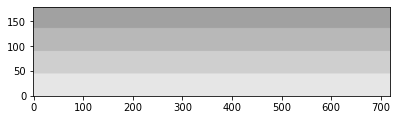

In [158]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread("grayscale_image_720x240.png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)



In [159]:
"""import cv2
def detect_edges(image):
    original_image = Image.open(image)
    test = iio.imread(image)

    width, height = original_image.size
    max_size = 300
    if width > height:
        new_width = max_size
        new_height = int(height * (max_size / width))
    else:
        new_width = int(width * (max_size / height))
        new_height = max_size
    original_image = original_image.resize((new_width, new_height))
    np_image = np.array(original_image)

    blur = cv2.GaussianBlur(np_image, (11,11), 0)

    edges = cv2.Canny(blur, 34, 0)

    pil_edges = Image.fromarray(edges)
    edges = pil_edges.resize((width, height))

    edges.save("_edges.png")
    edges = np.array(edges)

    #plt.imshow(edges, cmap='gray')
    #plt.show()

image_path = "original.png"
detect_edges(image_path)"""
edge_image = np.flipud(crop(iio.imread("_edges.png"), MASK))


In [160]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))


    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self, intermediates):
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))

    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        height, width = image.shape[:2]
        intermediates[:, 0] = np.clip(intermediates[:, 0], 0, width - 1)
        intermediates[:, 1] = np.clip(intermediates[:, 1], 0, height - 1)
        colours = [image[point[1],point[0]] for point in intermediates] #? had to swap point[1] and point[0] cause y and x were in the other order
        return(np.array(colours)/255)


    def point_at_t(self, t):
        point = self.bezier.point_at_t(t)
        return np.round(point).astype(int)


    def img_color_across_t(self, t, image):
      # average image colour across all points in t
      intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
      try:
          return np.array(image[intermediates[:, 1], intermediates[:, 0]]) / 255.0
      except:
          return np.array([0 for _ in range(len(t))])

In [161]:
import pickle
# Save the list to a file
def save_camo_worms(camo_worms, filename):
    with open(filename, 'wb') as file:
        pickle.dump(camo_worms, file)

# Load the list from a file
def load_camo_worms(filename):
    with open(filename, 'rb') as file:
        camo_worms = pickle.load(file)
    return camo_worms

In [162]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()


In [163]:
# Example of a random worm. You may do this differently.

    # centre points, angles and colour chosen from uniform distributions
    # lengths chosen from normal distributions with two std parameters passed
    # width chosen from gamma distribution with shape parameter 3 and scale passed

def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = 100
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = 10
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)


In [164]:
# Initialise a random clew
def initialise_clew (size, imshape, init_params):
    clew = []
    for i in range(size):
        clew.append(random_worm(imshape, init_params))
    return clew

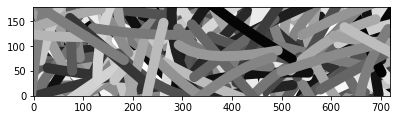

In [165]:
# Initialise clew of 40 and draw
clew = initialise_clew(2469, image.shape, (40, 30, 1))
drawing = Drawing(image)
drawing.add_worms(clew)
drawing.show()

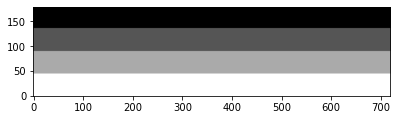

70.00418698075563

In [166]:
# Draw a single worm along with control points and some sample points
#2469 worms each with approx_length of 70
worm = Camo_Worm(200, 200, 1, np.pi/8, 70, np.pi/8, 5, 0.8)
drawing = Drawing(image)


drawing.show(save='test_image.png')


worm.approx_length(worm.intermediate_points())

In [189]:

def cost_function(image, worm, coordinates, worms_in_image, edge_image, we, wg, wi, divisions = 4): #Fix t values
    img_height, img_width = image.shape[:2]
    t_values = np.linspace(0,1,divisions)
    worm_col = worm.colour

    #Internal Knowledge
    worm_colour_cost = np.mean([abs((worm.colour_at_t(t, image)[0] - worm_col)) for t in t_values])*300

    desired_angle = np.pi  # 180 degrees (straight line)
    angle_tolerance = np.pi / 4  # 45 degrees on either side
    worm_angle = worm.theta
    worm_angle = (worm_angle + 2 * np.pi) % (2 * np.pi)  # Normalize the worm angle to be within the range of 0 to 2*pi
    diff = np.abs(worm_angle - desired_angle)
    diff = min(diff, 2 * np.pi - diff)  # Adjust the angle difference to consider the shortest path
    if diff <= angle_tolerance:
        horizontal_cost = 0  # No cost if within the desired angle range
    else:
        horizontal_cost = (diff - angle_tolerance) / (np.pi - angle_tolerance) * 100

    #Vertical Cost
    control_points = worm.control_points()
    y_coordinates = control_points[:, 1]
    vertical_stretch = np.max(y_coordinates) - np.min(y_coordinates)
    threshold = 75  # Adjust this value based on the desired vertical stretch tolerance
    scaling_factor = 100  # Adjust this value to control the impact of vertical stretching
    
    if vertical_stretch <= threshold:
        vertical_stretch_cost = 0
    else:
        vertical_stretch_cost = (vertical_stretch - threshold) / threshold * scaling_factor


    internal_cost = worm_colour_cost + horizontal_cost + vertical_stretch_cost

    #Group Knowledge
    worm_coordinates = [tuple(worm.point_at_t(t)) for t in t_values]
    shared_coord_cost = 0
    for coord in worm_coordinates:
      shared_coord_cost += coordinates.count(coord)

    shared_coord_cost = shared_coord_cost*25
        #Distance Cost
    closest_worm = None
    min_distance = float('inf')  # Initialize with a large number

    if len(worms_in_image) != 0:
      for other_worm in worms_in_image: # Iterate through each swarm and each worm within the swarm
        distance = ((worm.x - other_worm.x) ** 2 + (worm.y - other_worm.y) ** 2) ** 0.5
        if distance < min_distance:
            min_distance = distance
            closest_worm = other_worm  # Update the closest worm
      distance_limit = min(min_distance, min(img_width, img_height) * 2 / np.ceil(len(worms_in_image) ** 0.5))    # Apply upper limit to distance based on image dimensions and number of swarms
      normalized_distance = distance_limit / (min(img_width, img_height) / np.ceil(len(worms_in_image) ** 0.5))    # Normalize the distance
      distance_cost = max(0, (1.0 - normalized_distance)) * 100
    else:
      distance_cost = 0
          #Parralel Cost
    if closest_worm is not None:
      r1 = worm.theta
      r2 = closest_worm.theta
      angle_diff = np.abs(r1 - r2)
      angle_diff = min(angle_diff, 2*np.pi - angle_diff)  # This accounts for wrapping around the circle
      similarity_score = (angle_diff / np.pi)*100  # Normalize the difference by pi
    else:
      similarity_score = 0

        #Boundary Cost
    min_x, min_y = np.min(worm.control_points(), axis=0)
    max_x, max_y = np.max(worm.control_points(), axis=0)
    if min_x < 0 or max_x >= img_width or min_y < 0 or max_y >= img_height:
        boundry_cost = 50
    else:
        boundry_cost = 0  # doesn't affect worm if it's inside boundaries


    t = np.linspace(0, 1, divisions)  # You can adjust the number of samples based on the accuracy needed

        #Cross edge cost
    cross_fac = np.mean(worm.img_color_across_t(t, edge_image))
    if cross_fac > 0:
        cross_cost = 50
    else:
        cross_cost = 0
    cross_cost = 0

    environmental_cost = shared_coord_cost + distance_cost + similarity_score + boundry_cost + cross_cost






    #Environmental Knowledge
    image_variance_cost = np.std([worm.colour_at_t(t,image) for t in t_values])*1000

     #Weights
    Wi = wi
    Wg = wg
    We = we


    total_cost = We*image_variance_cost + Wg*environmental_cost + Wi*internal_cost

    mutate_weight = 1.0

    return (total_cost, mutate_weight)


Get colour from other worms

In [190]:
worm = random_worm(image.shape, (40, 30, 1))




In [191]:
import random

population = initialise_clew(40, image.shape, (40, 30, 1))

def tournament_selection(image, population, coordinates, worms_in_image, edge_image, we, wg, wi,  k=3):
  fitness_values  = [cost_function(image, worm, coordinates, worms_in_image, edge_image, we, wg, wi) for worm in population]
  worms_fitness_values = zip(population, fitness_values)
  sampled_worms = random.sample(list(worms_fitness_values), 3)
  min_fitness = min(sampled_worms, key=lambda x: x[1])
  worm = min_fitness[0]
  fitness = min_fitness[1]
  return worm, fitness






In [170]:
image.shape[0]

180

In [192]:
import math
import random

def mutation(image, population, coordinates, worms_in_image, edge_image, we, wg, wi):
  parent1 = tournament_selection(image, population, coordinates, worms_in_image, edge_image, we, wg, wi)
  worm = parent1[0]
  fitness = parent1[1][0]
  weight = parent1[1][1]
  target = worm.colour_at_t(0.5, image)
  error = target - worm.colour
  if error > 0.2:
    weight = 5
  if error > 0:
      add_colour = weight*random.uniform(0, 0.01)*we
  elif error != 0:
      add_colour = weight*random.uniform(-0.01, 0)*we
  new_colour = max(0.01, min(0.99, worm.colour + add_colour))
  if weight > 10:
    mutation_rate = 0.99
  else:
    mutation_rate = 0.4
  if random.random() < mutation_rate:
    x_movement = weight * random.choice([1, -1])
  else:
    x_movement = 0

  if random.random() < mutation_rate:
    y_movement = weight * random.choice([1, -1])
  else:
    y_movement = 0

  if random.random() < mutation_rate:
    r_movement = weight * random.choice([1, -1])
  else:
    r_movement = 0

  if random.random() < mutation_rate:
    theta_movement = weight * random.uniform(-math.pi/8, math.pi/8)
  else:
    theta_movement = 0

  if random.random() < mutation_rate:
    dr_movement = weight * random.choice([1, -1])
  else:
    dr_movement = 0

  if random.random() < mutation_rate:
    dgamma_movement = weight * random.uniform(-math.pi/8, math.pi/8)
  else:
    dgamma_movement = 0

  if random.random() < mutation_rate:
    #w_movement = weight * random.choice([1, -1])
    w_movement = 0
  else:
    w_movement = 0

  return Camo_Worm((worm.x + x_movement), (worm.y + y_movement), (worm.r + r_movement),(worm.theta + theta_movement), (worm.dr + dr_movement), (worm.dgamma + dgamma_movement), (worm.width + w_movement), (new_colour))


In [187]:
def genetic_algorithm(image, population, coordinates, worms_in_image, edge_image,we, wg, wi):
  iteration = 0
  global_min = float('inf')
  fittest_worm = 0
  while iteration < 100:
    new_population = []
    for _ in range(len(population)):
      new_worm = mutation(image,population,coordinates, worms_in_image, edge_image,we, wg, wi,)
      new_population.append(new_worm)
    if iteration % 50 == 0:
      new_population.append(random_worm((240, 720), (40, 30, 1)))
    fitness_values  = [cost_function(image, worm, coordinates, worms_in_image, edge_image, we, wg, wi)[0] for worm in population]
    min_cost = (min(fitness_values))
    if min_cost < global_min:
      fittest_worm = population[fitness_values.index(min_cost)]
      global_min = min_cost
    population = new_population
    iteration += 1
  return (fittest_worm, global_min)

0


TypeError: genetic_algorithm() missing 3 required positional arguments: 'we', 'wg', and 'wi'

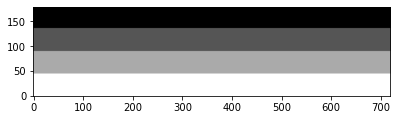

In [173]:
num_species = 2500
coordinates = []
worms_in_image = []
t_values = np.linspace(0,1,6)
drawing = Drawing(image)
fit_population = []
for i in range(num_species):
  print(i)
  population = [random_worm(image.shape, (40, 30, 1))]*3
  fittest_worm = genetic_algorithm(image,population,coordinates, fit_population, edge_image)
  worm = fittest_worm[0]
  for t in t_values:
    coordinates.append(tuple(worm.point_at_t(t)))
  fit_population.append(worm)
  if i % 5 ==0:
    drawing = Drawing(image)
    for worm in fit_population:
      drawing.add_worms(worm)
    drawing.show()


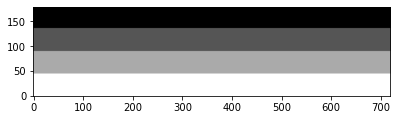

In [174]:
drawing = Drawing(image)
for worm in fit_population:
    drawing.add_worms(worm)
drawing.show(save="2500_small")

Encourage worm to be longer
Encourage worm to be furhter apart from other worms
Intergrate back with original code

In [177]:
# Save the list to a file
save_camo_worms(fit_population, 'fit1_worms.pickle')

In [178]:
len(worms_in_image)

0

In [179]:
import cv2
def crop_center_rectangle(image):
    """
    Crops the center rectangle of an image, retaining 50% of the original width and height.
    
    Args:
    image (np.array): An image array loaded by OpenCV.
    
    Returns:
    np.array: The cropped image array.
    """
    height, width = image.shape[:2]
    left = int(width * 0.13)
    right = int(width * 0.90)
    top = int(height * 0.30)
    bottom = int(height * 0.70)
    plt.imshow(image[top:bottom, left:right], cmap='gray')
    return image[top:bottom, left:right]

def image_variance(current_image_path, averaged_image_path):
    # Read the images
    current_image = cv2.imread(current_image_path, cv2.IMREAD_GRAYSCALE)
    averaged_image = cv2.imread(averaged_image_path, cv2.IMREAD_GRAYSCALE)

    # Check if images are loaded successfully
    if current_image is None or averaged_image is None:
        print("Error: One or both images could not be loaded.")
        return None

    # Crop the images
    #current_image = crop_center_rectangle(current_image)
    #averaged_image = crop_center_rectangle(averaged_image)
    
    # Compute the squared difference between the images
    squared_diff = (current_image - averaged_image) ** 2
    
    # Compute the mean of the squared difference
    variance = np.mean(squared_diff)
    
    # Normalize variance by the maximum possible variance
    max_possible_variance = 255**2  # Maximum possible pixel value difference
    percentage_difference = (variance / max_possible_variance) * 100
    
    return percentage_difference

# avg_image = prep_image(IMAGE_DIR, "averaged", MASK)
# imgs = Drawing(avg_image)
# imgs.show(save=("images/avg_comparison"))
# drawing = Drawing(image)
# for ix in range(len(swarms)):
#     drawing.add_worms(swarms[ix].avg_worm())
# drawing.show(save=("images/final1"))
#drawing = np.array(drawing.im)
#plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower')

In [180]:
test_optimise = image


In [195]:
def generate_images(test_optimise):
    num_species = 5
    t_values = np.linspace(0, 1, 4)
    we_values = np.arange(0, 4.01, 0.5)
    wg_values = np.arange(0, 4.01, 0.5)
    wi_values = np.arange(0, 4.01, 0.5)
    variances = {}
    image = test_optimise
    i = 1

    for we in we_values:
        i+= 1
        for wg in wg_values:
            for wi in wi_values:
                coordinates = []
                worms_in_image = []
                fit_population = []

                for i in range(num_species):
                    print(f"Processing: WE={we:.1f}, WG={wg:.1f}, WI={wi:.1f}, Species={i}")
                    population = [random_worm(image.shape, (40, 30, 1))] * 3
                    fittest_worm = genetic_algorithm(image, population, coordinates, fit_population, edge_image, we, wg, wi)
                    worm = fittest_worm[0]

                    for t in t_values:
                        coordinates.append(tuple(worm.point_at_t(t)))
                    fit_population.append(worm)

                drawing = Drawing(image)
                for worm in fit_population:
                    drawing.add_worms(worm)
                
                image_path = f"we_{we:.1f}_wg_{wg:.1f}_wi_{wi:.1f}.png"
                
                drawing.show(save=image_path)


                variance = image_variance(image_path, ("test_image.png"))
                variances[(we, wg, wi)] = variance
                print(variance)
    return variances
                

Processing: WE=0.0, WG=0.0, WI=0.0, Species=0
Processing: WE=0.0, WG=0.0, WI=0.0, Species=1
Processing: WE=0.0, WG=0.0, WI=0.0, Species=2
Processing: WE=0.0, WG=0.0, WI=0.0, Species=3
Processing: WE=0.0, WG=0.0, WI=0.0, Species=4


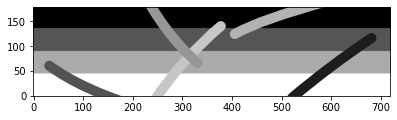

0.006353399533454609
Processing: WE=0.0, WG=0.0, WI=0.5, Species=0
Processing: WE=0.0, WG=0.0, WI=0.5, Species=1
Processing: WE=0.0, WG=0.0, WI=0.5, Species=2
Processing: WE=0.0, WG=0.0, WI=0.5, Species=3
Processing: WE=0.0, WG=0.0, WI=0.5, Species=4


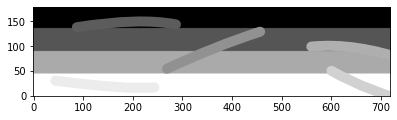

0.004242873966122767
Processing: WE=0.0, WG=0.0, WI=1.0, Species=0
Processing: WE=0.0, WG=0.0, WI=1.0, Species=1
Processing: WE=0.0, WG=0.0, WI=1.0, Species=2
Processing: WE=0.0, WG=0.0, WI=1.0, Species=3
Processing: WE=0.0, WG=0.0, WI=1.0, Species=4


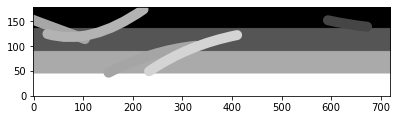

0.0036754222056515997
Processing: WE=0.0, WG=0.0, WI=1.5, Species=0
Processing: WE=0.0, WG=0.0, WI=1.5, Species=1
Processing: WE=0.0, WG=0.0, WI=1.5, Species=2
Processing: WE=0.0, WG=0.0, WI=1.5, Species=3
Processing: WE=0.0, WG=0.0, WI=1.5, Species=4


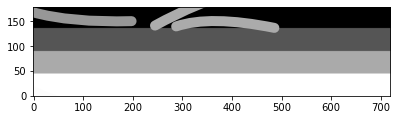

0.0020106076209843193
Processing: WE=0.0, WG=0.0, WI=2.0, Species=0
Processing: WE=0.0, WG=0.0, WI=2.0, Species=1
Processing: WE=0.0, WG=0.0, WI=2.0, Species=2
Processing: WE=0.0, WG=0.0, WI=2.0, Species=3
Processing: WE=0.0, WG=0.0, WI=2.0, Species=4


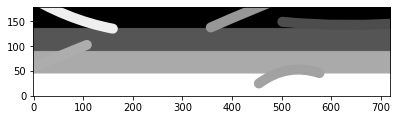

0.002444777310457153
Processing: WE=0.0, WG=0.0, WI=2.5, Species=0
Processing: WE=0.0, WG=0.0, WI=2.5, Species=1
Processing: WE=0.0, WG=0.0, WI=2.5, Species=2
Processing: WE=0.0, WG=0.0, WI=2.5, Species=3
Processing: WE=0.0, WG=0.0, WI=2.5, Species=4


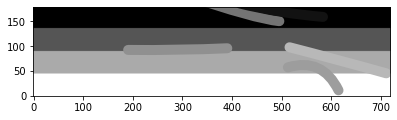

0.005971635648835562
Processing: WE=0.0, WG=0.0, WI=3.0, Species=0
Processing: WE=0.0, WG=0.0, WI=3.0, Species=1
Processing: WE=0.0, WG=0.0, WI=3.0, Species=2
Processing: WE=0.0, WG=0.0, WI=3.0, Species=3
Processing: WE=0.0, WG=0.0, WI=3.0, Species=4


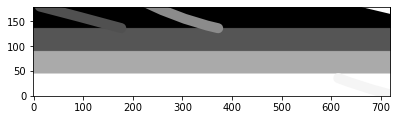

0.0016700764840821484
Processing: WE=0.0, WG=0.0, WI=3.5, Species=0
Processing: WE=0.0, WG=0.0, WI=3.5, Species=1
Processing: WE=0.0, WG=0.0, WI=3.5, Species=2
Processing: WE=0.0, WG=0.0, WI=3.5, Species=3
Processing: WE=0.0, WG=0.0, WI=3.5, Species=4


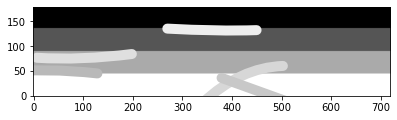

0.006710200889726141
Processing: WE=0.0, WG=0.0, WI=4.0, Species=0
Processing: WE=0.0, WG=0.0, WI=4.0, Species=1
Processing: WE=0.0, WG=0.0, WI=4.0, Species=2
Processing: WE=0.0, WG=0.0, WI=4.0, Species=3
Processing: WE=0.0, WG=0.0, WI=4.0, Species=4


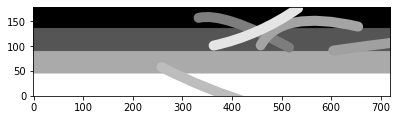

0.0036424069362106133
Processing: WE=0.0, WG=0.5, WI=0.0, Species=0
Processing: WE=0.0, WG=0.5, WI=0.0, Species=1
Processing: WE=0.0, WG=0.5, WI=0.0, Species=2
Processing: WE=0.0, WG=0.5, WI=0.0, Species=3
Processing: WE=0.0, WG=0.5, WI=0.0, Species=4


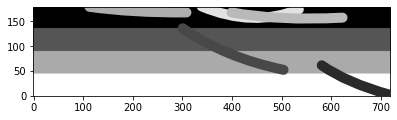

0.005677269684700301
Processing: WE=0.0, WG=0.5, WI=0.5, Species=0
Processing: WE=0.0, WG=0.5, WI=0.5, Species=1
Processing: WE=0.0, WG=0.5, WI=0.5, Species=2
Processing: WE=0.0, WG=0.5, WI=0.5, Species=3
Processing: WE=0.0, WG=0.5, WI=0.5, Species=4


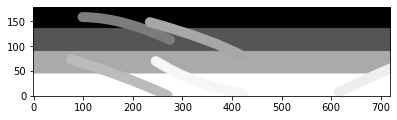

0.0037948469724818647
Processing: WE=0.0, WG=0.5, WI=1.0, Species=0
Processing: WE=0.0, WG=0.5, WI=1.0, Species=1
Processing: WE=0.0, WG=0.5, WI=1.0, Species=2
Processing: WE=0.0, WG=0.5, WI=1.0, Species=3
Processing: WE=0.0, WG=0.5, WI=1.0, Species=4


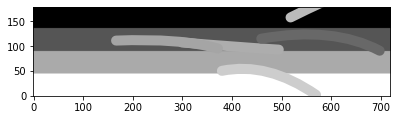

0.004403686527429831
Processing: WE=0.0, WG=0.5, WI=1.5, Species=0
Processing: WE=0.0, WG=0.5, WI=1.5, Species=1
Processing: WE=0.0, WG=0.5, WI=1.5, Species=2
Processing: WE=0.0, WG=0.5, WI=1.5, Species=3
Processing: WE=0.0, WG=0.5, WI=1.5, Species=4


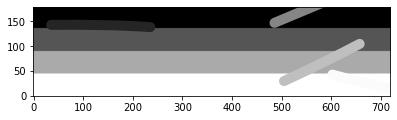

0.002892513591423201
Processing: WE=0.0, WG=0.5, WI=2.0, Species=0
Processing: WE=0.0, WG=0.5, WI=2.0, Species=1
Processing: WE=0.0, WG=0.5, WI=2.0, Species=2
Processing: WE=0.0, WG=0.5, WI=2.0, Species=3
Processing: WE=0.0, WG=0.5, WI=2.0, Species=4


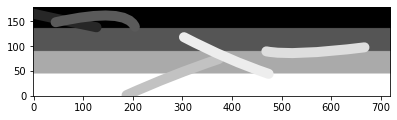

0.00576082050745351
Processing: WE=0.0, WG=0.5, WI=2.5, Species=0
Processing: WE=0.0, WG=0.5, WI=2.5, Species=1
Processing: WE=0.0, WG=0.5, WI=2.5, Species=2
Processing: WE=0.0, WG=0.5, WI=2.5, Species=3
Processing: WE=0.0, WG=0.5, WI=2.5, Species=4


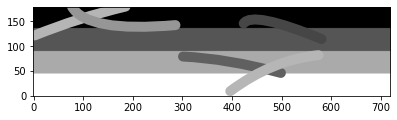

0.007040644296810858
Processing: WE=0.0, WG=0.5, WI=3.0, Species=0
Processing: WE=0.0, WG=0.5, WI=3.0, Species=1
Processing: WE=0.0, WG=0.5, WI=3.0, Species=2
Processing: WE=0.0, WG=0.5, WI=3.0, Species=3
Processing: WE=0.0, WG=0.5, WI=3.0, Species=4


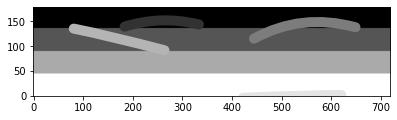

0.004586467276533406
Processing: WE=0.0, WG=0.5, WI=3.5, Species=0
Processing: WE=0.0, WG=0.5, WI=3.5, Species=1
Processing: WE=0.0, WG=0.5, WI=3.5, Species=2
Processing: WE=0.0, WG=0.5, WI=3.5, Species=3
Processing: WE=0.0, WG=0.5, WI=3.5, Species=4


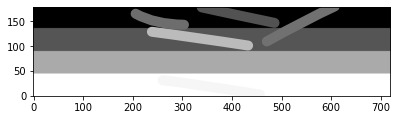

0.004915592786158781
Processing: WE=0.0, WG=0.5, WI=4.0, Species=0
Processing: WE=0.0, WG=0.5, WI=4.0, Species=1
Processing: WE=0.0, WG=0.5, WI=4.0, Species=2
Processing: WE=0.0, WG=0.5, WI=4.0, Species=3
Processing: WE=0.0, WG=0.5, WI=4.0, Species=4


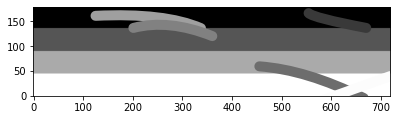

0.004456877256505725
Processing: WE=0.0, WG=1.0, WI=0.0, Species=0
Processing: WE=0.0, WG=1.0, WI=0.0, Species=1
Processing: WE=0.0, WG=1.0, WI=0.0, Species=2
Processing: WE=0.0, WG=1.0, WI=0.0, Species=3
Processing: WE=0.0, WG=1.0, WI=0.0, Species=4


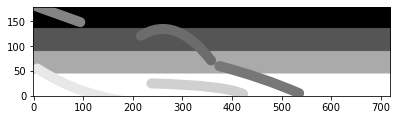

0.0031893506132947267
Processing: WE=0.0, WG=1.0, WI=0.5, Species=0
Processing: WE=0.0, WG=1.0, WI=0.5, Species=1
Processing: WE=0.0, WG=1.0, WI=0.5, Species=2
Processing: WE=0.0, WG=1.0, WI=0.5, Species=3
Processing: WE=0.0, WG=1.0, WI=0.5, Species=4


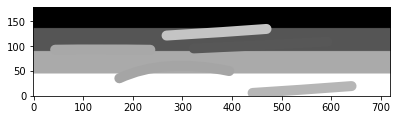

0.004741707844905757
Processing: WE=0.0, WG=1.0, WI=1.0, Species=0
Processing: WE=0.0, WG=1.0, WI=1.0, Species=1
Processing: WE=0.0, WG=1.0, WI=1.0, Species=2
Processing: WE=0.0, WG=1.0, WI=1.0, Species=3
Processing: WE=0.0, WG=1.0, WI=1.0, Species=4


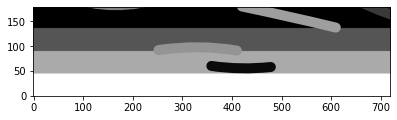

0.003278812593769979
Processing: WE=0.0, WG=1.0, WI=1.5, Species=0
Processing: WE=0.0, WG=1.0, WI=1.5, Species=1
Processing: WE=0.0, WG=1.0, WI=1.5, Species=2
Processing: WE=0.0, WG=1.0, WI=1.5, Species=3
Processing: WE=0.0, WG=1.0, WI=1.5, Species=4


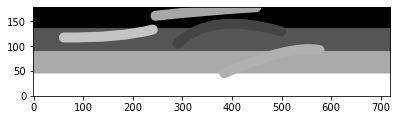

0.0037393305420071335
Processing: WE=0.0, WG=1.0, WI=2.0, Species=0
Processing: WE=0.0, WG=1.0, WI=2.0, Species=1
Processing: WE=0.0, WG=1.0, WI=2.0, Species=2
Processing: WE=0.0, WG=1.0, WI=2.0, Species=3
Processing: WE=0.0, WG=1.0, WI=2.0, Species=4


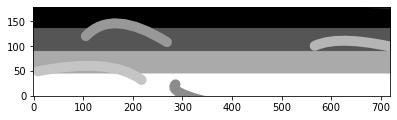

0.0037791581784622124
Processing: WE=0.0, WG=1.0, WI=2.5, Species=0
Processing: WE=0.0, WG=1.0, WI=2.5, Species=1
Processing: WE=0.0, WG=1.0, WI=2.5, Species=2
Processing: WE=0.0, WG=1.0, WI=2.5, Species=3
Processing: WE=0.0, WG=1.0, WI=2.5, Species=4


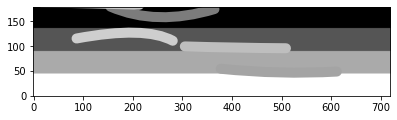

0.002869421314617251
Processing: WE=0.0, WG=1.0, WI=3.0, Species=0
Processing: WE=0.0, WG=1.0, WI=3.0, Species=1
Processing: WE=0.0, WG=1.0, WI=3.0, Species=2
Processing: WE=0.0, WG=1.0, WI=3.0, Species=3
Processing: WE=0.0, WG=1.0, WI=3.0, Species=4


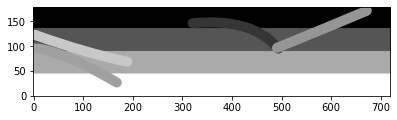

0.005087917569390087
Processing: WE=0.0, WG=1.0, WI=3.5, Species=0
Processing: WE=0.0, WG=1.0, WI=3.5, Species=1
Processing: WE=0.0, WG=1.0, WI=3.5, Species=2
Processing: WE=0.0, WG=1.0, WI=3.5, Species=3
Processing: WE=0.0, WG=1.0, WI=3.5, Species=4


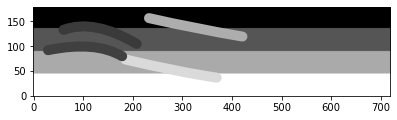

0.004891579919215793
Processing: WE=0.0, WG=1.0, WI=4.0, Species=0
Processing: WE=0.0, WG=1.0, WI=4.0, Species=1
Processing: WE=0.0, WG=1.0, WI=4.0, Species=2
Processing: WE=0.0, WG=1.0, WI=4.0, Species=3
Processing: WE=0.0, WG=1.0, WI=4.0, Species=4


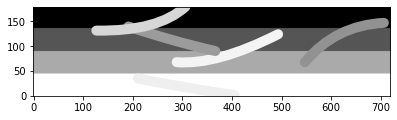

0.004299436962226975
Processing: WE=0.0, WG=1.5, WI=0.0, Species=0
Processing: WE=0.0, WG=1.5, WI=0.0, Species=1
Processing: WE=0.0, WG=1.5, WI=0.0, Species=2
Processing: WE=0.0, WG=1.5, WI=0.0, Species=3
Processing: WE=0.0, WG=1.5, WI=0.0, Species=4


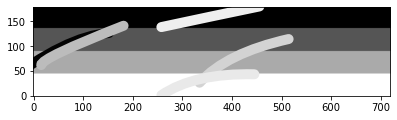

0.004659959440736646
Processing: WE=0.0, WG=1.5, WI=0.5, Species=0
Processing: WE=0.0, WG=1.5, WI=0.5, Species=1
Processing: WE=0.0, WG=1.5, WI=0.5, Species=2
Processing: WE=0.0, WG=1.5, WI=0.5, Species=3
Processing: WE=0.0, WG=1.5, WI=0.5, Species=4


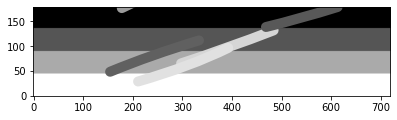

0.003903670417102433
Processing: WE=0.0, WG=1.5, WI=1.0, Species=0
Processing: WE=0.0, WG=1.5, WI=1.0, Species=1
Processing: WE=0.0, WG=1.5, WI=1.0, Species=2
Processing: WE=0.0, WG=1.5, WI=1.0, Species=3
Processing: WE=0.0, WG=1.5, WI=1.0, Species=4


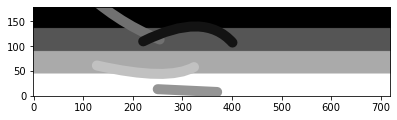

0.0029253156715692936
Processing: WE=0.0, WG=1.5, WI=1.5, Species=0
Processing: WE=0.0, WG=1.5, WI=1.5, Species=1
Processing: WE=0.0, WG=1.5, WI=1.5, Species=2
Processing: WE=0.0, WG=1.5, WI=1.5, Species=3
Processing: WE=0.0, WG=1.5, WI=1.5, Species=4


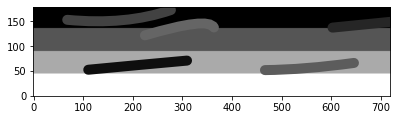

0.004276170257816113
Processing: WE=0.0, WG=1.5, WI=2.0, Species=0
Processing: WE=0.0, WG=1.5, WI=2.0, Species=1
Processing: WE=0.0, WG=1.5, WI=2.0, Species=2
Processing: WE=0.0, WG=1.5, WI=2.0, Species=3
Processing: WE=0.0, WG=1.5, WI=2.0, Species=4


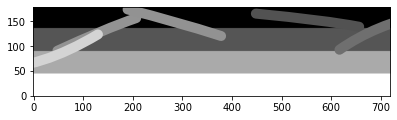

0.003947170723683174
Processing: WE=0.0, WG=1.5, WI=2.5, Species=0
Processing: WE=0.0, WG=1.5, WI=2.5, Species=1
Processing: WE=0.0, WG=1.5, WI=2.5, Species=2
Processing: WE=0.0, WG=1.5, WI=2.5, Species=3
Processing: WE=0.0, WG=1.5, WI=2.5, Species=4


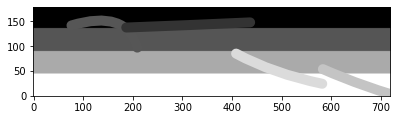

0.004217649796367884
Processing: WE=0.0, WG=1.5, WI=3.0, Species=0
Processing: WE=0.0, WG=1.5, WI=3.0, Species=1
Processing: WE=0.0, WG=1.5, WI=3.0, Species=2
Processing: WE=0.0, WG=1.5, WI=3.0, Species=3
Processing: WE=0.0, WG=1.5, WI=3.0, Species=4


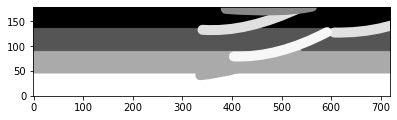

0.003370842536206447
Processing: WE=0.0, WG=1.5, WI=3.5, Species=0
Processing: WE=0.0, WG=1.5, WI=3.5, Species=1
Processing: WE=0.0, WG=1.5, WI=3.5, Species=2
Processing: WE=0.0, WG=1.5, WI=3.5, Species=3
Processing: WE=0.0, WG=1.5, WI=3.5, Species=4


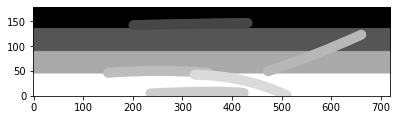

0.0056506016419936396
Processing: WE=0.0, WG=1.5, WI=4.0, Species=0
Processing: WE=0.0, WG=1.5, WI=4.0, Species=1
Processing: WE=0.0, WG=1.5, WI=4.0, Species=2
Processing: WE=0.0, WG=1.5, WI=4.0, Species=3
Processing: WE=0.0, WG=1.5, WI=4.0, Species=4


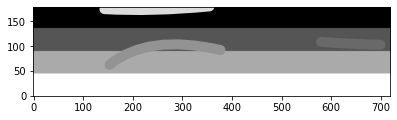

0.002197458347535859
Processing: WE=0.0, WG=2.0, WI=0.0, Species=0
Processing: WE=0.0, WG=2.0, WI=0.0, Species=1
Processing: WE=0.0, WG=2.0, WI=0.0, Species=2
Processing: WE=0.0, WG=2.0, WI=0.0, Species=3
Processing: WE=0.0, WG=2.0, WI=0.0, Species=4


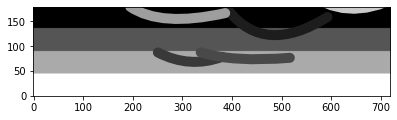

0.005638537065987174
Processing: WE=0.0, WG=2.0, WI=0.5, Species=0
Processing: WE=0.0, WG=2.0, WI=0.5, Species=1
Processing: WE=0.0, WG=2.0, WI=0.5, Species=2
Processing: WE=0.0, WG=2.0, WI=0.5, Species=3
Processing: WE=0.0, WG=2.0, WI=0.5, Species=4


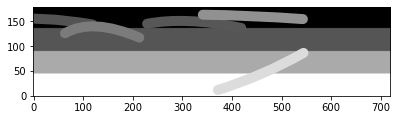

0.005893773104087009
Processing: WE=0.0, WG=2.0, WI=1.0, Species=0
Processing: WE=0.0, WG=2.0, WI=1.0, Species=1
Processing: WE=0.0, WG=2.0, WI=1.0, Species=2
Processing: WE=0.0, WG=2.0, WI=1.0, Species=3
Processing: WE=0.0, WG=2.0, WI=1.0, Species=4


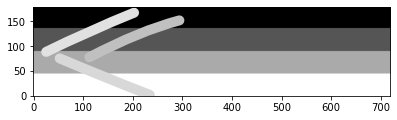

0.004785053104726576
Processing: WE=0.0, WG=2.0, WI=1.5, Species=0
Processing: WE=0.0, WG=2.0, WI=1.5, Species=1
Processing: WE=0.0, WG=2.0, WI=1.5, Species=2
Processing: WE=0.0, WG=2.0, WI=1.5, Species=3
Processing: WE=0.0, WG=2.0, WI=1.5, Species=4


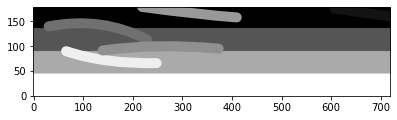

0.0061643297001516785
Processing: WE=0.0, WG=2.0, WI=2.0, Species=0
Processing: WE=0.0, WG=2.0, WI=2.0, Species=1
Processing: WE=0.0, WG=2.0, WI=2.0, Species=2
Processing: WE=0.0, WG=2.0, WI=2.0, Species=3
Processing: WE=0.0, WG=2.0, WI=2.0, Species=4


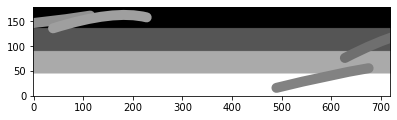

0.0034208644971264264
Processing: WE=0.0, WG=2.0, WI=2.5, Species=0
Processing: WE=0.0, WG=2.0, WI=2.5, Species=1
Processing: WE=0.0, WG=2.0, WI=2.5, Species=2
Processing: WE=0.0, WG=2.0, WI=2.5, Species=3
Processing: WE=0.0, WG=2.0, WI=2.5, Species=4


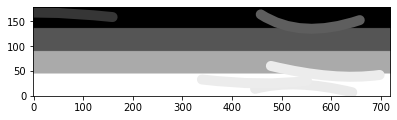

0.0052967074124706534
Processing: WE=0.0, WG=2.0, WI=3.0, Species=0
Processing: WE=0.0, WG=2.0, WI=3.0, Species=1
Processing: WE=0.0, WG=2.0, WI=3.0, Species=2
Processing: WE=0.0, WG=2.0, WI=3.0, Species=3
Processing: WE=0.0, WG=2.0, WI=3.0, Species=4


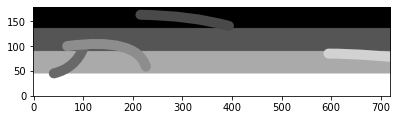

0.0034566899890910068
Processing: WE=0.0, WG=2.0, WI=3.5, Species=0
Processing: WE=0.0, WG=2.0, WI=3.5, Species=1
Processing: WE=0.0, WG=2.0, WI=3.5, Species=2
Processing: WE=0.0, WG=2.0, WI=3.5, Species=3
Processing: WE=0.0, WG=2.0, WI=3.5, Species=4


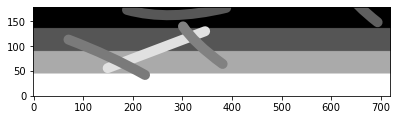

0.004480831980913744
Processing: WE=0.0, WG=2.0, WI=4.0, Species=0
Processing: WE=0.0, WG=2.0, WI=4.0, Species=1
Processing: WE=0.0, WG=2.0, WI=4.0, Species=2
Processing: WE=0.0, WG=2.0, WI=4.0, Species=3
Processing: WE=0.0, WG=2.0, WI=4.0, Species=4


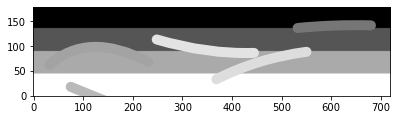

0.0044314398974559495
Processing: WE=0.0, WG=2.5, WI=0.0, Species=0
Processing: WE=0.0, WG=2.5, WI=0.0, Species=1
Processing: WE=0.0, WG=2.5, WI=0.0, Species=2
Processing: WE=0.0, WG=2.5, WI=0.0, Species=3
Processing: WE=0.0, WG=2.5, WI=0.0, Species=4


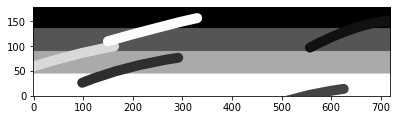

0.004208075658942673
Processing: WE=0.0, WG=2.5, WI=0.5, Species=0
Processing: WE=0.0, WG=2.5, WI=0.5, Species=1
Processing: WE=0.0, WG=2.5, WI=0.5, Species=2
Processing: WE=0.0, WG=2.5, WI=0.5, Species=3
Processing: WE=0.0, WG=2.5, WI=0.5, Species=4


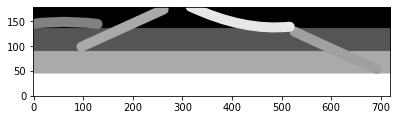

0.004368655650109853
Processing: WE=0.0, WG=2.5, WI=1.0, Species=0
Processing: WE=0.0, WG=2.5, WI=1.0, Species=1
Processing: WE=0.0, WG=2.5, WI=1.0, Species=2
Processing: WE=0.0, WG=2.5, WI=1.0, Species=3
Processing: WE=0.0, WG=2.5, WI=1.0, Species=4


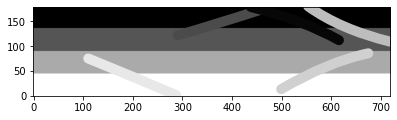

0.005280553478171233
Processing: WE=0.0, WG=2.5, WI=1.5, Species=0
Processing: WE=0.0, WG=2.5, WI=1.5, Species=1
Processing: WE=0.0, WG=2.5, WI=1.5, Species=2
Processing: WE=0.0, WG=2.5, WI=1.5, Species=3
Processing: WE=0.0, WG=2.5, WI=1.5, Species=4


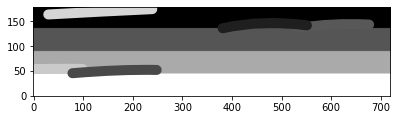

0.005937593194610091
Processing: WE=0.0, WG=2.5, WI=2.0, Species=0
Processing: WE=0.0, WG=2.5, WI=2.0, Species=1
Processing: WE=0.0, WG=2.5, WI=2.0, Species=2
Processing: WE=0.0, WG=2.5, WI=2.0, Species=3
Processing: WE=0.0, WG=2.5, WI=2.0, Species=4


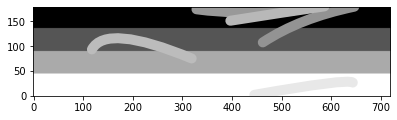

0.003810128768756721
Processing: WE=0.0, WG=2.5, WI=2.5, Species=0
Processing: WE=0.0, WG=2.5, WI=2.5, Species=1
Processing: WE=0.0, WG=2.5, WI=2.5, Species=2
Processing: WE=0.0, WG=2.5, WI=2.5, Species=3
Processing: WE=0.0, WG=2.5, WI=2.5, Species=4


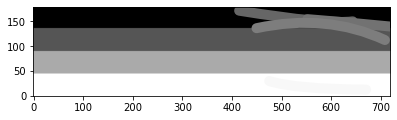

0.002995144856069366
Processing: WE=0.0, WG=2.5, WI=3.0, Species=0
Processing: WE=0.0, WG=2.5, WI=3.0, Species=1
Processing: WE=0.0, WG=2.5, WI=3.0, Species=2
Processing: WE=0.0, WG=2.5, WI=3.0, Species=3
Processing: WE=0.0, WG=2.5, WI=3.0, Species=4


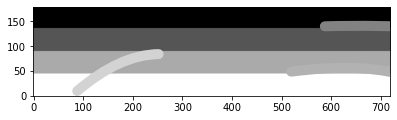

0.0024963594293988525
Processing: WE=0.0, WG=2.5, WI=3.5, Species=0
Processing: WE=0.0, WG=2.5, WI=3.5, Species=1
Processing: WE=0.0, WG=2.5, WI=3.5, Species=2
Processing: WE=0.0, WG=2.5, WI=3.5, Species=3
Processing: WE=0.0, WG=2.5, WI=3.5, Species=4


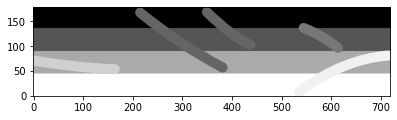

0.005624485953369202
Processing: WE=0.0, WG=2.5, WI=4.0, Species=0
Processing: WE=0.0, WG=2.5, WI=4.0, Species=1
Processing: WE=0.0, WG=2.5, WI=4.0, Species=2
Processing: WE=0.0, WG=2.5, WI=4.0, Species=3
Processing: WE=0.0, WG=2.5, WI=4.0, Species=4


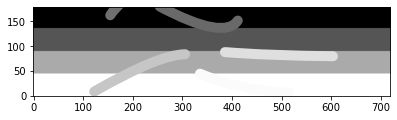

0.00415022383664661
Processing: WE=0.0, WG=3.0, WI=0.0, Species=0
Processing: WE=0.0, WG=3.0, WI=0.0, Species=1
Processing: WE=0.0, WG=3.0, WI=0.0, Species=2
Processing: WE=0.0, WG=3.0, WI=0.0, Species=3
Processing: WE=0.0, WG=3.0, WI=0.0, Species=4


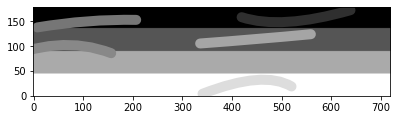

0.005177166360570446
Processing: WE=0.0, WG=3.0, WI=0.5, Species=0
Processing: WE=0.0, WG=3.0, WI=0.5, Species=1
Processing: WE=0.0, WG=3.0, WI=0.5, Species=2
Processing: WE=0.0, WG=3.0, WI=0.5, Species=3
Processing: WE=0.0, WG=3.0, WI=0.5, Species=4


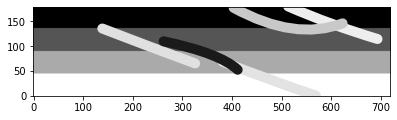

0.004286907245940742
Processing: WE=0.0, WG=3.0, WI=1.0, Species=0
Processing: WE=0.0, WG=3.0, WI=1.0, Species=1
Processing: WE=0.0, WG=3.0, WI=1.0, Species=2
Processing: WE=0.0, WG=3.0, WI=1.0, Species=3
Processing: WE=0.0, WG=3.0, WI=1.0, Species=4


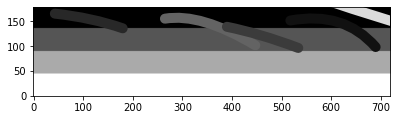

0.003975360162721574
Processing: WE=0.0, WG=3.0, WI=1.5, Species=0
Processing: WE=0.0, WG=3.0, WI=1.5, Species=1
Processing: WE=0.0, WG=3.0, WI=1.5, Species=2
Processing: WE=0.0, WG=3.0, WI=1.5, Species=3
Processing: WE=0.0, WG=3.0, WI=1.5, Species=4


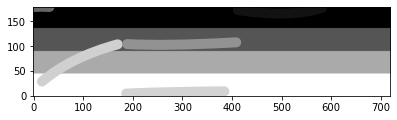

0.005024910442326603
Processing: WE=0.0, WG=3.0, WI=2.0, Species=0
Processing: WE=0.0, WG=3.0, WI=2.0, Species=1
Processing: WE=0.0, WG=3.0, WI=2.0, Species=2
Processing: WE=0.0, WG=3.0, WI=2.0, Species=3
Processing: WE=0.0, WG=3.0, WI=2.0, Species=4


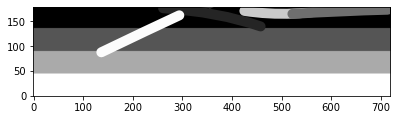

0.003374699324359517
Processing: WE=0.0, WG=3.0, WI=2.5, Species=0
Processing: WE=0.0, WG=3.0, WI=2.5, Species=1
Processing: WE=0.0, WG=3.0, WI=2.5, Species=2
Processing: WE=0.0, WG=3.0, WI=2.5, Species=3
Processing: WE=0.0, WG=3.0, WI=2.5, Species=4


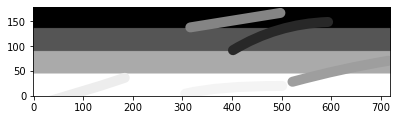

0.005360441321221274
Processing: WE=0.0, WG=3.0, WI=3.0, Species=0
Processing: WE=0.0, WG=3.0, WI=3.0, Species=1
Processing: WE=0.0, WG=3.0, WI=3.0, Species=2
Processing: WE=0.0, WG=3.0, WI=3.0, Species=3
Processing: WE=0.0, WG=3.0, WI=3.0, Species=4


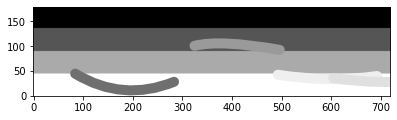

0.0031092786522172776
Processing: WE=0.0, WG=3.0, WI=3.5, Species=0
Processing: WE=0.0, WG=3.0, WI=3.5, Species=1
Processing: WE=0.0, WG=3.0, WI=3.5, Species=2
Processing: WE=0.0, WG=3.0, WI=3.5, Species=3
Processing: WE=0.0, WG=3.0, WI=3.5, Species=4


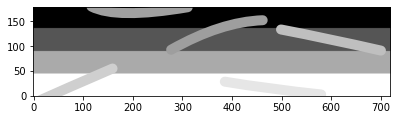

0.005509586613844174
Processing: WE=0.0, WG=3.0, WI=4.0, Species=0
Processing: WE=0.0, WG=3.0, WI=4.0, Species=1
Processing: WE=0.0, WG=3.0, WI=4.0, Species=2
Processing: WE=0.0, WG=3.0, WI=4.0, Species=3
Processing: WE=0.0, WG=3.0, WI=4.0, Species=4


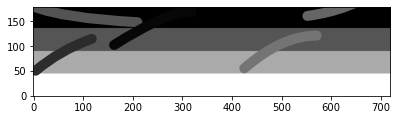

0.005370354623433816
Processing: WE=0.0, WG=3.5, WI=0.0, Species=0
Processing: WE=0.0, WG=3.5, WI=0.0, Species=1
Processing: WE=0.0, WG=3.5, WI=0.0, Species=2
Processing: WE=0.0, WG=3.5, WI=0.0, Species=3
Processing: WE=0.0, WG=3.5, WI=0.0, Species=4


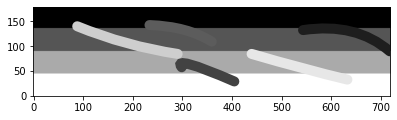

0.004912947300817605
Processing: WE=0.0, WG=3.5, WI=0.5, Species=0
Processing: WE=0.0, WG=3.5, WI=0.5, Species=1
Processing: WE=0.0, WG=3.5, WI=0.5, Species=2
Processing: WE=0.0, WG=3.5, WI=0.5, Species=3
Processing: WE=0.0, WG=3.5, WI=0.5, Species=4


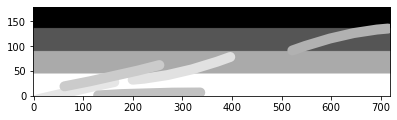

0.005281822923518098
Processing: WE=0.0, WG=3.5, WI=1.0, Species=0
Processing: WE=0.0, WG=3.5, WI=1.0, Species=1
Processing: WE=0.0, WG=3.5, WI=1.0, Species=2
Processing: WE=0.0, WG=3.5, WI=1.0, Species=3
Processing: WE=0.0, WG=3.5, WI=1.0, Species=4


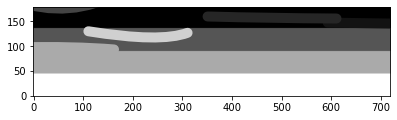

0.004047708857070387
Processing: WE=0.0, WG=3.5, WI=1.5, Species=0
Processing: WE=0.0, WG=3.5, WI=1.5, Species=1
Processing: WE=0.0, WG=3.5, WI=1.5, Species=2
Processing: WE=0.0, WG=3.5, WI=1.5, Species=3
Processing: WE=0.0, WG=3.5, WI=1.5, Species=4


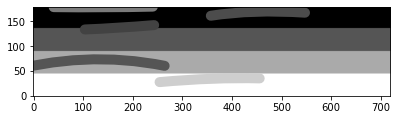

0.004264502989131949
Processing: WE=0.0, WG=3.5, WI=2.0, Species=0
Processing: WE=0.0, WG=3.5, WI=2.0, Species=1
Processing: WE=0.0, WG=3.5, WI=2.0, Species=2
Processing: WE=0.0, WG=3.5, WI=2.0, Species=3
Processing: WE=0.0, WG=3.5, WI=2.0, Species=4


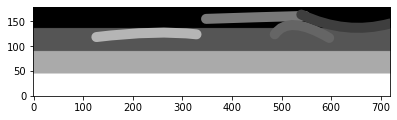

0.0018521207610760924
Processing: WE=0.0, WG=3.5, WI=2.5, Species=0
Processing: WE=0.0, WG=3.5, WI=2.5, Species=1
Processing: WE=0.0, WG=3.5, WI=2.5, Species=2
Processing: WE=0.0, WG=3.5, WI=2.5, Species=3
Processing: WE=0.0, WG=3.5, WI=2.5, Species=4


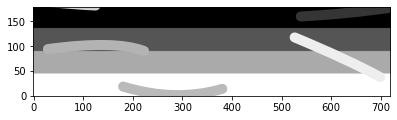

0.005665941580803467
Processing: WE=0.0, WG=3.5, WI=3.0, Species=0
Processing: WE=0.0, WG=3.5, WI=3.0, Species=1
Processing: WE=0.0, WG=3.5, WI=3.0, Species=2
Processing: WE=0.0, WG=3.5, WI=3.0, Species=3
Processing: WE=0.0, WG=3.5, WI=3.0, Species=4


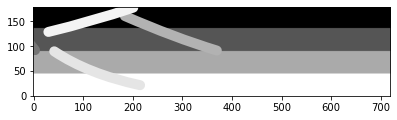

0.0047974762263653615
Processing: WE=0.0, WG=3.5, WI=3.5, Species=0
Processing: WE=0.0, WG=3.5, WI=3.5, Species=1
Processing: WE=0.0, WG=3.5, WI=3.5, Species=2
Processing: WE=0.0, WG=3.5, WI=3.5, Species=3
Processing: WE=0.0, WG=3.5, WI=3.5, Species=4


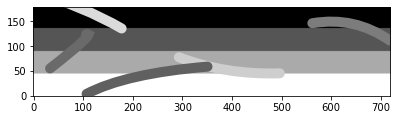

0.004457807537065261
Processing: WE=0.0, WG=3.5, WI=4.0, Species=0
Processing: WE=0.0, WG=3.5, WI=4.0, Species=1
Processing: WE=0.0, WG=3.5, WI=4.0, Species=2
Processing: WE=0.0, WG=3.5, WI=4.0, Species=3
Processing: WE=0.0, WG=3.5, WI=4.0, Species=4


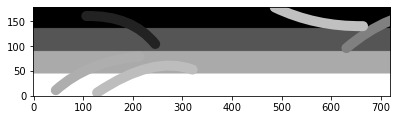

0.003101710432248563
Processing: WE=0.0, WG=4.0, WI=0.0, Species=0
Processing: WE=0.0, WG=4.0, WI=0.0, Species=1
Processing: WE=0.0, WG=4.0, WI=0.0, Species=2
Processing: WE=0.0, WG=4.0, WI=0.0, Species=3
Processing: WE=0.0, WG=4.0, WI=0.0, Species=4


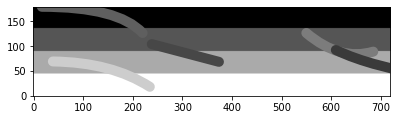

0.005065474550891313
Processing: WE=0.0, WG=4.0, WI=0.5, Species=0
Processing: WE=0.0, WG=4.0, WI=0.5, Species=1
Processing: WE=0.0, WG=4.0, WI=0.5, Species=2
Processing: WE=0.0, WG=4.0, WI=0.5, Species=3
Processing: WE=0.0, WG=4.0, WI=0.5, Species=4


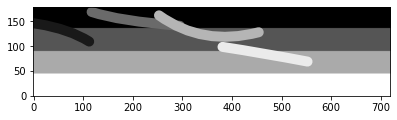

0.004405023805734162
Processing: WE=0.0, WG=4.0, WI=1.0, Species=0
Processing: WE=0.0, WG=4.0, WI=1.0, Species=1
Processing: WE=0.0, WG=4.0, WI=1.0, Species=2
Processing: WE=0.0, WG=4.0, WI=1.0, Species=3
Processing: WE=0.0, WG=4.0, WI=1.0, Species=4


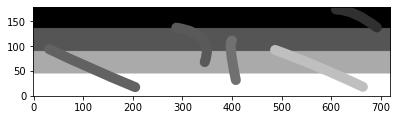

0.0034767394732334784
Processing: WE=0.0, WG=4.0, WI=1.5, Species=0
Processing: WE=0.0, WG=4.0, WI=1.5, Species=1
Processing: WE=0.0, WG=4.0, WI=1.5, Species=2
Processing: WE=0.0, WG=4.0, WI=1.5, Species=3
Processing: WE=0.0, WG=4.0, WI=1.5, Species=4


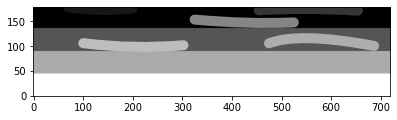

0.003335036425086856
Processing: WE=0.0, WG=4.0, WI=2.0, Species=0
Processing: WE=0.0, WG=4.0, WI=2.0, Species=1
Processing: WE=0.0, WG=4.0, WI=2.0, Species=2
Processing: WE=0.0, WG=4.0, WI=2.0, Species=3
Processing: WE=0.0, WG=4.0, WI=2.0, Species=4


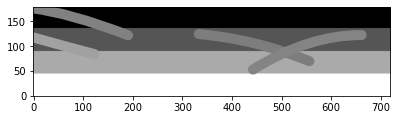

0.004428988220564675
Processing: WE=0.0, WG=4.0, WI=2.5, Species=0
Processing: WE=0.0, WG=4.0, WI=2.5, Species=1
Processing: WE=0.0, WG=4.0, WI=2.5, Species=2
Processing: WE=0.0, WG=4.0, WI=2.5, Species=3
Processing: WE=0.0, WG=4.0, WI=2.5, Species=4


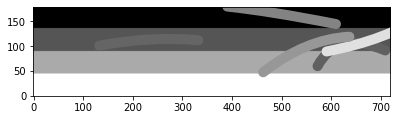

0.0023690369682350374
Processing: WE=0.0, WG=4.0, WI=3.0, Species=0
Processing: WE=0.0, WG=4.0, WI=3.0, Species=1
Processing: WE=0.0, WG=4.0, WI=3.0, Species=2
Processing: WE=0.0, WG=4.0, WI=3.0, Species=3
Processing: WE=0.0, WG=4.0, WI=3.0, Species=4


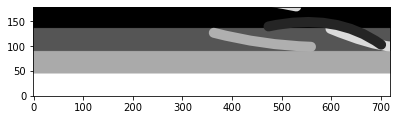

0.0030305730407116454
Processing: WE=0.0, WG=4.0, WI=3.5, Species=0
Processing: WE=0.0, WG=4.0, WI=3.5, Species=1
Processing: WE=0.0, WG=4.0, WI=3.5, Species=2
Processing: WE=0.0, WG=4.0, WI=3.5, Species=3
Processing: WE=0.0, WG=4.0, WI=3.5, Species=4


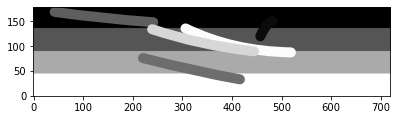

0.004837168196905509
Processing: WE=0.0, WG=4.0, WI=4.0, Species=0
Processing: WE=0.0, WG=4.0, WI=4.0, Species=1
Processing: WE=0.0, WG=4.0, WI=4.0, Species=2
Processing: WE=0.0, WG=4.0, WI=4.0, Species=3
Processing: WE=0.0, WG=4.0, WI=4.0, Species=4


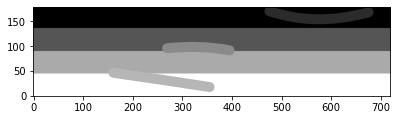

0.0041839755781972274
Processing: WE=0.5, WG=0.0, WI=0.0, Species=0
Processing: WE=0.5, WG=0.0, WI=0.0, Species=1
Processing: WE=0.5, WG=0.0, WI=0.0, Species=2
Processing: WE=0.5, WG=0.0, WI=0.0, Species=3
Processing: WE=0.5, WG=0.0, WI=0.0, Species=4


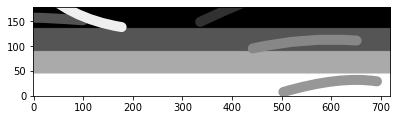

0.004071101536973686
Processing: WE=0.5, WG=0.0, WI=0.5, Species=0
Processing: WE=0.5, WG=0.0, WI=0.5, Species=1
Processing: WE=0.5, WG=0.0, WI=0.5, Species=2
Processing: WE=0.5, WG=0.0, WI=0.5, Species=3
Processing: WE=0.5, WG=0.0, WI=0.5, Species=4


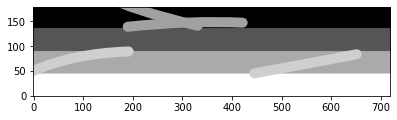

0.0034626883606155064
Processing: WE=0.5, WG=0.0, WI=1.0, Species=0
Processing: WE=0.5, WG=0.0, WI=1.0, Species=1
Processing: WE=0.5, WG=0.0, WI=1.0, Species=2
Processing: WE=0.5, WG=0.0, WI=1.0, Species=3
Processing: WE=0.5, WG=0.0, WI=1.0, Species=4


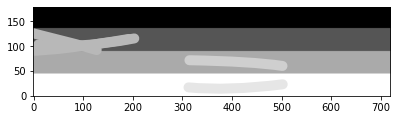

0.003641350680158642
Processing: WE=0.5, WG=0.0, WI=1.5, Species=0
Processing: WE=0.5, WG=0.0, WI=1.5, Species=1
Processing: WE=0.5, WG=0.0, WI=1.5, Species=2
Processing: WE=0.5, WG=0.0, WI=1.5, Species=3
Processing: WE=0.5, WG=0.0, WI=1.5, Species=4


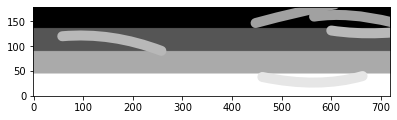

0.003968179559652667
Processing: WE=0.5, WG=0.0, WI=2.0, Species=0
Processing: WE=0.5, WG=0.0, WI=2.0, Species=1
Processing: WE=0.5, WG=0.0, WI=2.0, Species=2
Processing: WE=0.5, WG=0.0, WI=2.0, Species=3
Processing: WE=0.5, WG=0.0, WI=2.0, Species=4


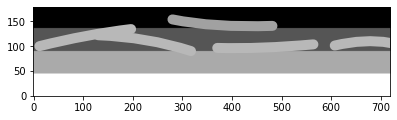

0.004336677255875849
Processing: WE=0.5, WG=0.0, WI=2.5, Species=0
Processing: WE=0.5, WG=0.0, WI=2.5, Species=1
Processing: WE=0.5, WG=0.0, WI=2.5, Species=2
Processing: WE=0.5, WG=0.0, WI=2.5, Species=3
Processing: WE=0.5, WG=0.0, WI=2.5, Species=4


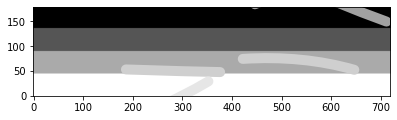

0.002754560736782203
Processing: WE=0.5, WG=0.0, WI=3.0, Species=0
Processing: WE=0.5, WG=0.0, WI=3.0, Species=1
Processing: WE=0.5, WG=0.0, WI=3.0, Species=2
Processing: WE=0.5, WG=0.0, WI=3.0, Species=3
Processing: WE=0.5, WG=0.0, WI=3.0, Species=4


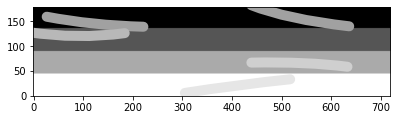

0.004943520583789813
Processing: WE=0.5, WG=0.0, WI=3.5, Species=0
Processing: WE=0.5, WG=0.0, WI=3.5, Species=1
Processing: WE=0.5, WG=0.0, WI=3.5, Species=2
Processing: WE=0.5, WG=0.0, WI=3.5, Species=3
Processing: WE=0.5, WG=0.0, WI=3.5, Species=4


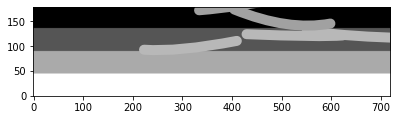

0.003500364723276662
Processing: WE=0.5, WG=0.0, WI=4.0, Species=0
Processing: WE=0.5, WG=0.0, WI=4.0, Species=1
Processing: WE=0.5, WG=0.0, WI=4.0, Species=2
Processing: WE=0.5, WG=0.0, WI=4.0, Species=3
Processing: WE=0.5, WG=0.0, WI=4.0, Species=4


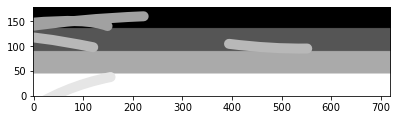

0.003255381152176699
Processing: WE=0.5, WG=0.5, WI=0.0, Species=0
Processing: WE=0.5, WG=0.5, WI=0.0, Species=1
Processing: WE=0.5, WG=0.5, WI=0.0, Species=2
Processing: WE=0.5, WG=0.5, WI=0.0, Species=3
Processing: WE=0.5, WG=0.5, WI=0.0, Species=4


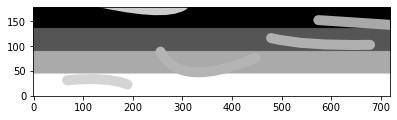

0.004222698506487859
Processing: WE=0.5, WG=0.5, WI=0.5, Species=0
Processing: WE=0.5, WG=0.5, WI=0.5, Species=1
Processing: WE=0.5, WG=0.5, WI=0.5, Species=2
Processing: WE=0.5, WG=0.5, WI=0.5, Species=3
Processing: WE=0.5, WG=0.5, WI=0.5, Species=4


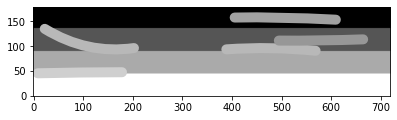

0.0037656981816164446
Processing: WE=0.5, WG=0.5, WI=1.0, Species=0
Processing: WE=0.5, WG=0.5, WI=1.0, Species=1
Processing: WE=0.5, WG=0.5, WI=1.0, Species=2
Processing: WE=0.5, WG=0.5, WI=1.0, Species=3
Processing: WE=0.5, WG=0.5, WI=1.0, Species=4


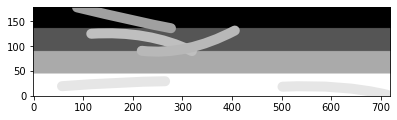

0.006116071396125818
Processing: WE=0.5, WG=0.5, WI=1.5, Species=0
Processing: WE=0.5, WG=0.5, WI=1.5, Species=1
Processing: WE=0.5, WG=0.5, WI=1.5, Species=2
Processing: WE=0.5, WG=0.5, WI=1.5, Species=3
Processing: WE=0.5, WG=0.5, WI=1.5, Species=4


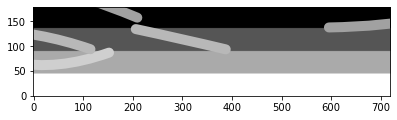

0.0033646891179220247
Processing: WE=0.5, WG=0.5, WI=2.0, Species=0
Processing: WE=0.5, WG=0.5, WI=2.0, Species=1
Processing: WE=0.5, WG=0.5, WI=2.0, Species=2
Processing: WE=0.5, WG=0.5, WI=2.0, Species=3
Processing: WE=0.5, WG=0.5, WI=2.0, Species=4


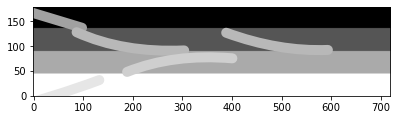

0.004503536640819887
Processing: WE=0.5, WG=0.5, WI=2.5, Species=0
Processing: WE=0.5, WG=0.5, WI=2.5, Species=1
Processing: WE=0.5, WG=0.5, WI=2.5, Species=2
Processing: WE=0.5, WG=0.5, WI=2.5, Species=3
Processing: WE=0.5, WG=0.5, WI=2.5, Species=4


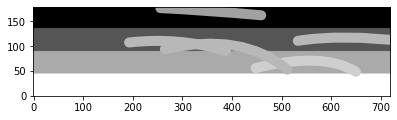

0.004680948895861148
Processing: WE=0.5, WG=0.5, WI=3.0, Species=0
Processing: WE=0.5, WG=0.5, WI=3.0, Species=1
Processing: WE=0.5, WG=0.5, WI=3.0, Species=2
Processing: WE=0.5, WG=0.5, WI=3.0, Species=3
Processing: WE=0.5, WG=0.5, WI=3.0, Species=4


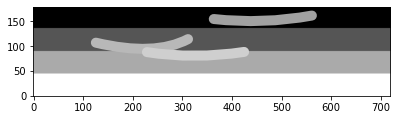

0.002756644177618661
Processing: WE=0.5, WG=0.5, WI=3.5, Species=0
Processing: WE=0.5, WG=0.5, WI=3.5, Species=1
Processing: WE=0.5, WG=0.5, WI=3.5, Species=2
Processing: WE=0.5, WG=0.5, WI=3.5, Species=3
Processing: WE=0.5, WG=0.5, WI=3.5, Species=4


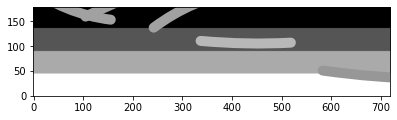

0.002346894352833613
Processing: WE=0.5, WG=0.5, WI=4.0, Species=0
Processing: WE=0.5, WG=0.5, WI=4.0, Species=1
Processing: WE=0.5, WG=0.5, WI=4.0, Species=2
Processing: WE=0.5, WG=0.5, WI=4.0, Species=3
Processing: WE=0.5, WG=0.5, WI=4.0, Species=4


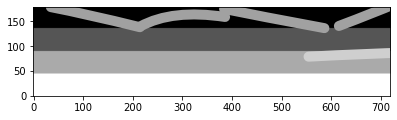

0.0037637504066949192
Processing: WE=0.5, WG=1.0, WI=0.0, Species=0
Processing: WE=0.5, WG=1.0, WI=0.0, Species=1
Processing: WE=0.5, WG=1.0, WI=0.0, Species=2
Processing: WE=0.5, WG=1.0, WI=0.0, Species=3
Processing: WE=0.5, WG=1.0, WI=0.0, Species=4


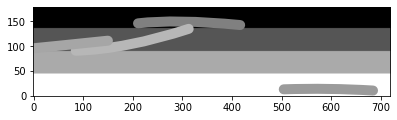

0.003287524283593121
Processing: WE=0.5, WG=1.0, WI=0.5, Species=0
Processing: WE=0.5, WG=1.0, WI=0.5, Species=1
Processing: WE=0.5, WG=1.0, WI=0.5, Species=2
Processing: WE=0.5, WG=1.0, WI=0.5, Species=3
Processing: WE=0.5, WG=1.0, WI=0.5, Species=4


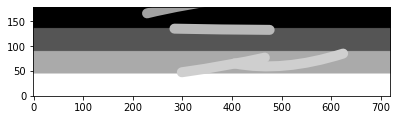

0.0031615778624236187
Processing: WE=0.5, WG=1.0, WI=1.0, Species=0
Processing: WE=0.5, WG=1.0, WI=1.0, Species=1
Processing: WE=0.5, WG=1.0, WI=1.0, Species=2
Processing: WE=0.5, WG=1.0, WI=1.0, Species=3
Processing: WE=0.5, WG=1.0, WI=1.0, Species=4


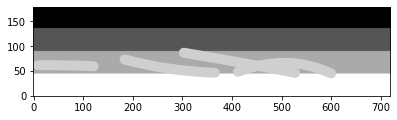

0.0032109311841914323
Processing: WE=0.5, WG=1.0, WI=1.5, Species=0
Processing: WE=0.5, WG=1.0, WI=1.5, Species=1
Processing: WE=0.5, WG=1.0, WI=1.5, Species=2
Processing: WE=0.5, WG=1.0, WI=1.5, Species=3
Processing: WE=0.5, WG=1.0, WI=1.5, Species=4


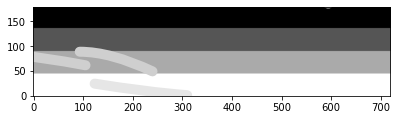

0.002414940499594577
Processing: WE=0.5, WG=1.0, WI=2.0, Species=0
Processing: WE=0.5, WG=1.0, WI=2.0, Species=1
Processing: WE=0.5, WG=1.0, WI=2.0, Species=2
Processing: WE=0.5, WG=1.0, WI=2.0, Species=3
Processing: WE=0.5, WG=1.0, WI=2.0, Species=4


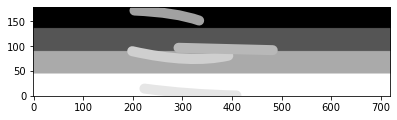

0.0036397129987569606
Processing: WE=0.5, WG=1.0, WI=2.5, Species=0
Processing: WE=0.5, WG=1.0, WI=2.5, Species=1
Processing: WE=0.5, WG=1.0, WI=2.5, Species=2
Processing: WE=0.5, WG=1.0, WI=2.5, Species=3
Processing: WE=0.5, WG=1.0, WI=2.5, Species=4


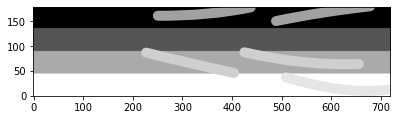

0.004748636496989792
Processing: WE=0.5, WG=1.0, WI=3.0, Species=0
Processing: WE=0.5, WG=1.0, WI=3.0, Species=1
Processing: WE=0.5, WG=1.0, WI=3.0, Species=2
Processing: WE=0.5, WG=1.0, WI=3.0, Species=3
Processing: WE=0.5, WG=1.0, WI=3.0, Species=4


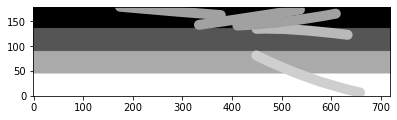

0.003317244809385756
Processing: WE=0.5, WG=1.0, WI=3.5, Species=0
Processing: WE=0.5, WG=1.0, WI=3.5, Species=1
Processing: WE=0.5, WG=1.0, WI=3.5, Species=2
Processing: WE=0.5, WG=1.0, WI=3.5, Species=3
Processing: WE=0.5, WG=1.0, WI=3.5, Species=4


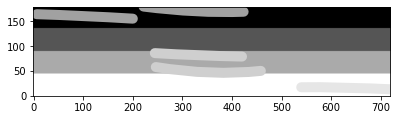

0.004418512873847415
Processing: WE=0.5, WG=1.0, WI=4.0, Species=0
Processing: WE=0.5, WG=1.0, WI=4.0, Species=1
Processing: WE=0.5, WG=1.0, WI=4.0, Species=2
Processing: WE=0.5, WG=1.0, WI=4.0, Species=3
Processing: WE=0.5, WG=1.0, WI=4.0, Species=4


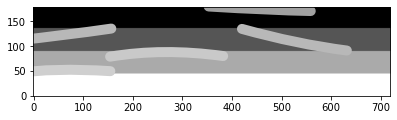

0.005246520714368256
Processing: WE=0.5, WG=1.5, WI=0.0, Species=0
Processing: WE=0.5, WG=1.5, WI=0.0, Species=1
Processing: WE=0.5, WG=1.5, WI=0.0, Species=2
Processing: WE=0.5, WG=1.5, WI=0.0, Species=3
Processing: WE=0.5, WG=1.5, WI=0.0, Species=4


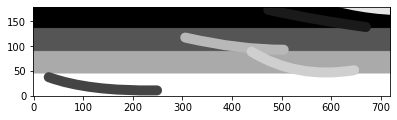

0.005832820346592496
Processing: WE=0.5, WG=1.5, WI=0.5, Species=0
Processing: WE=0.5, WG=1.5, WI=0.5, Species=1
Processing: WE=0.5, WG=1.5, WI=0.5, Species=2
Processing: WE=0.5, WG=1.5, WI=0.5, Species=3
Processing: WE=0.5, WG=1.5, WI=0.5, Species=4


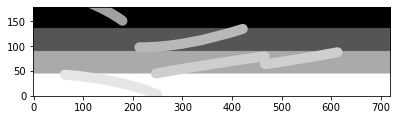

0.0036345480035670447
Processing: WE=0.5, WG=1.5, WI=1.0, Species=0
Processing: WE=0.5, WG=1.5, WI=1.0, Species=1
Processing: WE=0.5, WG=1.5, WI=1.0, Species=2
Processing: WE=0.5, WG=1.5, WI=1.0, Species=3
Processing: WE=0.5, WG=1.5, WI=1.0, Species=4


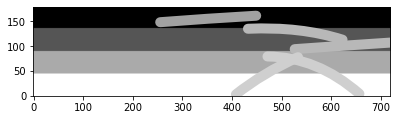

0.0037749428446768206
Processing: WE=0.5, WG=1.5, WI=1.5, Species=0
Processing: WE=0.5, WG=1.5, WI=1.5, Species=1
Processing: WE=0.5, WG=1.5, WI=1.5, Species=2
Processing: WE=0.5, WG=1.5, WI=1.5, Species=3
Processing: WE=0.5, WG=1.5, WI=1.5, Species=4


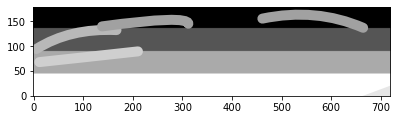

0.0037361520834287235
Processing: WE=0.5, WG=1.5, WI=2.0, Species=0
Processing: WE=0.5, WG=1.5, WI=2.0, Species=1
Processing: WE=0.5, WG=1.5, WI=2.0, Species=2
Processing: WE=0.5, WG=1.5, WI=2.0, Species=3
Processing: WE=0.5, WG=1.5, WI=2.0, Species=4


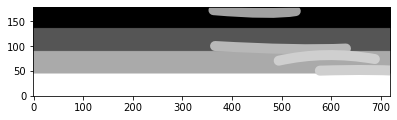

0.003533883894687396
Processing: WE=0.5, WG=1.5, WI=2.5, Species=0
Processing: WE=0.5, WG=1.5, WI=2.5, Species=1
Processing: WE=0.5, WG=1.5, WI=2.5, Species=2
Processing: WE=0.5, WG=1.5, WI=2.5, Species=3
Processing: WE=0.5, WG=1.5, WI=2.5, Species=4


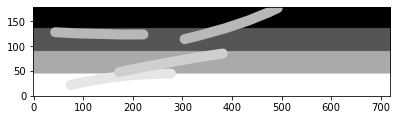

0.0038890766408247327
Processing: WE=0.5, WG=1.5, WI=3.0, Species=0
Processing: WE=0.5, WG=1.5, WI=3.0, Species=1
Processing: WE=0.5, WG=1.5, WI=3.0, Species=2
Processing: WE=0.5, WG=1.5, WI=3.0, Species=3
Processing: WE=0.5, WG=1.5, WI=3.0, Species=4


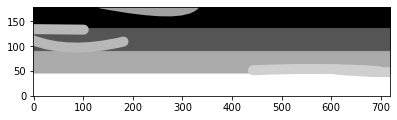

0.0031532440990777867
Processing: WE=0.5, WG=1.5, WI=3.5, Species=0
Processing: WE=0.5, WG=1.5, WI=3.5, Species=1
Processing: WE=0.5, WG=1.5, WI=3.5, Species=2
Processing: WE=0.5, WG=1.5, WI=3.5, Species=3
Processing: WE=0.5, WG=1.5, WI=3.5, Species=4


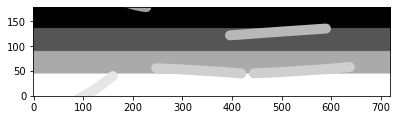

0.0031710841668913634
Processing: WE=0.5, WG=1.5, WI=4.0, Species=0
Processing: WE=0.5, WG=1.5, WI=4.0, Species=1
Processing: WE=0.5, WG=1.5, WI=4.0, Species=2
Processing: WE=0.5, WG=1.5, WI=4.0, Species=3
Processing: WE=0.5, WG=1.5, WI=4.0, Species=4


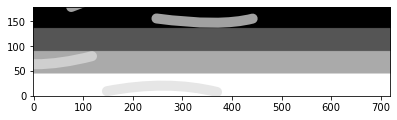

0.0028532189282053553
Processing: WE=0.5, WG=2.0, WI=0.0, Species=0
Processing: WE=0.5, WG=2.0, WI=0.0, Species=1
Processing: WE=0.5, WG=2.0, WI=0.0, Species=2
Processing: WE=0.5, WG=2.0, WI=0.0, Species=3
Processing: WE=0.5, WG=2.0, WI=0.0, Species=4


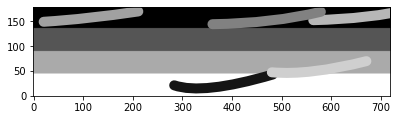

0.00564458388962415
Processing: WE=0.5, WG=2.0, WI=0.5, Species=0
Processing: WE=0.5, WG=2.0, WI=0.5, Species=1
Processing: WE=0.5, WG=2.0, WI=0.5, Species=2
Processing: WE=0.5, WG=2.0, WI=0.5, Species=3
Processing: WE=0.5, WG=2.0, WI=0.5, Species=4


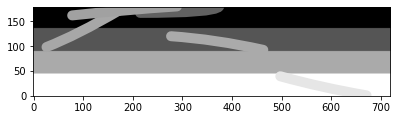

0.00437477999712679
Processing: WE=0.5, WG=2.0, WI=1.0, Species=0
Processing: WE=0.5, WG=2.0, WI=1.0, Species=1
Processing: WE=0.5, WG=2.0, WI=1.0, Species=2
Processing: WE=0.5, WG=2.0, WI=1.0, Species=3
Processing: WE=0.5, WG=2.0, WI=1.0, Species=4


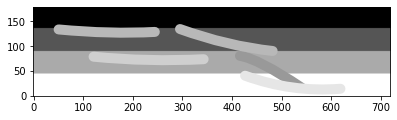

0.004908683514919738
Processing: WE=0.5, WG=2.0, WI=1.5, Species=0
Processing: WE=0.5, WG=2.0, WI=1.5, Species=1
Processing: WE=0.5, WG=2.0, WI=1.5, Species=2
Processing: WE=0.5, WG=2.0, WI=1.5, Species=3
Processing: WE=0.5, WG=2.0, WI=1.5, Species=4


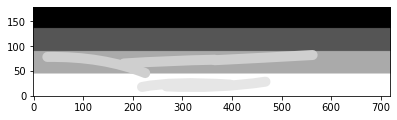

0.004490919710731198
Processing: WE=0.5, WG=2.0, WI=2.0, Species=0
Processing: WE=0.5, WG=2.0, WI=2.0, Species=1
Processing: WE=0.5, WG=2.0, WI=2.0, Species=2
Processing: WE=0.5, WG=2.0, WI=2.0, Species=3
Processing: WE=0.5, WG=2.0, WI=2.0, Species=4


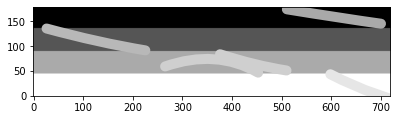

0.004697955587340142
Processing: WE=0.5, WG=2.0, WI=2.5, Species=0
Processing: WE=0.5, WG=2.0, WI=2.5, Species=1
Processing: WE=0.5, WG=2.0, WI=2.5, Species=2
Processing: WE=0.5, WG=2.0, WI=2.5, Species=3
Processing: WE=0.5, WG=2.0, WI=2.5, Species=4


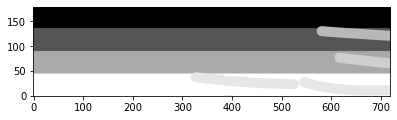

0.003517962530527859
Processing: WE=0.5, WG=2.0, WI=3.0, Species=0
Processing: WE=0.5, WG=2.0, WI=3.0, Species=1
Processing: WE=0.5, WG=2.0, WI=3.0, Species=2
Processing: WE=0.5, WG=2.0, WI=3.0, Species=3
Processing: WE=0.5, WG=2.0, WI=3.0, Species=4


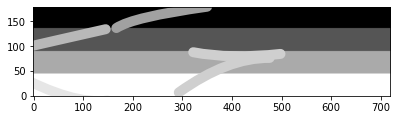

0.003337255531838247
Processing: WE=0.5, WG=2.0, WI=3.5, Species=0
Processing: WE=0.5, WG=2.0, WI=3.5, Species=1
Processing: WE=0.5, WG=2.0, WI=3.5, Species=2
Processing: WE=0.5, WG=2.0, WI=3.5, Species=3
Processing: WE=0.5, WG=2.0, WI=3.5, Species=4


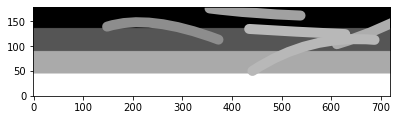

0.005338289015397355
Processing: WE=0.5, WG=2.0, WI=4.0, Species=0
Processing: WE=0.5, WG=2.0, WI=4.0, Species=1
Processing: WE=0.5, WG=2.0, WI=4.0, Species=2
Processing: WE=0.5, WG=2.0, WI=4.0, Species=3
Processing: WE=0.5, WG=2.0, WI=4.0, Species=4


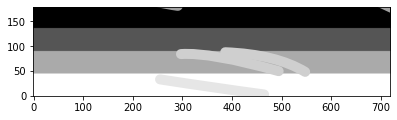

0.0031505695424691245
Processing: WE=0.5, WG=2.5, WI=0.0, Species=0
Processing: WE=0.5, WG=2.5, WI=0.0, Species=1
Processing: WE=0.5, WG=2.5, WI=0.0, Species=2
Processing: WE=0.5, WG=2.5, WI=0.0, Species=3
Processing: WE=0.5, WG=2.5, WI=0.0, Species=4


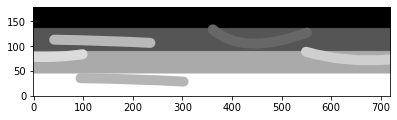

0.004287595265937898
Processing: WE=0.5, WG=2.5, WI=0.5, Species=0
Processing: WE=0.5, WG=2.5, WI=0.5, Species=1
Processing: WE=0.5, WG=2.5, WI=0.5, Species=2
Processing: WE=0.5, WG=2.5, WI=0.5, Species=3
Processing: WE=0.5, WG=2.5, WI=0.5, Species=4


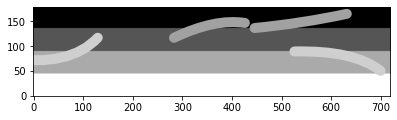

0.0034845111920745906
Processing: WE=0.5, WG=2.5, WI=1.0, Species=0
Processing: WE=0.5, WG=2.5, WI=1.0, Species=1
Processing: WE=0.5, WG=2.5, WI=1.0, Species=2
Processing: WE=0.5, WG=2.5, WI=1.0, Species=3
Processing: WE=0.5, WG=2.5, WI=1.0, Species=4


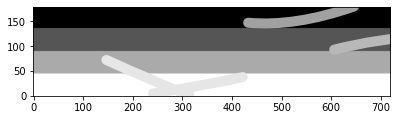

0.0031056931958940714
Processing: WE=0.5, WG=2.5, WI=1.5, Species=0
Processing: WE=0.5, WG=2.5, WI=1.5, Species=1
Processing: WE=0.5, WG=2.5, WI=1.5, Species=2
Processing: WE=0.5, WG=2.5, WI=1.5, Species=3
Processing: WE=0.5, WG=2.5, WI=1.5, Species=4


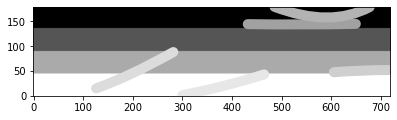

0.004450665695686333
Processing: WE=0.5, WG=2.5, WI=2.0, Species=0
Processing: WE=0.5, WG=2.5, WI=2.0, Species=1
Processing: WE=0.5, WG=2.5, WI=2.0, Species=2
Processing: WE=0.5, WG=2.5, WI=2.0, Species=3
Processing: WE=0.5, WG=2.5, WI=2.0, Species=4


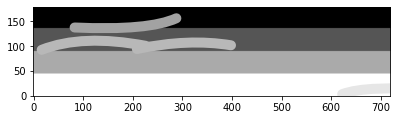

0.0036323288968156545
Processing: WE=0.5, WG=2.5, WI=2.5, Species=0
Processing: WE=0.5, WG=2.5, WI=2.5, Species=1
Processing: WE=0.5, WG=2.5, WI=2.5, Species=2
Processing: WE=0.5, WG=2.5, WI=2.5, Species=3
Processing: WE=0.5, WG=2.5, WI=2.5, Species=4


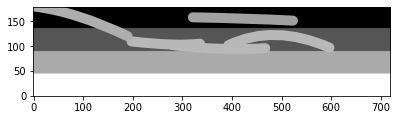

0.004268921821789739
Processing: WE=0.5, WG=2.5, WI=3.0, Species=0
Processing: WE=0.5, WG=2.5, WI=3.0, Species=1
Processing: WE=0.5, WG=2.5, WI=3.0, Species=2
Processing: WE=0.5, WG=2.5, WI=3.0, Species=3
Processing: WE=0.5, WG=2.5, WI=3.0, Species=4


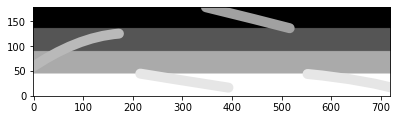

0.0036840660625172762
Processing: WE=0.5, WG=2.5, WI=3.5, Species=0
Processing: WE=0.5, WG=2.5, WI=3.5, Species=1
Processing: WE=0.5, WG=2.5, WI=3.5, Species=2
Processing: WE=0.5, WG=2.5, WI=3.5, Species=3
Processing: WE=0.5, WG=2.5, WI=3.5, Species=4


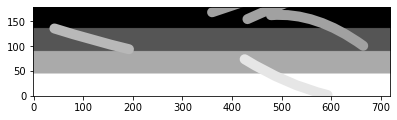

0.003188875782592464
Processing: WE=0.5, WG=2.5, WI=4.0, Species=0
Processing: WE=0.5, WG=2.5, WI=4.0, Species=1
Processing: WE=0.5, WG=2.5, WI=4.0, Species=2
Processing: WE=0.5, WG=2.5, WI=4.0, Species=3
Processing: WE=0.5, WG=2.5, WI=4.0, Species=4


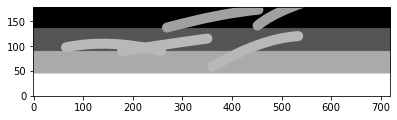

0.0040640565998197094
Processing: WE=0.5, WG=3.0, WI=0.0, Species=0
Processing: WE=0.5, WG=3.0, WI=0.0, Species=1
Processing: WE=0.5, WG=3.0, WI=0.0, Species=2
Processing: WE=0.5, WG=3.0, WI=0.0, Species=3
Processing: WE=0.5, WG=3.0, WI=0.0, Species=4


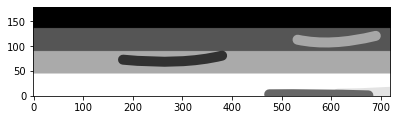

0.0019949478982321522
Processing: WE=0.5, WG=3.0, WI=0.5, Species=0
Processing: WE=0.5, WG=3.0, WI=0.5, Species=1
Processing: WE=0.5, WG=3.0, WI=0.5, Species=2
Processing: WE=0.5, WG=3.0, WI=0.5, Species=3
Processing: WE=0.5, WG=3.0, WI=0.5, Species=4


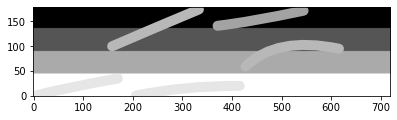

0.0061641552725467666
Processing: WE=0.5, WG=3.0, WI=1.0, Species=0
Processing: WE=0.5, WG=3.0, WI=1.0, Species=1
Processing: WE=0.5, WG=3.0, WI=1.0, Species=2
Processing: WE=0.5, WG=3.0, WI=1.0, Species=3
Processing: WE=0.5, WG=3.0, WI=1.0, Species=4


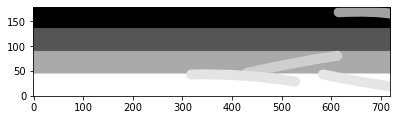

0.003941870062578326
Processing: WE=0.5, WG=3.0, WI=1.5, Species=0
Processing: WE=0.5, WG=3.0, WI=1.5, Species=1
Processing: WE=0.5, WG=3.0, WI=1.5, Species=2
Processing: WE=0.5, WG=3.0, WI=1.5, Species=3
Processing: WE=0.5, WG=3.0, WI=1.5, Species=4


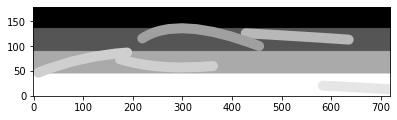

0.006204079813226797
Processing: WE=0.5, WG=3.0, WI=2.0, Species=0
Processing: WE=0.5, WG=3.0, WI=2.0, Species=1
Processing: WE=0.5, WG=3.0, WI=2.0, Species=2
Processing: WE=0.5, WG=3.0, WI=2.0, Species=3
Processing: WE=0.5, WG=3.0, WI=2.0, Species=4


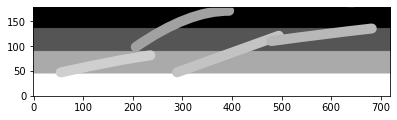

0.0041350292541742105
Processing: WE=0.5, WG=3.0, WI=2.5, Species=0
Processing: WE=0.5, WG=3.0, WI=2.5, Species=1
Processing: WE=0.5, WG=3.0, WI=2.5, Species=2
Processing: WE=0.5, WG=3.0, WI=2.5, Species=3
Processing: WE=0.5, WG=3.0, WI=2.5, Species=4


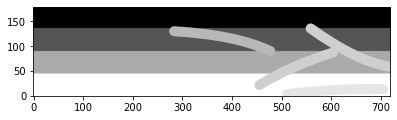

0.0035592146590897257
Processing: WE=0.5, WG=3.0, WI=3.0, Species=0
Processing: WE=0.5, WG=3.0, WI=3.0, Species=1
Processing: WE=0.5, WG=3.0, WI=3.0, Species=2
Processing: WE=0.5, WG=3.0, WI=3.0, Species=3
Processing: WE=0.5, WG=3.0, WI=3.0, Species=4


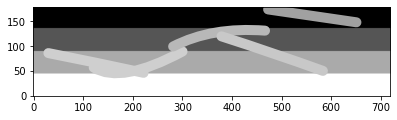

0.0048945645693443006
Processing: WE=0.5, WG=3.0, WI=3.5, Species=0
Processing: WE=0.5, WG=3.0, WI=3.5, Species=1
Processing: WE=0.5, WG=3.0, WI=3.5, Species=2
Processing: WE=0.5, WG=3.0, WI=3.5, Species=3
Processing: WE=0.5, WG=3.0, WI=3.5, Species=4


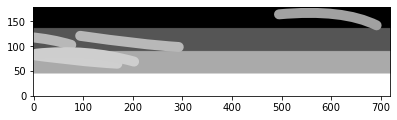

0.003068278474640285
Processing: WE=0.5, WG=3.0, WI=4.0, Species=0
Processing: WE=0.5, WG=3.0, WI=4.0, Species=1
Processing: WE=0.5, WG=3.0, WI=4.0, Species=2
Processing: WE=0.5, WG=3.0, WI=4.0, Species=3
Processing: WE=0.5, WG=3.0, WI=4.0, Species=4


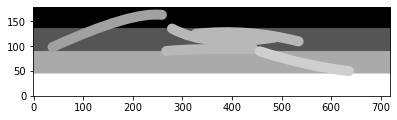

0.004978202605899966
Processing: WE=0.5, WG=3.5, WI=0.0, Species=0
Processing: WE=0.5, WG=3.5, WI=0.0, Species=1
Processing: WE=0.5, WG=3.5, WI=0.0, Species=2
Processing: WE=0.5, WG=3.5, WI=0.0, Species=3
Processing: WE=0.5, WG=3.5, WI=0.0, Species=4


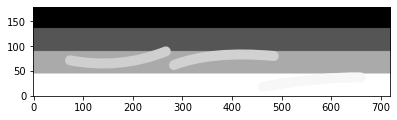

0.003990331865476586
Processing: WE=0.5, WG=3.5, WI=0.5, Species=0
Processing: WE=0.5, WG=3.5, WI=0.5, Species=1
Processing: WE=0.5, WG=3.5, WI=0.5, Species=2
Processing: WE=0.5, WG=3.5, WI=0.5, Species=3
Processing: WE=0.5, WG=3.5, WI=0.5, Species=4


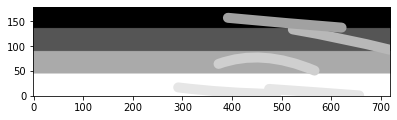

0.004944383031391881
Processing: WE=0.5, WG=3.5, WI=1.0, Species=0
Processing: WE=0.5, WG=3.5, WI=1.0, Species=1
Processing: WE=0.5, WG=3.5, WI=1.0, Species=2
Processing: WE=0.5, WG=3.5, WI=1.0, Species=3
Processing: WE=0.5, WG=3.5, WI=1.0, Species=4


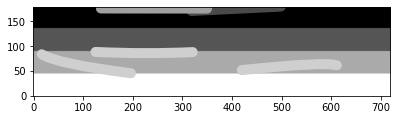

0.004128459147722497
Processing: WE=0.5, WG=3.5, WI=1.5, Species=0
Processing: WE=0.5, WG=3.5, WI=1.5, Species=1
Processing: WE=0.5, WG=3.5, WI=1.5, Species=2
Processing: WE=0.5, WG=3.5, WI=1.5, Species=3
Processing: WE=0.5, WG=3.5, WI=1.5, Species=4


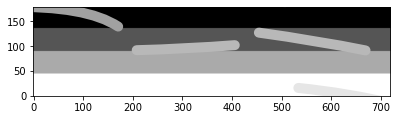

0.0036258653850113876
Processing: WE=0.5, WG=3.5, WI=2.0, Species=0
Processing: WE=0.5, WG=3.5, WI=2.0, Species=1
Processing: WE=0.5, WG=3.5, WI=2.0, Species=2
Processing: WE=0.5, WG=3.5, WI=2.0, Species=3
Processing: WE=0.5, WG=3.5, WI=2.0, Species=4


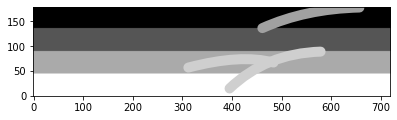

0.002383456316907825
Processing: WE=0.5, WG=3.5, WI=2.5, Species=0
Processing: WE=0.5, WG=3.5, WI=2.5, Species=1
Processing: WE=0.5, WG=3.5, WI=2.5, Species=2
Processing: WE=0.5, WG=3.5, WI=2.5, Species=3
Processing: WE=0.5, WG=3.5, WI=2.5, Species=4


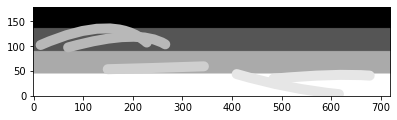

0.0050073513967653855
Processing: WE=0.5, WG=3.5, WI=3.0, Species=0
Processing: WE=0.5, WG=3.5, WI=3.0, Species=1
Processing: WE=0.5, WG=3.5, WI=3.0, Species=2
Processing: WE=0.5, WG=3.5, WI=3.0, Species=3
Processing: WE=0.5, WG=3.5, WI=3.0, Species=4


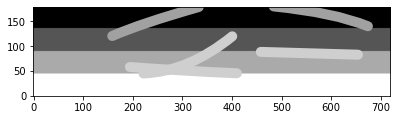

0.004216932705103243
Processing: WE=0.5, WG=3.5, WI=3.5, Species=0
Processing: WE=0.5, WG=3.5, WI=3.5, Species=1
Processing: WE=0.5, WG=3.5, WI=3.5, Species=2
Processing: WE=0.5, WG=3.5, WI=3.5, Species=3
Processing: WE=0.5, WG=3.5, WI=3.5, Species=4


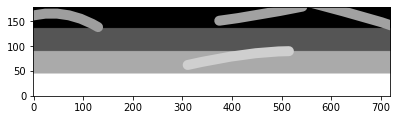

0.0031822959857182556
Processing: WE=0.5, WG=3.5, WI=4.0, Species=0
Processing: WE=0.5, WG=3.5, WI=4.0, Species=1
Processing: WE=0.5, WG=3.5, WI=4.0, Species=2
Processing: WE=0.5, WG=3.5, WI=4.0, Species=3
Processing: WE=0.5, WG=3.5, WI=4.0, Species=4


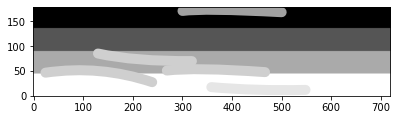

0.004402843460672753
Processing: WE=0.5, WG=4.0, WI=0.0, Species=0
Processing: WE=0.5, WG=4.0, WI=0.0, Species=1
Processing: WE=0.5, WG=4.0, WI=0.0, Species=2
Processing: WE=0.5, WG=4.0, WI=0.0, Species=3
Processing: WE=0.5, WG=4.0, WI=0.0, Species=4


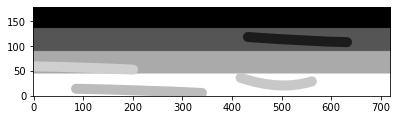

0.00496425808792944
Processing: WE=0.5, WG=4.0, WI=0.5, Species=0
Processing: WE=0.5, WG=4.0, WI=0.5, Species=1
Processing: WE=0.5, WG=4.0, WI=0.5, Species=2
Processing: WE=0.5, WG=4.0, WI=0.5, Species=3
Processing: WE=0.5, WG=4.0, WI=0.5, Species=4


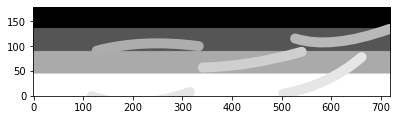

0.0038955886047414754
Processing: WE=0.5, WG=4.0, WI=1.0, Species=0
Processing: WE=0.5, WG=4.0, WI=1.0, Species=1
Processing: WE=0.5, WG=4.0, WI=1.0, Species=2
Processing: WE=0.5, WG=4.0, WI=1.0, Species=3
Processing: WE=0.5, WG=4.0, WI=1.0, Species=4


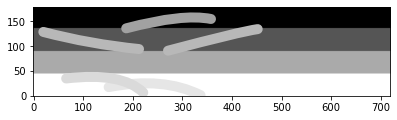

0.004547579611060357
Processing: WE=0.5, WG=4.0, WI=1.5, Species=0
Processing: WE=0.5, WG=4.0, WI=1.5, Species=1
Processing: WE=0.5, WG=4.0, WI=1.5, Species=2
Processing: WE=0.5, WG=4.0, WI=1.5, Species=3
Processing: WE=0.5, WG=4.0, WI=1.5, Species=4


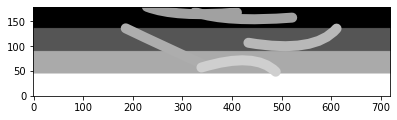

0.0035224782674106005
Processing: WE=0.5, WG=4.0, WI=2.0, Species=0
Processing: WE=0.5, WG=4.0, WI=2.0, Species=1
Processing: WE=0.5, WG=4.0, WI=2.0, Species=2
Processing: WE=0.5, WG=4.0, WI=2.0, Species=3
Processing: WE=0.5, WG=4.0, WI=2.0, Species=4


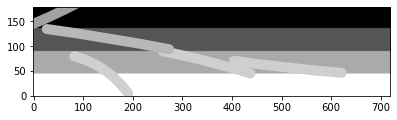

0.004512151426418078
Processing: WE=0.5, WG=4.0, WI=2.5, Species=0
Processing: WE=0.5, WG=4.0, WI=2.5, Species=1
Processing: WE=0.5, WG=4.0, WI=2.5, Species=2
Processing: WE=0.5, WG=4.0, WI=2.5, Species=3
Processing: WE=0.5, WG=4.0, WI=2.5, Species=4


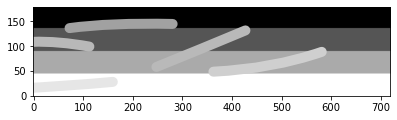

0.004958899284289621
Processing: WE=0.5, WG=4.0, WI=3.0, Species=0
Processing: WE=0.5, WG=4.0, WI=3.0, Species=1
Processing: WE=0.5, WG=4.0, WI=3.0, Species=2
Processing: WE=0.5, WG=4.0, WI=3.0, Species=3
Processing: WE=0.5, WG=4.0, WI=3.0, Species=4


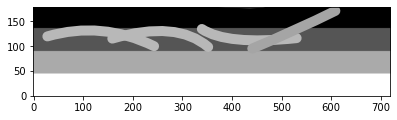

0.0033355887791690804
Processing: WE=0.5, WG=4.0, WI=3.5, Species=0
Processing: WE=0.5, WG=4.0, WI=3.5, Species=1
Processing: WE=0.5, WG=4.0, WI=3.5, Species=2
Processing: WE=0.5, WG=4.0, WI=3.5, Species=3
Processing: WE=0.5, WG=4.0, WI=3.5, Species=4


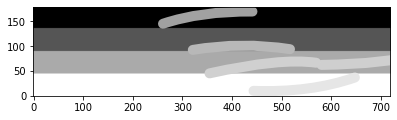

0.005636560219798163
Processing: WE=0.5, WG=4.0, WI=4.0, Species=0
Processing: WE=0.5, WG=4.0, WI=4.0, Species=1
Processing: WE=0.5, WG=4.0, WI=4.0, Species=2
Processing: WE=0.5, WG=4.0, WI=4.0, Species=3
Processing: WE=0.5, WG=4.0, WI=4.0, Species=4


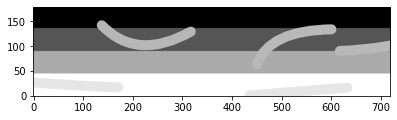

0.0052844102663243036
Processing: WE=1.0, WG=0.0, WI=0.0, Species=0
Processing: WE=1.0, WG=0.0, WI=0.0, Species=1
Processing: WE=1.0, WG=0.0, WI=0.0, Species=2
Processing: WE=1.0, WG=0.0, WI=0.0, Species=3
Processing: WE=1.0, WG=0.0, WI=0.0, Species=4


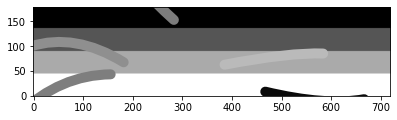

0.002070465360736879
Processing: WE=1.0, WG=0.0, WI=0.5, Species=0
Processing: WE=1.0, WG=0.0, WI=0.5, Species=1
Processing: WE=1.0, WG=0.0, WI=0.5, Species=2
Processing: WE=1.0, WG=0.0, WI=0.5, Species=3
Processing: WE=1.0, WG=0.0, WI=0.5, Species=4


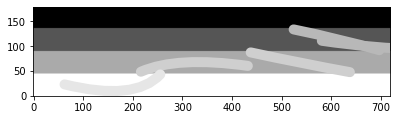

0.0044470414776731455
Processing: WE=1.0, WG=0.0, WI=1.0, Species=0
Processing: WE=1.0, WG=0.0, WI=1.0, Species=1
Processing: WE=1.0, WG=0.0, WI=1.0, Species=2
Processing: WE=1.0, WG=0.0, WI=1.0, Species=3
Processing: WE=1.0, WG=0.0, WI=1.0, Species=4


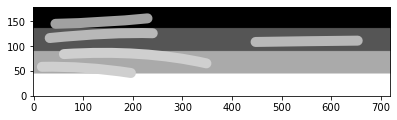

0.005120913457986083
Processing: WE=1.0, WG=0.0, WI=1.5, Species=0
Processing: WE=1.0, WG=0.0, WI=1.5, Species=1
Processing: WE=1.0, WG=0.0, WI=1.5, Species=2
Processing: WE=1.0, WG=0.0, WI=1.5, Species=3
Processing: WE=1.0, WG=0.0, WI=1.5, Species=4


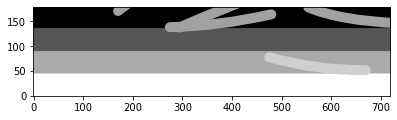

0.003046600999518628
Processing: WE=1.0, WG=0.0, WI=2.0, Species=0
Processing: WE=1.0, WG=0.0, WI=2.0, Species=1
Processing: WE=1.0, WG=0.0, WI=2.0, Species=2
Processing: WE=1.0, WG=0.0, WI=2.0, Species=3
Processing: WE=1.0, WG=0.0, WI=2.0, Species=4


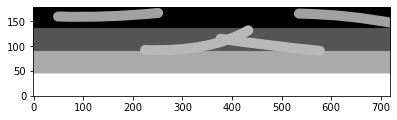

0.0037393693036971145
Processing: WE=1.0, WG=0.0, WI=2.5, Species=0
Processing: WE=1.0, WG=0.0, WI=2.5, Species=1
Processing: WE=1.0, WG=0.0, WI=2.5, Species=2
Processing: WE=1.0, WG=0.0, WI=2.5, Species=3
Processing: WE=1.0, WG=0.0, WI=2.5, Species=4


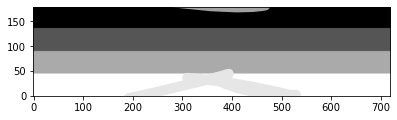

0.002511621844828718
Processing: WE=1.0, WG=0.0, WI=3.0, Species=0
Processing: WE=1.0, WG=0.0, WI=3.0, Species=1
Processing: WE=1.0, WG=0.0, WI=3.0, Species=2
Processing: WE=1.0, WG=0.0, WI=3.0, Species=3
Processing: WE=1.0, WG=0.0, WI=3.0, Species=4


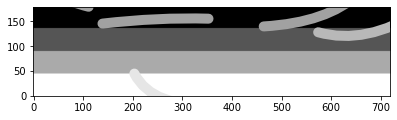

0.0028729583188279824
Processing: WE=1.0, WG=0.0, WI=3.5, Species=0
Processing: WE=1.0, WG=0.0, WI=3.5, Species=1
Processing: WE=1.0, WG=0.0, WI=3.5, Species=2
Processing: WE=1.0, WG=0.0, WI=3.5, Species=3
Processing: WE=1.0, WG=0.0, WI=3.5, Species=4


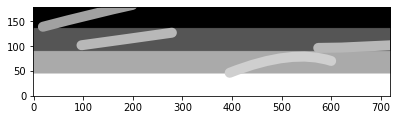

0.0033709975829663693
Processing: WE=1.0, WG=0.0, WI=4.0, Species=0
Processing: WE=1.0, WG=0.0, WI=4.0, Species=1
Processing: WE=1.0, WG=0.0, WI=4.0, Species=2
Processing: WE=1.0, WG=0.0, WI=4.0, Species=3
Processing: WE=1.0, WG=0.0, WI=4.0, Species=4


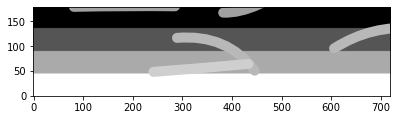

0.003144949097421936
Processing: WE=1.0, WG=0.5, WI=0.0, Species=0
Processing: WE=1.0, WG=0.5, WI=0.0, Species=1
Processing: WE=1.0, WG=0.5, WI=0.0, Species=2
Processing: WE=1.0, WG=0.5, WI=0.0, Species=3
Processing: WE=1.0, WG=0.5, WI=0.0, Species=4


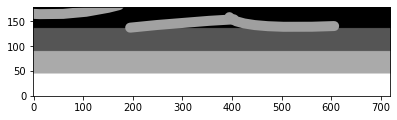

0.004366610970963376
Processing: WE=1.0, WG=0.5, WI=0.5, Species=0
Processing: WE=1.0, WG=0.5, WI=0.5, Species=1
Processing: WE=1.0, WG=0.5, WI=0.5, Species=2
Processing: WE=1.0, WG=0.5, WI=0.5, Species=3
Processing: WE=1.0, WG=0.5, WI=0.5, Species=4


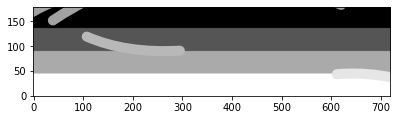

0.00220323383934297
Processing: WE=1.0, WG=0.5, WI=1.0, Species=0
Processing: WE=1.0, WG=0.5, WI=1.0, Species=1
Processing: WE=1.0, WG=0.5, WI=1.0, Species=2
Processing: WE=1.0, WG=0.5, WI=1.0, Species=3
Processing: WE=1.0, WG=0.5, WI=1.0, Species=4


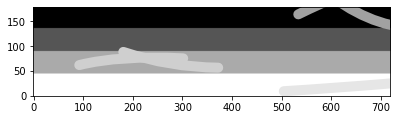

0.0035147937623719442
Processing: WE=1.0, WG=0.5, WI=1.5, Species=0
Processing: WE=1.0, WG=0.5, WI=1.5, Species=1
Processing: WE=1.0, WG=0.5, WI=1.5, Species=2
Processing: WE=1.0, WG=0.5, WI=1.5, Species=3
Processing: WE=1.0, WG=0.5, WI=1.5, Species=4


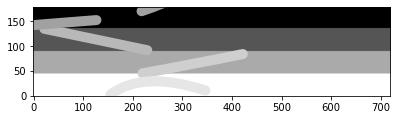

0.003856497440396028
Processing: WE=1.0, WG=0.5, WI=2.0, Species=0
Processing: WE=1.0, WG=0.5, WI=2.0, Species=1
Processing: WE=1.0, WG=0.5, WI=2.0, Species=2
Processing: WE=1.0, WG=0.5, WI=2.0, Species=3
Processing: WE=1.0, WG=0.5, WI=2.0, Species=4


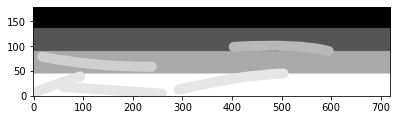

0.005061588691470756
Processing: WE=1.0, WG=0.5, WI=2.5, Species=0
Processing: WE=1.0, WG=0.5, WI=2.5, Species=1
Processing: WE=1.0, WG=0.5, WI=2.5, Species=2
Processing: WE=1.0, WG=0.5, WI=2.5, Species=3
Processing: WE=1.0, WG=0.5, WI=2.5, Species=4


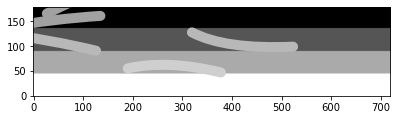

0.003291177572873794
Processing: WE=1.0, WG=0.5, WI=3.0, Species=0
Processing: WE=1.0, WG=0.5, WI=3.0, Species=1
Processing: WE=1.0, WG=0.5, WI=3.0, Species=2
Processing: WE=1.0, WG=0.5, WI=3.0, Species=3
Processing: WE=1.0, WG=0.5, WI=3.0, Species=4


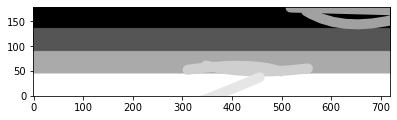

0.0030912738472212834
Processing: WE=1.0, WG=0.5, WI=3.5, Species=0
Processing: WE=1.0, WG=0.5, WI=3.5, Species=1
Processing: WE=1.0, WG=0.5, WI=3.5, Species=2
Processing: WE=1.0, WG=0.5, WI=3.5, Species=3
Processing: WE=1.0, WG=0.5, WI=3.5, Species=4


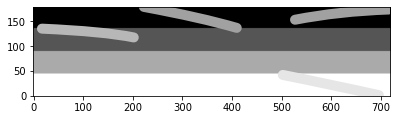

0.004004906260909296
Processing: WE=1.0, WG=0.5, WI=4.0, Species=0
Processing: WE=1.0, WG=0.5, WI=4.0, Species=1
Processing: WE=1.0, WG=0.5, WI=4.0, Species=2
Processing: WE=1.0, WG=0.5, WI=4.0, Species=3
Processing: WE=1.0, WG=0.5, WI=4.0, Species=4


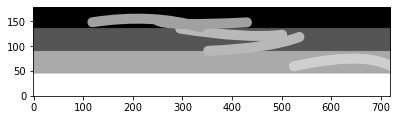

0.0042062150978236035
Processing: WE=1.0, WG=1.0, WI=0.0, Species=0
Processing: WE=1.0, WG=1.0, WI=0.0, Species=1
Processing: WE=1.0, WG=1.0, WI=0.0, Species=2
Processing: WE=1.0, WG=1.0, WI=0.0, Species=3
Processing: WE=1.0, WG=1.0, WI=0.0, Species=4


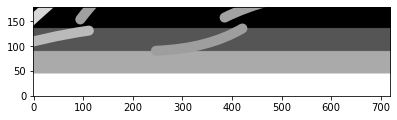

0.0039077791562403775
Processing: WE=1.0, WG=1.0, WI=0.5, Species=0
Processing: WE=1.0, WG=1.0, WI=0.5, Species=1
Processing: WE=1.0, WG=1.0, WI=0.5, Species=2
Processing: WE=1.0, WG=1.0, WI=0.5, Species=3
Processing: WE=1.0, WG=1.0, WI=0.5, Species=4


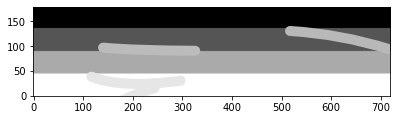

0.0034596940200645044
Processing: WE=1.0, WG=1.0, WI=1.0, Species=0
Processing: WE=1.0, WG=1.0, WI=1.0, Species=1
Processing: WE=1.0, WG=1.0, WI=1.0, Species=2
Processing: WE=1.0, WG=1.0, WI=1.0, Species=3
Processing: WE=1.0, WG=1.0, WI=1.0, Species=4


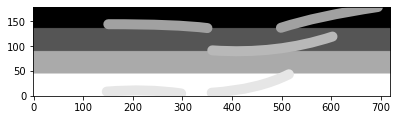

0.005406247948355862
Processing: WE=1.0, WG=1.0, WI=1.5, Species=0
Processing: WE=1.0, WG=1.0, WI=1.5, Species=1
Processing: WE=1.0, WG=1.0, WI=1.5, Species=2
Processing: WE=1.0, WG=1.0, WI=1.5, Species=3
Processing: WE=1.0, WG=1.0, WI=1.5, Species=4


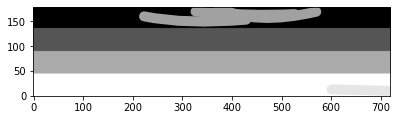

0.0025434161210353147
Processing: WE=1.0, WG=1.0, WI=2.0, Species=0
Processing: WE=1.0, WG=1.0, WI=2.0, Species=1
Processing: WE=1.0, WG=1.0, WI=2.0, Species=2
Processing: WE=1.0, WG=1.0, WI=2.0, Species=3
Processing: WE=1.0, WG=1.0, WI=2.0, Species=4


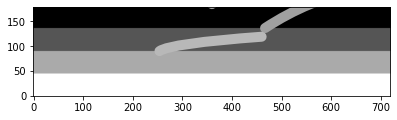

0.0012360909126367227
Processing: WE=1.0, WG=1.0, WI=2.5, Species=0
Processing: WE=1.0, WG=1.0, WI=2.5, Species=1
Processing: WE=1.0, WG=1.0, WI=2.5, Species=2
Processing: WE=1.0, WG=1.0, WI=2.5, Species=3
Processing: WE=1.0, WG=1.0, WI=2.5, Species=4


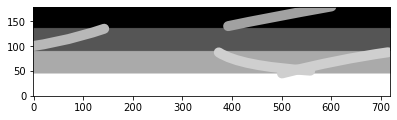

0.0033514035486811697
Processing: WE=1.0, WG=1.0, WI=3.0, Species=0
Processing: WE=1.0, WG=1.0, WI=3.0, Species=1
Processing: WE=1.0, WG=1.0, WI=3.0, Species=2
Processing: WE=1.0, WG=1.0, WI=3.0, Species=3
Processing: WE=1.0, WG=1.0, WI=3.0, Species=4


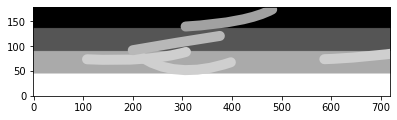

0.004269571080096914
Processing: WE=1.0, WG=1.0, WI=3.5, Species=0
Processing: WE=1.0, WG=1.0, WI=3.5, Species=1
Processing: WE=1.0, WG=1.0, WI=3.5, Species=2
Processing: WE=1.0, WG=1.0, WI=3.5, Species=3
Processing: WE=1.0, WG=1.0, WI=3.5, Species=4


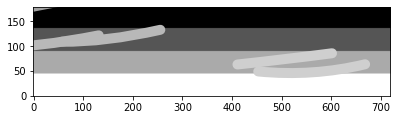

0.0032137995492499977
Processing: WE=1.0, WG=1.0, WI=4.0, Species=0
Processing: WE=1.0, WG=1.0, WI=4.0, Species=1
Processing: WE=1.0, WG=1.0, WI=4.0, Species=2
Processing: WE=1.0, WG=1.0, WI=4.0, Species=3
Processing: WE=1.0, WG=1.0, WI=4.0, Species=4


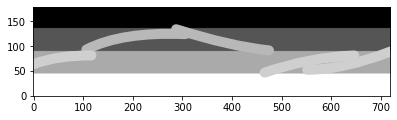

0.004137287122615581
Processing: WE=1.0, WG=1.5, WI=0.0, Species=0
Processing: WE=1.0, WG=1.5, WI=0.0, Species=1
Processing: WE=1.0, WG=1.5, WI=0.0, Species=2
Processing: WE=1.0, WG=1.5, WI=0.0, Species=3
Processing: WE=1.0, WG=1.5, WI=0.0, Species=4


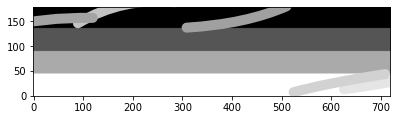

0.004962232789627953
Processing: WE=1.0, WG=1.5, WI=0.5, Species=0
Processing: WE=1.0, WG=1.5, WI=0.5, Species=1
Processing: WE=1.0, WG=1.5, WI=0.5, Species=2
Processing: WE=1.0, WG=1.5, WI=0.5, Species=3
Processing: WE=1.0, WG=1.5, WI=0.5, Species=4


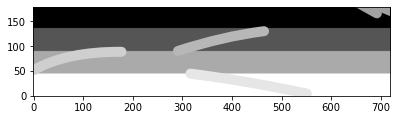

0.0037455517932490218
Processing: WE=1.0, WG=1.5, WI=1.0, Species=0
Processing: WE=1.0, WG=1.5, WI=1.0, Species=1
Processing: WE=1.0, WG=1.5, WI=1.0, Species=2
Processing: WE=1.0, WG=1.5, WI=1.0, Species=3
Processing: WE=1.0, WG=1.5, WI=1.0, Species=4


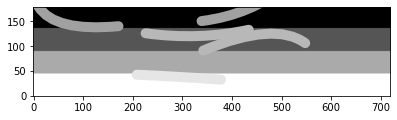

0.004300803311798792
Processing: WE=1.0, WG=1.5, WI=1.5, Species=0
Processing: WE=1.0, WG=1.5, WI=1.5, Species=1
Processing: WE=1.0, WG=1.5, WI=1.5, Species=2
Processing: WE=1.0, WG=1.5, WI=1.5, Species=3
Processing: WE=1.0, WG=1.5, WI=1.5, Species=4


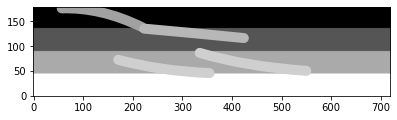

0.003963188992067663
Processing: WE=1.0, WG=1.5, WI=2.0, Species=0
Processing: WE=1.0, WG=1.5, WI=2.0, Species=1
Processing: WE=1.0, WG=1.5, WI=2.0, Species=2
Processing: WE=1.0, WG=1.5, WI=2.0, Species=3
Processing: WE=1.0, WG=1.5, WI=2.0, Species=4


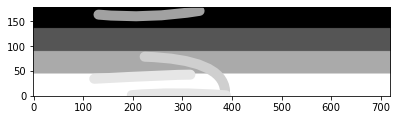

0.0035715021148135795
Processing: WE=1.0, WG=1.5, WI=2.5, Species=0
Processing: WE=1.0, WG=1.5, WI=2.5, Species=1
Processing: WE=1.0, WG=1.5, WI=2.5, Species=2
Processing: WE=1.0, WG=1.5, WI=2.5, Species=3
Processing: WE=1.0, WG=1.5, WI=2.5, Species=4


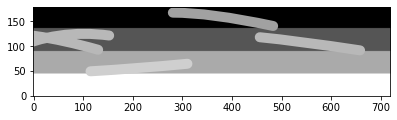

0.003976988153700761
Processing: WE=1.0, WG=1.5, WI=3.0, Species=0
Processing: WE=1.0, WG=1.5, WI=3.0, Species=1
Processing: WE=1.0, WG=1.5, WI=3.0, Species=2
Processing: WE=1.0, WG=1.5, WI=3.0, Species=3
Processing: WE=1.0, WG=1.5, WI=3.0, Species=4


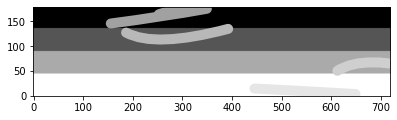

0.0035441557425322577
Processing: WE=1.0, WG=1.5, WI=3.5, Species=0
Processing: WE=1.0, WG=1.5, WI=3.5, Species=1
Processing: WE=1.0, WG=1.5, WI=3.5, Species=2
Processing: WE=1.0, WG=1.5, WI=3.5, Species=3
Processing: WE=1.0, WG=1.5, WI=3.5, Species=4


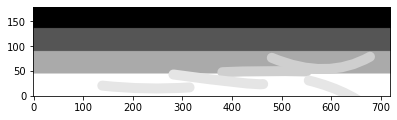

0.004736814181545705
Processing: WE=1.0, WG=1.5, WI=4.0, Species=0
Processing: WE=1.0, WG=1.5, WI=4.0, Species=1
Processing: WE=1.0, WG=1.5, WI=4.0, Species=2
Processing: WE=1.0, WG=1.5, WI=4.0, Species=3
Processing: WE=1.0, WG=1.5, WI=4.0, Species=4


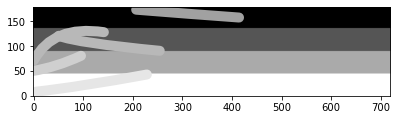

0.004452128949483101
Processing: WE=1.0, WG=2.0, WI=0.0, Species=0
Processing: WE=1.0, WG=2.0, WI=0.0, Species=1
Processing: WE=1.0, WG=2.0, WI=0.0, Species=2
Processing: WE=1.0, WG=2.0, WI=0.0, Species=3
Processing: WE=1.0, WG=2.0, WI=0.0, Species=4


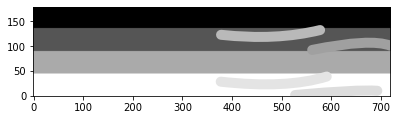

0.005722775908737539
Processing: WE=1.0, WG=2.0, WI=0.5, Species=0
Processing: WE=1.0, WG=2.0, WI=0.5, Species=1
Processing: WE=1.0, WG=2.0, WI=0.5, Species=2
Processing: WE=1.0, WG=2.0, WI=0.5, Species=3
Processing: WE=1.0, WG=2.0, WI=0.5, Species=4


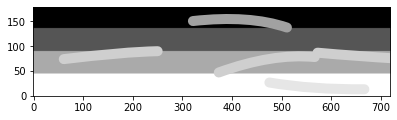

0.004823998912734597
Processing: WE=1.0, WG=2.0, WI=1.0, Species=0
Processing: WE=1.0, WG=2.0, WI=1.0, Species=1
Processing: WE=1.0, WG=2.0, WI=1.0, Species=2
Processing: WE=1.0, WG=2.0, WI=1.0, Species=3
Processing: WE=1.0, WG=2.0, WI=1.0, Species=4


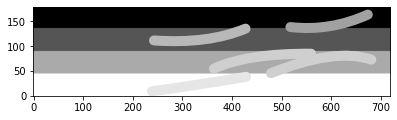

0.005119362990386859
Processing: WE=1.0, WG=2.0, WI=1.5, Species=0
Processing: WE=1.0, WG=2.0, WI=1.5, Species=1
Processing: WE=1.0, WG=2.0, WI=1.5, Species=2
Processing: WE=1.0, WG=2.0, WI=1.5, Species=3
Processing: WE=1.0, WG=2.0, WI=1.5, Species=4


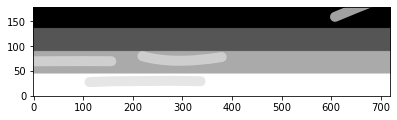

0.0026059096557065563
Processing: WE=1.0, WG=2.0, WI=2.0, Species=0
Processing: WE=1.0, WG=2.0, WI=2.0, Species=1
Processing: WE=1.0, WG=2.0, WI=2.0, Species=2
Processing: WE=1.0, WG=2.0, WI=2.0, Species=3
Processing: WE=1.0, WG=2.0, WI=2.0, Species=4


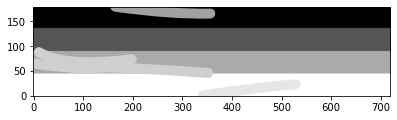

0.004015187799176654
Processing: WE=1.0, WG=2.0, WI=2.5, Species=0
Processing: WE=1.0, WG=2.0, WI=2.5, Species=1
Processing: WE=1.0, WG=2.0, WI=2.5, Species=2
Processing: WE=1.0, WG=2.0, WI=2.5, Species=3
Processing: WE=1.0, WG=2.0, WI=2.5, Species=4


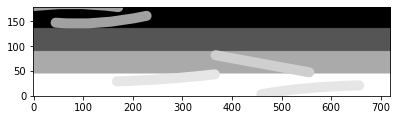

0.0043601377687366135
Processing: WE=1.0, WG=2.0, WI=3.0, Species=0
Processing: WE=1.0, WG=2.0, WI=3.0, Species=1
Processing: WE=1.0, WG=2.0, WI=3.0, Species=2
Processing: WE=1.0, WG=2.0, WI=3.0, Species=3
Processing: WE=1.0, WG=2.0, WI=3.0, Species=4


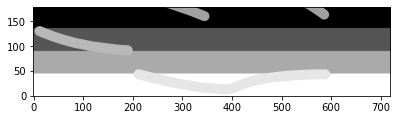

0.0034785515822400724
Processing: WE=1.0, WG=2.0, WI=3.5, Species=0
Processing: WE=1.0, WG=2.0, WI=3.5, Species=1
Processing: WE=1.0, WG=2.0, WI=3.5, Species=2
Processing: WE=1.0, WG=2.0, WI=3.5, Species=3
Processing: WE=1.0, WG=2.0, WI=3.5, Species=4


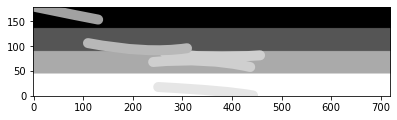

0.004305968306988709
Processing: WE=1.0, WG=2.0, WI=4.0, Species=0
Processing: WE=1.0, WG=2.0, WI=4.0, Species=1
Processing: WE=1.0, WG=2.0, WI=4.0, Species=2
Processing: WE=1.0, WG=2.0, WI=4.0, Species=3
Processing: WE=1.0, WG=2.0, WI=4.0, Species=4


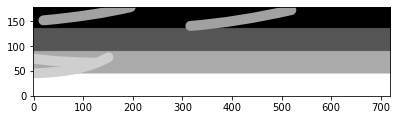

0.002711438356678772
Processing: WE=1.0, WG=2.5, WI=0.0, Species=0
Processing: WE=1.0, WG=2.5, WI=0.0, Species=1
Processing: WE=1.0, WG=2.5, WI=0.0, Species=2
Processing: WE=1.0, WG=2.5, WI=0.0, Species=3
Processing: WE=1.0, WG=2.5, WI=0.0, Species=4


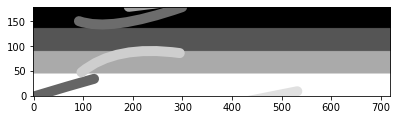

0.0038318740768358444
Processing: WE=1.0, WG=2.5, WI=0.5, Species=0
Processing: WE=1.0, WG=2.5, WI=0.5, Species=1
Processing: WE=1.0, WG=2.5, WI=0.5, Species=2
Processing: WE=1.0, WG=2.5, WI=0.5, Species=3
Processing: WE=1.0, WG=2.5, WI=0.5, Species=4


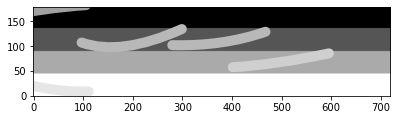

0.003824955115174305
Processing: WE=1.0, WG=2.5, WI=1.0, Species=0
Processing: WE=1.0, WG=2.5, WI=1.0, Species=1
Processing: WE=1.0, WG=2.5, WI=1.0, Species=2
Processing: WE=1.0, WG=2.5, WI=1.0, Species=3
Processing: WE=1.0, WG=2.5, WI=1.0, Species=4


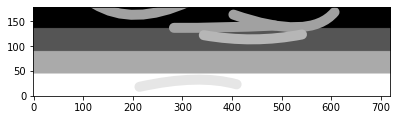

0.005976374265435692
Processing: WE=1.0, WG=2.5, WI=1.5, Species=0
Processing: WE=1.0, WG=2.5, WI=1.5, Species=1
Processing: WE=1.0, WG=2.5, WI=1.5, Species=2
Processing: WE=1.0, WG=2.5, WI=1.5, Species=3
Processing: WE=1.0, WG=2.5, WI=1.5, Species=4


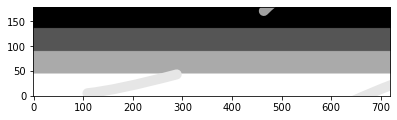

0.0015172003787986153
Processing: WE=1.0, WG=2.5, WI=2.0, Species=0
Processing: WE=1.0, WG=2.5, WI=2.0, Species=1
Processing: WE=1.0, WG=2.5, WI=2.0, Species=2
Processing: WE=1.0, WG=2.5, WI=2.0, Species=3
Processing: WE=1.0, WG=2.5, WI=2.0, Species=4


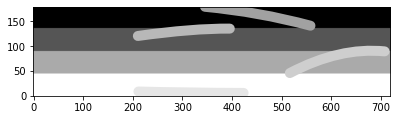

0.0035408706893064012
Processing: WE=1.0, WG=2.5, WI=2.5, Species=0
Processing: WE=1.0, WG=2.5, WI=2.5, Species=1
Processing: WE=1.0, WG=2.5, WI=2.5, Species=2
Processing: WE=1.0, WG=2.5, WI=2.5, Species=3
Processing: WE=1.0, WG=2.5, WI=2.5, Species=4


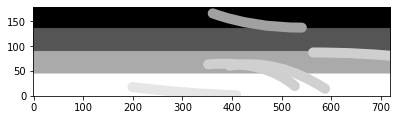

0.0049597714223141845
Processing: WE=1.0, WG=2.5, WI=3.0, Species=0
Processing: WE=1.0, WG=2.5, WI=3.0, Species=1
Processing: WE=1.0, WG=2.5, WI=3.0, Species=2
Processing: WE=1.0, WG=2.5, WI=3.0, Species=3
Processing: WE=1.0, WG=2.5, WI=3.0, Species=4


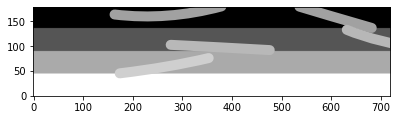

0.004065384187701545
Processing: WE=1.0, WG=2.5, WI=3.5, Species=0
Processing: WE=1.0, WG=2.5, WI=3.5, Species=1
Processing: WE=1.0, WG=2.5, WI=3.5, Species=2
Processing: WE=1.0, WG=2.5, WI=3.5, Species=3
Processing: WE=1.0, WG=2.5, WI=3.5, Species=4


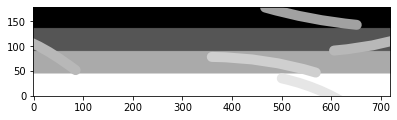

0.003998326464035086
Processing: WE=1.0, WG=2.5, WI=4.0, Species=0
Processing: WE=1.0, WG=2.5, WI=4.0, Species=1
Processing: WE=1.0, WG=2.5, WI=4.0, Species=2
Processing: WE=1.0, WG=2.5, WI=4.0, Species=3
Processing: WE=1.0, WG=2.5, WI=4.0, Species=4


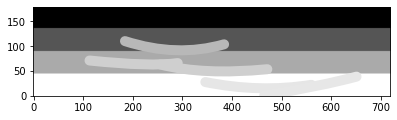

0.004477227143745547
Processing: WE=1.0, WG=3.0, WI=0.0, Species=0
Processing: WE=1.0, WG=3.0, WI=0.0, Species=1
Processing: WE=1.0, WG=3.0, WI=0.0, Species=2
Processing: WE=1.0, WG=3.0, WI=0.0, Species=3
Processing: WE=1.0, WG=3.0, WI=0.0, Species=4


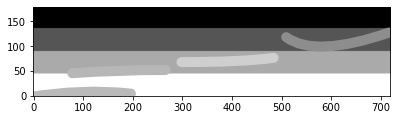

0.004439182545029576
Processing: WE=1.0, WG=3.0, WI=0.5, Species=0
Processing: WE=1.0, WG=3.0, WI=0.5, Species=1
Processing: WE=1.0, WG=3.0, WI=0.5, Species=2
Processing: WE=1.0, WG=3.0, WI=0.5, Species=3
Processing: WE=1.0, WG=3.0, WI=0.5, Species=4


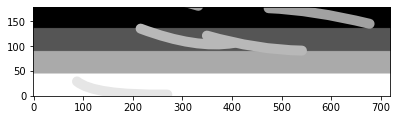

0.003592898567682877
Processing: WE=1.0, WG=3.0, WI=1.0, Species=0
Processing: WE=1.0, WG=3.0, WI=1.0, Species=1
Processing: WE=1.0, WG=3.0, WI=1.0, Species=2
Processing: WE=1.0, WG=3.0, WI=1.0, Species=3
Processing: WE=1.0, WG=3.0, WI=1.0, Species=4


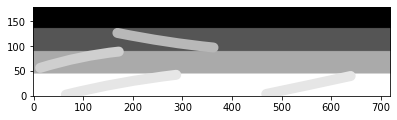

0.004125009357314222
Processing: WE=1.0, WG=3.0, WI=1.5, Species=0
Processing: WE=1.0, WG=3.0, WI=1.5, Species=1
Processing: WE=1.0, WG=3.0, WI=1.5, Species=2
Processing: WE=1.0, WG=3.0, WI=1.5, Species=3
Processing: WE=1.0, WG=3.0, WI=1.5, Species=4


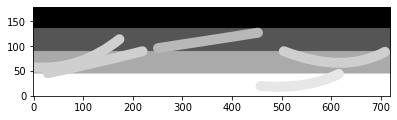

0.004267264759543068
Processing: WE=1.0, WG=3.0, WI=2.0, Species=0
Processing: WE=1.0, WG=3.0, WI=2.0, Species=1
Processing: WE=1.0, WG=3.0, WI=2.0, Species=2
Processing: WE=1.0, WG=3.0, WI=2.0, Species=3
Processing: WE=1.0, WG=3.0, WI=2.0, Species=4


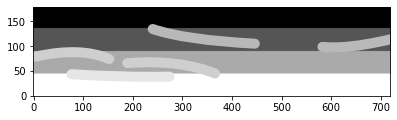

0.004095899328138783
Processing: WE=1.0, WG=3.0, WI=2.5, Species=0
Processing: WE=1.0, WG=3.0, WI=2.5, Species=1
Processing: WE=1.0, WG=3.0, WI=2.5, Species=2
Processing: WE=1.0, WG=3.0, WI=2.5, Species=3
Processing: WE=1.0, WG=3.0, WI=2.5, Species=4


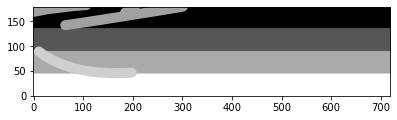

0.002050755041381738
Processing: WE=1.0, WG=3.0, WI=3.0, Species=0
Processing: WE=1.0, WG=3.0, WI=3.0, Species=1
Processing: WE=1.0, WG=3.0, WI=3.0, Species=2
Processing: WE=1.0, WG=3.0, WI=3.0, Species=3
Processing: WE=1.0, WG=3.0, WI=3.0, Species=4


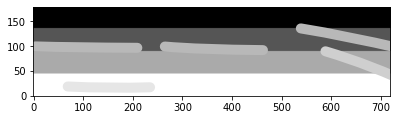

0.004917802202487677
Processing: WE=1.0, WG=3.0, WI=3.5, Species=0
Processing: WE=1.0, WG=3.0, WI=3.5, Species=1
Processing: WE=1.0, WG=3.0, WI=3.5, Species=2
Processing: WE=1.0, WG=3.0, WI=3.5, Species=3
Processing: WE=1.0, WG=3.0, WI=3.5, Species=4


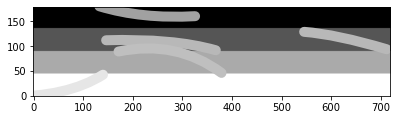

0.00519103335516101
Processing: WE=1.0, WG=3.0, WI=4.0, Species=0
Processing: WE=1.0, WG=3.0, WI=4.0, Species=1
Processing: WE=1.0, WG=3.0, WI=4.0, Species=2
Processing: WE=1.0, WG=3.0, WI=4.0, Species=3
Processing: WE=1.0, WG=3.0, WI=4.0, Species=4


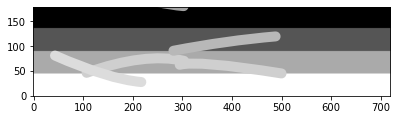

0.004723131304982548
Processing: WE=1.0, WG=3.5, WI=0.0, Species=0
Processing: WE=1.0, WG=3.5, WI=0.0, Species=1
Processing: WE=1.0, WG=3.5, WI=0.0, Species=2
Processing: WE=1.0, WG=3.5, WI=0.0, Species=3
Processing: WE=1.0, WG=3.5, WI=0.0, Species=4


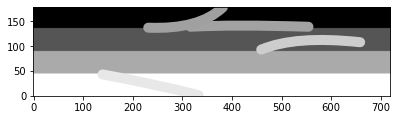

0.0030578903417254814
Processing: WE=1.0, WG=3.5, WI=0.5, Species=0
Processing: WE=1.0, WG=3.5, WI=0.5, Species=1
Processing: WE=1.0, WG=3.5, WI=0.5, Species=2
Processing: WE=1.0, WG=3.5, WI=0.5, Species=3
Processing: WE=1.0, WG=3.5, WI=0.5, Species=4


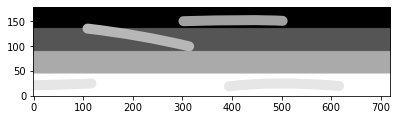

0.0043978916547777296
Processing: WE=1.0, WG=3.5, WI=1.0, Species=0
Processing: WE=1.0, WG=3.5, WI=1.0, Species=1
Processing: WE=1.0, WG=3.5, WI=1.0, Species=2
Processing: WE=1.0, WG=3.5, WI=1.0, Species=3
Processing: WE=1.0, WG=3.5, WI=1.0, Species=4


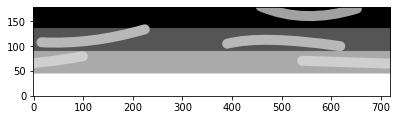

0.004157317225913062
Processing: WE=1.0, WG=3.5, WI=1.5, Species=0
Processing: WE=1.0, WG=3.5, WI=1.5, Species=1
Processing: WE=1.0, WG=3.5, WI=1.5, Species=2
Processing: WE=1.0, WG=3.5, WI=1.5, Species=3
Processing: WE=1.0, WG=3.5, WI=1.5, Species=4


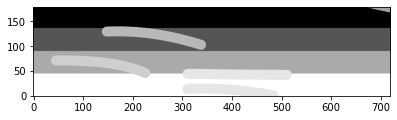

0.00398296714438027
Processing: WE=1.0, WG=3.5, WI=2.0, Species=0
Processing: WE=1.0, WG=3.5, WI=2.0, Species=1
Processing: WE=1.0, WG=3.5, WI=2.0, Species=2
Processing: WE=1.0, WG=3.5, WI=2.0, Species=3
Processing: WE=1.0, WG=3.5, WI=2.0, Species=4


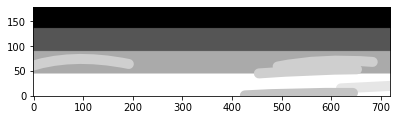

0.004361717307603323
Processing: WE=1.0, WG=3.5, WI=2.5, Species=0
Processing: WE=1.0, WG=3.5, WI=2.5, Species=1
Processing: WE=1.0, WG=3.5, WI=2.5, Species=2
Processing: WE=1.0, WG=3.5, WI=2.5, Species=3
Processing: WE=1.0, WG=3.5, WI=2.5, Species=4


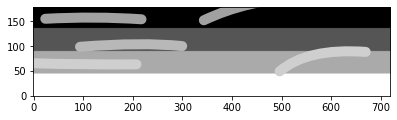

0.004053804132819838
Processing: WE=1.0, WG=3.5, WI=3.0, Species=0
Processing: WE=1.0, WG=3.5, WI=3.0, Species=1
Processing: WE=1.0, WG=3.5, WI=3.0, Species=2
Processing: WE=1.0, WG=3.5, WI=3.0, Species=3
Processing: WE=1.0, WG=3.5, WI=3.0, Species=4


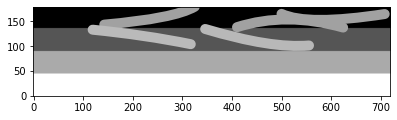

0.005396567216283205
Processing: WE=1.0, WG=3.5, WI=3.5, Species=0
Processing: WE=1.0, WG=3.5, WI=3.5, Species=1
Processing: WE=1.0, WG=3.5, WI=3.5, Species=2
Processing: WE=1.0, WG=3.5, WI=3.5, Species=3
Processing: WE=1.0, WG=3.5, WI=3.5, Species=4


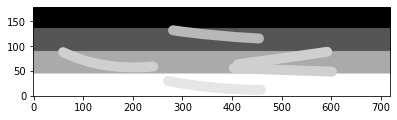

0.0047156406083937955
Processing: WE=1.0, WG=3.5, WI=4.0, Species=0
Processing: WE=1.0, WG=3.5, WI=4.0, Species=1
Processing: WE=1.0, WG=3.5, WI=4.0, Species=2
Processing: WE=1.0, WG=3.5, WI=4.0, Species=3
Processing: WE=1.0, WG=3.5, WI=4.0, Species=4


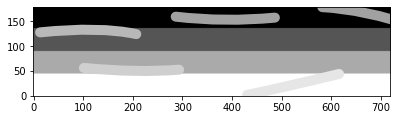

0.004419210584267066
Processing: WE=1.0, WG=4.0, WI=0.0, Species=0
Processing: WE=1.0, WG=4.0, WI=0.0, Species=1
Processing: WE=1.0, WG=4.0, WI=0.0, Species=2
Processing: WE=1.0, WG=4.0, WI=0.0, Species=3
Processing: WE=1.0, WG=4.0, WI=0.0, Species=4


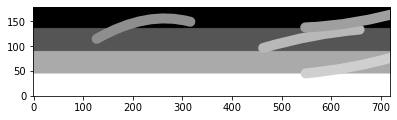

0.005093644609084722
Processing: WE=1.0, WG=4.0, WI=0.5, Species=0
Processing: WE=1.0, WG=4.0, WI=0.5, Species=1
Processing: WE=1.0, WG=4.0, WI=0.5, Species=2
Processing: WE=1.0, WG=4.0, WI=0.5, Species=3
Processing: WE=1.0, WG=4.0, WI=0.5, Species=4


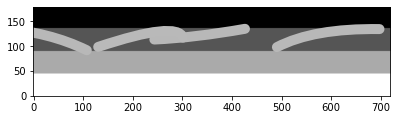

0.0029014384705412367
Processing: WE=1.0, WG=4.0, WI=1.0, Species=0
Processing: WE=1.0, WG=4.0, WI=1.0, Species=1
Processing: WE=1.0, WG=4.0, WI=1.0, Species=2
Processing: WE=1.0, WG=4.0, WI=1.0, Species=3
Processing: WE=1.0, WG=4.0, WI=1.0, Species=4


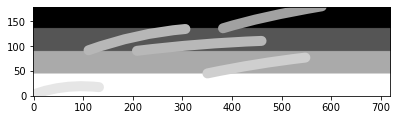

0.005265281372318872
Processing: WE=1.0, WG=4.0, WI=1.5, Species=0
Processing: WE=1.0, WG=4.0, WI=1.5, Species=1
Processing: WE=1.0, WG=4.0, WI=1.5, Species=2
Processing: WE=1.0, WG=4.0, WI=1.5, Species=3
Processing: WE=1.0, WG=4.0, WI=1.5, Species=4


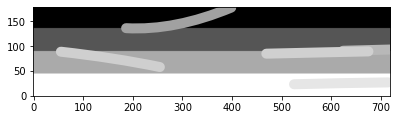

0.005175412394098824
Processing: WE=1.0, WG=4.0, WI=2.0, Species=0
Processing: WE=1.0, WG=4.0, WI=2.0, Species=1
Processing: WE=1.0, WG=4.0, WI=2.0, Species=2
Processing: WE=1.0, WG=4.0, WI=2.0, Species=3
Processing: WE=1.0, WG=4.0, WI=2.0, Species=4


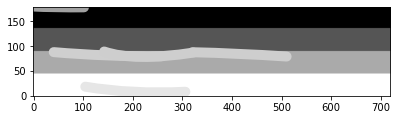

0.0028463484186562918
Processing: WE=1.0, WG=4.0, WI=2.5, Species=0
Processing: WE=1.0, WG=4.0, WI=2.5, Species=1
Processing: WE=1.0, WG=4.0, WI=2.5, Species=2
Processing: WE=1.0, WG=4.0, WI=2.5, Species=3
Processing: WE=1.0, WG=4.0, WI=2.5, Species=4


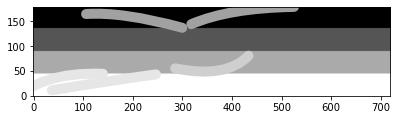

0.004307005182195689
Processing: WE=1.0, WG=4.0, WI=3.0, Species=0
Processing: WE=1.0, WG=4.0, WI=3.0, Species=1
Processing: WE=1.0, WG=4.0, WI=3.0, Species=2
Processing: WE=1.0, WG=4.0, WI=3.0, Species=3
Processing: WE=1.0, WG=4.0, WI=3.0, Species=4


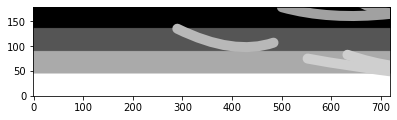

0.0030174425182307126
Processing: WE=1.0, WG=4.0, WI=3.5, Species=0
Processing: WE=1.0, WG=4.0, WI=3.5, Species=1
Processing: WE=1.0, WG=4.0, WI=3.5, Species=2
Processing: WE=1.0, WG=4.0, WI=3.5, Species=3
Processing: WE=1.0, WG=4.0, WI=3.5, Species=4


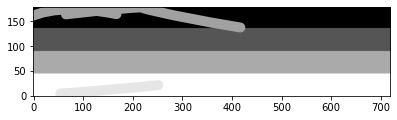

0.0027722457578358574
Processing: WE=1.0, WG=4.0, WI=4.0, Species=0
Processing: WE=1.0, WG=4.0, WI=4.0, Species=1
Processing: WE=1.0, WG=4.0, WI=4.0, Species=2
Processing: WE=1.0, WG=4.0, WI=4.0, Species=3
Processing: WE=1.0, WG=4.0, WI=4.0, Species=4


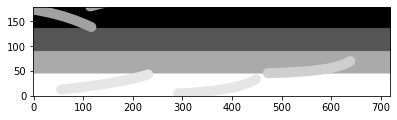

0.0033688559995949407
Processing: WE=1.5, WG=0.0, WI=0.0, Species=0
Processing: WE=1.5, WG=0.0, WI=0.0, Species=1
Processing: WE=1.5, WG=0.0, WI=0.0, Species=2
Processing: WE=1.5, WG=0.0, WI=0.0, Species=3
Processing: WE=1.5, WG=0.0, WI=0.0, Species=4


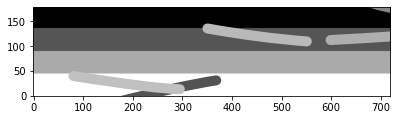

0.004395604715068873
Processing: WE=1.5, WG=0.0, WI=0.5, Species=0
Processing: WE=1.5, WG=0.0, WI=0.5, Species=1
Processing: WE=1.5, WG=0.0, WI=0.5, Species=2
Processing: WE=1.5, WG=0.0, WI=0.5, Species=3
Processing: WE=1.5, WG=0.0, WI=0.5, Species=4


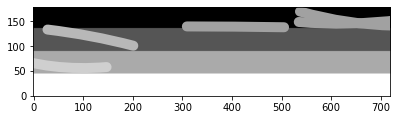

0.004095434187859016
Processing: WE=1.5, WG=0.0, WI=1.0, Species=0
Processing: WE=1.5, WG=0.0, WI=1.0, Species=1
Processing: WE=1.5, WG=0.0, WI=1.0, Species=2
Processing: WE=1.5, WG=0.0, WI=1.0, Species=3
Processing: WE=1.5, WG=0.0, WI=1.0, Species=4


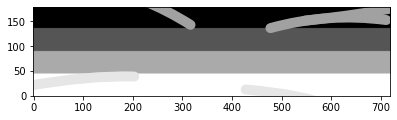

0.003337585006203082
Processing: WE=1.5, WG=0.0, WI=1.5, Species=0
Processing: WE=1.5, WG=0.0, WI=1.5, Species=1
Processing: WE=1.5, WG=0.0, WI=1.5, Species=2
Processing: WE=1.5, WG=0.0, WI=1.5, Species=3
Processing: WE=1.5, WG=0.0, WI=1.5, Species=4


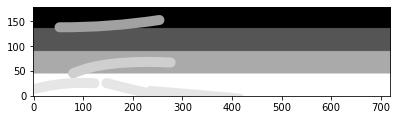

0.0040949205954667715
Processing: WE=1.5, WG=0.0, WI=2.0, Species=0
Processing: WE=1.5, WG=0.0, WI=2.0, Species=1
Processing: WE=1.5, WG=0.0, WI=2.0, Species=2
Processing: WE=1.5, WG=0.0, WI=2.0, Species=3
Processing: WE=1.5, WG=0.0, WI=2.0, Species=4


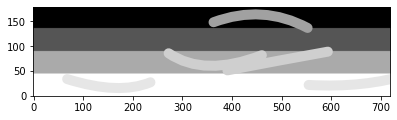

0.004870357893951407
Processing: WE=1.5, WG=0.0, WI=2.5, Species=0
Processing: WE=1.5, WG=0.0, WI=2.5, Species=1
Processing: WE=1.5, WG=0.0, WI=2.5, Species=2
Processing: WE=1.5, WG=0.0, WI=2.5, Species=3
Processing: WE=1.5, WG=0.0, WI=2.5, Species=4


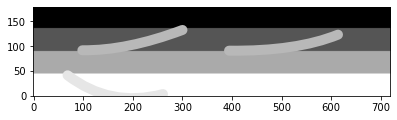

0.003280014206159378
Processing: WE=1.5, WG=0.0, WI=3.0, Species=0
Processing: WE=1.5, WG=0.0, WI=3.0, Species=1
Processing: WE=1.5, WG=0.0, WI=3.0, Species=2
Processing: WE=1.5, WG=0.0, WI=3.0, Species=3
Processing: WE=1.5, WG=0.0, WI=3.0, Species=4


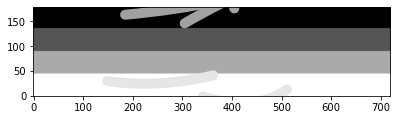

0.0024131283905879835
Processing: WE=1.5, WG=0.0, WI=3.5, Species=0
Processing: WE=1.5, WG=0.0, WI=3.5, Species=1
Processing: WE=1.5, WG=0.0, WI=3.5, Species=2
Processing: WE=1.5, WG=0.0, WI=3.5, Species=3
Processing: WE=1.5, WG=0.0, WI=3.5, Species=4


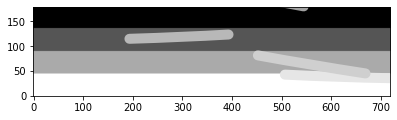

0.003019777910052045
Processing: WE=1.5, WG=0.0, WI=4.0, Species=0
Processing: WE=1.5, WG=0.0, WI=4.0, Species=1
Processing: WE=1.5, WG=0.0, WI=4.0, Species=2
Processing: WE=1.5, WG=0.0, WI=4.0, Species=3
Processing: WE=1.5, WG=0.0, WI=4.0, Species=4


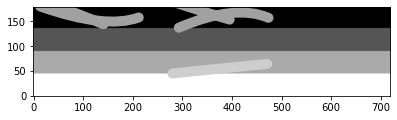

0.002270010540757069
Processing: WE=1.5, WG=0.5, WI=0.0, Species=0
Processing: WE=1.5, WG=0.5, WI=0.0, Species=1
Processing: WE=1.5, WG=0.5, WI=0.0, Species=2
Processing: WE=1.5, WG=0.5, WI=0.0, Species=3
Processing: WE=1.5, WG=0.5, WI=0.0, Species=4


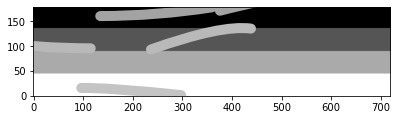

0.005141573438745749
Processing: WE=1.5, WG=0.5, WI=0.5, Species=0
Processing: WE=1.5, WG=0.5, WI=0.5, Species=1
Processing: WE=1.5, WG=0.5, WI=0.5, Species=2
Processing: WE=1.5, WG=0.5, WI=0.5, Species=3
Processing: WE=1.5, WG=0.5, WI=0.5, Species=4


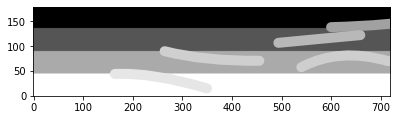

0.0038672344285206575
Processing: WE=1.5, WG=0.5, WI=1.0, Species=0
Processing: WE=1.5, WG=0.5, WI=1.0, Species=1
Processing: WE=1.5, WG=0.5, WI=1.0, Species=2
Processing: WE=1.5, WG=0.5, WI=1.0, Species=3
Processing: WE=1.5, WG=0.5, WI=1.0, Species=4


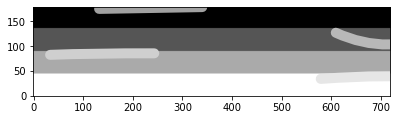

0.0029974608670457073
Processing: WE=1.5, WG=0.5, WI=1.5, Species=0
Processing: WE=1.5, WG=0.5, WI=1.5, Species=1
Processing: WE=1.5, WG=0.5, WI=1.5, Species=2
Processing: WE=1.5, WG=0.5, WI=1.5, Species=3
Processing: WE=1.5, WG=0.5, WI=1.5, Species=4


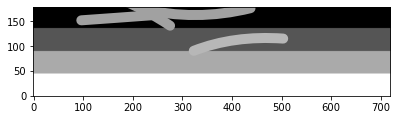

0.0028746832140321196
Processing: WE=1.5, WG=0.5, WI=2.0, Species=0
Processing: WE=1.5, WG=0.5, WI=2.0, Species=1
Processing: WE=1.5, WG=0.5, WI=2.0, Species=2
Processing: WE=1.5, WG=0.5, WI=2.0, Species=3
Processing: WE=1.5, WG=0.5, WI=2.0, Species=4


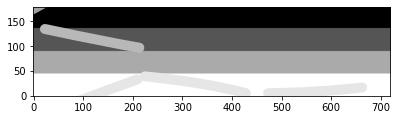

0.003947238556640641
Processing: WE=1.5, WG=0.5, WI=2.5, Species=0
Processing: WE=1.5, WG=0.5, WI=2.5, Species=1
Processing: WE=1.5, WG=0.5, WI=2.5, Species=2
Processing: WE=1.5, WG=0.5, WI=2.5, Species=3
Processing: WE=1.5, WG=0.5, WI=2.5, Species=4


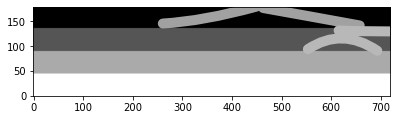

0.0027750656707819467
Processing: WE=1.5, WG=0.5, WI=3.0, Species=0
Processing: WE=1.5, WG=0.5, WI=3.0, Species=1
Processing: WE=1.5, WG=0.5, WI=3.0, Species=2
Processing: WE=1.5, WG=0.5, WI=3.0, Species=3
Processing: WE=1.5, WG=0.5, WI=3.0, Species=4


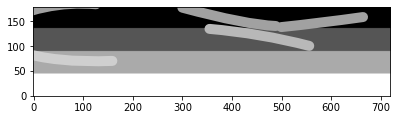

0.0036027537273604477
Processing: WE=1.5, WG=0.5, WI=3.5, Species=0
Processing: WE=1.5, WG=0.5, WI=3.5, Species=1
Processing: WE=1.5, WG=0.5, WI=3.5, Species=2
Processing: WE=1.5, WG=0.5, WI=3.5, Species=3
Processing: WE=1.5, WG=0.5, WI=3.5, Species=4


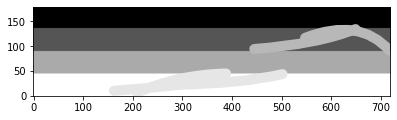

0.0041956525373038865
Processing: WE=1.5, WG=0.5, WI=4.0, Species=0
Processing: WE=1.5, WG=0.5, WI=4.0, Species=1
Processing: WE=1.5, WG=0.5, WI=4.0, Species=2
Processing: WE=1.5, WG=0.5, WI=4.0, Species=3
Processing: WE=1.5, WG=0.5, WI=4.0, Species=4


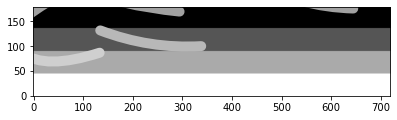

0.0021946287441672744
Processing: WE=1.5, WG=1.0, WI=0.0, Species=0
Processing: WE=1.5, WG=1.0, WI=0.0, Species=1
Processing: WE=1.5, WG=1.0, WI=0.0, Species=2
Processing: WE=1.5, WG=1.0, WI=0.0, Species=3
Processing: WE=1.5, WG=1.0, WI=0.0, Species=4


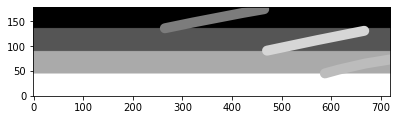

0.0013696733867324064
Processing: WE=1.5, WG=1.0, WI=0.5, Species=0
Processing: WE=1.5, WG=1.0, WI=0.5, Species=1
Processing: WE=1.5, WG=1.0, WI=0.5, Species=2
Processing: WE=1.5, WG=1.0, WI=0.5, Species=3
Processing: WE=1.5, WG=1.0, WI=0.5, Species=4


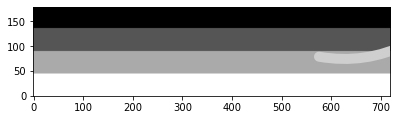

0.0007737608553929746
Processing: WE=1.5, WG=1.0, WI=1.0, Species=0
Processing: WE=1.5, WG=1.0, WI=1.0, Species=1
Processing: WE=1.5, WG=1.0, WI=1.0, Species=2
Processing: WE=1.5, WG=1.0, WI=1.0, Species=3
Processing: WE=1.5, WG=1.0, WI=1.0, Species=4


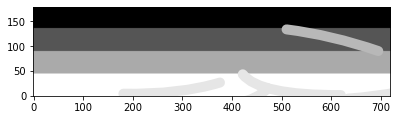

0.003515646519551518
Processing: WE=1.5, WG=1.0, WI=1.5, Species=0
Processing: WE=1.5, WG=1.0, WI=1.5, Species=1
Processing: WE=1.5, WG=1.0, WI=1.5, Species=2
Processing: WE=1.5, WG=1.0, WI=1.5, Species=3
Processing: WE=1.5, WG=1.0, WI=1.5, Species=4


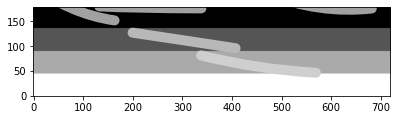

0.003335763206773993
Processing: WE=1.5, WG=1.0, WI=2.0, Species=0
Processing: WE=1.5, WG=1.0, WI=2.0, Species=1
Processing: WE=1.5, WG=1.0, WI=2.0, Species=2
Processing: WE=1.5, WG=1.0, WI=2.0, Species=3
Processing: WE=1.5, WG=1.0, WI=2.0, Species=4


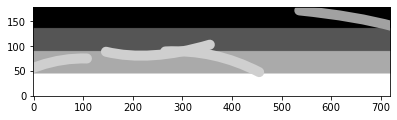

0.0030349628021019495
Processing: WE=1.5, WG=1.0, WI=2.5, Species=0
Processing: WE=1.5, WG=1.0, WI=2.5, Species=1
Processing: WE=1.5, WG=1.0, WI=2.5, Species=2
Processing: WE=1.5, WG=1.0, WI=2.5, Species=3
Processing: WE=1.5, WG=1.0, WI=2.5, Species=4


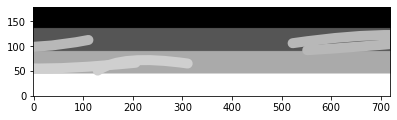

0.0037661148697837364
Processing: WE=1.5, WG=1.0, WI=3.0, Species=0
Processing: WE=1.5, WG=1.0, WI=3.0, Species=1
Processing: WE=1.5, WG=1.0, WI=3.0, Species=2
Processing: WE=1.5, WG=1.0, WI=3.0, Species=3
Processing: WE=1.5, WG=1.0, WI=3.0, Species=4


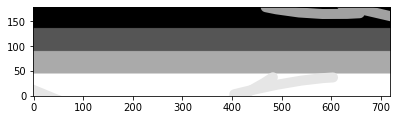

0.0024909812449140424
Processing: WE=1.5, WG=1.0, WI=3.5, Species=0
Processing: WE=1.5, WG=1.0, WI=3.5, Species=1
Processing: WE=1.5, WG=1.0, WI=3.5, Species=2
Processing: WE=1.5, WG=1.0, WI=3.5, Species=3
Processing: WE=1.5, WG=1.0, WI=3.5, Species=4


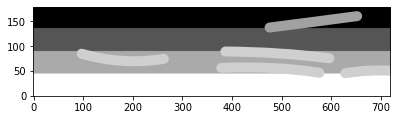

0.004225363372674026
Processing: WE=1.5, WG=1.0, WI=4.0, Species=0
Processing: WE=1.5, WG=1.0, WI=4.0, Species=1
Processing: WE=1.5, WG=1.0, WI=4.0, Species=2
Processing: WE=1.5, WG=1.0, WI=4.0, Species=3
Processing: WE=1.5, WG=1.0, WI=4.0, Species=4


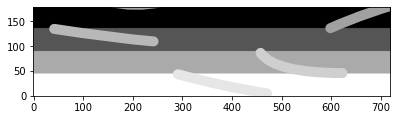

0.0035171679158832567
Processing: WE=1.5, WG=1.5, WI=0.0, Species=0
Processing: WE=1.5, WG=1.5, WI=0.0, Species=1
Processing: WE=1.5, WG=1.5, WI=0.0, Species=2
Processing: WE=1.5, WG=1.5, WI=0.0, Species=3
Processing: WE=1.5, WG=1.5, WI=0.0, Species=4


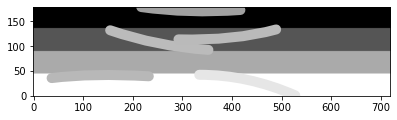

0.0073408535857106974
Processing: WE=1.5, WG=1.5, WI=0.5, Species=0
Processing: WE=1.5, WG=1.5, WI=0.5, Species=1
Processing: WE=1.5, WG=1.5, WI=0.5, Species=2
Processing: WE=1.5, WG=1.5, WI=0.5, Species=3
Processing: WE=1.5, WG=1.5, WI=0.5, Species=4


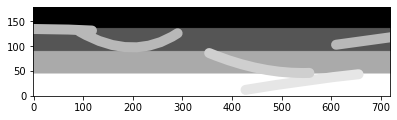

0.004318711212569834
Processing: WE=1.5, WG=1.5, WI=1.0, Species=0
Processing: WE=1.5, WG=1.5, WI=1.0, Species=1
Processing: WE=1.5, WG=1.5, WI=1.0, Species=2
Processing: WE=1.5, WG=1.5, WI=1.0, Species=3
Processing: WE=1.5, WG=1.5, WI=1.0, Species=4


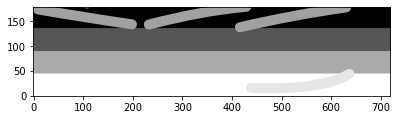

0.0036581829440327225
Processing: WE=1.5, WG=1.5, WI=1.5, Species=0
Processing: WE=1.5, WG=1.5, WI=1.5, Species=1
Processing: WE=1.5, WG=1.5, WI=1.5, Species=2
Processing: WE=1.5, WG=1.5, WI=1.5, Species=3
Processing: WE=1.5, WG=1.5, WI=1.5, Species=4


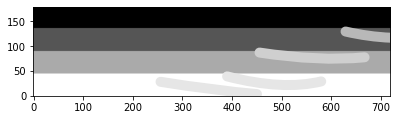

0.0039034475373850436
Processing: WE=1.5, WG=1.5, WI=2.0, Species=0
Processing: WE=1.5, WG=1.5, WI=2.0, Species=1
Processing: WE=1.5, WG=1.5, WI=2.0, Species=2
Processing: WE=1.5, WG=1.5, WI=2.0, Species=3
Processing: WE=1.5, WG=1.5, WI=2.0, Species=4


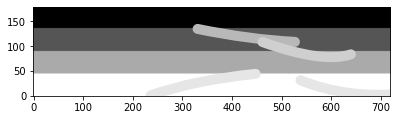

0.003829693731774435
Processing: WE=1.5, WG=1.5, WI=2.5, Species=0
Processing: WE=1.5, WG=1.5, WI=2.5, Species=1
Processing: WE=1.5, WG=1.5, WI=2.5, Species=2
Processing: WE=1.5, WG=1.5, WI=2.5, Species=3
Processing: WE=1.5, WG=1.5, WI=2.5, Species=4


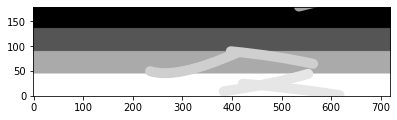

0.0034948993249893953
Processing: WE=1.5, WG=1.5, WI=3.0, Species=0
Processing: WE=1.5, WG=1.5, WI=3.0, Species=1
Processing: WE=1.5, WG=1.5, WI=3.0, Species=2
Processing: WE=1.5, WG=1.5, WI=3.0, Species=3
Processing: WE=1.5, WG=1.5, WI=3.0, Species=4


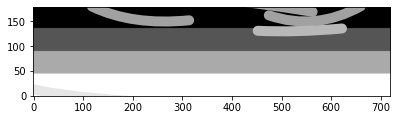

0.0032914682855486486
Processing: WE=1.5, WG=1.5, WI=3.5, Species=0
Processing: WE=1.5, WG=1.5, WI=3.5, Species=1
Processing: WE=1.5, WG=1.5, WI=3.5, Species=2
Processing: WE=1.5, WG=1.5, WI=3.5, Species=3
Processing: WE=1.5, WG=1.5, WI=3.5, Species=4


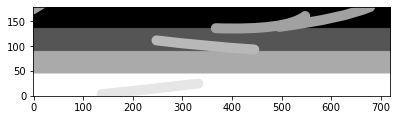

0.003934175867117175
Processing: WE=1.5, WG=1.5, WI=4.0, Species=0
Processing: WE=1.5, WG=1.5, WI=4.0, Species=1
Processing: WE=1.5, WG=1.5, WI=4.0, Species=2
Processing: WE=1.5, WG=1.5, WI=4.0, Species=3
Processing: WE=1.5, WG=1.5, WI=4.0, Species=4


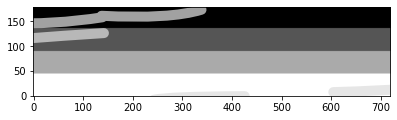

0.0031214207516037044
Processing: WE=1.5, WG=2.0, WI=0.0, Species=0
Processing: WE=1.5, WG=2.0, WI=0.0, Species=1
Processing: WE=1.5, WG=2.0, WI=0.0, Species=2
Processing: WE=1.5, WG=2.0, WI=0.0, Species=3
Processing: WE=1.5, WG=2.0, WI=0.0, Species=4


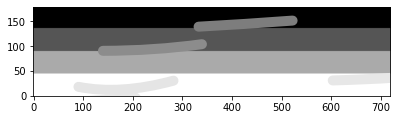

0.004421051764541145
Processing: WE=1.5, WG=2.0, WI=0.5, Species=0
Processing: WE=1.5, WG=2.0, WI=0.5, Species=1
Processing: WE=1.5, WG=2.0, WI=0.5, Species=2
Processing: WE=1.5, WG=2.0, WI=0.5, Species=3
Processing: WE=1.5, WG=2.0, WI=0.5, Species=4


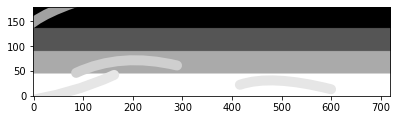

0.0032558075307664858
Processing: WE=1.5, WG=2.0, WI=1.0, Species=0
Processing: WE=1.5, WG=2.0, WI=1.0, Species=1
Processing: WE=1.5, WG=2.0, WI=1.0, Species=2
Processing: WE=1.5, WG=2.0, WI=1.0, Species=3
Processing: WE=1.5, WG=2.0, WI=1.0, Species=4


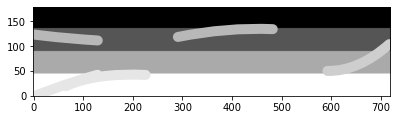

0.0032530554507778616
Processing: WE=1.5, WG=2.0, WI=1.5, Species=0
Processing: WE=1.5, WG=2.0, WI=1.5, Species=1
Processing: WE=1.5, WG=2.0, WI=1.5, Species=2
Processing: WE=1.5, WG=2.0, WI=1.5, Species=3
Processing: WE=1.5, WG=2.0, WI=1.5, Species=4


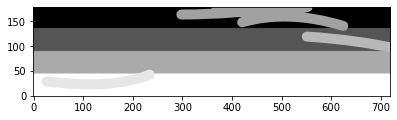

0.0036551982939042153
Processing: WE=1.5, WG=2.0, WI=2.0, Species=0
Processing: WE=1.5, WG=2.0, WI=2.0, Species=1
Processing: WE=1.5, WG=2.0, WI=2.0, Species=2
Processing: WE=1.5, WG=2.0, WI=2.0, Species=3
Processing: WE=1.5, WG=2.0, WI=2.0, Species=4


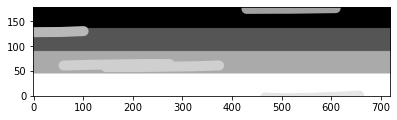

0.0032967495658085075
Processing: WE=1.5, WG=2.0, WI=2.5, Species=0
Processing: WE=1.5, WG=2.0, WI=2.5, Species=1
Processing: WE=1.5, WG=2.0, WI=2.5, Species=2
Processing: WE=1.5, WG=2.0, WI=2.5, Species=3
Processing: WE=1.5, WG=2.0, WI=2.5, Species=4


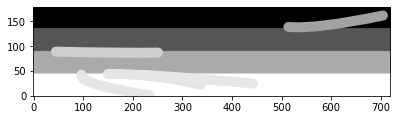

0.0047213773385109264
Processing: WE=1.5, WG=2.0, WI=3.0, Species=0
Processing: WE=1.5, WG=2.0, WI=3.0, Species=1
Processing: WE=1.5, WG=2.0, WI=3.0, Species=2
Processing: WE=1.5, WG=2.0, WI=3.0, Species=3
Processing: WE=1.5, WG=2.0, WI=3.0, Species=4


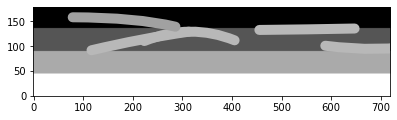

0.004214568242014425
Processing: WE=1.5, WG=2.0, WI=3.5, Species=0
Processing: WE=1.5, WG=2.0, WI=3.5, Species=1
Processing: WE=1.5, WG=2.0, WI=3.5, Species=2
Processing: WE=1.5, WG=2.0, WI=3.5, Species=3
Processing: WE=1.5, WG=2.0, WI=3.5, Species=4


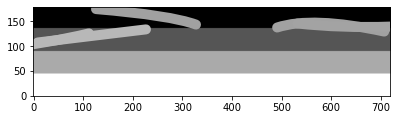

0.00403340579346754
Processing: WE=1.5, WG=2.0, WI=4.0, Species=0
Processing: WE=1.5, WG=2.0, WI=4.0, Species=1
Processing: WE=1.5, WG=2.0, WI=4.0, Species=2
Processing: WE=1.5, WG=2.0, WI=4.0, Species=3
Processing: WE=1.5, WG=2.0, WI=4.0, Species=4


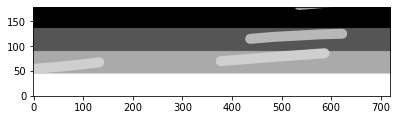

0.00271286284878556
Processing: WE=1.5, WG=2.5, WI=0.0, Species=0
Processing: WE=1.5, WG=2.5, WI=0.0, Species=1
Processing: WE=1.5, WG=2.5, WI=0.0, Species=2
Processing: WE=1.5, WG=2.5, WI=0.0, Species=3
Processing: WE=1.5, WG=2.5, WI=0.0, Species=4


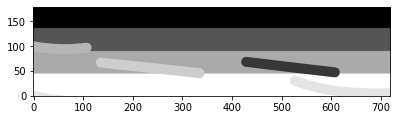

0.006483483765029542
Processing: WE=1.5, WG=2.5, WI=0.5, Species=0
Processing: WE=1.5, WG=2.5, WI=0.5, Species=1
Processing: WE=1.5, WG=2.5, WI=0.5, Species=2
Processing: WE=1.5, WG=2.5, WI=0.5, Species=3
Processing: WE=1.5, WG=2.5, WI=0.5, Species=4


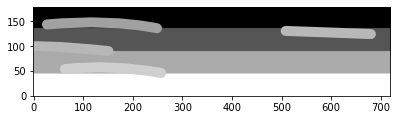

0.0039572972151906095
Processing: WE=1.5, WG=2.5, WI=1.0, Species=0
Processing: WE=1.5, WG=2.5, WI=1.0, Species=1
Processing: WE=1.5, WG=2.5, WI=1.0, Species=2
Processing: WE=1.5, WG=2.5, WI=1.0, Species=3
Processing: WE=1.5, WG=2.5, WI=1.0, Species=4


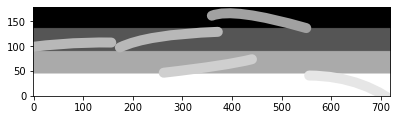

0.004377154150638102
Processing: WE=1.5, WG=2.5, WI=1.5, Species=0
Processing: WE=1.5, WG=2.5, WI=1.5, Species=1
Processing: WE=1.5, WG=2.5, WI=1.5, Species=2
Processing: WE=1.5, WG=2.5, WI=1.5, Species=3
Processing: WE=1.5, WG=2.5, WI=1.5, Species=4


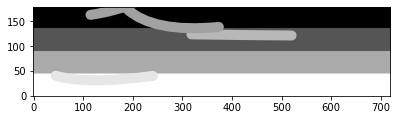

0.0034081894245027665
Processing: WE=1.5, WG=2.5, WI=2.0, Species=0
Processing: WE=1.5, WG=2.5, WI=2.0, Species=1
Processing: WE=1.5, WG=2.5, WI=2.0, Species=2
Processing: WE=1.5, WG=2.5, WI=2.0, Species=3
Processing: WE=1.5, WG=2.5, WI=2.0, Species=4


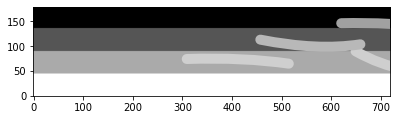

0.002814728570054608
Processing: WE=1.5, WG=2.5, WI=2.5, Species=0
Processing: WE=1.5, WG=2.5, WI=2.5, Species=1
Processing: WE=1.5, WG=2.5, WI=2.5, Species=2
Processing: WE=1.5, WG=2.5, WI=2.5, Species=3
Processing: WE=1.5, WG=2.5, WI=2.5, Species=4


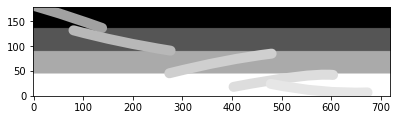

0.005011692706043214
Processing: WE=1.5, WG=2.5, WI=3.0, Species=0
Processing: WE=1.5, WG=2.5, WI=3.0, Species=1
Processing: WE=1.5, WG=2.5, WI=3.0, Species=2
Processing: WE=1.5, WG=2.5, WI=3.0, Species=3
Processing: WE=1.5, WG=2.5, WI=3.0, Species=4


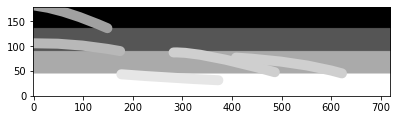

0.0046242793051094935
Processing: WE=1.5, WG=2.5, WI=3.5, Species=0
Processing: WE=1.5, WG=2.5, WI=3.5, Species=1
Processing: WE=1.5, WG=2.5, WI=3.5, Species=2
Processing: WE=1.5, WG=2.5, WI=3.5, Species=3
Processing: WE=1.5, WG=2.5, WI=3.5, Species=4


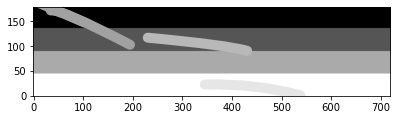

0.003257445212168166
Processing: WE=1.5, WG=2.5, WI=4.0, Species=0
Processing: WE=1.5, WG=2.5, WI=4.0, Species=1
Processing: WE=1.5, WG=2.5, WI=4.0, Species=2
Processing: WE=1.5, WG=2.5, WI=4.0, Species=3
Processing: WE=1.5, WG=2.5, WI=4.0, Species=4


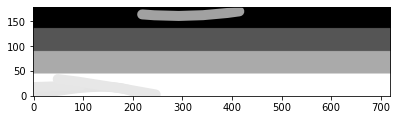

0.0024836165238177263
Processing: WE=1.5, WG=3.0, WI=0.0, Species=0
Processing: WE=1.5, WG=3.0, WI=0.0, Species=1
Processing: WE=1.5, WG=3.0, WI=0.0, Species=2
Processing: WE=1.5, WG=3.0, WI=0.0, Species=3
Processing: WE=1.5, WG=3.0, WI=0.0, Species=4


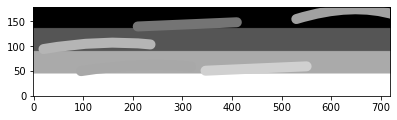

0.004293806826757292
Processing: WE=1.5, WG=3.0, WI=0.5, Species=0
Processing: WE=1.5, WG=3.0, WI=0.5, Species=1
Processing: WE=1.5, WG=3.0, WI=0.5, Species=2
Processing: WE=1.5, WG=3.0, WI=0.5, Species=3
Processing: WE=1.5, WG=3.0, WI=0.5, Species=4


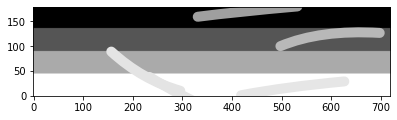

0.005221054284050994
Processing: WE=1.5, WG=3.0, WI=1.0, Species=0
Processing: WE=1.5, WG=3.0, WI=1.0, Species=1
Processing: WE=1.5, WG=3.0, WI=1.0, Species=2
Processing: WE=1.5, WG=3.0, WI=1.0, Species=3
Processing: WE=1.5, WG=3.0, WI=1.0, Species=4


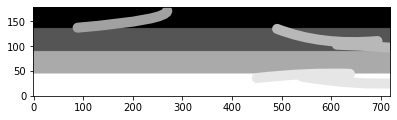

0.003907585347790474
Processing: WE=1.5, WG=3.0, WI=1.5, Species=0
Processing: WE=1.5, WG=3.0, WI=1.5, Species=1
Processing: WE=1.5, WG=3.0, WI=1.5, Species=2
Processing: WE=1.5, WG=3.0, WI=1.5, Species=3
Processing: WE=1.5, WG=3.0, WI=1.5, Species=4


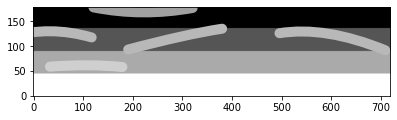

0.0041952358491365955
Processing: WE=1.5, WG=3.0, WI=2.0, Species=0
Processing: WE=1.5, WG=3.0, WI=2.0, Species=1
Processing: WE=1.5, WG=3.0, WI=2.0, Species=2
Processing: WE=1.5, WG=3.0, WI=2.0, Species=3
Processing: WE=1.5, WG=3.0, WI=2.0, Species=4


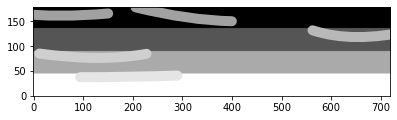

0.004887422727965373
Processing: WE=1.5, WG=3.0, WI=2.5, Species=0
Processing: WE=1.5, WG=3.0, WI=2.5, Species=1
Processing: WE=1.5, WG=3.0, WI=2.5, Species=2
Processing: WE=1.5, WG=3.0, WI=2.5, Species=3
Processing: WE=1.5, WG=3.0, WI=2.5, Species=4


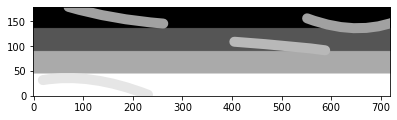

0.003961638524468438
Processing: WE=1.5, WG=3.0, WI=3.0, Species=0
Processing: WE=1.5, WG=3.0, WI=3.0, Species=1
Processing: WE=1.5, WG=3.0, WI=3.0, Species=2
Processing: WE=1.5, WG=3.0, WI=3.0, Species=3
Processing: WE=1.5, WG=3.0, WI=3.0, Species=4


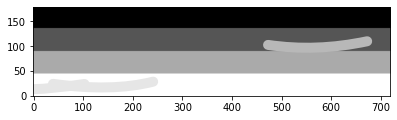

0.002517814024803121
Processing: WE=1.5, WG=3.0, WI=3.5, Species=0
Processing: WE=1.5, WG=3.0, WI=3.5, Species=1
Processing: WE=1.5, WG=3.0, WI=3.5, Species=2
Processing: WE=1.5, WG=3.0, WI=3.5, Species=3
Processing: WE=1.5, WG=3.0, WI=3.5, Species=4


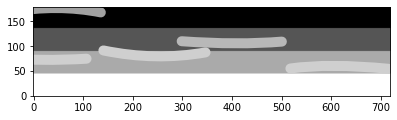

0.0038992031323321673
Processing: WE=1.5, WG=3.0, WI=4.0, Species=0
Processing: WE=1.5, WG=3.0, WI=4.0, Species=1
Processing: WE=1.5, WG=3.0, WI=4.0, Species=2
Processing: WE=1.5, WG=3.0, WI=4.0, Species=3
Processing: WE=1.5, WG=3.0, WI=4.0, Species=4


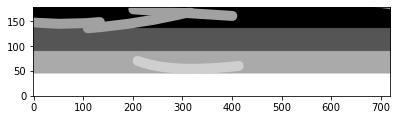

0.0031390960822348635
Processing: WE=1.5, WG=3.5, WI=0.0, Species=0
Processing: WE=1.5, WG=3.5, WI=0.0, Species=1
Processing: WE=1.5, WG=3.5, WI=0.0, Species=2
Processing: WE=1.5, WG=3.5, WI=0.0, Species=3
Processing: WE=1.5, WG=3.5, WI=0.0, Species=4


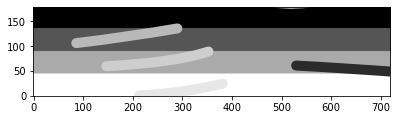

0.0018600378362546325
Processing: WE=1.5, WG=3.5, WI=0.5, Species=0
Processing: WE=1.5, WG=3.5, WI=0.5, Species=1
Processing: WE=1.5, WG=3.5, WI=0.5, Species=2
Processing: WE=1.5, WG=3.5, WI=0.5, Species=3
Processing: WE=1.5, WG=3.5, WI=0.5, Species=4


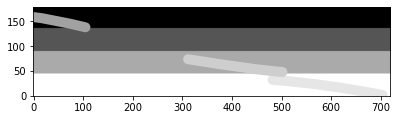

0.0021703251645494304
Processing: WE=1.5, WG=3.5, WI=1.0, Species=0
Processing: WE=1.5, WG=3.5, WI=1.0, Species=1
Processing: WE=1.5, WG=3.5, WI=1.0, Species=2
Processing: WE=1.5, WG=3.5, WI=1.0, Species=3
Processing: WE=1.5, WG=3.5, WI=1.0, Species=4


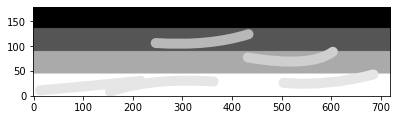

0.00523605505807349
Processing: WE=1.5, WG=3.5, WI=1.5, Species=0
Processing: WE=1.5, WG=3.5, WI=1.5, Species=1
Processing: WE=1.5, WG=3.5, WI=1.5, Species=2
Processing: WE=1.5, WG=3.5, WI=1.5, Species=3
Processing: WE=1.5, WG=3.5, WI=1.5, Species=4


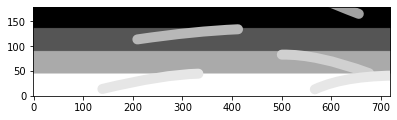

0.004483012325975153
Processing: WE=1.5, WG=3.5, WI=2.0, Species=0
Processing: WE=1.5, WG=3.5, WI=2.0, Species=1
Processing: WE=1.5, WG=3.5, WI=2.0, Species=2
Processing: WE=1.5, WG=3.5, WI=2.0, Species=3
Processing: WE=1.5, WG=3.5, WI=2.0, Species=4


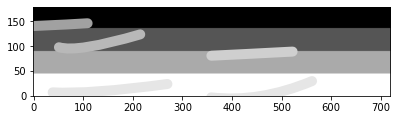

0.004507364357705473
Processing: WE=1.5, WG=3.5, WI=2.5, Species=0
Processing: WE=1.5, WG=3.5, WI=2.5, Species=1
Processing: WE=1.5, WG=3.5, WI=2.5, Species=2
Processing: WE=1.5, WG=3.5, WI=2.5, Species=3
Processing: WE=1.5, WG=3.5, WI=2.5, Species=4


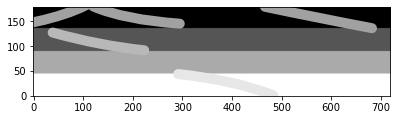

0.00383572117456642
Processing: WE=1.5, WG=3.5, WI=3.0, Species=0
Processing: WE=1.5, WG=3.5, WI=3.0, Species=1
Processing: WE=1.5, WG=3.5, WI=3.0, Species=2
Processing: WE=1.5, WG=3.5, WI=3.0, Species=3
Processing: WE=1.5, WG=3.5, WI=3.0, Species=4


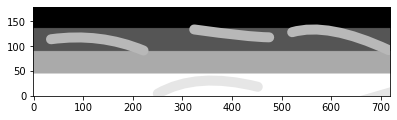

0.004231565243070924
Processing: WE=1.5, WG=3.5, WI=3.5, Species=0
Processing: WE=1.5, WG=3.5, WI=3.5, Species=1
Processing: WE=1.5, WG=3.5, WI=3.5, Species=2
Processing: WE=1.5, WG=3.5, WI=3.5, Species=3
Processing: WE=1.5, WG=3.5, WI=3.5, Species=4


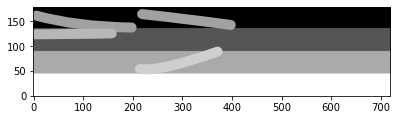

0.0036046821214369834
Processing: WE=1.5, WG=3.5, WI=4.0, Species=0
Processing: WE=1.5, WG=3.5, WI=4.0, Species=1
Processing: WE=1.5, WG=3.5, WI=4.0, Species=2
Processing: WE=1.5, WG=3.5, WI=4.0, Species=3
Processing: WE=1.5, WG=3.5, WI=4.0, Species=4


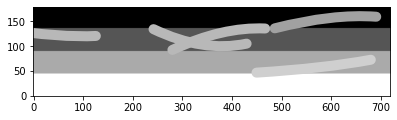

0.004432360487592988
Processing: WE=1.5, WG=4.0, WI=0.0, Species=0
Processing: WE=1.5, WG=4.0, WI=0.0, Species=1
Processing: WE=1.5, WG=4.0, WI=0.0, Species=2
Processing: WE=1.5, WG=4.0, WI=0.0, Species=3
Processing: WE=1.5, WG=4.0, WI=0.0, Species=4


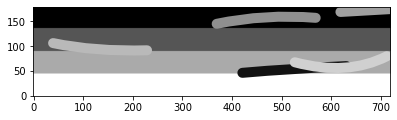

0.005466367329515791
Processing: WE=1.5, WG=4.0, WI=0.5, Species=0
Processing: WE=1.5, WG=4.0, WI=0.5, Species=1
Processing: WE=1.5, WG=4.0, WI=0.5, Species=2
Processing: WE=1.5, WG=4.0, WI=0.5, Species=3
Processing: WE=1.5, WG=4.0, WI=0.5, Species=4


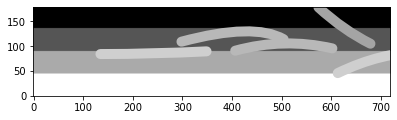

0.004241604520775902
Processing: WE=1.5, WG=4.0, WI=1.0, Species=0
Processing: WE=1.5, WG=4.0, WI=1.0, Species=1
Processing: WE=1.5, WG=4.0, WI=1.0, Species=2
Processing: WE=1.5, WG=4.0, WI=1.0, Species=3
Processing: WE=1.5, WG=4.0, WI=1.0, Species=4


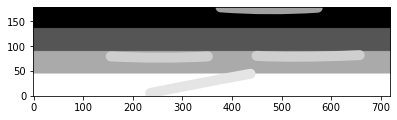

0.004377386720777986
Processing: WE=1.5, WG=4.0, WI=1.5, Species=0
Processing: WE=1.5, WG=4.0, WI=1.5, Species=1
Processing: WE=1.5, WG=4.0, WI=1.5, Species=2
Processing: WE=1.5, WG=4.0, WI=1.5, Species=3
Processing: WE=1.5, WG=4.0, WI=1.5, Species=4


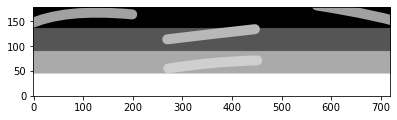

0.003161258078481279
Processing: WE=1.5, WG=4.0, WI=2.0, Species=0
Processing: WE=1.5, WG=4.0, WI=2.0, Species=1
Processing: WE=1.5, WG=4.0, WI=2.0, Species=2
Processing: WE=1.5, WG=4.0, WI=2.0, Species=3
Processing: WE=1.5, WG=4.0, WI=2.0, Species=4


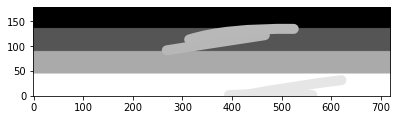

0.003509871027744406
Processing: WE=1.5, WG=4.0, WI=2.5, Species=0
Processing: WE=1.5, WG=4.0, WI=2.5, Species=1
Processing: WE=1.5, WG=4.0, WI=2.5, Species=2
Processing: WE=1.5, WG=4.0, WI=2.5, Species=3
Processing: WE=1.5, WG=4.0, WI=2.5, Species=4


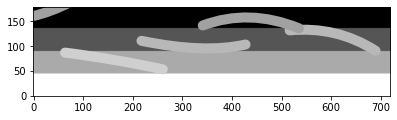

0.004128914597579769
Processing: WE=1.5, WG=4.0, WI=3.0, Species=0
Processing: WE=1.5, WG=4.0, WI=3.0, Species=1
Processing: WE=1.5, WG=4.0, WI=3.0, Species=2
Processing: WE=1.5, WG=4.0, WI=3.0, Species=3
Processing: WE=1.5, WG=4.0, WI=3.0, Species=4


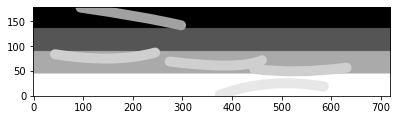

0.004443223451210055
Processing: WE=1.5, WG=4.0, WI=3.5, Species=0
Processing: WE=1.5, WG=4.0, WI=3.5, Species=1
Processing: WE=1.5, WG=4.0, WI=3.5, Species=2
Processing: WE=1.5, WG=4.0, WI=3.5, Species=3
Processing: WE=1.5, WG=4.0, WI=3.5, Species=4


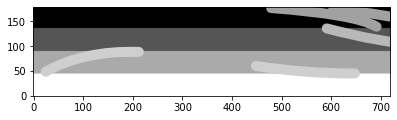

0.0036088877647998795
Processing: WE=1.5, WG=4.0, WI=4.0, Species=0
Processing: WE=1.5, WG=4.0, WI=4.0, Species=1
Processing: WE=1.5, WG=4.0, WI=4.0, Species=2
Processing: WE=1.5, WG=4.0, WI=4.0, Species=3
Processing: WE=1.5, WG=4.0, WI=4.0, Species=4


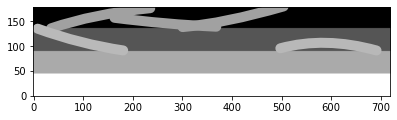

0.0037803694812741065
Processing: WE=2.0, WG=0.0, WI=0.0, Species=0
Processing: WE=2.0, WG=0.0, WI=0.0, Species=1
Processing: WE=2.0, WG=0.0, WI=0.0, Species=2
Processing: WE=2.0, WG=0.0, WI=0.0, Species=3
Processing: WE=2.0, WG=0.0, WI=0.0, Species=4


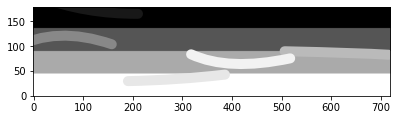

0.0034143234619421984
Processing: WE=2.0, WG=0.0, WI=0.5, Species=0
Processing: WE=2.0, WG=0.0, WI=0.5, Species=1
Processing: WE=2.0, WG=0.0, WI=0.5, Species=2
Processing: WE=2.0, WG=0.0, WI=0.5, Species=3
Processing: WE=2.0, WG=0.0, WI=0.5, Species=4


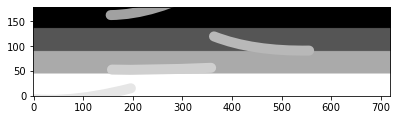

0.0031094336989772003
Processing: WE=2.0, WG=0.0, WI=1.0, Species=0
Processing: WE=2.0, WG=0.0, WI=1.0, Species=1
Processing: WE=2.0, WG=0.0, WI=1.0, Species=2
Processing: WE=2.0, WG=0.0, WI=1.0, Species=3
Processing: WE=2.0, WG=0.0, WI=1.0, Species=4


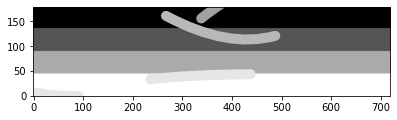

0.0027026297626306785
Processing: WE=2.0, WG=0.0, WI=1.5, Species=0
Processing: WE=2.0, WG=0.0, WI=1.5, Species=1
Processing: WE=2.0, WG=0.0, WI=1.5, Species=2
Processing: WE=2.0, WG=0.0, WI=1.5, Species=3
Processing: WE=2.0, WG=0.0, WI=1.5, Species=4


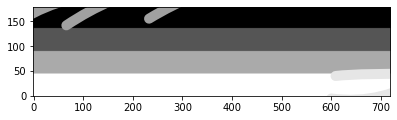

0.0014065066826364828
Processing: WE=2.0, WG=0.0, WI=2.0, Species=0
Processing: WE=2.0, WG=0.0, WI=2.0, Species=1
Processing: WE=2.0, WG=0.0, WI=2.0, Species=2
Processing: WE=2.0, WG=0.0, WI=2.0, Species=3
Processing: WE=2.0, WG=0.0, WI=2.0, Species=4


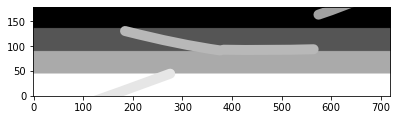

0.0032067158504060413
Processing: WE=2.0, WG=0.0, WI=2.5, Species=0
Processing: WE=2.0, WG=0.0, WI=2.5, Species=1
Processing: WE=2.0, WG=0.0, WI=2.5, Species=2
Processing: WE=2.0, WG=0.0, WI=2.5, Species=3
Processing: WE=2.0, WG=0.0, WI=2.5, Species=4


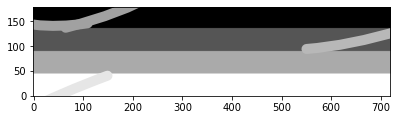

0.002469148723032463
Processing: WE=2.0, WG=0.0, WI=3.0, Species=0
Processing: WE=2.0, WG=0.0, WI=3.0, Species=1
Processing: WE=2.0, WG=0.0, WI=3.0, Species=2
Processing: WE=2.0, WG=0.0, WI=3.0, Species=3
Processing: WE=2.0, WG=0.0, WI=3.0, Species=4


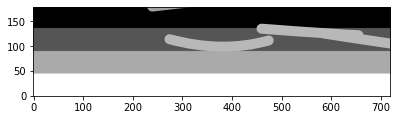

0.0024068780680786095
Processing: WE=2.0, WG=0.0, WI=3.5, Species=0
Processing: WE=2.0, WG=0.0, WI=3.5, Species=1
Processing: WE=2.0, WG=0.0, WI=3.5, Species=2
Processing: WE=2.0, WG=0.0, WI=3.5, Species=3
Processing: WE=2.0, WG=0.0, WI=3.5, Species=4


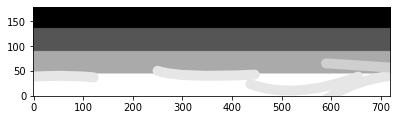

0.004201931931080746
Processing: WE=2.0, WG=0.0, WI=4.0, Species=0
Processing: WE=2.0, WG=0.0, WI=4.0, Species=1
Processing: WE=2.0, WG=0.0, WI=4.0, Species=2
Processing: WE=2.0, WG=0.0, WI=4.0, Species=3
Processing: WE=2.0, WG=0.0, WI=4.0, Species=4


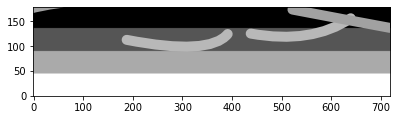

0.0028276168319731616
Processing: WE=2.0, WG=0.5, WI=0.0, Species=0
Processing: WE=2.0, WG=0.5, WI=0.0, Species=1
Processing: WE=2.0, WG=0.5, WI=0.0, Species=2
Processing: WE=2.0, WG=0.5, WI=0.0, Species=3
Processing: WE=2.0, WG=0.5, WI=0.0, Species=4


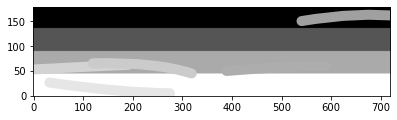

0.0034948993249893953
Processing: WE=2.0, WG=0.5, WI=0.5, Species=0
Processing: WE=2.0, WG=0.5, WI=0.5, Species=1
Processing: WE=2.0, WG=0.5, WI=0.5, Species=2
Processing: WE=2.0, WG=0.5, WI=0.5, Species=3
Processing: WE=2.0, WG=0.5, WI=0.5, Species=4


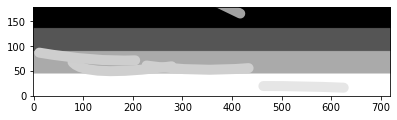

0.0031888273304799884
Processing: WE=2.0, WG=0.5, WI=1.0, Species=0
Processing: WE=2.0, WG=0.5, WI=1.0, Species=1
Processing: WE=2.0, WG=0.5, WI=1.0, Species=2
Processing: WE=2.0, WG=0.5, WI=1.0, Species=3
Processing: WE=2.0, WG=0.5, WI=1.0, Species=4


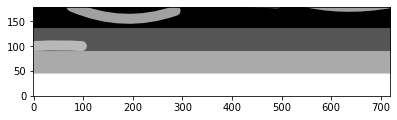

0.0015835410112004325
Processing: WE=2.0, WG=0.5, WI=1.5, Species=0
Processing: WE=2.0, WG=0.5, WI=1.5, Species=1
Processing: WE=2.0, WG=0.5, WI=1.5, Species=2
Processing: WE=2.0, WG=0.5, WI=1.5, Species=3
Processing: WE=2.0, WG=0.5, WI=1.5, Species=4


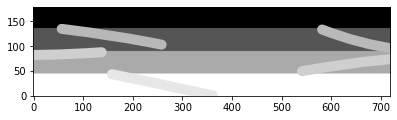

0.0038303332996591152
Processing: WE=2.0, WG=0.5, WI=2.0, Species=0
Processing: WE=2.0, WG=0.5, WI=2.0, Species=1
Processing: WE=2.0, WG=0.5, WI=2.0, Species=2
Processing: WE=2.0, WG=0.5, WI=2.0, Species=3
Processing: WE=2.0, WG=0.5, WI=2.0, Species=4


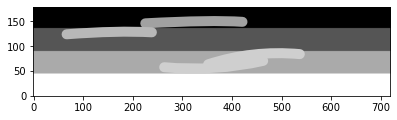

0.003549611450397029
Processing: WE=2.0, WG=0.5, WI=2.5, Species=0
Processing: WE=2.0, WG=0.5, WI=2.5, Species=1
Processing: WE=2.0, WG=0.5, WI=2.5, Species=2
Processing: WE=2.0, WG=0.5, WI=2.5, Species=3
Processing: WE=2.0, WG=0.5, WI=2.5, Species=4


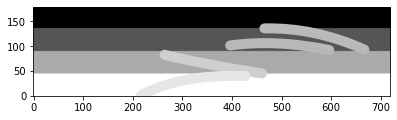

0.003794498117272039
Processing: WE=2.0, WG=0.5, WI=3.0, Species=0
Processing: WE=2.0, WG=0.5, WI=3.0, Species=1
Processing: WE=2.0, WG=0.5, WI=3.0, Species=2
Processing: WE=2.0, WG=0.5, WI=3.0, Species=3
Processing: WE=2.0, WG=0.5, WI=3.0, Species=4


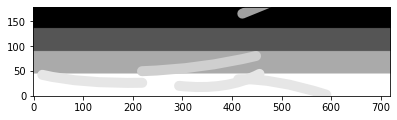

0.00439791103562272
Processing: WE=2.0, WG=0.5, WI=3.5, Species=0
Processing: WE=2.0, WG=0.5, WI=3.5, Species=1
Processing: WE=2.0, WG=0.5, WI=3.5, Species=2
Processing: WE=2.0, WG=0.5, WI=3.5, Species=3
Processing: WE=2.0, WG=0.5, WI=3.5, Species=4


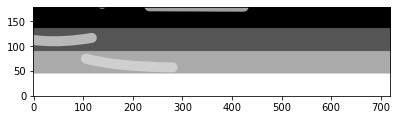

0.001834803976077254
Processing: WE=2.0, WG=0.5, WI=4.0, Species=0
Processing: WE=2.0, WG=0.5, WI=4.0, Species=1
Processing: WE=2.0, WG=0.5, WI=4.0, Species=2
Processing: WE=2.0, WG=0.5, WI=4.0, Species=3
Processing: WE=2.0, WG=0.5, WI=4.0, Species=4


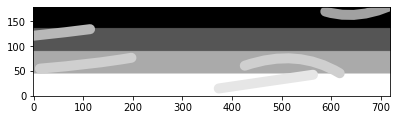

0.004229472111811971
Processing: WE=2.0, WG=1.0, WI=0.0, Species=0
Processing: WE=2.0, WG=1.0, WI=0.0, Species=1
Processing: WE=2.0, WG=1.0, WI=0.0, Species=2
Processing: WE=2.0, WG=1.0, WI=0.0, Species=3
Processing: WE=2.0, WG=1.0, WI=0.0, Species=4


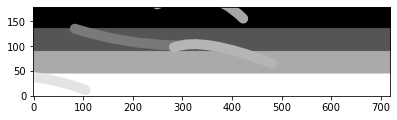

0.0026550788594469628
Processing: WE=2.0, WG=1.0, WI=0.5, Species=0
Processing: WE=2.0, WG=1.0, WI=0.5, Species=1
Processing: WE=2.0, WG=1.0, WI=0.5, Species=2
Processing: WE=2.0, WG=1.0, WI=0.5, Species=3
Processing: WE=2.0, WG=1.0, WI=0.5, Species=4


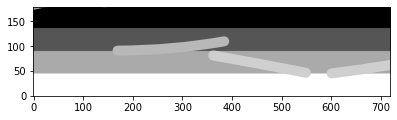

0.002773418298957771
Processing: WE=2.0, WG=1.0, WI=1.0, Species=0
Processing: WE=2.0, WG=1.0, WI=1.0, Species=1
Processing: WE=2.0, WG=1.0, WI=1.0, Species=2
Processing: WE=2.0, WG=1.0, WI=1.0, Species=3
Processing: WE=2.0, WG=1.0, WI=1.0, Species=4


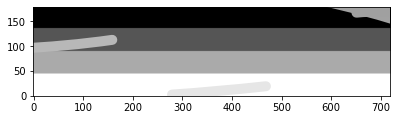

0.0019884262438929143
Processing: WE=2.0, WG=1.0, WI=1.5, Species=0
Processing: WE=2.0, WG=1.0, WI=1.5, Species=1
Processing: WE=2.0, WG=1.0, WI=1.5, Species=2
Processing: WE=2.0, WG=1.0, WI=1.5, Species=3
Processing: WE=2.0, WG=1.0, WI=1.5, Species=4


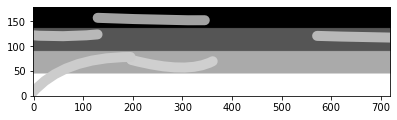

0.004184896168334267
Processing: WE=2.0, WG=1.0, WI=2.0, Species=0
Processing: WE=2.0, WG=1.0, WI=2.0, Species=1
Processing: WE=2.0, WG=1.0, WI=2.0, Species=2
Processing: WE=2.0, WG=1.0, WI=2.0, Species=3
Processing: WE=2.0, WG=1.0, WI=2.0, Species=4


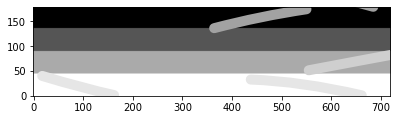

0.004371863179955748
Processing: WE=2.0, WG=1.0, WI=2.5, Species=0
Processing: WE=2.0, WG=1.0, WI=2.5, Species=1
Processing: WE=2.0, WG=1.0, WI=2.5, Species=2
Processing: WE=2.0, WG=1.0, WI=2.5, Species=3
Processing: WE=2.0, WG=1.0, WI=2.5, Species=4


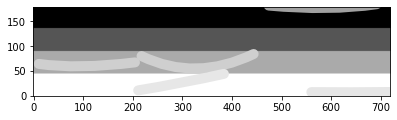

0.004125358212524048
Processing: WE=2.0, WG=1.0, WI=3.0, Species=0
Processing: WE=2.0, WG=1.0, WI=3.0, Species=1
Processing: WE=2.0, WG=1.0, WI=3.0, Species=2
Processing: WE=2.0, WG=1.0, WI=3.0, Species=3
Processing: WE=2.0, WG=1.0, WI=3.0, Species=4


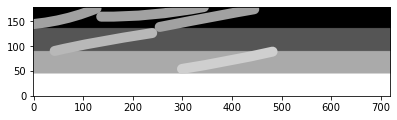

0.004154565145924438
Processing: WE=2.0, WG=1.0, WI=3.5, Species=0
Processing: WE=2.0, WG=1.0, WI=3.5, Species=1
Processing: WE=2.0, WG=1.0, WI=3.5, Species=2
Processing: WE=2.0, WG=1.0, WI=3.5, Species=3
Processing: WE=2.0, WG=1.0, WI=3.5, Species=4


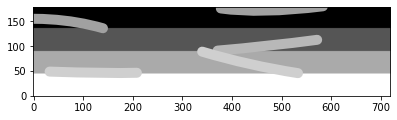

0.003817280300558144
Processing: WE=2.0, WG=1.0, WI=4.0, Species=0
Processing: WE=2.0, WG=1.0, WI=4.0, Species=1
Processing: WE=2.0, WG=1.0, WI=4.0, Species=2
Processing: WE=2.0, WG=1.0, WI=4.0, Species=3
Processing: WE=2.0, WG=1.0, WI=4.0, Species=4


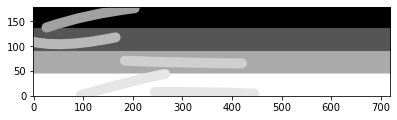

0.0047482004279775095
Processing: WE=2.0, WG=1.5, WI=0.0, Species=0
Processing: WE=2.0, WG=1.5, WI=0.0, Species=1
Processing: WE=2.0, WG=1.5, WI=0.0, Species=2
Processing: WE=2.0, WG=1.5, WI=0.0, Species=3
Processing: WE=2.0, WG=1.5, WI=0.0, Species=4


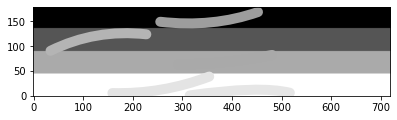

0.004995897317376114
Processing: WE=2.0, WG=1.5, WI=0.5, Species=0
Processing: WE=2.0, WG=1.5, WI=0.5, Species=1
Processing: WE=2.0, WG=1.5, WI=0.5, Species=2
Processing: WE=2.0, WG=1.5, WI=0.5, Species=3
Processing: WE=2.0, WG=1.5, WI=0.5, Species=4


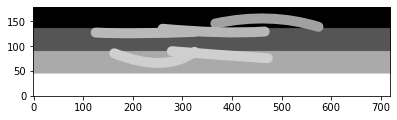

0.004429249861972045
Processing: WE=2.0, WG=1.5, WI=1.0, Species=0
Processing: WE=2.0, WG=1.5, WI=1.0, Species=1
Processing: WE=2.0, WG=1.5, WI=1.0, Species=2
Processing: WE=2.0, WG=1.5, WI=1.0, Species=3
Processing: WE=2.0, WG=1.5, WI=1.0, Species=4


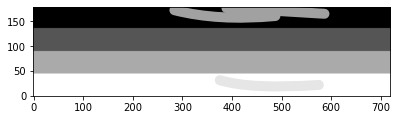

0.00261247976215827
Processing: WE=2.0, WG=1.5, WI=1.5, Species=0
Processing: WE=2.0, WG=1.5, WI=1.5, Species=1
Processing: WE=2.0, WG=1.5, WI=1.5, Species=2
Processing: WE=2.0, WG=1.5, WI=1.5, Species=3
Processing: WE=2.0, WG=1.5, WI=1.5, Species=4


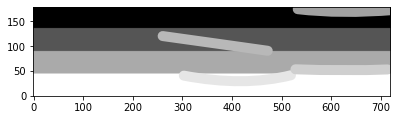

0.003939292410194616
Processing: WE=2.0, WG=1.5, WI=2.0, Species=0
Processing: WE=2.0, WG=1.5, WI=2.0, Species=1
Processing: WE=2.0, WG=1.5, WI=2.0, Species=2
Processing: WE=2.0, WG=1.5, WI=2.0, Species=3
Processing: WE=2.0, WG=1.5, WI=2.0, Species=4


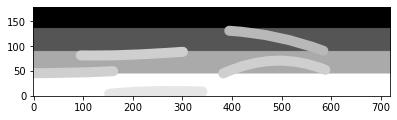

0.004787320663590442
Processing: WE=2.0, WG=1.5, WI=2.5, Species=0
Processing: WE=2.0, WG=1.5, WI=2.5, Species=1
Processing: WE=2.0, WG=1.5, WI=2.5, Species=2
Processing: WE=2.0, WG=1.5, WI=2.5, Species=3
Processing: WE=2.0, WG=1.5, WI=2.5, Species=4


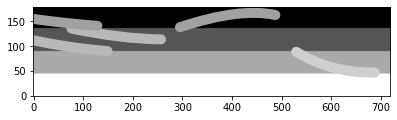

0.003846952374238302
Processing: WE=2.0, WG=1.5, WI=3.0, Species=0
Processing: WE=2.0, WG=1.5, WI=3.0, Species=1
Processing: WE=2.0, WG=1.5, WI=3.0, Species=2
Processing: WE=2.0, WG=1.5, WI=3.0, Species=3
Processing: WE=2.0, WG=1.5, WI=3.0, Species=4


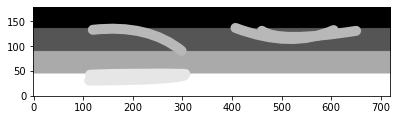

0.0039007245286639056
Processing: WE=2.0, WG=1.5, WI=3.5, Species=0
Processing: WE=2.0, WG=1.5, WI=3.5, Species=1
Processing: WE=2.0, WG=1.5, WI=3.5, Species=2
Processing: WE=2.0, WG=1.5, WI=3.5, Species=3
Processing: WE=2.0, WG=1.5, WI=3.5, Species=4


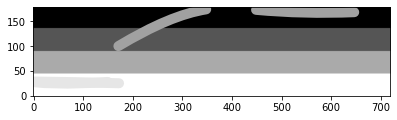

0.0029997865684445444
Processing: WE=2.0, WG=1.5, WI=4.0, Species=0
Processing: WE=2.0, WG=1.5, WI=4.0, Species=1
Processing: WE=2.0, WG=1.5, WI=4.0, Species=2
Processing: WE=2.0, WG=1.5, WI=4.0, Species=3
Processing: WE=2.0, WG=1.5, WI=4.0, Species=4


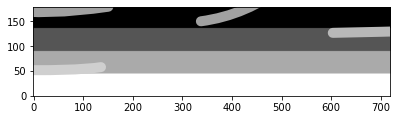

0.002188087708983046
Processing: WE=2.0, WG=2.0, WI=0.0, Species=0
Processing: WE=2.0, WG=2.0, WI=0.0, Species=1
Processing: WE=2.0, WG=2.0, WI=0.0, Species=2
Processing: WE=2.0, WG=2.0, WI=0.0, Species=3
Processing: WE=2.0, WG=2.0, WI=0.0, Species=4


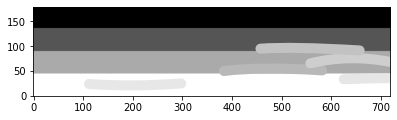

0.004698982772124627
Processing: WE=2.0, WG=2.0, WI=0.5, Species=0
Processing: WE=2.0, WG=2.0, WI=0.5, Species=1
Processing: WE=2.0, WG=2.0, WI=0.5, Species=2
Processing: WE=2.0, WG=2.0, WI=0.5, Species=3
Processing: WE=2.0, WG=2.0, WI=0.5, Species=4


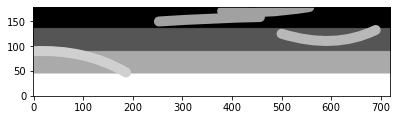

0.0036928843469878655
Processing: WE=2.0, WG=2.0, WI=1.0, Species=0
Processing: WE=2.0, WG=2.0, WI=1.0, Species=1
Processing: WE=2.0, WG=2.0, WI=1.0, Species=2
Processing: WE=2.0, WG=2.0, WI=1.0, Species=3
Processing: WE=2.0, WG=2.0, WI=1.0, Species=4


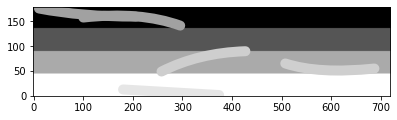

0.0035641470841397582
Processing: WE=2.0, WG=2.0, WI=1.5, Species=0
Processing: WE=2.0, WG=2.0, WI=1.5, Species=1
Processing: WE=2.0, WG=2.0, WI=1.5, Species=2
Processing: WE=2.0, WG=2.0, WI=1.5, Species=3
Processing: WE=2.0, WG=2.0, WI=1.5, Species=4


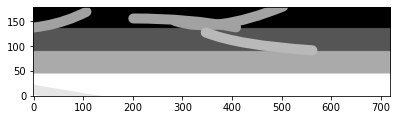

0.0036075214152280627
Processing: WE=2.0, WG=2.0, WI=2.0, Species=0
Processing: WE=2.0, WG=2.0, WI=2.0, Species=1
Processing: WE=2.0, WG=2.0, WI=2.0, Species=2
Processing: WE=2.0, WG=2.0, WI=2.0, Species=3
Processing: WE=2.0, WG=2.0, WI=2.0, Species=4


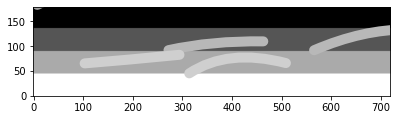

0.0036604214316291028
Processing: WE=2.0, WG=2.0, WI=2.5, Species=0
Processing: WE=2.0, WG=2.0, WI=2.5, Species=1
Processing: WE=2.0, WG=2.0, WI=2.5, Species=2
Processing: WE=2.0, WG=2.0, WI=2.5, Species=3
Processing: WE=2.0, WG=2.0, WI=2.5, Species=4


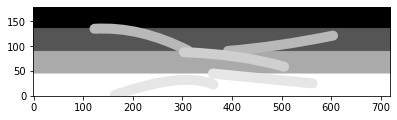

0.005349985355349004
Processing: WE=2.0, WG=2.0, WI=3.0, Species=0
Processing: WE=2.0, WG=2.0, WI=3.0, Species=1
Processing: WE=2.0, WG=2.0, WI=3.0, Species=2
Processing: WE=2.0, WG=2.0, WI=3.0, Species=3
Processing: WE=2.0, WG=2.0, WI=3.0, Species=4


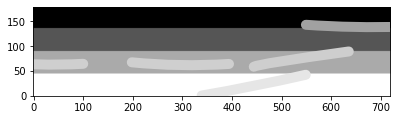

0.004206970950778226
Processing: WE=2.0, WG=2.0, WI=3.5, Species=0
Processing: WE=2.0, WG=2.0, WI=3.5, Species=1
Processing: WE=2.0, WG=2.0, WI=3.5, Species=2
Processing: WE=2.0, WG=2.0, WI=3.5, Species=3
Processing: WE=2.0, WG=2.0, WI=3.5, Species=4


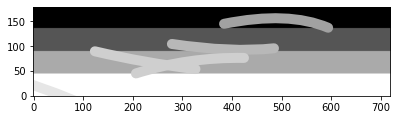

0.004265743363211329
Processing: WE=2.0, WG=2.0, WI=4.0, Species=0
Processing: WE=2.0, WG=2.0, WI=4.0, Species=1
Processing: WE=2.0, WG=2.0, WI=4.0, Species=2
Processing: WE=2.0, WG=2.0, WI=4.0, Species=3
Processing: WE=2.0, WG=2.0, WI=4.0, Species=4


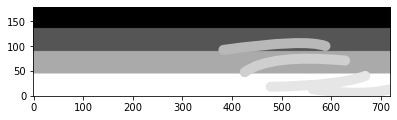

0.004042960550047762
Processing: WE=2.0, WG=2.5, WI=0.0, Species=0
Processing: WE=2.0, WG=2.5, WI=0.0, Species=1
Processing: WE=2.0, WG=2.5, WI=0.0, Species=2
Processing: WE=2.0, WG=2.5, WI=0.0, Species=3
Processing: WE=2.0, WG=2.5, WI=0.0, Species=4


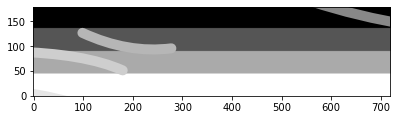

0.0028025186377107153
Processing: WE=2.0, WG=2.5, WI=0.5, Species=0
Processing: WE=2.0, WG=2.5, WI=0.5, Species=1
Processing: WE=2.0, WG=2.5, WI=0.5, Species=2
Processing: WE=2.0, WG=2.5, WI=0.5, Species=3
Processing: WE=2.0, WG=2.5, WI=0.5, Species=4


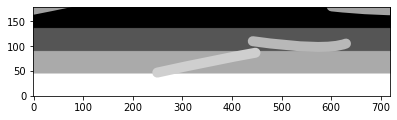

0.0028484706211827308
Processing: WE=2.0, WG=2.5, WI=1.0, Species=0
Processing: WE=2.0, WG=2.5, WI=1.0, Species=1
Processing: WE=2.0, WG=2.5, WI=1.0, Species=2
Processing: WE=2.0, WG=2.5, WI=1.0, Species=3
Processing: WE=2.0, WG=2.5, WI=1.0, Species=4


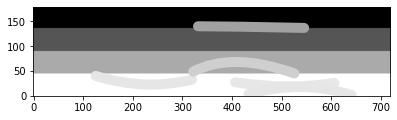

0.005237750882010142
Processing: WE=2.0, WG=2.5, WI=1.5, Species=0
Processing: WE=2.0, WG=2.5, WI=1.5, Species=1
Processing: WE=2.0, WG=2.5, WI=1.5, Species=2
Processing: WE=2.0, WG=2.5, WI=1.5, Species=3
Processing: WE=2.0, WG=2.5, WI=1.5, Species=4


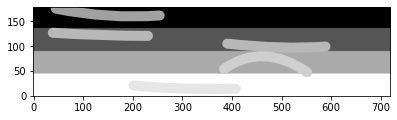

0.004915505572356325
Processing: WE=2.0, WG=2.5, WI=2.0, Species=0
Processing: WE=2.0, WG=2.5, WI=2.0, Species=1
Processing: WE=2.0, WG=2.5, WI=2.0, Species=2
Processing: WE=2.0, WG=2.5, WI=2.0, Species=3
Processing: WE=2.0, WG=2.5, WI=2.0, Species=4


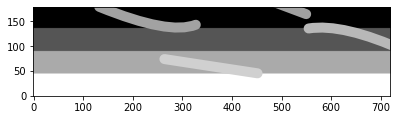

0.003927683284045422
Processing: WE=2.0, WG=2.5, WI=2.5, Species=0
Processing: WE=2.0, WG=2.5, WI=2.5, Species=1
Processing: WE=2.0, WG=2.5, WI=2.5, Species=2
Processing: WE=2.0, WG=2.5, WI=2.5, Species=3
Processing: WE=2.0, WG=2.5, WI=2.5, Species=4


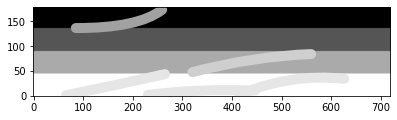

0.00569362711787212
Processing: WE=2.0, WG=2.5, WI=3.0, Species=0
Processing: WE=2.0, WG=2.5, WI=3.0, Species=1
Processing: WE=2.0, WG=2.5, WI=3.0, Species=2
Processing: WE=2.0, WG=2.5, WI=3.0, Species=3
Processing: WE=2.0, WG=2.5, WI=3.0, Species=4


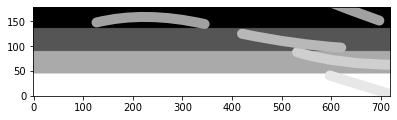

0.003668813337509905
Processing: WE=2.0, WG=2.5, WI=3.5, Species=0
Processing: WE=2.0, WG=2.5, WI=3.5, Species=1
Processing: WE=2.0, WG=2.5, WI=3.5, Species=2
Processing: WE=2.0, WG=2.5, WI=3.5, Species=3
Processing: WE=2.0, WG=2.5, WI=3.5, Species=4


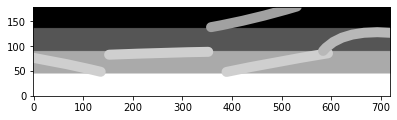

0.004232282334335565
Processing: WE=2.0, WG=2.5, WI=4.0, Species=0
Processing: WE=2.0, WG=2.5, WI=4.0, Species=1
Processing: WE=2.0, WG=2.5, WI=4.0, Species=2
Processing: WE=2.0, WG=2.5, WI=4.0, Species=3
Processing: WE=2.0, WG=2.5, WI=4.0, Species=4


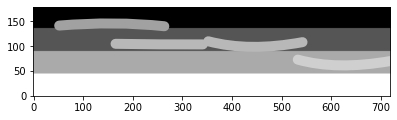

0.0038111947152311876
Processing: WE=2.0, WG=3.0, WI=0.0, Species=0
Processing: WE=2.0, WG=3.0, WI=0.0, Species=1
Processing: WE=2.0, WG=3.0, WI=0.0, Species=2
Processing: WE=2.0, WG=3.0, WI=0.0, Species=3
Processing: WE=2.0, WG=3.0, WI=0.0, Species=4


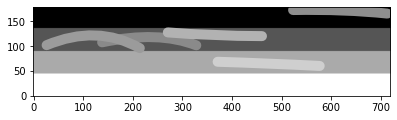

0.006835139506956149
Processing: WE=2.0, WG=3.0, WI=0.5, Species=0
Processing: WE=2.0, WG=3.0, WI=0.5, Species=1
Processing: WE=2.0, WG=3.0, WI=0.5, Species=2
Processing: WE=2.0, WG=3.0, WI=0.5, Species=3
Processing: WE=2.0, WG=3.0, WI=0.5, Species=4


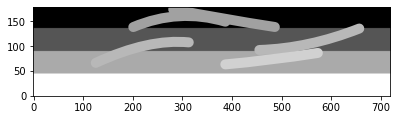

0.005950704336246032
Processing: WE=2.0, WG=3.0, WI=1.0, Species=0
Processing: WE=2.0, WG=3.0, WI=1.0, Species=1
Processing: WE=2.0, WG=3.0, WI=1.0, Species=2
Processing: WE=2.0, WG=3.0, WI=1.0, Species=3
Processing: WE=2.0, WG=3.0, WI=1.0, Species=4


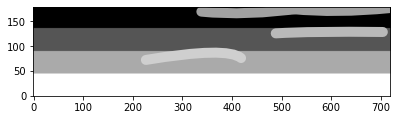

0.0029346766196996113
Processing: WE=2.0, WG=3.0, WI=1.5, Species=0
Processing: WE=2.0, WG=3.0, WI=1.5, Species=1
Processing: WE=2.0, WG=3.0, WI=1.5, Species=2
Processing: WE=2.0, WG=3.0, WI=1.5, Species=3
Processing: WE=2.0, WG=3.0, WI=1.5, Species=4


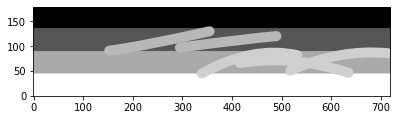

0.004665182578461533
Processing: WE=2.0, WG=3.0, WI=2.0, Species=0
Processing: WE=2.0, WG=3.0, WI=2.0, Species=1
Processing: WE=2.0, WG=3.0, WI=2.0, Species=2
Processing: WE=2.0, WG=3.0, WI=2.0, Species=3
Processing: WE=2.0, WG=3.0, WI=2.0, Species=4


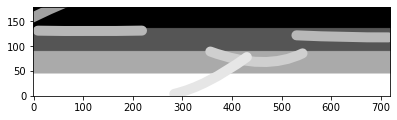

0.004105957986688751
Processing: WE=2.0, WG=3.0, WI=2.5, Species=0
Processing: WE=2.0, WG=3.0, WI=2.5, Species=1
Processing: WE=2.0, WG=3.0, WI=2.5, Species=2
Processing: WE=2.0, WG=3.0, WI=2.5, Species=3
Processing: WE=2.0, WG=3.0, WI=2.5, Species=4


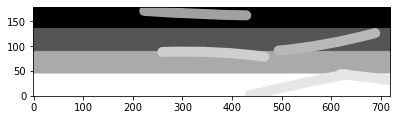

0.004570739720823773
Processing: WE=2.0, WG=3.0, WI=3.0, Species=0
Processing: WE=2.0, WG=3.0, WI=3.0, Species=1
Processing: WE=2.0, WG=3.0, WI=3.0, Species=2
Processing: WE=2.0, WG=3.0, WI=3.0, Species=3
Processing: WE=2.0, WG=3.0, WI=3.0, Species=4


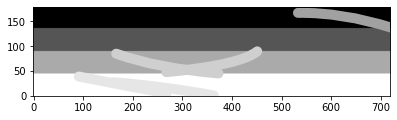

0.004185012453404209
Processing: WE=2.0, WG=3.0, WI=3.5, Species=0
Processing: WE=2.0, WG=3.0, WI=3.5, Species=1
Processing: WE=2.0, WG=3.0, WI=3.5, Species=2
Processing: WE=2.0, WG=3.0, WI=3.5, Species=3
Processing: WE=2.0, WG=3.0, WI=3.5, Species=4


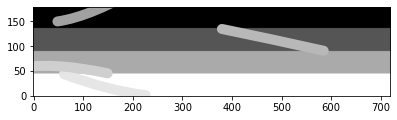

0.003131547243111139
Processing: WE=2.0, WG=3.0, WI=4.0, Species=0
Processing: WE=2.0, WG=3.0, WI=4.0, Species=1
Processing: WE=2.0, WG=3.0, WI=4.0, Species=2
Processing: WE=2.0, WG=3.0, WI=4.0, Species=3
Processing: WE=2.0, WG=3.0, WI=4.0, Species=4


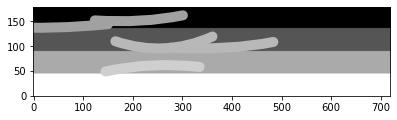

0.004374198571777081
Processing: WE=2.0, WG=3.5, WI=0.0, Species=0
Processing: WE=2.0, WG=3.5, WI=0.0, Species=1
Processing: WE=2.0, WG=3.5, WI=0.0, Species=2
Processing: WE=2.0, WG=3.5, WI=0.0, Species=3
Processing: WE=2.0, WG=3.5, WI=0.0, Species=4


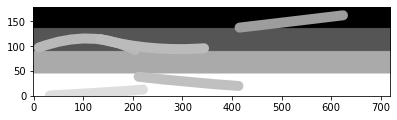

0.005238293545669871
Processing: WE=2.0, WG=3.5, WI=0.5, Species=0
Processing: WE=2.0, WG=3.5, WI=0.5, Species=1
Processing: WE=2.0, WG=3.5, WI=0.5, Species=2
Processing: WE=2.0, WG=3.5, WI=0.5, Species=3
Processing: WE=2.0, WG=3.5, WI=0.5, Species=4


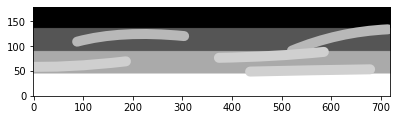

0.006461564029345507
Processing: WE=2.0, WG=3.5, WI=1.0, Species=0
Processing: WE=2.0, WG=3.5, WI=1.0, Species=1
Processing: WE=2.0, WG=3.5, WI=1.0, Species=2
Processing: WE=2.0, WG=3.5, WI=1.0, Species=3
Processing: WE=2.0, WG=3.5, WI=1.0, Species=4


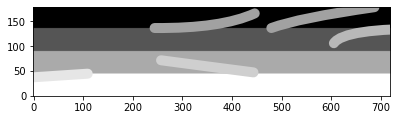

0.00411817760945514
Processing: WE=2.0, WG=3.5, WI=1.5, Species=0
Processing: WE=2.0, WG=3.5, WI=1.5, Species=1
Processing: WE=2.0, WG=3.5, WI=1.5, Species=2
Processing: WE=2.0, WG=3.5, WI=1.5, Species=3
Processing: WE=2.0, WG=3.5, WI=1.5, Species=4


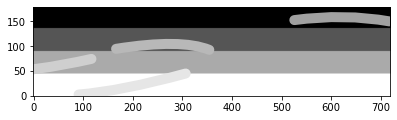

0.0035802234950592163
Processing: WE=2.0, WG=3.5, WI=2.0, Species=0
Processing: WE=2.0, WG=3.5, WI=2.0, Species=1
Processing: WE=2.0, WG=3.5, WI=2.0, Species=2
Processing: WE=2.0, WG=3.5, WI=2.0, Species=3
Processing: WE=2.0, WG=3.5, WI=2.0, Species=4


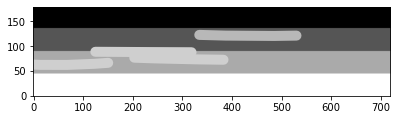

0.0033455020813816217
Processing: WE=2.0, WG=3.5, WI=2.5, Species=0
Processing: WE=2.0, WG=3.5, WI=2.5, Species=1
Processing: WE=2.0, WG=3.5, WI=2.5, Species=2
Processing: WE=2.0, WG=3.5, WI=2.5, Species=3
Processing: WE=2.0, WG=3.5, WI=2.5, Species=4


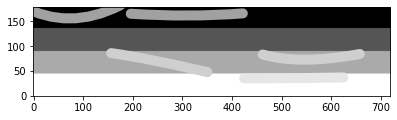

0.0048336215022722825
Processing: WE=2.0, WG=3.5, WI=3.0, Species=0
Processing: WE=2.0, WG=3.5, WI=3.0, Species=1
Processing: WE=2.0, WG=3.5, WI=3.0, Species=2
Processing: WE=2.0, WG=3.5, WI=3.0, Species=3
Processing: WE=2.0, WG=3.5, WI=3.0, Species=4


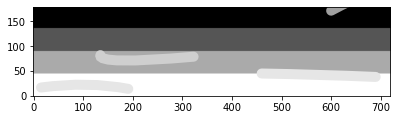

0.003283822542199973
Processing: WE=2.0, WG=3.5, WI=3.5, Species=0
Processing: WE=2.0, WG=3.5, WI=3.5, Species=1
Processing: WE=2.0, WG=3.5, WI=3.5, Species=2
Processing: WE=2.0, WG=3.5, WI=3.5, Species=3
Processing: WE=2.0, WG=3.5, WI=3.5, Species=4


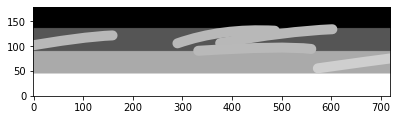

0.004376834366695762
Processing: WE=2.0, WG=3.5, WI=4.0, Species=0
Processing: WE=2.0, WG=3.5, WI=4.0, Species=1
Processing: WE=2.0, WG=3.5, WI=4.0, Species=2
Processing: WE=2.0, WG=3.5, WI=4.0, Species=3
Processing: WE=2.0, WG=3.5, WI=4.0, Species=4


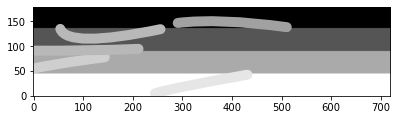

0.005328404784452298
Processing: WE=2.0, WG=4.0, WI=0.0, Species=0
Processing: WE=2.0, WG=4.0, WI=0.0, Species=1
Processing: WE=2.0, WG=4.0, WI=0.0, Species=2
Processing: WE=2.0, WG=4.0, WI=0.0, Species=3
Processing: WE=2.0, WG=4.0, WI=0.0, Species=4


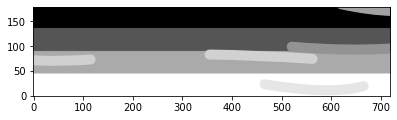

0.005150246366878911
Processing: WE=2.0, WG=4.0, WI=0.5, Species=0
Processing: WE=2.0, WG=4.0, WI=0.5, Species=1
Processing: WE=2.0, WG=4.0, WI=0.5, Species=2
Processing: WE=2.0, WG=4.0, WI=0.5, Species=3
Processing: WE=2.0, WG=4.0, WI=0.5, Species=4


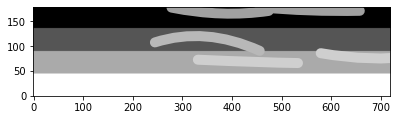

0.004093389508712538
Processing: WE=2.0, WG=4.0, WI=1.0, Species=0
Processing: WE=2.0, WG=4.0, WI=1.0, Species=1
Processing: WE=2.0, WG=4.0, WI=1.0, Species=2
Processing: WE=2.0, WG=4.0, WI=1.0, Species=3
Processing: WE=2.0, WG=4.0, WI=1.0, Species=4


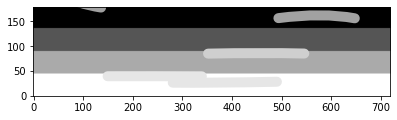

0.0038686007780924744
Processing: WE=2.0, WG=4.0, WI=1.5, Species=0
Processing: WE=2.0, WG=4.0, WI=1.5, Species=1
Processing: WE=2.0, WG=4.0, WI=1.5, Species=2
Processing: WE=2.0, WG=4.0, WI=1.5, Species=3
Processing: WE=2.0, WG=4.0, WI=1.5, Species=4


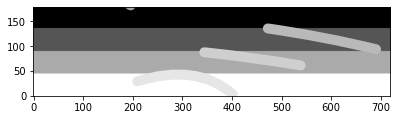

0.0027984389698402557
Processing: WE=2.0, WG=4.0, WI=2.0, Species=0
Processing: WE=2.0, WG=4.0, WI=2.0, Species=1
Processing: WE=2.0, WG=4.0, WI=2.0, Species=2
Processing: WE=2.0, WG=4.0, WI=2.0, Species=3
Processing: WE=2.0, WG=4.0, WI=2.0, Species=4


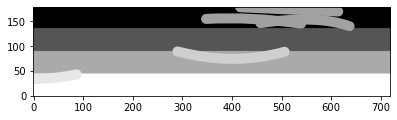

0.0027700363415069625
Processing: WE=2.0, WG=4.0, WI=2.5, Species=0
Processing: WE=2.0, WG=4.0, WI=2.5, Species=1
Processing: WE=2.0, WG=4.0, WI=2.5, Species=2
Processing: WE=2.0, WG=4.0, WI=2.5, Species=3
Processing: WE=2.0, WG=4.0, WI=2.5, Species=4


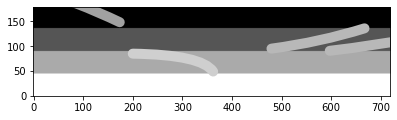

0.0028803327303467937
Processing: WE=2.0, WG=4.0, WI=3.0, Species=0
Processing: WE=2.0, WG=4.0, WI=3.0, Species=1
Processing: WE=2.0, WG=4.0, WI=3.0, Species=2
Processing: WE=2.0, WG=4.0, WI=3.0, Species=3
Processing: WE=2.0, WG=4.0, WI=3.0, Species=4


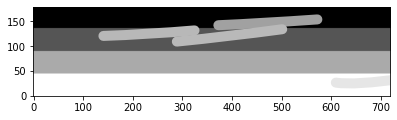

0.0029423998864282486
Processing: WE=2.0, WG=4.0, WI=3.5, Species=0
Processing: WE=2.0, WG=4.0, WI=3.5, Species=1
Processing: WE=2.0, WG=4.0, WI=3.5, Species=2
Processing: WE=2.0, WG=4.0, WI=3.5, Species=3
Processing: WE=2.0, WG=4.0, WI=3.5, Species=4


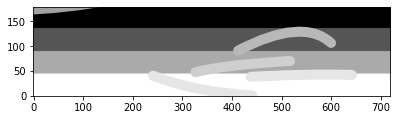

0.004353645185664862
Processing: WE=2.0, WG=4.0, WI=4.0, Species=0
Processing: WE=2.0, WG=4.0, WI=4.0, Species=1
Processing: WE=2.0, WG=4.0, WI=4.0, Species=2
Processing: WE=2.0, WG=4.0, WI=4.0, Species=3
Processing: WE=2.0, WG=4.0, WI=4.0, Species=4


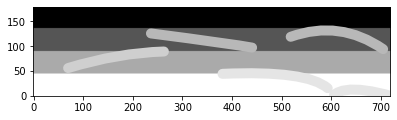

0.005442587032712686
Processing: WE=2.5, WG=0.0, WI=0.0, Species=0
Processing: WE=2.5, WG=0.0, WI=0.0, Species=1
Processing: WE=2.5, WG=0.0, WI=0.0, Species=2
Processing: WE=2.5, WG=0.0, WI=0.0, Species=3
Processing: WE=2.5, WG=0.0, WI=0.0, Species=4


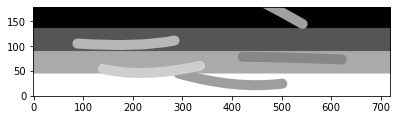

0.006075284407843719
Processing: WE=2.5, WG=0.0, WI=0.5, Species=0
Processing: WE=2.5, WG=0.0, WI=0.5, Species=1
Processing: WE=2.5, WG=0.0, WI=0.5, Species=2
Processing: WE=2.5, WG=0.0, WI=0.5, Species=3
Processing: WE=2.5, WG=0.0, WI=0.5, Species=4


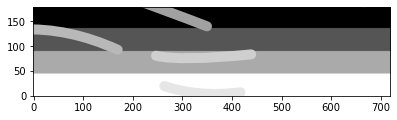

0.0032963910201761863
Processing: WE=2.5, WG=0.0, WI=1.0, Species=0
Processing: WE=2.5, WG=0.0, WI=1.0, Species=1
Processing: WE=2.5, WG=0.0, WI=1.0, Species=2
Processing: WE=2.5, WG=0.0, WI=1.0, Species=3
Processing: WE=2.5, WG=0.0, WI=1.0, Species=4


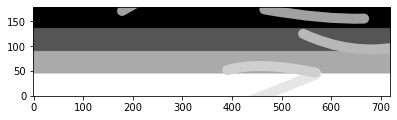

0.003375009417879362
Processing: WE=2.5, WG=0.0, WI=1.5, Species=0
Processing: WE=2.5, WG=0.0, WI=1.5, Species=1
Processing: WE=2.5, WG=0.0, WI=1.5, Species=2
Processing: WE=2.5, WG=0.0, WI=1.5, Species=3
Processing: WE=2.5, WG=0.0, WI=1.5, Species=4


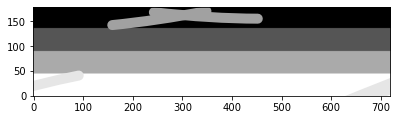

0.0024281582358779657
Processing: WE=2.5, WG=0.0, WI=2.0, Species=0
Processing: WE=2.5, WG=0.0, WI=2.0, Species=1
Processing: WE=2.5, WG=0.0, WI=2.0, Species=2
Processing: WE=2.5, WG=0.0, WI=2.0, Species=3
Processing: WE=2.5, WG=0.0, WI=2.0, Species=4


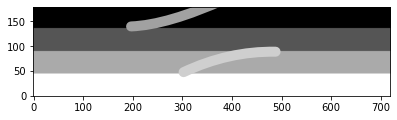

0.0016899030885072313
Processing: WE=2.5, WG=0.0, WI=2.5, Species=0
Processing: WE=2.5, WG=0.0, WI=2.5, Species=1
Processing: WE=2.5, WG=0.0, WI=2.5, Species=2
Processing: WE=2.5, WG=0.0, WI=2.5, Species=3
Processing: WE=2.5, WG=0.0, WI=2.5, Species=4


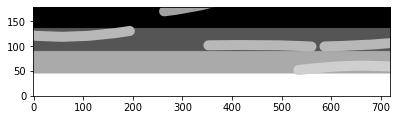

0.003598441489350105
Processing: WE=2.5, WG=0.0, WI=3.0, Species=0
Processing: WE=2.5, WG=0.0, WI=3.0, Species=1
Processing: WE=2.5, WG=0.0, WI=3.0, Species=2
Processing: WE=2.5, WG=0.0, WI=3.0, Species=3
Processing: WE=2.5, WG=0.0, WI=3.0, Species=4


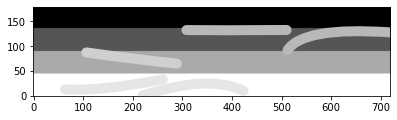

0.005765675409123581
Processing: WE=2.5, WG=0.0, WI=3.5, Species=0
Processing: WE=2.5, WG=0.0, WI=3.5, Species=1
Processing: WE=2.5, WG=0.0, WI=3.5, Species=2
Processing: WE=2.5, WG=0.0, WI=3.5, Species=3
Processing: WE=2.5, WG=0.0, WI=3.5, Species=4


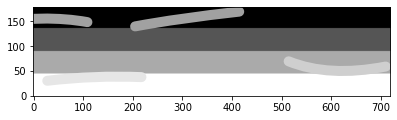

0.003536161143973756
Processing: WE=2.5, WG=0.0, WI=4.0, Species=0
Processing: WE=2.5, WG=0.0, WI=4.0, Species=1
Processing: WE=2.5, WG=0.0, WI=4.0, Species=2
Processing: WE=2.5, WG=0.0, WI=4.0, Species=3
Processing: WE=2.5, WG=0.0, WI=4.0, Species=4


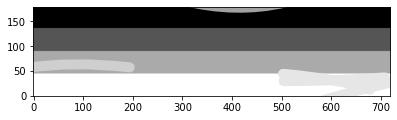

0.0033315091112986212
Processing: WE=2.5, WG=0.5, WI=0.0, Species=0
Processing: WE=2.5, WG=0.5, WI=0.0, Species=1
Processing: WE=2.5, WG=0.5, WI=0.0, Species=2
Processing: WE=2.5, WG=0.5, WI=0.0, Species=3
Processing: WE=2.5, WG=0.5, WI=0.0, Species=4


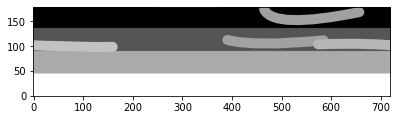

0.004173945990914745
Processing: WE=2.5, WG=0.5, WI=0.5, Species=0
Processing: WE=2.5, WG=0.5, WI=0.5, Species=1
Processing: WE=2.5, WG=0.5, WI=0.5, Species=2
Processing: WE=2.5, WG=0.5, WI=0.5, Species=3
Processing: WE=2.5, WG=0.5, WI=0.5, Species=4


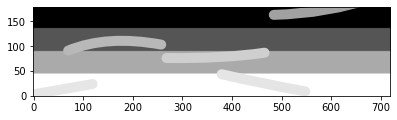

0.004673564793919841
Processing: WE=2.5, WG=0.5, WI=1.0, Species=0
Processing: WE=2.5, WG=0.5, WI=1.0, Species=1
Processing: WE=2.5, WG=0.5, WI=1.0, Species=2
Processing: WE=2.5, WG=0.5, WI=1.0, Species=3
Processing: WE=2.5, WG=0.5, WI=1.0, Species=4


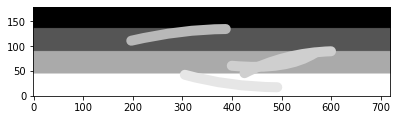

0.0034909940847238485
Processing: WE=2.5, WG=0.5, WI=1.5, Species=0
Processing: WE=2.5, WG=0.5, WI=1.5, Species=1
Processing: WE=2.5, WG=0.5, WI=1.5, Species=2
Processing: WE=2.5, WG=0.5, WI=1.5, Species=3
Processing: WE=2.5, WG=0.5, WI=1.5, Species=4


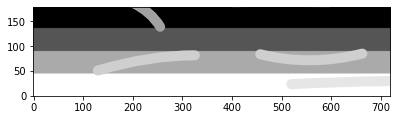

0.0036900644340417763
Processing: WE=2.5, WG=0.5, WI=2.0, Species=0
Processing: WE=2.5, WG=0.5, WI=2.0, Species=1
Processing: WE=2.5, WG=0.5, WI=2.0, Species=2
Processing: WE=2.5, WG=0.5, WI=2.0, Species=3
Processing: WE=2.5, WG=0.5, WI=2.0, Species=4


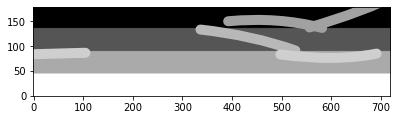

0.0038858594205563417
Processing: WE=2.5, WG=0.5, WI=2.5, Species=0
Processing: WE=2.5, WG=0.5, WI=2.5, Species=1
Processing: WE=2.5, WG=0.5, WI=2.5, Species=2
Processing: WE=2.5, WG=0.5, WI=2.5, Species=3
Processing: WE=2.5, WG=0.5, WI=2.5, Species=4


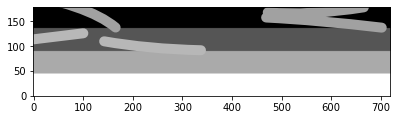

0.00388070411578892
Processing: WE=2.5, WG=0.5, WI=3.0, Species=0
Processing: WE=2.5, WG=0.5, WI=3.0, Species=1
Processing: WE=2.5, WG=0.5, WI=3.0, Species=2
Processing: WE=2.5, WG=0.5, WI=3.0, Species=3
Processing: WE=2.5, WG=0.5, WI=3.0, Species=4


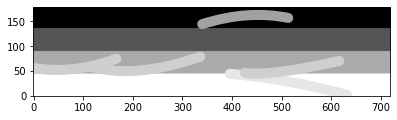

0.004423551893544895
Processing: WE=2.5, WG=0.5, WI=3.5, Species=0
Processing: WE=2.5, WG=0.5, WI=3.5, Species=1
Processing: WE=2.5, WG=0.5, WI=3.5, Species=2
Processing: WE=2.5, WG=0.5, WI=3.5, Species=3
Processing: WE=2.5, WG=0.5, WI=3.5, Species=4


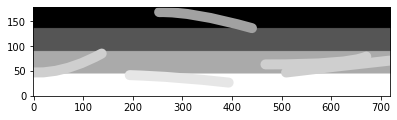

0.004341057326843657
Processing: WE=2.5, WG=0.5, WI=4.0, Species=0
Processing: WE=2.5, WG=0.5, WI=4.0, Species=1
Processing: WE=2.5, WG=0.5, WI=4.0, Species=2
Processing: WE=2.5, WG=0.5, WI=4.0, Species=3
Processing: WE=2.5, WG=0.5, WI=4.0, Species=4


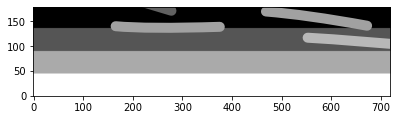

0.0034861101117862913
Processing: WE=2.5, WG=1.0, WI=0.0, Species=0
Processing: WE=2.5, WG=1.0, WI=0.0, Species=1
Processing: WE=2.5, WG=1.0, WI=0.0, Species=2
Processing: WE=2.5, WG=1.0, WI=0.0, Species=3
Processing: WE=2.5, WG=1.0, WI=0.0, Species=4


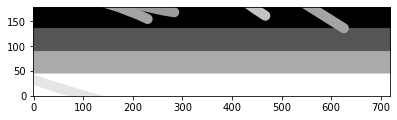

0.001705766310131797
Processing: WE=2.5, WG=1.0, WI=0.5, Species=0
Processing: WE=2.5, WG=1.0, WI=0.5, Species=1
Processing: WE=2.5, WG=1.0, WI=0.5, Species=2
Processing: WE=2.5, WG=1.0, WI=0.5, Species=3
Processing: WE=2.5, WG=1.0, WI=0.5, Species=4


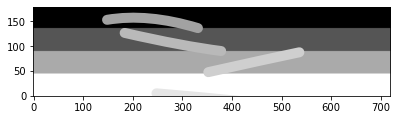

0.003292224138503271
Processing: WE=2.5, WG=1.0, WI=1.0, Species=0
Processing: WE=2.5, WG=1.0, WI=1.0, Species=1
Processing: WE=2.5, WG=1.0, WI=1.0, Species=2
Processing: WE=2.5, WG=1.0, WI=1.0, Species=3
Processing: WE=2.5, WG=1.0, WI=1.0, Species=4


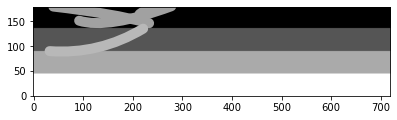

0.002416616942686239
Processing: WE=2.5, WG=1.0, WI=1.5, Species=0
Processing: WE=2.5, WG=1.0, WI=1.5, Species=1
Processing: WE=2.5, WG=1.0, WI=1.5, Species=2
Processing: WE=2.5, WG=1.0, WI=1.5, Species=3
Processing: WE=2.5, WG=1.0, WI=1.5, Species=4


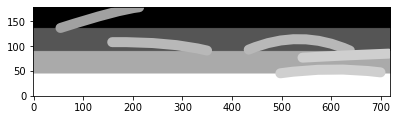

0.004412320693873012
Processing: WE=2.5, WG=1.0, WI=2.0, Species=0
Processing: WE=2.5, WG=1.0, WI=2.0, Species=1
Processing: WE=2.5, WG=1.0, WI=2.0, Species=2
Processing: WE=2.5, WG=1.0, WI=2.0, Species=3
Processing: WE=2.5, WG=1.0, WI=2.0, Species=4


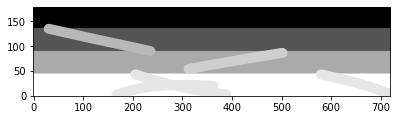

0.004714167664174532
Processing: WE=2.5, WG=1.0, WI=2.5, Species=0
Processing: WE=2.5, WG=1.0, WI=2.5, Species=1
Processing: WE=2.5, WG=1.0, WI=2.5, Species=2
Processing: WE=2.5, WG=1.0, WI=2.5, Species=3
Processing: WE=2.5, WG=1.0, WI=2.5, Species=4


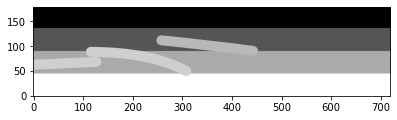

0.0026479660893355206
Processing: WE=2.5, WG=1.0, WI=3.0, Species=0
Processing: WE=2.5, WG=1.0, WI=3.0, Species=1
Processing: WE=2.5, WG=1.0, WI=3.0, Species=2
Processing: WE=2.5, WG=1.0, WI=3.0, Species=3
Processing: WE=2.5, WG=1.0, WI=3.0, Species=4


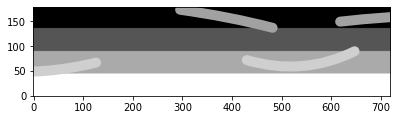

0.0030223652528582508
Processing: WE=2.5, WG=1.0, WI=3.5, Species=0
Processing: WE=2.5, WG=1.0, WI=3.5, Species=1
Processing: WE=2.5, WG=1.0, WI=3.5, Species=2
Processing: WE=2.5, WG=1.0, WI=3.5, Species=3
Processing: WE=2.5, WG=1.0, WI=3.5, Species=4


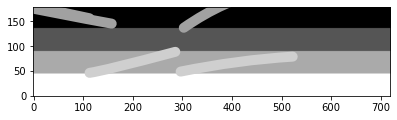

0.003072765140255542
Processing: WE=2.5, WG=1.0, WI=4.0, Species=0
Processing: WE=2.5, WG=1.0, WI=4.0, Species=1
Processing: WE=2.5, WG=1.0, WI=4.0, Species=2
Processing: WE=2.5, WG=1.0, WI=4.0, Species=3
Processing: WE=2.5, WG=1.0, WI=4.0, Species=4


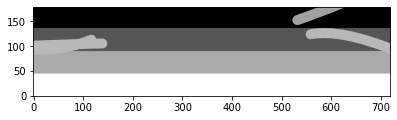

0.0019817592332162484
Processing: WE=2.5, WG=1.5, WI=0.0, Species=0
Processing: WE=2.5, WG=1.5, WI=0.0, Species=1
Processing: WE=2.5, WG=1.5, WI=0.0, Species=2
Processing: WE=2.5, WG=1.5, WI=0.0, Species=3
Processing: WE=2.5, WG=1.5, WI=0.0, Species=4


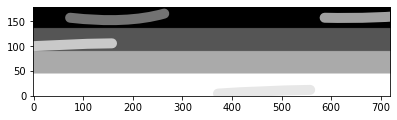

0.003982434171143037
Processing: WE=2.5, WG=1.5, WI=0.5, Species=0
Processing: WE=2.5, WG=1.5, WI=0.5, Species=1
Processing: WE=2.5, WG=1.5, WI=0.5, Species=2
Processing: WE=2.5, WG=1.5, WI=0.5, Species=3
Processing: WE=2.5, WG=1.5, WI=0.5, Species=4


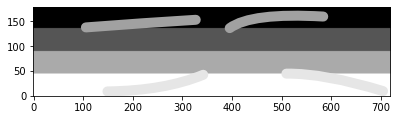

0.00433047538547895
Processing: WE=2.5, WG=1.5, WI=1.0, Species=0
Processing: WE=2.5, WG=1.5, WI=1.0, Species=1
Processing: WE=2.5, WG=1.5, WI=1.0, Species=2
Processing: WE=2.5, WG=1.5, WI=1.0, Species=3
Processing: WE=2.5, WG=1.5, WI=1.0, Species=4


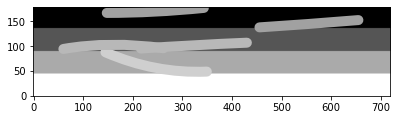

0.004526464180443419
Processing: WE=2.5, WG=1.5, WI=1.5, Species=0
Processing: WE=2.5, WG=1.5, WI=1.5, Species=1
Processing: WE=2.5, WG=1.5, WI=1.5, Species=2
Processing: WE=2.5, WG=1.5, WI=1.5, Species=3
Processing: WE=2.5, WG=1.5, WI=1.5, Species=4


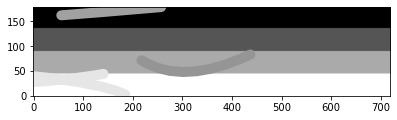

0.0042361294320661415
Processing: WE=2.5, WG=1.5, WI=2.0, Species=0
Processing: WE=2.5, WG=1.5, WI=2.0, Species=1
Processing: WE=2.5, WG=1.5, WI=2.0, Species=2
Processing: WE=2.5, WG=1.5, WI=2.0, Species=3
Processing: WE=2.5, WG=1.5, WI=2.0, Species=4


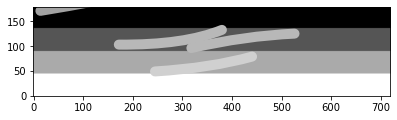

0.00395417689914717
Processing: WE=2.5, WG=1.5, WI=2.5, Species=0
Processing: WE=2.5, WG=1.5, WI=2.5, Species=1
Processing: WE=2.5, WG=1.5, WI=2.5, Species=2
Processing: WE=2.5, WG=1.5, WI=2.5, Species=3
Processing: WE=2.5, WG=1.5, WI=2.5, Species=4


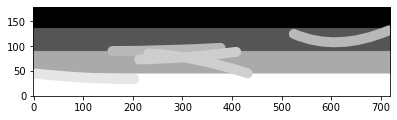

0.0038607127741814196
Processing: WE=2.5, WG=1.5, WI=3.0, Species=0
Processing: WE=2.5, WG=1.5, WI=3.0, Species=1
Processing: WE=2.5, WG=1.5, WI=3.0, Species=2
Processing: WE=2.5, WG=1.5, WI=3.0, Species=3
Processing: WE=2.5, WG=1.5, WI=3.0, Species=4


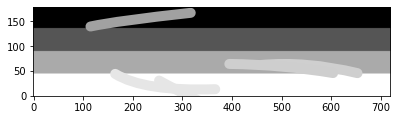

0.003075168365034339
Processing: WE=2.5, WG=1.5, WI=3.5, Species=0
Processing: WE=2.5, WG=1.5, WI=3.5, Species=1
Processing: WE=2.5, WG=1.5, WI=3.5, Species=2
Processing: WE=2.5, WG=1.5, WI=3.5, Species=3
Processing: WE=2.5, WG=1.5, WI=3.5, Species=4


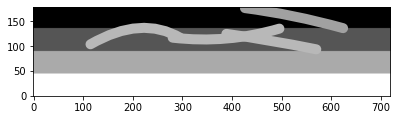

0.003454906951351898
Processing: WE=2.5, WG=1.5, WI=4.0, Species=0
Processing: WE=2.5, WG=1.5, WI=4.0, Species=1
Processing: WE=2.5, WG=1.5, WI=4.0, Species=2
Processing: WE=2.5, WG=1.5, WI=4.0, Species=3
Processing: WE=2.5, WG=1.5, WI=4.0, Species=4


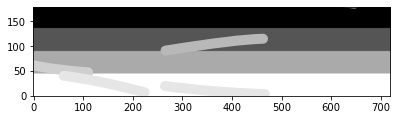

0.0036413312993136514
Processing: WE=2.5, WG=2.0, WI=0.0, Species=0
Processing: WE=2.5, WG=2.0, WI=0.0, Species=1
Processing: WE=2.5, WG=2.0, WI=0.0, Species=2
Processing: WE=2.5, WG=2.0, WI=0.0, Species=3
Processing: WE=2.5, WG=2.0, WI=0.0, Species=4


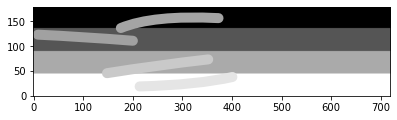

0.005547543998757688
Processing: WE=2.5, WG=2.0, WI=0.5, Species=0
Processing: WE=2.5, WG=2.0, WI=0.5, Species=1
Processing: WE=2.5, WG=2.0, WI=0.5, Species=2
Processing: WE=2.5, WG=2.0, WI=0.5, Species=3
Processing: WE=2.5, WG=2.0, WI=0.5, Species=4


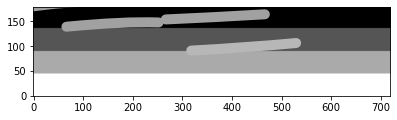

0.0034152828137692186
Processing: WE=2.5, WG=2.0, WI=1.0, Species=0
Processing: WE=2.5, WG=2.0, WI=1.0, Species=1
Processing: WE=2.5, WG=2.0, WI=1.0, Species=2
Processing: WE=2.5, WG=2.0, WI=1.0, Species=3
Processing: WE=2.5, WG=2.0, WI=1.0, Species=4


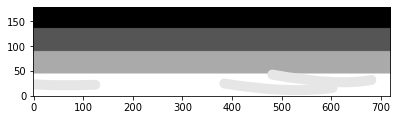

0.003186908626825948
Processing: WE=2.5, WG=2.0, WI=1.5, Species=0
Processing: WE=2.5, WG=2.0, WI=1.5, Species=1
Processing: WE=2.5, WG=2.0, WI=1.5, Species=2
Processing: WE=2.5, WG=2.0, WI=1.5, Species=3
Processing: WE=2.5, WG=2.0, WI=1.5, Species=4


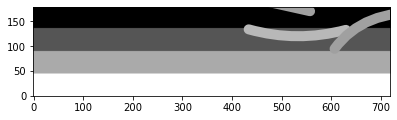

0.0019691229222825696
Processing: WE=2.5, WG=2.0, WI=2.0, Species=0
Processing: WE=2.5, WG=2.0, WI=2.0, Species=1
Processing: WE=2.5, WG=2.0, WI=2.0, Species=2
Processing: WE=2.5, WG=2.0, WI=2.0, Species=3
Processing: WE=2.5, WG=2.0, WI=2.0, Species=4


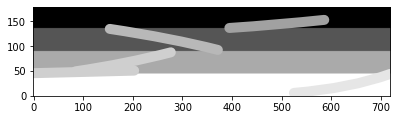

0.004764577241994318
Processing: WE=2.5, WG=2.0, WI=2.5, Species=0
Processing: WE=2.5, WG=2.0, WI=2.5, Species=1
Processing: WE=2.5, WG=2.0, WI=2.5, Species=2
Processing: WE=2.5, WG=2.0, WI=2.5, Species=3
Processing: WE=2.5, WG=2.0, WI=2.5, Species=4


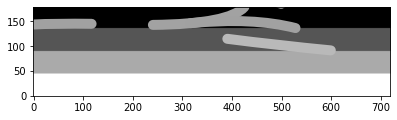

0.002907223652770843
Processing: WE=2.5, WG=2.0, WI=3.0, Species=0
Processing: WE=2.5, WG=2.0, WI=3.0, Species=1
Processing: WE=2.5, WG=2.0, WI=3.0, Species=2
Processing: WE=2.5, WG=2.0, WI=3.0, Species=3
Processing: WE=2.5, WG=2.0, WI=3.0, Species=4


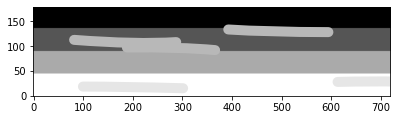

0.00483822445295748
Processing: WE=2.5, WG=2.0, WI=3.5, Species=0
Processing: WE=2.5, WG=2.0, WI=3.5, Species=1
Processing: WE=2.5, WG=2.0, WI=3.5, Species=2
Processing: WE=2.5, WG=2.0, WI=3.5, Species=3
Processing: WE=2.5, WG=2.0, WI=3.5, Species=4


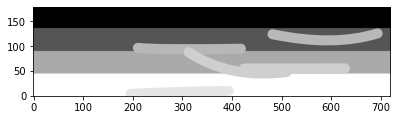

0.004987098413750516
Processing: WE=2.5, WG=2.0, WI=4.0, Species=0
Processing: WE=2.5, WG=2.0, WI=4.0, Species=1
Processing: WE=2.5, WG=2.0, WI=4.0, Species=2
Processing: WE=2.5, WG=2.0, WI=4.0, Species=3
Processing: WE=2.5, WG=2.0, WI=4.0, Species=4


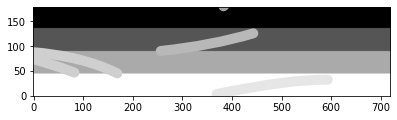

0.0036423487936756427
Processing: WE=2.5, WG=2.5, WI=0.0, Species=0
Processing: WE=2.5, WG=2.5, WI=0.0, Species=1
Processing: WE=2.5, WG=2.5, WI=0.0, Species=2
Processing: WE=2.5, WG=2.5, WI=0.0, Species=3
Processing: WE=2.5, WG=2.5, WI=0.0, Species=4


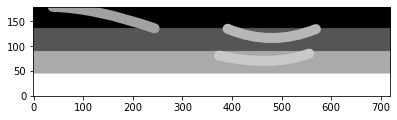

0.0039860971508462045
Processing: WE=2.5, WG=2.5, WI=0.5, Species=0
Processing: WE=2.5, WG=2.5, WI=0.5, Species=1
Processing: WE=2.5, WG=2.5, WI=0.5, Species=2
Processing: WE=2.5, WG=2.5, WI=0.5, Species=3
Processing: WE=2.5, WG=2.5, WI=0.5, Species=4


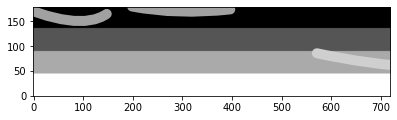

0.0020164412553264014
Processing: WE=2.5, WG=2.5, WI=1.0, Species=0
Processing: WE=2.5, WG=2.5, WI=1.0, Species=1
Processing: WE=2.5, WG=2.5, WI=1.0, Species=2
Processing: WE=2.5, WG=2.5, WI=1.0, Species=3
Processing: WE=2.5, WG=2.5, WI=1.0, Species=4


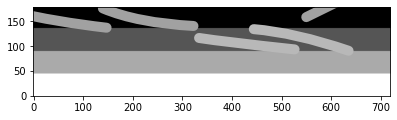

0.003832329526693117
Processing: WE=2.5, WG=2.5, WI=1.5, Species=0
Processing: WE=2.5, WG=2.5, WI=1.5, Species=1
Processing: WE=2.5, WG=2.5, WI=1.5, Species=2
Processing: WE=2.5, WG=2.5, WI=1.5, Species=3
Processing: WE=2.5, WG=2.5, WI=1.5, Species=4


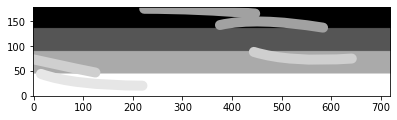

0.00459777599958525
Processing: WE=2.5, WG=2.5, WI=2.0, Species=0
Processing: WE=2.5, WG=2.5, WI=2.0, Species=1
Processing: WE=2.5, WG=2.5, WI=2.0, Species=2
Processing: WE=2.5, WG=2.5, WI=2.0, Species=3
Processing: WE=2.5, WG=2.5, WI=2.0, Species=4


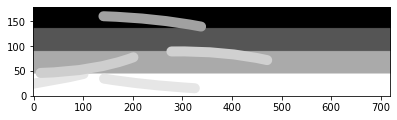

0.0043924843990254345
Processing: WE=2.5, WG=2.5, WI=2.5, Species=0
Processing: WE=2.5, WG=2.5, WI=2.5, Species=1
Processing: WE=2.5, WG=2.5, WI=2.5, Species=2
Processing: WE=2.5, WG=2.5, WI=2.5, Species=3
Processing: WE=2.5, WG=2.5, WI=2.5, Species=4


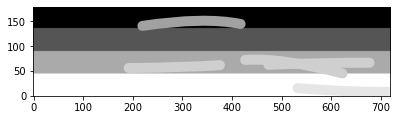

0.004533092429430104
Processing: WE=2.5, WG=2.5, WI=3.0, Species=0
Processing: WE=2.5, WG=2.5, WI=3.0, Species=1
Processing: WE=2.5, WG=2.5, WI=3.0, Species=2
Processing: WE=2.5, WG=2.5, WI=3.0, Species=3
Processing: WE=2.5, WG=2.5, WI=3.0, Species=4


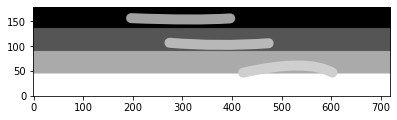

0.0026077895976706162
Processing: WE=2.5, WG=2.5, WI=3.5, Species=0
Processing: WE=2.5, WG=2.5, WI=3.5, Species=1
Processing: WE=2.5, WG=2.5, WI=3.5, Species=2
Processing: WE=2.5, WG=2.5, WI=3.5, Species=3
Processing: WE=2.5, WG=2.5, WI=3.5, Species=4


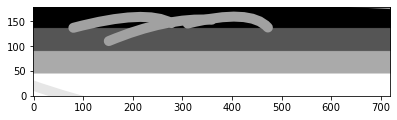

0.003028896597619984
Processing: WE=2.5, WG=2.5, WI=4.0, Species=0
Processing: WE=2.5, WG=2.5, WI=4.0, Species=1
Processing: WE=2.5, WG=2.5, WI=4.0, Species=2
Processing: WE=2.5, WG=2.5, WI=4.0, Species=3
Processing: WE=2.5, WG=2.5, WI=4.0, Species=4


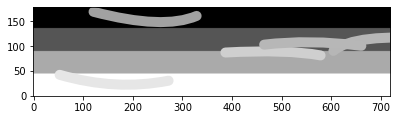

0.005325439515168781
Processing: WE=2.5, WG=3.0, WI=0.0, Species=0
Processing: WE=2.5, WG=3.0, WI=0.0, Species=1
Processing: WE=2.5, WG=3.0, WI=0.0, Species=2
Processing: WE=2.5, WG=3.0, WI=0.0, Species=3
Processing: WE=2.5, WG=3.0, WI=0.0, Species=4


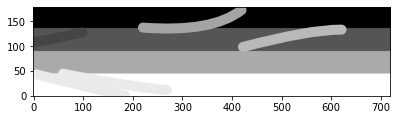

0.004651499701898378
Processing: WE=2.5, WG=3.0, WI=0.5, Species=0
Processing: WE=2.5, WG=3.0, WI=0.5, Species=1
Processing: WE=2.5, WG=3.0, WI=0.5, Species=2
Processing: WE=2.5, WG=3.0, WI=0.5, Species=3
Processing: WE=2.5, WG=3.0, WI=0.5, Species=4


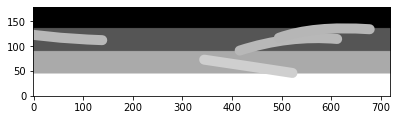

0.0037915037767210376
Processing: WE=2.5, WG=3.0, WI=1.0, Species=0
Processing: WE=2.5, WG=3.0, WI=1.0, Species=1
Processing: WE=2.5, WG=3.0, WI=1.0, Species=2
Processing: WE=2.5, WG=3.0, WI=1.0, Species=3
Processing: WE=2.5, WG=3.0, WI=1.0, Species=4


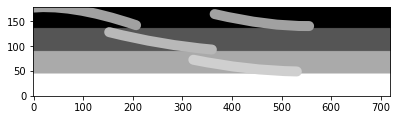

0.003744621512689487
Processing: WE=2.5, WG=3.0, WI=1.5, Species=0
Processing: WE=2.5, WG=3.0, WI=1.5, Species=1
Processing: WE=2.5, WG=3.0, WI=1.5, Species=2
Processing: WE=2.5, WG=3.0, WI=1.5, Species=3
Processing: WE=2.5, WG=3.0, WI=1.5, Species=4


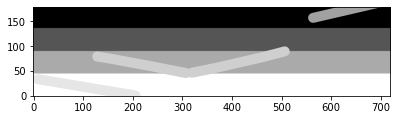

0.0033774998564606172
Processing: WE=2.5, WG=3.0, WI=2.0, Species=0
Processing: WE=2.5, WG=3.0, WI=2.0, Species=1
Processing: WE=2.5, WG=3.0, WI=2.0, Species=2
Processing: WE=2.5, WG=3.0, WI=2.0, Species=3
Processing: WE=2.5, WG=3.0, WI=2.0, Species=4


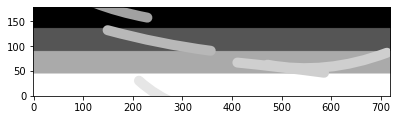

0.0034177151098155013
Processing: WE=2.5, WG=3.0, WI=2.5, Species=0
Processing: WE=2.5, WG=3.0, WI=2.5, Species=1
Processing: WE=2.5, WG=3.0, WI=2.5, Species=2
Processing: WE=2.5, WG=3.0, WI=2.5, Species=3
Processing: WE=2.5, WG=3.0, WI=2.5, Species=4


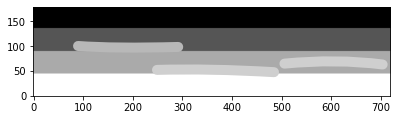

0.0031625953567856096
Processing: WE=2.5, WG=3.0, WI=3.0, Species=0
Processing: WE=2.5, WG=3.0, WI=3.0, Species=1
Processing: WE=2.5, WG=3.0, WI=3.0, Species=2
Processing: WE=2.5, WG=3.0, WI=3.0, Species=3
Processing: WE=2.5, WG=3.0, WI=3.0, Species=4


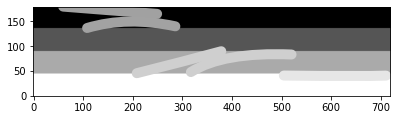

0.0047181213565525544
Processing: WE=2.5, WG=3.0, WI=3.5, Species=0
Processing: WE=2.5, WG=3.0, WI=3.5, Species=1
Processing: WE=2.5, WG=3.0, WI=3.5, Species=2
Processing: WE=2.5, WG=3.0, WI=3.5, Species=3
Processing: WE=2.5, WG=3.0, WI=3.5, Species=4


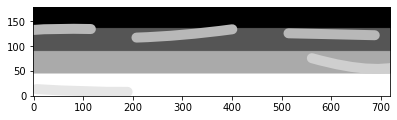

0.004388162470592596
Processing: WE=2.5, WG=3.0, WI=4.0, Species=0
Processing: WE=2.5, WG=3.0, WI=4.0, Species=1
Processing: WE=2.5, WG=3.0, WI=4.0, Species=2
Processing: WE=2.5, WG=3.0, WI=4.0, Species=3
Processing: WE=2.5, WG=3.0, WI=4.0, Species=4


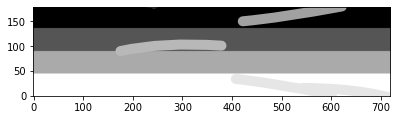

0.003633152582727742
Processing: WE=2.5, WG=3.5, WI=0.0, Species=0
Processing: WE=2.5, WG=3.5, WI=0.0, Species=1
Processing: WE=2.5, WG=3.5, WI=0.0, Species=2
Processing: WE=2.5, WG=3.5, WI=0.0, Species=3
Processing: WE=2.5, WG=3.5, WI=0.0, Species=4


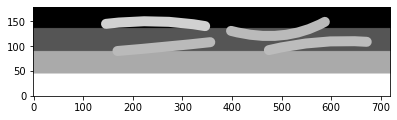

0.006638133217629689
Processing: WE=2.5, WG=3.5, WI=0.5, Species=0
Processing: WE=2.5, WG=3.5, WI=0.5, Species=1
Processing: WE=2.5, WG=3.5, WI=0.5, Species=2
Processing: WE=2.5, WG=3.5, WI=0.5, Species=3
Processing: WE=2.5, WG=3.5, WI=0.5, Species=4


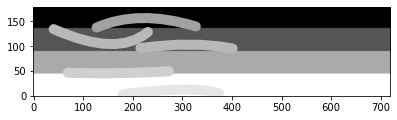

0.004696724903683257
Processing: WE=2.5, WG=3.5, WI=1.0, Species=0
Processing: WE=2.5, WG=3.5, WI=1.0, Species=1
Processing: WE=2.5, WG=3.5, WI=1.0, Species=2
Processing: WE=2.5, WG=3.5, WI=1.0, Species=3
Processing: WE=2.5, WG=3.5, WI=1.0, Species=4


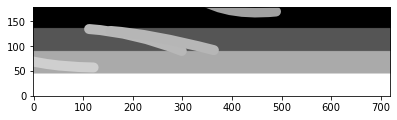

0.0036983206740076463
Processing: WE=2.5, WG=3.5, WI=1.5, Species=0
Processing: WE=2.5, WG=3.5, WI=1.5, Species=1
Processing: WE=2.5, WG=3.5, WI=1.5, Species=2
Processing: WE=2.5, WG=3.5, WI=1.5, Species=3
Processing: WE=2.5, WG=3.5, WI=1.5, Species=4


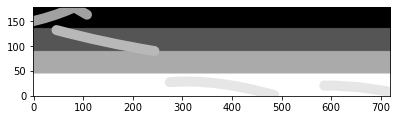

0.0035570924565632867
Processing: WE=2.5, WG=3.5, WI=2.0, Species=0
Processing: WE=2.5, WG=3.5, WI=2.0, Species=1
Processing: WE=2.5, WG=3.5, WI=2.0, Species=2
Processing: WE=2.5, WG=3.5, WI=2.0, Species=3
Processing: WE=2.5, WG=3.5, WI=2.0, Species=4


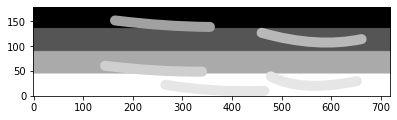

0.005287307702650355
Processing: WE=2.5, WG=3.5, WI=2.5, Species=0
Processing: WE=2.5, WG=3.5, WI=2.5, Species=1
Processing: WE=2.5, WG=3.5, WI=2.5, Species=2
Processing: WE=2.5, WG=3.5, WI=2.5, Species=3
Processing: WE=2.5, WG=3.5, WI=2.5, Species=4


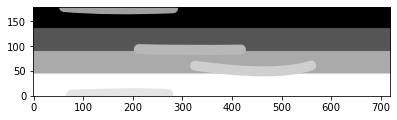

0.004243455391472476
Processing: WE=2.5, WG=3.5, WI=3.0, Species=0
Processing: WE=2.5, WG=3.5, WI=3.0, Species=1
Processing: WE=2.5, WG=3.5, WI=3.0, Species=2
Processing: WE=2.5, WG=3.5, WI=3.0, Species=3
Processing: WE=2.5, WG=3.5, WI=3.0, Species=4


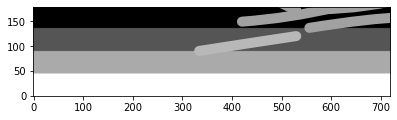

0.0027346469185546636
Processing: WE=2.5, WG=3.5, WI=3.5, Species=0
Processing: WE=2.5, WG=3.5, WI=3.5, Species=1
Processing: WE=2.5, WG=3.5, WI=3.5, Species=2
Processing: WE=2.5, WG=3.5, WI=3.5, Species=3
Processing: WE=2.5, WG=3.5, WI=3.5, Species=4


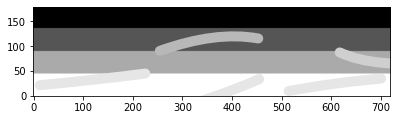

0.004544246105722024
Processing: WE=2.5, WG=3.5, WI=4.0, Species=0
Processing: WE=2.5, WG=3.5, WI=4.0, Species=1
Processing: WE=2.5, WG=3.5, WI=4.0, Species=2
Processing: WE=2.5, WG=3.5, WI=4.0, Species=3
Processing: WE=2.5, WG=3.5, WI=4.0, Species=4


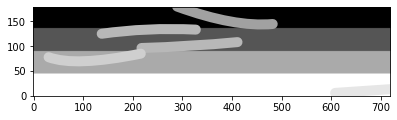

0.004761505378063354
Processing: WE=2.5, WG=4.0, WI=0.0, Species=0
Processing: WE=2.5, WG=4.0, WI=0.0, Species=1
Processing: WE=2.5, WG=4.0, WI=0.0, Species=2
Processing: WE=2.5, WG=4.0, WI=0.0, Species=3
Processing: WE=2.5, WG=4.0, WI=0.0, Species=4


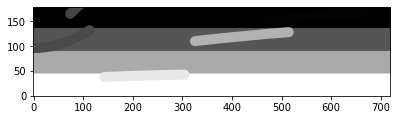

0.004696647380303296
Processing: WE=2.5, WG=4.0, WI=0.5, Species=0
Processing: WE=2.5, WG=4.0, WI=0.5, Species=1
Processing: WE=2.5, WG=4.0, WI=0.5, Species=2
Processing: WE=2.5, WG=4.0, WI=0.5, Species=3
Processing: WE=2.5, WG=4.0, WI=0.5, Species=4


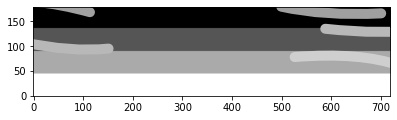

0.0030997432764820476
Processing: WE=2.5, WG=4.0, WI=1.0, Species=0
Processing: WE=2.5, WG=4.0, WI=1.0, Species=1
Processing: WE=2.5, WG=4.0, WI=1.0, Species=2
Processing: WE=2.5, WG=4.0, WI=1.0, Species=3
Processing: WE=2.5, WG=4.0, WI=1.0, Species=4


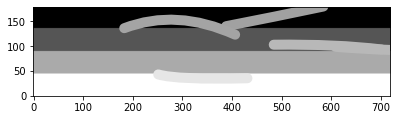

0.0038330659988027485
Processing: WE=2.5, WG=4.0, WI=1.5, Species=0
Processing: WE=2.5, WG=4.0, WI=1.5, Species=1
Processing: WE=2.5, WG=4.0, WI=1.5, Species=2
Processing: WE=2.5, WG=4.0, WI=1.5, Species=3
Processing: WE=2.5, WG=4.0, WI=1.5, Species=4


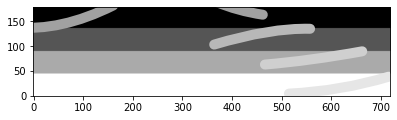

0.004298080303077654
Processing: WE=2.5, WG=4.0, WI=2.0, Species=0
Processing: WE=2.5, WG=4.0, WI=2.0, Species=1
Processing: WE=2.5, WG=4.0, WI=2.0, Species=2
Processing: WE=2.5, WG=4.0, WI=2.0, Species=3
Processing: WE=2.5, WG=4.0, WI=2.0, Species=4


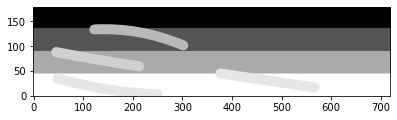

0.00470293646450265
Processing: WE=2.5, WG=4.0, WI=2.5, Species=0
Processing: WE=2.5, WG=4.0, WI=2.5, Species=1
Processing: WE=2.5, WG=4.0, WI=2.5, Species=2
Processing: WE=2.5, WG=4.0, WI=2.5, Species=3
Processing: WE=2.5, WG=4.0, WI=2.5, Species=4


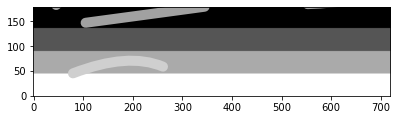

0.0018947780008997557
Processing: WE=2.5, WG=4.0, WI=3.0, Species=0
Processing: WE=2.5, WG=4.0, WI=3.0, Species=1
Processing: WE=2.5, WG=4.0, WI=3.0, Species=2
Processing: WE=2.5, WG=4.0, WI=3.0, Species=3
Processing: WE=2.5, WG=4.0, WI=3.0, Species=4


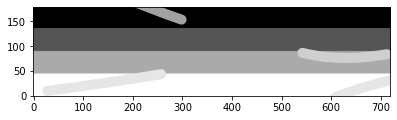

0.0032672034676207856
Processing: WE=2.5, WG=4.0, WI=3.5, Species=0
Processing: WE=2.5, WG=4.0, WI=3.5, Species=1
Processing: WE=2.5, WG=4.0, WI=3.5, Species=2
Processing: WE=2.5, WG=4.0, WI=3.5, Species=3
Processing: WE=2.5, WG=4.0, WI=3.5, Species=4


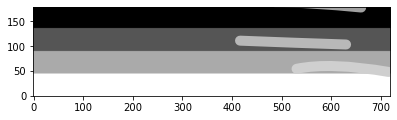

0.0020717735677737246
Processing: WE=2.5, WG=4.0, WI=4.0, Species=0
Processing: WE=2.5, WG=4.0, WI=4.0, Species=1
Processing: WE=2.5, WG=4.0, WI=4.0, Species=2
Processing: WE=2.5, WG=4.0, WI=4.0, Species=3
Processing: WE=2.5, WG=4.0, WI=4.0, Species=4


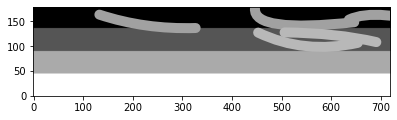

0.00406309724799269
Processing: WE=3.0, WG=0.0, WI=0.0, Species=0
Processing: WE=3.0, WG=0.0, WI=0.0, Species=1
Processing: WE=3.0, WG=0.0, WI=0.0, Species=2
Processing: WE=3.0, WG=0.0, WI=0.0, Species=3
Processing: WE=3.0, WG=0.0, WI=0.0, Species=4


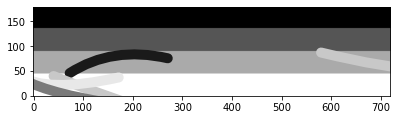

0.0025224169754883186
Processing: WE=3.0, WG=0.0, WI=0.5, Species=0
Processing: WE=3.0, WG=0.0, WI=0.5, Species=1
Processing: WE=3.0, WG=0.0, WI=0.5, Species=2
Processing: WE=3.0, WG=0.0, WI=0.5, Species=3
Processing: WE=3.0, WG=0.0, WI=0.5, Species=4


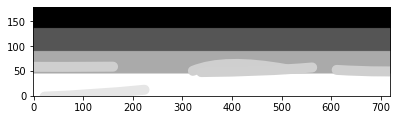

0.0044524487334254405
Processing: WE=3.0, WG=0.0, WI=1.0, Species=0
Processing: WE=3.0, WG=0.0, WI=1.0, Species=1
Processing: WE=3.0, WG=0.0, WI=1.0, Species=2
Processing: WE=3.0, WG=0.0, WI=1.0, Species=3
Processing: WE=3.0, WG=0.0, WI=1.0, Species=4


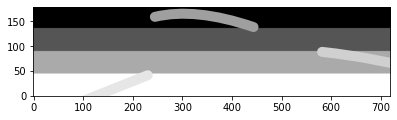

0.0038276587430504526
Processing: WE=3.0, WG=0.0, WI=1.5, Species=0
Processing: WE=3.0, WG=0.0, WI=1.5, Species=1
Processing: WE=3.0, WG=0.0, WI=1.5, Species=2
Processing: WE=3.0, WG=0.0, WI=1.5, Species=3
Processing: WE=3.0, WG=0.0, WI=1.5, Species=4


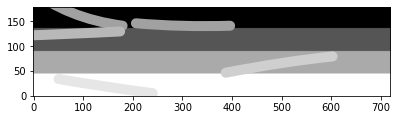

0.004704700121396768
Processing: WE=3.0, WG=0.0, WI=2.0, Species=0
Processing: WE=3.0, WG=0.0, WI=2.0, Species=1
Processing: WE=3.0, WG=0.0, WI=2.0, Species=2
Processing: WE=3.0, WG=0.0, WI=2.0, Species=3
Processing: WE=3.0, WG=0.0, WI=2.0, Species=4


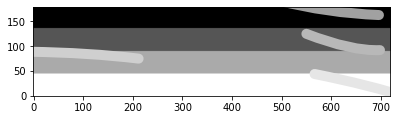

0.003416503807003608
Processing: WE=3.0, WG=0.0, WI=2.5, Species=0
Processing: WE=3.0, WG=0.0, WI=2.5, Species=1
Processing: WE=3.0, WG=0.0, WI=2.5, Species=2
Processing: WE=3.0, WG=0.0, WI=2.5, Species=3
Processing: WE=3.0, WG=0.0, WI=2.5, Species=4


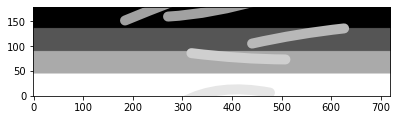

0.003732004582600798
Processing: WE=3.0, WG=0.0, WI=3.0, Species=0
Processing: WE=3.0, WG=0.0, WI=3.0, Species=1
Processing: WE=3.0, WG=0.0, WI=3.0, Species=2
Processing: WE=3.0, WG=0.0, WI=3.0, Species=3
Processing: WE=3.0, WG=0.0, WI=3.0, Species=4


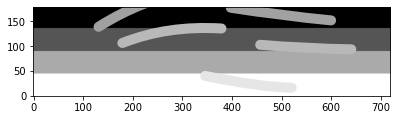

0.004171310195996062
Processing: WE=3.0, WG=0.0, WI=3.5, Species=0
Processing: WE=3.0, WG=0.0, WI=3.5, Species=1
Processing: WE=3.0, WG=0.0, WI=3.5, Species=2
Processing: WE=3.0, WG=0.0, WI=3.5, Species=3
Processing: WE=3.0, WG=0.0, WI=3.5, Species=4


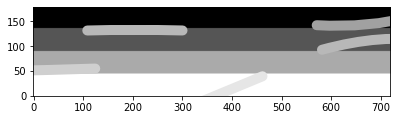

0.0038410315260937636
Processing: WE=3.0, WG=0.0, WI=4.0, Species=0
Processing: WE=3.0, WG=0.0, WI=4.0, Species=1
Processing: WE=3.0, WG=0.0, WI=4.0, Species=2
Processing: WE=3.0, WG=0.0, WI=4.0, Species=3
Processing: WE=3.0, WG=0.0, WI=4.0, Species=4


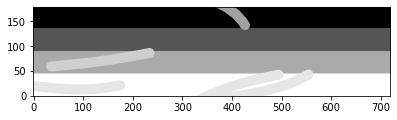

0.004083272707627598
Processing: WE=3.0, WG=0.5, WI=0.0, Species=0
Processing: WE=3.0, WG=0.5, WI=0.0, Species=1
Processing: WE=3.0, WG=0.5, WI=0.0, Species=2
Processing: WE=3.0, WG=0.5, WI=0.0, Species=3
Processing: WE=3.0, WG=0.5, WI=0.0, Species=4


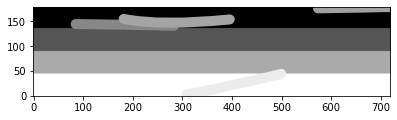

0.002314198867334967
Processing: WE=3.0, WG=0.5, WI=0.5, Species=0
Processing: WE=3.0, WG=0.5, WI=0.5, Species=1
Processing: WE=3.0, WG=0.5, WI=0.5, Species=2
Processing: WE=3.0, WG=0.5, WI=0.5, Species=3
Processing: WE=3.0, WG=0.5, WI=0.5, Species=4


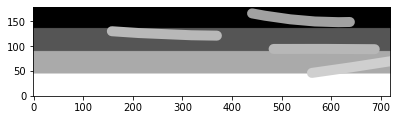

0.004010100327366698
Processing: WE=3.0, WG=0.5, WI=1.0, Species=0
Processing: WE=3.0, WG=0.5, WI=1.0, Species=1
Processing: WE=3.0, WG=0.5, WI=1.0, Species=2
Processing: WE=3.0, WG=0.5, WI=1.0, Species=3
Processing: WE=3.0, WG=0.5, WI=1.0, Species=4


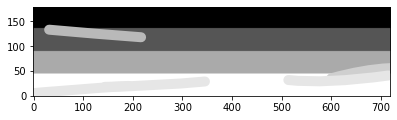

0.004010594538913951
Processing: WE=3.0, WG=0.5, WI=1.5, Species=0
Processing: WE=3.0, WG=0.5, WI=1.5, Species=1
Processing: WE=3.0, WG=0.5, WI=1.5, Species=2
Processing: WE=3.0, WG=0.5, WI=1.5, Species=3
Processing: WE=3.0, WG=0.5, WI=1.5, Species=4


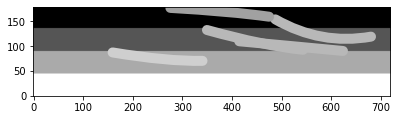

0.004210769596396326
Processing: WE=3.0, WG=0.5, WI=2.0, Species=0
Processing: WE=3.0, WG=0.5, WI=2.0, Species=1
Processing: WE=3.0, WG=0.5, WI=2.0, Species=2
Processing: WE=3.0, WG=0.5, WI=2.0, Species=3
Processing: WE=3.0, WG=0.5, WI=2.0, Species=4


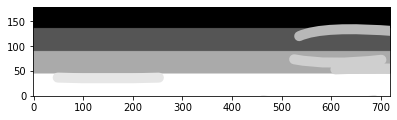

0.0035380023242478353
Processing: WE=3.0, WG=0.5, WI=2.5, Species=0
Processing: WE=3.0, WG=0.5, WI=2.5, Species=1
Processing: WE=3.0, WG=0.5, WI=2.5, Species=2
Processing: WE=3.0, WG=0.5, WI=2.5, Species=3
Processing: WE=3.0, WG=0.5, WI=2.5, Species=4


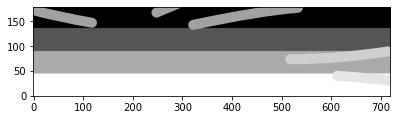

0.003159852967219481
Processing: WE=3.0, WG=0.5, WI=3.0, Species=0
Processing: WE=3.0, WG=0.5, WI=3.0, Species=1
Processing: WE=3.0, WG=0.5, WI=3.0, Species=2
Processing: WE=3.0, WG=0.5, WI=3.0, Species=3
Processing: WE=3.0, WG=0.5, WI=3.0, Species=4


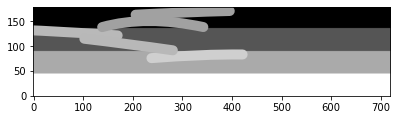

0.003889415805612063
Processing: WE=3.0, WG=0.5, WI=3.5, Species=0
Processing: WE=3.0, WG=0.5, WI=3.5, Species=1
Processing: WE=3.0, WG=0.5, WI=3.5, Species=2
Processing: WE=3.0, WG=0.5, WI=3.5, Species=3
Processing: WE=3.0, WG=0.5, WI=3.5, Species=4


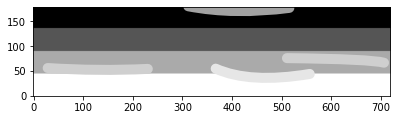

0.004037844006970321
Processing: WE=3.0, WG=0.5, WI=4.0, Species=0
Processing: WE=3.0, WG=0.5, WI=4.0, Species=1
Processing: WE=3.0, WG=0.5, WI=4.0, Species=2
Processing: WE=3.0, WG=0.5, WI=4.0, Species=3
Processing: WE=3.0, WG=0.5, WI=4.0, Species=4


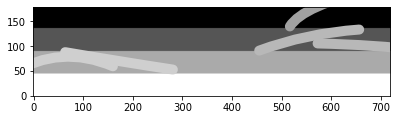

0.0036860429087062874
Processing: WE=3.0, WG=1.0, WI=0.0, Species=0
Processing: WE=3.0, WG=1.0, WI=0.0, Species=1
Processing: WE=3.0, WG=1.0, WI=0.0, Species=2
Processing: WE=3.0, WG=1.0, WI=0.0, Species=3
Processing: WE=3.0, WG=1.0, WI=0.0, Species=4


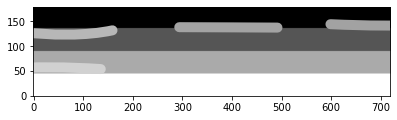

0.005227188321490426
Processing: WE=3.0, WG=1.0, WI=0.5, Species=0
Processing: WE=3.0, WG=1.0, WI=0.5, Species=1
Processing: WE=3.0, WG=1.0, WI=0.5, Species=2
Processing: WE=3.0, WG=1.0, WI=0.5, Species=3
Processing: WE=3.0, WG=1.0, WI=0.5, Species=4


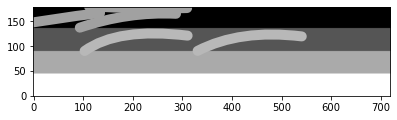

0.003577684604365487
Processing: WE=3.0, WG=1.0, WI=1.0, Species=0
Processing: WE=3.0, WG=1.0, WI=1.0, Species=1
Processing: WE=3.0, WG=1.0, WI=1.0, Species=2
Processing: WE=3.0, WG=1.0, WI=1.0, Species=3
Processing: WE=3.0, WG=1.0, WI=1.0, Species=4


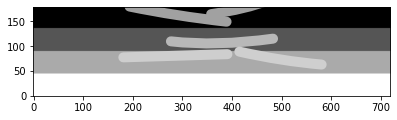

0.0032968464700334587
Processing: WE=3.0, WG=1.0, WI=1.5, Species=0
Processing: WE=3.0, WG=1.0, WI=1.5, Species=1
Processing: WE=3.0, WG=1.0, WI=1.5, Species=2
Processing: WE=3.0, WG=1.0, WI=1.5, Species=3
Processing: WE=3.0, WG=1.0, WI=1.5, Species=4


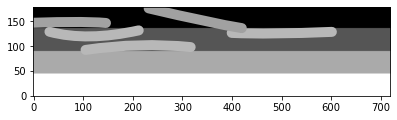

0.004820355313876418
Processing: WE=3.0, WG=1.0, WI=2.0, Species=0
Processing: WE=3.0, WG=1.0, WI=2.0, Species=1
Processing: WE=3.0, WG=1.0, WI=2.0, Species=2
Processing: WE=3.0, WG=1.0, WI=2.0, Species=3
Processing: WE=3.0, WG=1.0, WI=2.0, Species=4


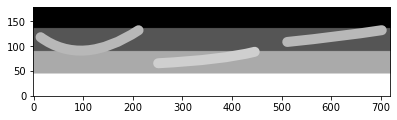

0.0031325259757831497
Processing: WE=3.0, WG=1.0, WI=2.5, Species=0
Processing: WE=3.0, WG=1.0, WI=2.5, Species=1
Processing: WE=3.0, WG=1.0, WI=2.5, Species=2
Processing: WE=3.0, WG=1.0, WI=2.5, Species=3
Processing: WE=3.0, WG=1.0, WI=2.5, Species=4


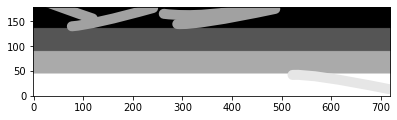

0.003375435796469149
Processing: WE=3.0, WG=1.0, WI=3.0, Species=0
Processing: WE=3.0, WG=1.0, WI=3.0, Species=1
Processing: WE=3.0, WG=1.0, WI=3.0, Species=2
Processing: WE=3.0, WG=1.0, WI=3.0, Species=3
Processing: WE=3.0, WG=1.0, WI=3.0, Species=4


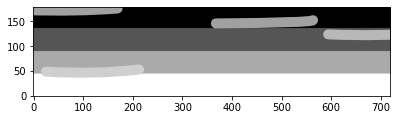

0.0026703315844543336
Processing: WE=3.0, WG=1.0, WI=3.5, Species=0
Processing: WE=3.0, WG=1.0, WI=3.5, Species=1
Processing: WE=3.0, WG=1.0, WI=3.5, Species=2
Processing: WE=3.0, WG=1.0, WI=3.5, Species=3
Processing: WE=3.0, WG=1.0, WI=3.5, Species=4


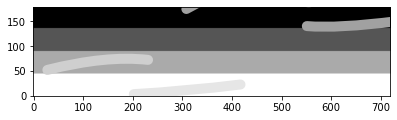

0.0033193767023346893
Processing: WE=3.0, WG=1.0, WI=4.0, Species=0
Processing: WE=3.0, WG=1.0, WI=4.0, Species=1
Processing: WE=3.0, WG=1.0, WI=4.0, Species=2
Processing: WE=3.0, WG=1.0, WI=4.0, Species=3
Processing: WE=3.0, WG=1.0, WI=4.0, Species=4


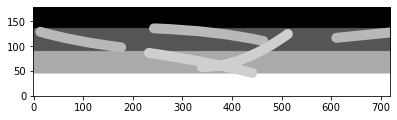

0.004148595845667425
Processing: WE=3.0, WG=1.5, WI=0.0, Species=0
Processing: WE=3.0, WG=1.5, WI=0.0, Species=1
Processing: WE=3.0, WG=1.5, WI=0.0, Species=2
Processing: WE=3.0, WG=1.5, WI=0.0, Species=3
Processing: WE=3.0, WG=1.5, WI=0.0, Species=4


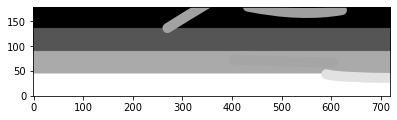

0.001679243623762563
Processing: WE=3.0, WG=1.5, WI=0.5, Species=0
Processing: WE=3.0, WG=1.5, WI=0.5, Species=1
Processing: WE=3.0, WG=1.5, WI=0.5, Species=2
Processing: WE=3.0, WG=1.5, WI=0.5, Species=3
Processing: WE=3.0, WG=1.5, WI=0.5, Species=4


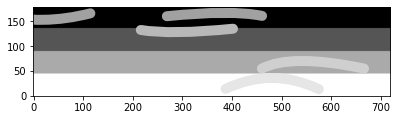

0.004672014326320617
Processing: WE=3.0, WG=1.5, WI=1.0, Species=0
Processing: WE=3.0, WG=1.5, WI=1.0, Species=1
Processing: WE=3.0, WG=1.5, WI=1.0, Species=2
Processing: WE=3.0, WG=1.5, WI=1.0, Species=3
Processing: WE=3.0, WG=1.5, WI=1.0, Species=4


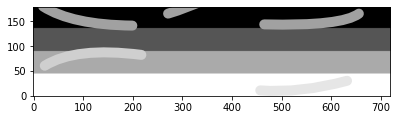

0.004172027287260705
Processing: WE=3.0, WG=1.5, WI=1.5, Species=0
Processing: WE=3.0, WG=1.5, WI=1.5, Species=1
Processing: WE=3.0, WG=1.5, WI=1.5, Species=2
Processing: WE=3.0, WG=1.5, WI=1.5, Species=3
Processing: WE=3.0, WG=1.5, WI=1.5, Species=4


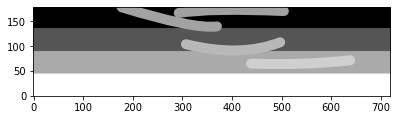

0.004094029076597218
Processing: WE=3.0, WG=1.5, WI=2.0, Species=0
Processing: WE=3.0, WG=1.5, WI=2.0, Species=1
Processing: WE=3.0, WG=1.5, WI=2.0, Species=2
Processing: WE=3.0, WG=1.5, WI=2.0, Species=3
Processing: WE=3.0, WG=1.5, WI=2.0, Species=4


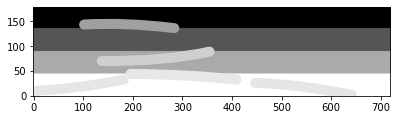

0.0050314902392008115
Processing: WE=3.0, WG=1.5, WI=2.5, Species=0
Processing: WE=3.0, WG=1.5, WI=2.5, Species=1
Processing: WE=3.0, WG=1.5, WI=2.5, Species=2
Processing: WE=3.0, WG=1.5, WI=2.5, Species=3
Processing: WE=3.0, WG=1.5, WI=2.5, Species=4


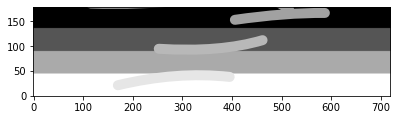

0.0034216397309260386
Processing: WE=3.0, WG=1.5, WI=3.0, Species=0
Processing: WE=3.0, WG=1.5, WI=3.0, Species=1
Processing: WE=3.0, WG=1.5, WI=3.0, Species=2
Processing: WE=3.0, WG=1.5, WI=3.0, Species=3
Processing: WE=3.0, WG=1.5, WI=3.0, Species=4


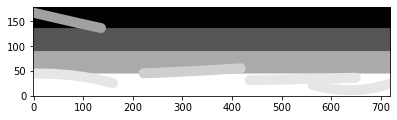

0.004551639898085827
Processing: WE=3.0, WG=1.5, WI=3.5, Species=0
Processing: WE=3.0, WG=1.5, WI=3.5, Species=1
Processing: WE=3.0, WG=1.5, WI=3.5, Species=2
Processing: WE=3.0, WG=1.5, WI=3.5, Species=3
Processing: WE=3.0, WG=1.5, WI=3.5, Species=4


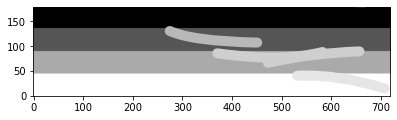

0.003335530636634109
Processing: WE=3.0, WG=1.5, WI=4.0, Species=0
Processing: WE=3.0, WG=1.5, WI=4.0, Species=1
Processing: WE=3.0, WG=1.5, WI=4.0, Species=2
Processing: WE=3.0, WG=1.5, WI=4.0, Species=3
Processing: WE=3.0, WG=1.5, WI=4.0, Species=4


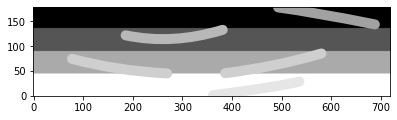

0.004547967227960164
Processing: WE=3.0, WG=2.0, WI=0.0, Species=0
Processing: WE=3.0, WG=2.0, WI=0.0, Species=1
Processing: WE=3.0, WG=2.0, WI=0.0, Species=2
Processing: WE=3.0, WG=2.0, WI=0.0, Species=3
Processing: WE=3.0, WG=2.0, WI=0.0, Species=4


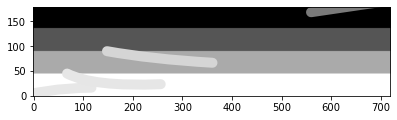

0.0026514352605887855
Processing: WE=3.0, WG=2.0, WI=0.5, Species=0
Processing: WE=3.0, WG=2.0, WI=0.5, Species=1
Processing: WE=3.0, WG=2.0, WI=0.5, Species=2
Processing: WE=3.0, WG=2.0, WI=0.5, Species=3
Processing: WE=3.0, WG=2.0, WI=0.5, Species=4


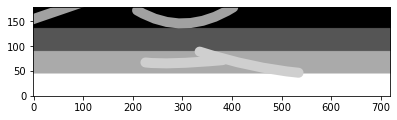

0.002775133503739413
Processing: WE=3.0, WG=2.0, WI=1.0, Species=0
Processing: WE=3.0, WG=2.0, WI=1.0, Species=1
Processing: WE=3.0, WG=2.0, WI=1.0, Species=2
Processing: WE=3.0, WG=2.0, WI=1.0, Species=3
Processing: WE=3.0, WG=2.0, WI=1.0, Species=4


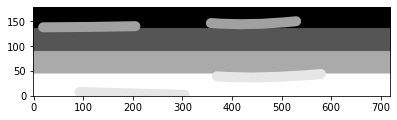

0.004224917613239248
Processing: WE=3.0, WG=2.0, WI=1.5, Species=0
Processing: WE=3.0, WG=2.0, WI=1.5, Species=1
Processing: WE=3.0, WG=2.0, WI=1.5, Species=2
Processing: WE=3.0, WG=2.0, WI=1.5, Species=3
Processing: WE=3.0, WG=2.0, WI=1.5, Species=4


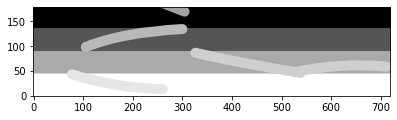

0.0042201596157941295
Processing: WE=3.0, WG=2.0, WI=2.0, Species=0
Processing: WE=3.0, WG=2.0, WI=2.0, Species=1
Processing: WE=3.0, WG=2.0, WI=2.0, Species=2
Processing: WE=3.0, WG=2.0, WI=2.0, Species=3
Processing: WE=3.0, WG=2.0, WI=2.0, Species=4


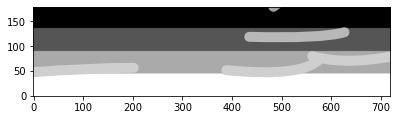

0.0034050981797268125
Processing: WE=3.0, WG=2.0, WI=2.5, Species=0
Processing: WE=3.0, WG=2.0, WI=2.5, Species=1
Processing: WE=3.0, WG=2.0, WI=2.5, Species=2
Processing: WE=3.0, WG=2.0, WI=2.5, Species=3
Processing: WE=3.0, WG=2.0, WI=2.5, Species=4


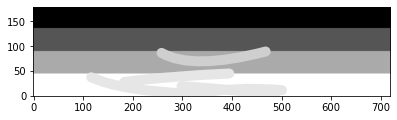

0.004737560344077831
Processing: WE=3.0, WG=2.0, WI=3.0, Species=0
Processing: WE=3.0, WG=2.0, WI=3.0, Species=1
Processing: WE=3.0, WG=2.0, WI=3.0, Species=2
Processing: WE=3.0, WG=2.0, WI=3.0, Species=3
Processing: WE=3.0, WG=2.0, WI=3.0, Species=4


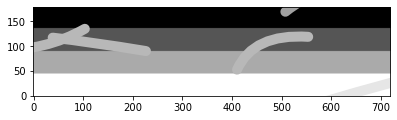

0.0031014003387287185
Processing: WE=3.0, WG=2.0, WI=3.5, Species=0
Processing: WE=3.0, WG=2.0, WI=3.5, Species=1
Processing: WE=3.0, WG=2.0, WI=3.5, Species=2
Processing: WE=3.0, WG=2.0, WI=3.5, Species=3
Processing: WE=3.0, WG=2.0, WI=3.5, Species=4


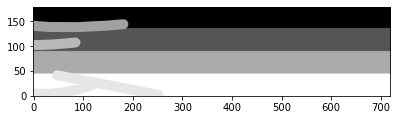

0.0032414657054736593
Processing: WE=3.0, WG=2.0, WI=4.0, Species=0
Processing: WE=3.0, WG=2.0, WI=4.0, Species=1
Processing: WE=3.0, WG=2.0, WI=4.0, Species=2
Processing: WE=3.0, WG=2.0, WI=4.0, Species=3
Processing: WE=3.0, WG=2.0, WI=4.0, Species=4


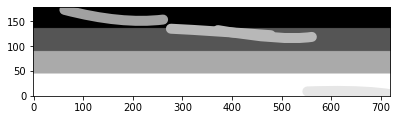

0.0032818747672784475
Processing: WE=3.0, WG=2.5, WI=0.0, Species=0
Processing: WE=3.0, WG=2.5, WI=0.0, Species=1
Processing: WE=3.0, WG=2.5, WI=0.0, Species=2
Processing: WE=3.0, WG=2.5, WI=0.0, Species=3
Processing: WE=3.0, WG=2.5, WI=0.0, Species=4


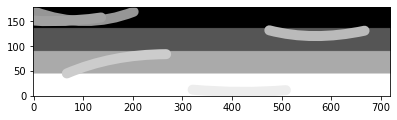

0.005922931585374924
Processing: WE=3.0, WG=2.5, WI=0.5, Species=0
Processing: WE=3.0, WG=2.5, WI=0.5, Species=1
Processing: WE=3.0, WG=2.5, WI=0.5, Species=2
Processing: WE=3.0, WG=2.5, WI=0.5, Species=3
Processing: WE=3.0, WG=2.5, WI=0.5, Species=4


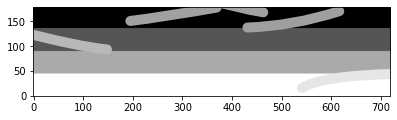

0.004423493751009924
Processing: WE=3.0, WG=2.5, WI=1.0, Species=0
Processing: WE=3.0, WG=2.5, WI=1.0, Species=1
Processing: WE=3.0, WG=2.5, WI=1.0, Species=2
Processing: WE=3.0, WG=2.5, WI=1.0, Species=3
Processing: WE=3.0, WG=2.5, WI=1.0, Species=4


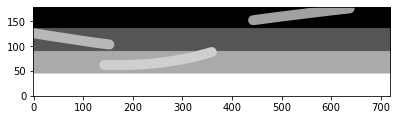

0.0025537170401476626
Processing: WE=3.0, WG=2.5, WI=1.5, Species=0
Processing: WE=3.0, WG=2.5, WI=1.5, Species=1
Processing: WE=3.0, WG=2.5, WI=1.5, Species=2
Processing: WE=3.0, WG=2.5, WI=1.5, Species=3
Processing: WE=3.0, WG=2.5, WI=1.5, Species=4


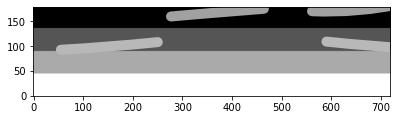

0.0028659909050539672
Processing: WE=3.0, WG=2.5, WI=2.0, Species=0
Processing: WE=3.0, WG=2.5, WI=2.0, Species=1
Processing: WE=3.0, WG=2.5, WI=2.0, Species=2
Processing: WE=3.0, WG=2.5, WI=2.0, Species=3
Processing: WE=3.0, WG=2.5, WI=2.0, Species=4


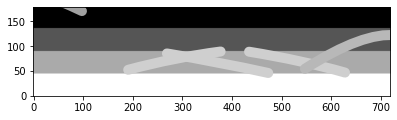

0.003972792200760359
Processing: WE=3.0, WG=2.5, WI=2.5, Species=0
Processing: WE=3.0, WG=2.5, WI=2.5, Species=1
Processing: WE=3.0, WG=2.5, WI=2.5, Species=2
Processing: WE=3.0, WG=2.5, WI=2.5, Species=3
Processing: WE=3.0, WG=2.5, WI=2.5, Species=4


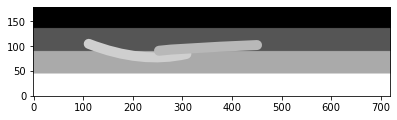

0.0019673689558109466
Processing: WE=3.0, WG=2.5, WI=3.0, Species=0
Processing: WE=3.0, WG=2.5, WI=3.0, Species=1
Processing: WE=3.0, WG=2.5, WI=3.0, Species=2
Processing: WE=3.0, WG=2.5, WI=3.0, Species=3
Processing: WE=3.0, WG=2.5, WI=3.0, Species=4


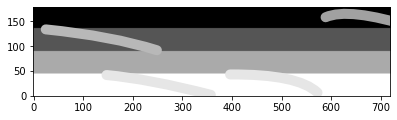

0.003956105293223705
Processing: WE=3.0, WG=2.5, WI=3.5, Species=0
Processing: WE=3.0, WG=2.5, WI=3.5, Species=1
Processing: WE=3.0, WG=2.5, WI=3.5, Species=2
Processing: WE=3.0, WG=2.5, WI=3.5, Species=3
Processing: WE=3.0, WG=2.5, WI=3.5, Species=4


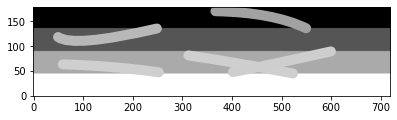

0.003963877012064818
Processing: WE=3.0, WG=2.5, WI=4.0, Species=0
Processing: WE=3.0, WG=2.5, WI=4.0, Species=1
Processing: WE=3.0, WG=2.5, WI=4.0, Species=2
Processing: WE=3.0, WG=2.5, WI=4.0, Species=3
Processing: WE=3.0, WG=2.5, WI=4.0, Species=4


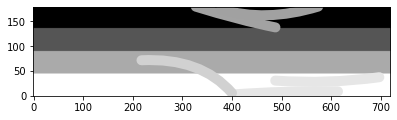

0.005701408527135727
Processing: WE=3.0, WG=3.0, WI=0.0, Species=0
Processing: WE=3.0, WG=3.0, WI=0.0, Species=1
Processing: WE=3.0, WG=3.0, WI=0.0, Species=2
Processing: WE=3.0, WG=3.0, WI=0.0, Species=3
Processing: WE=3.0, WG=3.0, WI=0.0, Species=4


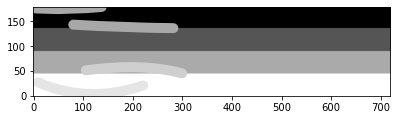

0.004366184592373589
Processing: WE=3.0, WG=3.0, WI=0.5, Species=0
Processing: WE=3.0, WG=3.0, WI=0.5, Species=1
Processing: WE=3.0, WG=3.0, WI=0.5, Species=2
Processing: WE=3.0, WG=3.0, WI=0.5, Species=3
Processing: WE=3.0, WG=3.0, WI=0.5, Species=4


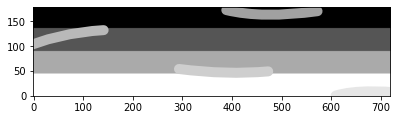

0.0022023713917409013
Processing: WE=3.0, WG=3.0, WI=1.0, Species=0
Processing: WE=3.0, WG=3.0, WI=1.0, Species=1
Processing: WE=3.0, WG=3.0, WI=1.0, Species=2
Processing: WE=3.0, WG=3.0, WI=1.0, Species=3
Processing: WE=3.0, WG=3.0, WI=1.0, Species=4


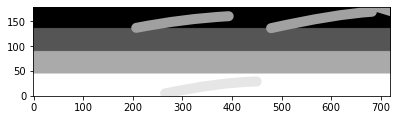

0.00256713827530345
Processing: WE=3.0, WG=3.0, WI=1.5, Species=0
Processing: WE=3.0, WG=3.0, WI=1.5, Species=1
Processing: WE=3.0, WG=3.0, WI=1.5, Species=2
Processing: WE=3.0, WG=3.0, WI=1.5, Species=3
Processing: WE=3.0, WG=3.0, WI=1.5, Species=4


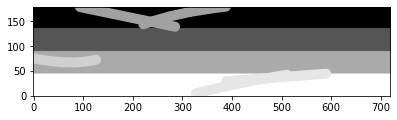

0.003931501310508513
Processing: WE=3.0, WG=3.0, WI=2.0, Species=0
Processing: WE=3.0, WG=3.0, WI=2.0, Species=1
Processing: WE=3.0, WG=3.0, WI=2.0, Species=2
Processing: WE=3.0, WG=3.0, WI=2.0, Species=3
Processing: WE=3.0, WG=3.0, WI=2.0, Species=4


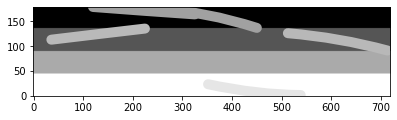

0.0037844006970320907
Processing: WE=3.0, WG=3.0, WI=2.5, Species=0
Processing: WE=3.0, WG=3.0, WI=2.5, Species=1
Processing: WE=3.0, WG=3.0, WI=2.5, Species=2
Processing: WE=3.0, WG=3.0, WI=2.5, Species=3
Processing: WE=3.0, WG=3.0, WI=2.5, Species=4


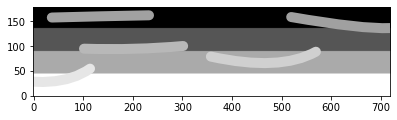

0.005056656266420724
Processing: WE=3.0, WG=3.0, WI=3.0, Species=0
Processing: WE=3.0, WG=3.0, WI=3.0, Species=1
Processing: WE=3.0, WG=3.0, WI=3.0, Species=2
Processing: WE=3.0, WG=3.0, WI=3.0, Species=3
Processing: WE=3.0, WG=3.0, WI=3.0, Species=4


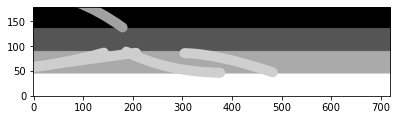

0.002609359446114831
Processing: WE=3.0, WG=3.0, WI=3.5, Species=0
Processing: WE=3.0, WG=3.0, WI=3.5, Species=1
Processing: WE=3.0, WG=3.0, WI=3.5, Species=2
Processing: WE=3.0, WG=3.0, WI=3.5, Species=3
Processing: WE=3.0, WG=3.0, WI=3.5, Species=4


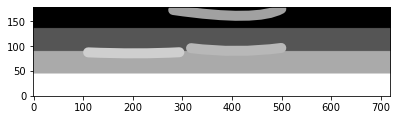

0.0031424780396856716
Processing: WE=3.0, WG=3.0, WI=4.0, Species=0
Processing: WE=3.0, WG=3.0, WI=4.0, Species=1
Processing: WE=3.0, WG=3.0, WI=4.0, Species=2
Processing: WE=3.0, WG=3.0, WI=4.0, Species=3
Processing: WE=3.0, WG=3.0, WI=4.0, Species=4


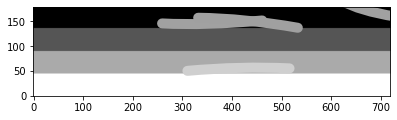

0.0021783875960653975
Processing: WE=3.0, WG=3.5, WI=0.0, Species=0
Processing: WE=3.0, WG=3.5, WI=0.0, Species=1
Processing: WE=3.0, WG=3.5, WI=0.0, Species=2
Processing: WE=3.0, WG=3.5, WI=0.0, Species=3
Processing: WE=3.0, WG=3.5, WI=0.0, Species=4


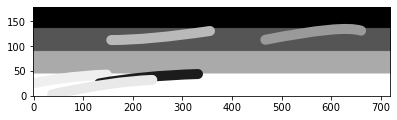

0.005339461556519268
Processing: WE=3.0, WG=3.5, WI=0.5, Species=0
Processing: WE=3.0, WG=3.5, WI=0.5, Species=1
Processing: WE=3.0, WG=3.5, WI=0.5, Species=2
Processing: WE=3.0, WG=3.5, WI=0.5, Species=3
Processing: WE=3.0, WG=3.5, WI=0.5, Species=4


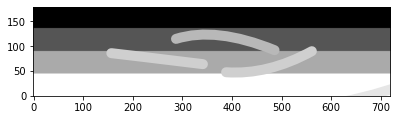

0.0031339310870449463
Processing: WE=3.0, WG=3.5, WI=1.0, Species=0
Processing: WE=3.0, WG=3.5, WI=1.0, Species=1
Processing: WE=3.0, WG=3.5, WI=1.0, Species=2
Processing: WE=3.0, WG=3.5, WI=1.0, Species=3
Processing: WE=3.0, WG=3.5, WI=1.0, Species=4


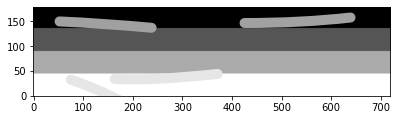

0.0031716268305510917
Processing: WE=3.0, WG=3.5, WI=1.5, Species=0
Processing: WE=3.0, WG=3.5, WI=1.5, Species=1
Processing: WE=3.0, WG=3.5, WI=1.5, Species=2
Processing: WE=3.0, WG=3.5, WI=1.5, Species=3
Processing: WE=3.0, WG=3.5, WI=1.5, Species=4


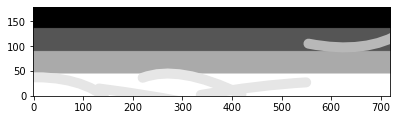

0.004333217775045078
Processing: WE=3.0, WG=3.5, WI=2.0, Species=0
Processing: WE=3.0, WG=3.5, WI=2.0, Species=1
Processing: WE=3.0, WG=3.5, WI=2.0, Species=2
Processing: WE=3.0, WG=3.5, WI=2.0, Species=3
Processing: WE=3.0, WG=3.5, WI=2.0, Species=4


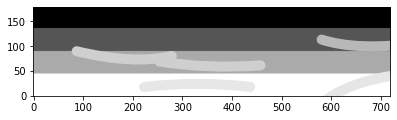

0.004137645668247901
Processing: WE=3.0, WG=3.5, WI=2.5, Species=0
Processing: WE=3.0, WG=3.5, WI=2.5, Species=1
Processing: WE=3.0, WG=3.5, WI=2.5, Species=2
Processing: WE=3.0, WG=3.5, WI=2.5, Species=3
Processing: WE=3.0, WG=3.5, WI=2.5, Species=4


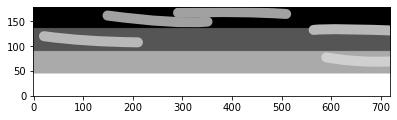

0.003919601471684464
Processing: WE=3.0, WG=3.5, WI=3.0, Species=0
Processing: WE=3.0, WG=3.5, WI=3.0, Species=1
Processing: WE=3.0, WG=3.5, WI=3.0, Species=2
Processing: WE=3.0, WG=3.5, WI=3.0, Species=3
Processing: WE=3.0, WG=3.5, WI=3.0, Species=4


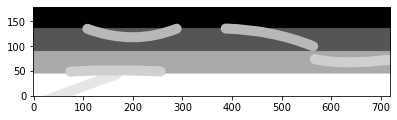

0.004109058921887201
Processing: WE=3.0, WG=3.5, WI=3.5, Species=0
Processing: WE=3.0, WG=3.5, WI=3.5, Species=1
Processing: WE=3.0, WG=3.5, WI=3.5, Species=2
Processing: WE=3.0, WG=3.5, WI=3.5, Species=3
Processing: WE=3.0, WG=3.5, WI=3.5, Species=4


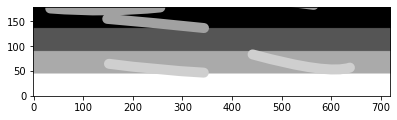

0.0035985093223075706
Processing: WE=3.0, WG=3.5, WI=4.0, Species=0
Processing: WE=3.0, WG=3.5, WI=4.0, Species=1
Processing: WE=3.0, WG=3.5, WI=4.0, Species=2
Processing: WE=3.0, WG=3.5, WI=4.0, Species=3
Processing: WE=3.0, WG=3.5, WI=4.0, Species=4


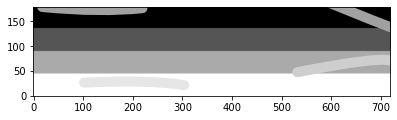

0.0026388474017675816
Processing: WE=3.0, WG=4.0, WI=0.0, Species=0
Processing: WE=3.0, WG=4.0, WI=0.0, Species=1
Processing: WE=3.0, WG=4.0, WI=0.0, Species=2
Processing: WE=3.0, WG=4.0, WI=0.0, Species=3
Processing: WE=3.0, WG=4.0, WI=0.0, Species=4


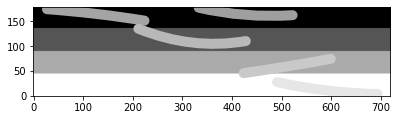

0.006039420154189157
Processing: WE=3.0, WG=4.0, WI=0.5, Species=0
Processing: WE=3.0, WG=4.0, WI=0.5, Species=1
Processing: WE=3.0, WG=4.0, WI=0.5, Species=2
Processing: WE=3.0, WG=4.0, WI=0.5, Species=3
Processing: WE=3.0, WG=4.0, WI=0.5, Species=4


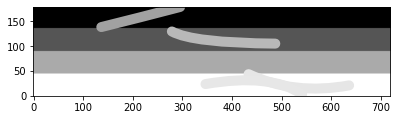

0.0031261690586263297
Processing: WE=3.0, WG=4.0, WI=1.0, Species=0
Processing: WE=3.0, WG=4.0, WI=1.0, Species=1
Processing: WE=3.0, WG=4.0, WI=1.0, Species=2
Processing: WE=3.0, WG=4.0, WI=1.0, Species=3
Processing: WE=3.0, WG=4.0, WI=1.0, Species=4


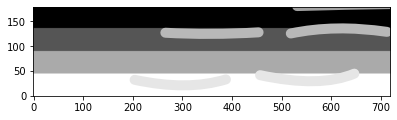

0.004723422017657404
Processing: WE=3.0, WG=4.0, WI=1.5, Species=0
Processing: WE=3.0, WG=4.0, WI=1.5, Species=1
Processing: WE=3.0, WG=4.0, WI=1.5, Species=2
Processing: WE=3.0, WG=4.0, WI=1.5, Species=3
Processing: WE=3.0, WG=4.0, WI=1.5, Species=4


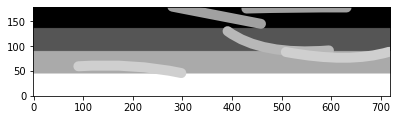

0.003778266659592658
Processing: WE=3.0, WG=4.0, WI=2.0, Species=0
Processing: WE=3.0, WG=4.0, WI=2.0, Species=1
Processing: WE=3.0, WG=4.0, WI=2.0, Species=2
Processing: WE=3.0, WG=4.0, WI=2.0, Species=3
Processing: WE=3.0, WG=4.0, WI=2.0, Species=4


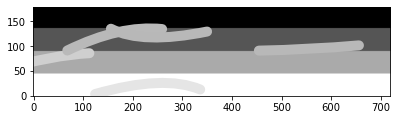

0.0051012709715884084
Processing: WE=3.0, WG=4.0, WI=2.5, Species=0
Processing: WE=3.0, WG=4.0, WI=2.5, Species=1
Processing: WE=3.0, WG=4.0, WI=2.5, Species=2
Processing: WE=3.0, WG=4.0, WI=2.5, Species=3
Processing: WE=3.0, WG=4.0, WI=2.5, Species=4


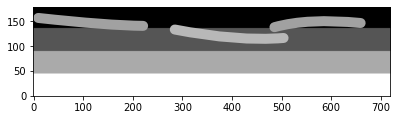

0.0029076209600931444
Processing: WE=3.0, WG=4.0, WI=3.0, Species=0
Processing: WE=3.0, WG=4.0, WI=3.0, Species=1
Processing: WE=3.0, WG=4.0, WI=3.0, Species=2
Processing: WE=3.0, WG=4.0, WI=3.0, Species=3
Processing: WE=3.0, WG=4.0, WI=3.0, Species=4


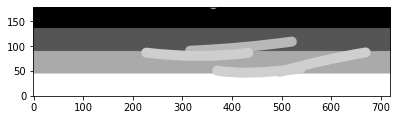

0.0026968833420910523
Processing: WE=3.0, WG=4.0, WI=3.5, Species=0
Processing: WE=3.0, WG=4.0, WI=3.5, Species=1
Processing: WE=3.0, WG=4.0, WI=3.5, Species=2
Processing: WE=3.0, WG=4.0, WI=3.5, Species=3
Processing: WE=3.0, WG=4.0, WI=3.5, Species=4


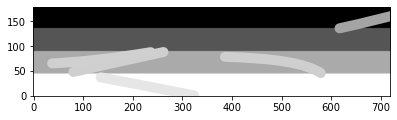

0.004650908586126173
Processing: WE=3.0, WG=4.0, WI=4.0, Species=0
Processing: WE=3.0, WG=4.0, WI=4.0, Species=1
Processing: WE=3.0, WG=4.0, WI=4.0, Species=2
Processing: WE=3.0, WG=4.0, WI=4.0, Species=3
Processing: WE=3.0, WG=4.0, WI=4.0, Species=4


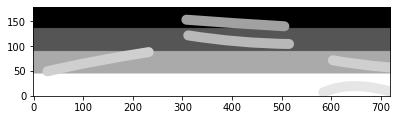

0.004362938300837713
Processing: WE=3.5, WG=0.0, WI=0.0, Species=0
Processing: WE=3.5, WG=0.0, WI=0.0, Species=1
Processing: WE=3.5, WG=0.0, WI=0.0, Species=2
Processing: WE=3.5, WG=0.0, WI=0.0, Species=3
Processing: WE=3.5, WG=0.0, WI=0.0, Species=4


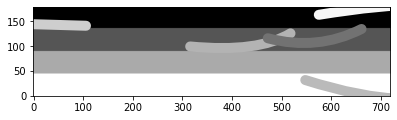

0.004619114309919577
Processing: WE=3.5, WG=0.0, WI=0.5, Species=0
Processing: WE=3.5, WG=0.0, WI=0.5, Species=1
Processing: WE=3.5, WG=0.0, WI=0.5, Species=2
Processing: WE=3.5, WG=0.0, WI=0.5, Species=3
Processing: WE=3.5, WG=0.0, WI=0.5, Species=4


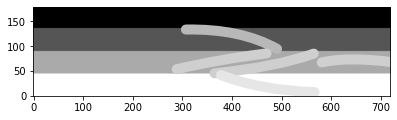

0.004760797977221208
Processing: WE=3.5, WG=0.0, WI=1.0, Species=0
Processing: WE=3.5, WG=0.0, WI=1.0, Species=1
Processing: WE=3.5, WG=0.0, WI=1.0, Species=2
Processing: WE=3.5, WG=0.0, WI=1.0, Species=3
Processing: WE=3.5, WG=0.0, WI=1.0, Species=4


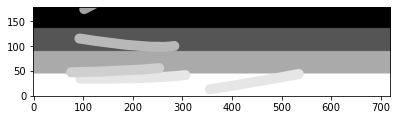

0.0038886405718124503
Processing: WE=3.5, WG=0.0, WI=1.5, Species=0
Processing: WE=3.5, WG=0.0, WI=1.5, Species=1
Processing: WE=3.5, WG=0.0, WI=1.5, Species=2
Processing: WE=3.5, WG=0.0, WI=1.5, Species=3
Processing: WE=3.5, WG=0.0, WI=1.5, Species=4


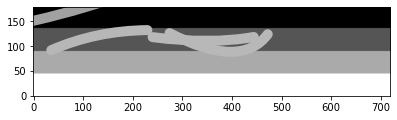

0.003649161160689735
Processing: WE=3.5, WG=0.0, WI=2.0, Species=0
Processing: WE=3.5, WG=0.0, WI=2.0, Species=1
Processing: WE=3.5, WG=0.0, WI=2.0, Species=2
Processing: WE=3.5, WG=0.0, WI=2.0, Species=3
Processing: WE=3.5, WG=0.0, WI=2.0, Species=4


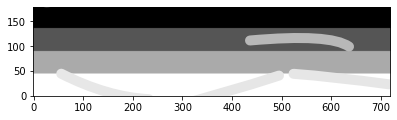

0.0034660412467988296
Processing: WE=3.5, WG=0.0, WI=2.5, Species=0
Processing: WE=3.5, WG=0.0, WI=2.5, Species=1
Processing: WE=3.5, WG=0.0, WI=2.5, Species=2
Processing: WE=3.5, WG=0.0, WI=2.5, Species=3
Processing: WE=3.5, WG=0.0, WI=2.5, Species=4


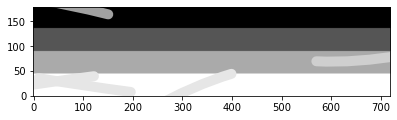

0.0032610597397588585
Processing: WE=3.5, WG=0.0, WI=3.0, Species=0
Processing: WE=3.5, WG=0.0, WI=3.0, Species=1
Processing: WE=3.5, WG=0.0, WI=3.0, Species=2
Processing: WE=3.5, WG=0.0, WI=3.0, Species=3
Processing: WE=3.5, WG=0.0, WI=3.0, Species=4


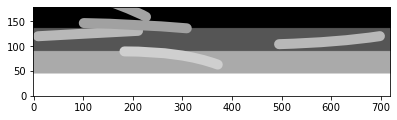

0.004270191267136604
Processing: WE=3.5, WG=0.0, WI=3.5, Species=0
Processing: WE=3.5, WG=0.0, WI=3.5, Species=1
Processing: WE=3.5, WG=0.0, WI=3.5, Species=2
Processing: WE=3.5, WG=0.0, WI=3.5, Species=3
Processing: WE=3.5, WG=0.0, WI=3.5, Species=4


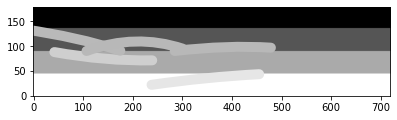

0.004645094332629082
Processing: WE=3.5, WG=0.0, WI=4.0, Species=0
Processing: WE=3.5, WG=0.0, WI=4.0, Species=1
Processing: WE=3.5, WG=0.0, WI=4.0, Species=2
Processing: WE=3.5, WG=0.0, WI=4.0, Species=3
Processing: WE=3.5, WG=0.0, WI=4.0, Species=4


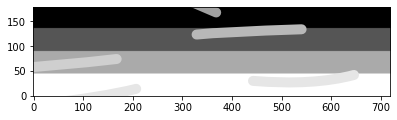

0.003905133670899201
Processing: WE=3.5, WG=0.5, WI=0.0, Species=0
Processing: WE=3.5, WG=0.5, WI=0.0, Species=1
Processing: WE=3.5, WG=0.5, WI=0.0, Species=2
Processing: WE=3.5, WG=0.5, WI=0.0, Species=3
Processing: WE=3.5, WG=0.5, WI=0.0, Species=4


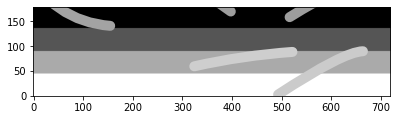

0.003003498000260188
Processing: WE=3.5, WG=0.5, WI=0.5, Species=0
Processing: WE=3.5, WG=0.5, WI=0.5, Species=1
Processing: WE=3.5, WG=0.5, WI=0.5, Species=2
Processing: WE=3.5, WG=0.5, WI=0.5, Species=3
Processing: WE=3.5, WG=0.5, WI=0.5, Species=4


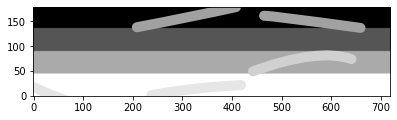

0.005004327984946898
Processing: WE=3.5, WG=0.5, WI=1.0, Species=0
Processing: WE=3.5, WG=0.5, WI=1.0, Species=1
Processing: WE=3.5, WG=0.5, WI=1.0, Species=2
Processing: WE=3.5, WG=0.5, WI=1.0, Species=3
Processing: WE=3.5, WG=0.5, WI=1.0, Species=4


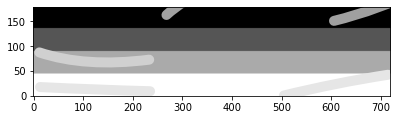

0.004701948041408144
Processing: WE=3.5, WG=0.5, WI=1.5, Species=0
Processing: WE=3.5, WG=0.5, WI=1.5, Species=1
Processing: WE=3.5, WG=0.5, WI=1.5, Species=2
Processing: WE=3.5, WG=0.5, WI=1.5, Species=3
Processing: WE=3.5, WG=0.5, WI=1.5, Species=4


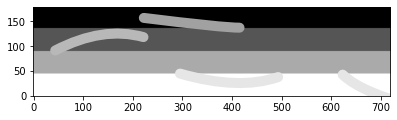

0.003657398019810616
Processing: WE=3.5, WG=0.5, WI=2.0, Species=0
Processing: WE=3.5, WG=0.5, WI=2.0, Species=1
Processing: WE=3.5, WG=0.5, WI=2.0, Species=2
Processing: WE=3.5, WG=0.5, WI=2.0, Species=3
Processing: WE=3.5, WG=0.5, WI=2.0, Species=4


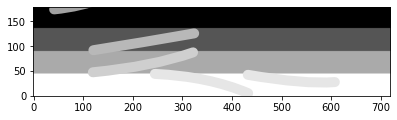

0.0043728031509377785
Processing: WE=3.5, WG=0.5, WI=2.5, Species=0
Processing: WE=3.5, WG=0.5, WI=2.5, Species=1
Processing: WE=3.5, WG=0.5, WI=2.5, Species=2
Processing: WE=3.5, WG=0.5, WI=2.5, Species=3
Processing: WE=3.5, WG=0.5, WI=2.5, Species=4


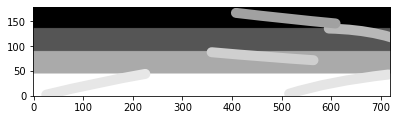

0.005046752654630678
Processing: WE=3.5, WG=0.5, WI=3.0, Species=0
Processing: WE=3.5, WG=0.5, WI=3.0, Species=1
Processing: WE=3.5, WG=0.5, WI=3.0, Species=2
Processing: WE=3.5, WG=0.5, WI=3.0, Species=3
Processing: WE=3.5, WG=0.5, WI=3.0, Species=4


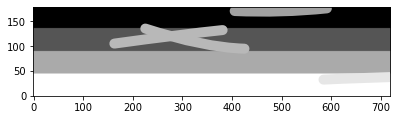

0.0033458993887039235
Processing: WE=3.5, WG=0.5, WI=3.5, Species=0
Processing: WE=3.5, WG=0.5, WI=3.5, Species=1
Processing: WE=3.5, WG=0.5, WI=3.5, Species=2
Processing: WE=3.5, WG=0.5, WI=3.5, Species=3
Processing: WE=3.5, WG=0.5, WI=3.5, Species=4


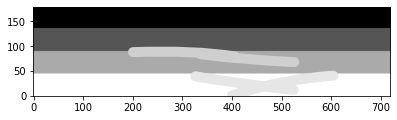

0.0037846041959044884
Processing: WE=3.5, WG=0.5, WI=4.0, Species=0
Processing: WE=3.5, WG=0.5, WI=4.0, Species=1
Processing: WE=3.5, WG=0.5, WI=4.0, Species=2
Processing: WE=3.5, WG=0.5, WI=4.0, Species=3
Processing: WE=3.5, WG=0.5, WI=4.0, Species=4


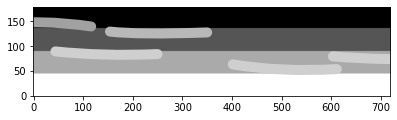

0.004315271112584056
Processing: WE=3.5, WG=1.0, WI=0.0, Species=0
Processing: WE=3.5, WG=1.0, WI=0.0, Species=1
Processing: WE=3.5, WG=1.0, WI=0.0, Species=2
Processing: WE=3.5, WG=1.0, WI=0.0, Species=3
Processing: WE=3.5, WG=1.0, WI=0.0, Species=4


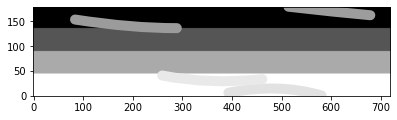

0.005678742628919564
Processing: WE=3.5, WG=1.0, WI=0.5, Species=0
Processing: WE=3.5, WG=1.0, WI=0.5, Species=1
Processing: WE=3.5, WG=1.0, WI=0.5, Species=2
Processing: WE=3.5, WG=1.0, WI=0.5, Species=3
Processing: WE=3.5, WG=1.0, WI=0.5, Species=4


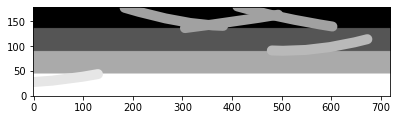

0.0036903260754491455
Processing: WE=3.5, WG=1.0, WI=1.0, Species=0
Processing: WE=3.5, WG=1.0, WI=1.0, Species=1
Processing: WE=3.5, WG=1.0, WI=1.0, Species=2
Processing: WE=3.5, WG=1.0, WI=1.0, Species=3
Processing: WE=3.5, WG=1.0, WI=1.0, Species=4


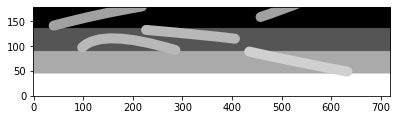

0.004510087366426611
Processing: WE=3.5, WG=1.0, WI=1.5, Species=0
Processing: WE=3.5, WG=1.0, WI=1.5, Species=1
Processing: WE=3.5, WG=1.0, WI=1.5, Species=2
Processing: WE=3.5, WG=1.0, WI=1.5, Species=3
Processing: WE=3.5, WG=1.0, WI=1.5, Species=4


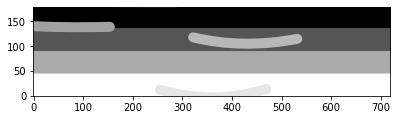

0.0029580305379129303
Processing: WE=3.5, WG=1.0, WI=2.0, Species=0
Processing: WE=3.5, WG=1.0, WI=2.0, Species=1
Processing: WE=3.5, WG=1.0, WI=2.0, Species=2
Processing: WE=3.5, WG=1.0, WI=2.0, Species=3
Processing: WE=3.5, WG=1.0, WI=2.0, Species=4


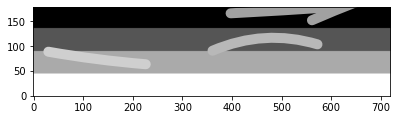

0.0029868983065259908
Processing: WE=3.5, WG=1.0, WI=2.5, Species=0
Processing: WE=3.5, WG=1.0, WI=2.5, Species=1
Processing: WE=3.5, WG=1.0, WI=2.5, Species=2
Processing: WE=3.5, WG=1.0, WI=2.5, Species=3
Processing: WE=3.5, WG=1.0, WI=2.5, Species=4


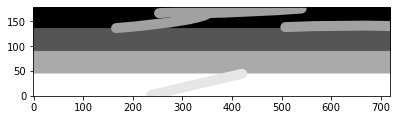

0.004233173853205119
Processing: WE=3.5, WG=1.0, WI=3.0, Species=0
Processing: WE=3.5, WG=1.0, WI=3.0, Species=1
Processing: WE=3.5, WG=1.0, WI=3.0, Species=2
Processing: WE=3.5, WG=1.0, WI=3.0, Species=3
Processing: WE=3.5, WG=1.0, WI=3.0, Species=4


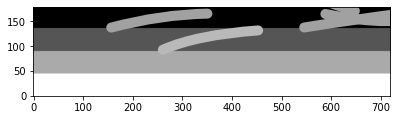

0.0025458484170815983
Processing: WE=3.5, WG=1.0, WI=3.5, Species=0
Processing: WE=3.5, WG=1.0, WI=3.5, Species=1
Processing: WE=3.5, WG=1.0, WI=3.5, Species=2
Processing: WE=3.5, WG=1.0, WI=3.5, Species=3
Processing: WE=3.5, WG=1.0, WI=3.5, Species=4


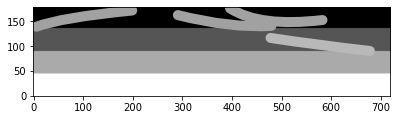

0.003552189102780739
Processing: WE=3.5, WG=1.0, WI=4.0, Species=0
Processing: WE=3.5, WG=1.0, WI=4.0, Species=1
Processing: WE=3.5, WG=1.0, WI=4.0, Species=2
Processing: WE=3.5, WG=1.0, WI=4.0, Species=3
Processing: WE=3.5, WG=1.0, WI=4.0, Species=4


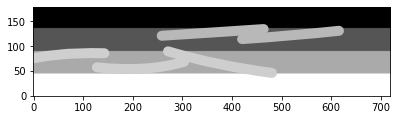

0.004086625593810921
Processing: WE=3.5, WG=1.5, WI=0.0, Species=0
Processing: WE=3.5, WG=1.5, WI=0.0, Species=1
Processing: WE=3.5, WG=1.5, WI=0.0, Species=2
Processing: WE=3.5, WG=1.5, WI=0.0, Species=3
Processing: WE=3.5, WG=1.5, WI=0.0, Species=4


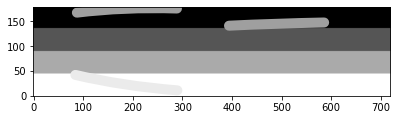

0.004874582918159294
Processing: WE=3.5, WG=1.5, WI=0.5, Species=0
Processing: WE=3.5, WG=1.5, WI=0.5, Species=1
Processing: WE=3.5, WG=1.5, WI=0.5, Species=2
Processing: WE=3.5, WG=1.5, WI=0.5, Species=3
Processing: WE=3.5, WG=1.5, WI=0.5, Species=4


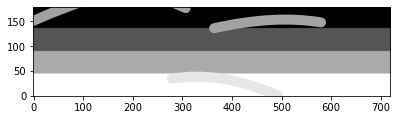

0.003132303096065761
Processing: WE=3.5, WG=1.5, WI=1.0, Species=0
Processing: WE=3.5, WG=1.5, WI=1.0, Species=1
Processing: WE=3.5, WG=1.5, WI=1.0, Species=2
Processing: WE=3.5, WG=1.5, WI=1.0, Species=3
Processing: WE=3.5, WG=1.5, WI=1.0, Species=4


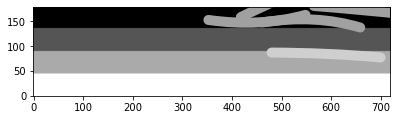

0.0029923346335457715
Processing: WE=3.5, WG=1.5, WI=1.5, Species=0
Processing: WE=3.5, WG=1.5, WI=1.5, Species=1
Processing: WE=3.5, WG=1.5, WI=1.5, Species=2
Processing: WE=3.5, WG=1.5, WI=1.5, Species=3
Processing: WE=3.5, WG=1.5, WI=1.5, Species=4


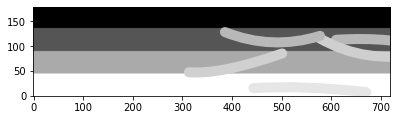

0.004945478049133834
Processing: WE=3.5, WG=1.5, WI=2.0, Species=0
Processing: WE=3.5, WG=1.5, WI=2.0, Species=1
Processing: WE=3.5, WG=1.5, WI=2.0, Species=2
Processing: WE=3.5, WG=1.5, WI=2.0, Species=3
Processing: WE=3.5, WG=1.5, WI=2.0, Species=4


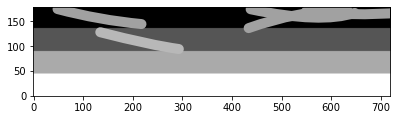

0.0030870391325909016
Processing: WE=3.5, WG=1.5, WI=2.5, Species=0
Processing: WE=3.5, WG=1.5, WI=2.5, Species=1
Processing: WE=3.5, WG=1.5, WI=2.5, Species=2
Processing: WE=3.5, WG=1.5, WI=2.5, Species=3
Processing: WE=3.5, WG=1.5, WI=2.5, Species=4


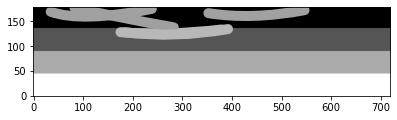

0.0026906814716941545
Processing: WE=3.5, WG=1.5, WI=3.0, Species=0
Processing: WE=3.5, WG=1.5, WI=3.0, Species=1
Processing: WE=3.5, WG=1.5, WI=3.0, Species=2
Processing: WE=3.5, WG=1.5, WI=3.0, Species=3
Processing: WE=3.5, WG=1.5, WI=3.0, Species=4


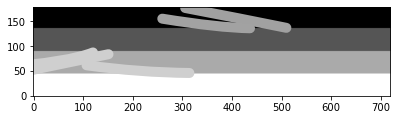

0.003890830607296355
Processing: WE=3.5, WG=1.5, WI=3.5, Species=0
Processing: WE=3.5, WG=1.5, WI=3.5, Species=1
Processing: WE=3.5, WG=1.5, WI=3.5, Species=2
Processing: WE=3.5, WG=1.5, WI=3.5, Species=3
Processing: WE=3.5, WG=1.5, WI=3.5, Species=4


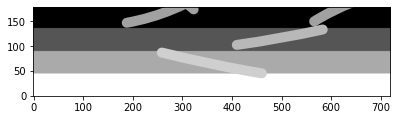

0.002631647417853683
Processing: WE=3.5, WG=1.5, WI=4.0, Species=0
Processing: WE=3.5, WG=1.5, WI=4.0, Species=1
Processing: WE=3.5, WG=1.5, WI=4.0, Species=2
Processing: WE=3.5, WG=1.5, WI=4.0, Species=3
Processing: WE=3.5, WG=1.5, WI=4.0, Species=4


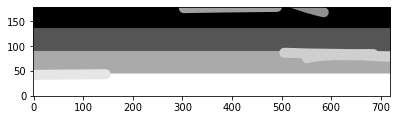

0.0024138454818526246
Processing: WE=3.5, WG=2.0, WI=0.0, Species=0
Processing: WE=3.5, WG=2.0, WI=0.0, Species=1
Processing: WE=3.5, WG=2.0, WI=0.0, Species=2
Processing: WE=3.5, WG=2.0, WI=0.0, Species=3
Processing: WE=3.5, WG=2.0, WI=0.0, Species=4


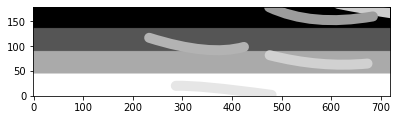

0.005805774377408524
Processing: WE=3.5, WG=2.0, WI=0.5, Species=0
Processing: WE=3.5, WG=2.0, WI=0.5, Species=1
Processing: WE=3.5, WG=2.0, WI=0.5, Species=2
Processing: WE=3.5, WG=2.0, WI=0.5, Species=3
Processing: WE=3.5, WG=2.0, WI=0.5, Species=4


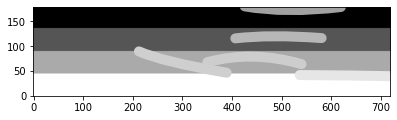

0.005538987355694467
Processing: WE=3.5, WG=2.0, WI=1.0, Species=0
Processing: WE=3.5, WG=2.0, WI=1.0, Species=1
Processing: WE=3.5, WG=2.0, WI=1.0, Species=2
Processing: WE=3.5, WG=2.0, WI=1.0, Species=3
Processing: WE=3.5, WG=2.0, WI=1.0, Species=4


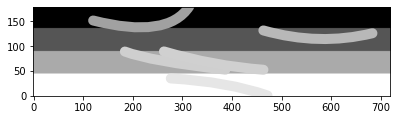

0.0057604522713986936
Processing: WE=3.5, WG=2.0, WI=1.5, Species=0
Processing: WE=3.5, WG=2.0, WI=1.5, Species=1
Processing: WE=3.5, WG=2.0, WI=1.5, Species=2
Processing: WE=3.5, WG=2.0, WI=1.5, Species=3
Processing: WE=3.5, WG=2.0, WI=1.5, Species=4


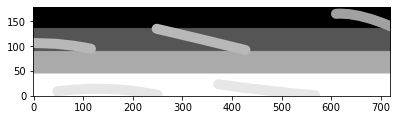

0.003899590749231974
Processing: WE=3.5, WG=2.0, WI=2.0, Species=0
Processing: WE=3.5, WG=2.0, WI=2.0, Species=1
Processing: WE=3.5, WG=2.0, WI=2.0, Species=2
Processing: WE=3.5, WG=2.0, WI=2.0, Species=3
Processing: WE=3.5, WG=2.0, WI=2.0, Species=4


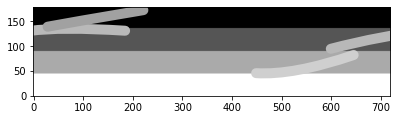

0.002900866735614023
Processing: WE=3.5, WG=2.0, WI=2.5, Species=0
Processing: WE=3.5, WG=2.0, WI=2.5, Species=1
Processing: WE=3.5, WG=2.0, WI=2.5, Species=2
Processing: WE=3.5, WG=2.0, WI=2.5, Species=3
Processing: WE=3.5, WG=2.0, WI=2.5, Species=4


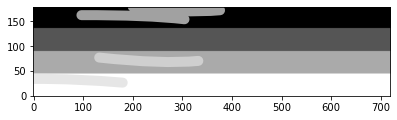

0.0033557739292264833
Processing: WE=3.5, WG=2.0, WI=3.0, Species=0
Processing: WE=3.5, WG=2.0, WI=3.0, Species=1
Processing: WE=3.5, WG=2.0, WI=3.0, Species=2
Processing: WE=3.5, WG=2.0, WI=3.0, Species=3
Processing: WE=3.5, WG=2.0, WI=3.0, Species=4


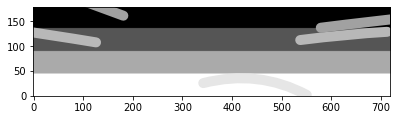

0.0036398971167843695
Processing: WE=3.5, WG=2.0, WI=3.5, Species=0
Processing: WE=3.5, WG=2.0, WI=3.5, Species=1
Processing: WE=3.5, WG=2.0, WI=3.5, Species=2
Processing: WE=3.5, WG=2.0, WI=3.5, Species=3
Processing: WE=3.5, WG=2.0, WI=3.5, Species=4


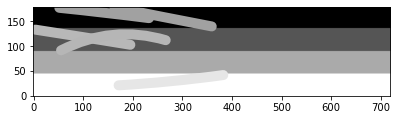

0.005431665926560648
Processing: WE=3.5, WG=2.0, WI=4.0, Species=0
Processing: WE=3.5, WG=2.0, WI=4.0, Species=1
Processing: WE=3.5, WG=2.0, WI=4.0, Species=2
Processing: WE=3.5, WG=2.0, WI=4.0, Species=3
Processing: WE=3.5, WG=2.0, WI=4.0, Species=4


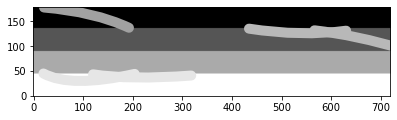

0.004065510163193982
Processing: WE=3.5, WG=2.5, WI=0.0, Species=0
Processing: WE=3.5, WG=2.5, WI=0.0, Species=1
Processing: WE=3.5, WG=2.5, WI=0.0, Species=2
Processing: WE=3.5, WG=2.5, WI=0.0, Species=3
Processing: WE=3.5, WG=2.5, WI=0.0, Species=4


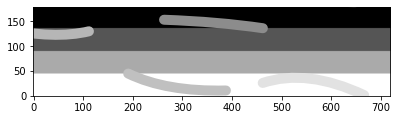

0.005018291883762413
Processing: WE=3.5, WG=2.5, WI=0.5, Species=0
Processing: WE=3.5, WG=2.5, WI=0.5, Species=1
Processing: WE=3.5, WG=2.5, WI=0.5, Species=2
Processing: WE=3.5, WG=2.5, WI=0.5, Species=3
Processing: WE=3.5, WG=2.5, WI=0.5, Species=4


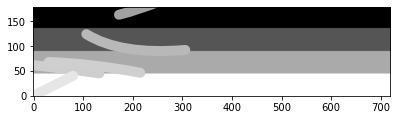

0.0030499151240119707
Processing: WE=3.5, WG=2.5, WI=1.0, Species=0
Processing: WE=3.5, WG=2.5, WI=1.0, Species=1
Processing: WE=3.5, WG=2.5, WI=1.0, Species=2
Processing: WE=3.5, WG=2.5, WI=1.0, Species=3
Processing: WE=3.5, WG=2.5, WI=1.0, Species=4


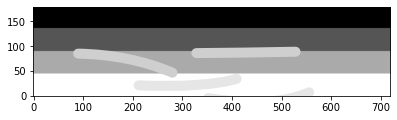

0.0036001179324417656
Processing: WE=3.5, WG=2.5, WI=1.5, Species=0
Processing: WE=3.5, WG=2.5, WI=1.5, Species=1
Processing: WE=3.5, WG=2.5, WI=1.5, Species=2
Processing: WE=3.5, WG=2.5, WI=1.5, Species=3
Processing: WE=3.5, WG=2.5, WI=1.5, Species=4


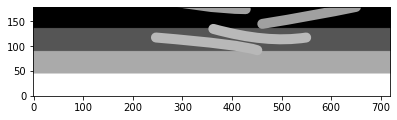

0.002084429259552395
Processing: WE=3.5, WG=2.5, WI=2.0, Species=0
Processing: WE=3.5, WG=2.5, WI=2.0, Species=1
Processing: WE=3.5, WG=2.5, WI=2.0, Species=2
Processing: WE=3.5, WG=2.5, WI=2.0, Species=3
Processing: WE=3.5, WG=2.5, WI=2.0, Species=4


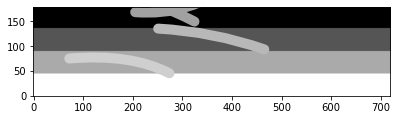

0.0027422151385233786
Processing: WE=3.5, WG=2.5, WI=2.5, Species=0
Processing: WE=3.5, WG=2.5, WI=2.5, Species=1
Processing: WE=3.5, WG=2.5, WI=2.5, Species=2
Processing: WE=3.5, WG=2.5, WI=2.5, Species=3
Processing: WE=3.5, WG=2.5, WI=2.5, Species=4


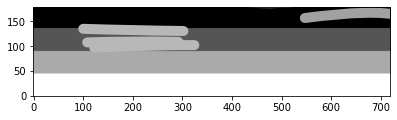

0.0035153558068766627
Processing: WE=3.5, WG=2.5, WI=3.0, Species=0
Processing: WE=3.5, WG=2.5, WI=3.0, Species=1
Processing: WE=3.5, WG=2.5, WI=3.0, Species=2
Processing: WE=3.5, WG=2.5, WI=3.0, Species=3
Processing: WE=3.5, WG=2.5, WI=3.0, Species=4


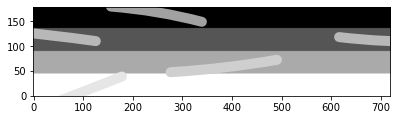

0.0033939445034348913
Processing: WE=3.5, WG=2.5, WI=3.5, Species=0
Processing: WE=3.5, WG=2.5, WI=3.5, Species=1
Processing: WE=3.5, WG=2.5, WI=3.5, Species=2
Processing: WE=3.5, WG=2.5, WI=3.5, Species=3
Processing: WE=3.5, WG=2.5, WI=3.5, Species=4


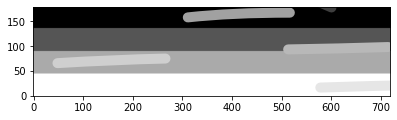

0.004064163194467157
Processing: WE=3.5, WG=2.5, WI=4.0, Species=0
Processing: WE=3.5, WG=2.5, WI=4.0, Species=1
Processing: WE=3.5, WG=2.5, WI=4.0, Species=2
Processing: WE=3.5, WG=2.5, WI=4.0, Species=3
Processing: WE=3.5, WG=2.5, WI=4.0, Species=4


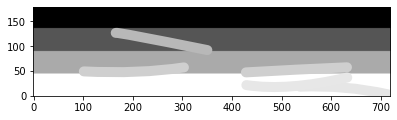

0.004252661292842872
Processing: WE=3.5, WG=3.0, WI=0.0, Species=0
Processing: WE=3.5, WG=3.0, WI=0.0, Species=1
Processing: WE=3.5, WG=3.0, WI=0.0, Species=2
Processing: WE=3.5, WG=3.0, WI=0.0, Species=3
Processing: WE=3.5, WG=3.0, WI=0.0, Species=4


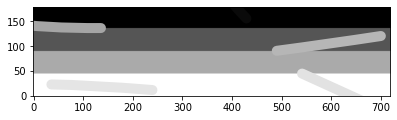

0.005118655589544713
Processing: WE=3.5, WG=3.0, WI=0.5, Species=0
Processing: WE=3.5, WG=3.0, WI=0.5, Species=1
Processing: WE=3.5, WG=3.0, WI=0.5, Species=2
Processing: WE=3.5, WG=3.0, WI=0.5, Species=3
Processing: WE=3.5, WG=3.0, WI=0.5, Species=4


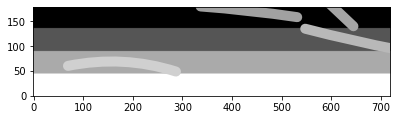

0.003540085765084293
Processing: WE=3.5, WG=3.0, WI=1.0, Species=0
Processing: WE=3.5, WG=3.0, WI=1.0, Species=1
Processing: WE=3.5, WG=3.0, WI=1.0, Species=2
Processing: WE=3.5, WG=3.0, WI=1.0, Species=3
Processing: WE=3.5, WG=3.0, WI=1.0, Species=4


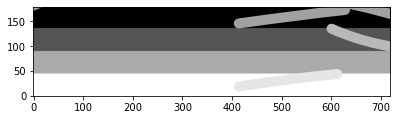

0.002871301256581311
Processing: WE=3.5, WG=3.0, WI=1.5, Species=0
Processing: WE=3.5, WG=3.0, WI=1.5, Species=1
Processing: WE=3.5, WG=3.0, WI=1.5, Species=2
Processing: WE=3.5, WG=3.0, WI=1.5, Species=3
Processing: WE=3.5, WG=3.0, WI=1.5, Species=4


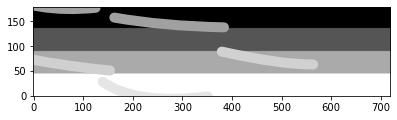

0.005291484274745766
Processing: WE=3.5, WG=3.0, WI=2.0, Species=0
Processing: WE=3.5, WG=3.0, WI=2.0, Species=1
Processing: WE=3.5, WG=3.0, WI=2.0, Species=2
Processing: WE=3.5, WG=3.0, WI=2.0, Species=3
Processing: WE=3.5, WG=3.0, WI=2.0, Species=4


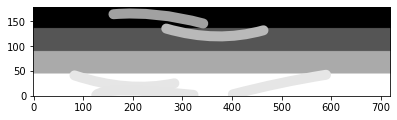

0.004846093076023544
Processing: WE=3.5, WG=3.0, WI=2.5, Species=0
Processing: WE=3.5, WG=3.0, WI=2.5, Species=1
Processing: WE=3.5, WG=3.0, WI=2.5, Species=2
Processing: WE=3.5, WG=3.0, WI=2.5, Species=3
Processing: WE=3.5, WG=3.0, WI=2.5, Species=4


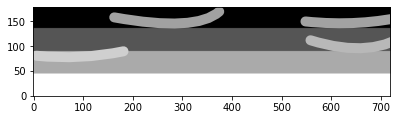

0.003839762080746899
Processing: WE=3.5, WG=3.0, WI=3.0, Species=0
Processing: WE=3.5, WG=3.0, WI=3.0, Species=1
Processing: WE=3.5, WG=3.0, WI=3.0, Species=2
Processing: WE=3.5, WG=3.0, WI=3.0, Species=3
Processing: WE=3.5, WG=3.0, WI=3.0, Species=4


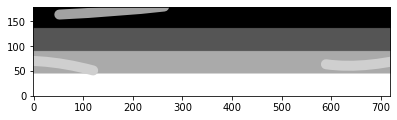

0.0024848375170521157
Processing: WE=3.5, WG=3.0, WI=3.5, Species=0
Processing: WE=3.5, WG=3.0, WI=3.5, Species=1
Processing: WE=3.5, WG=3.0, WI=3.5, Species=2
Processing: WE=3.5, WG=3.0, WI=3.5, Species=3
Processing: WE=3.5, WG=3.0, WI=3.5, Species=4


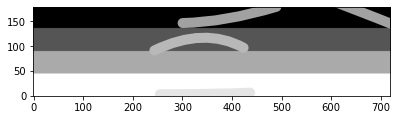

0.003490587086979052
Processing: WE=3.5, WG=3.0, WI=4.0, Species=0
Processing: WE=3.5, WG=3.0, WI=4.0, Species=1
Processing: WE=3.5, WG=3.0, WI=4.0, Species=2
Processing: WE=3.5, WG=3.0, WI=4.0, Species=3
Processing: WE=3.5, WG=3.0, WI=4.0, Species=4


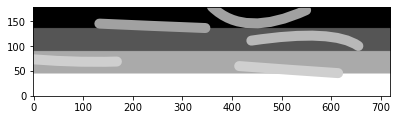

0.0048414998157608425
Processing: WE=3.5, WG=3.5, WI=0.0, Species=0
Processing: WE=3.5, WG=3.5, WI=0.0, Species=1
Processing: WE=3.5, WG=3.5, WI=0.0, Species=2
Processing: WE=3.5, WG=3.5, WI=0.0, Species=3
Processing: WE=3.5, WG=3.5, WI=0.0, Species=4


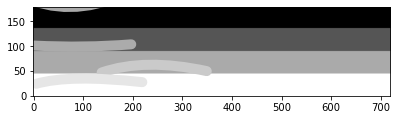

0.004028696248134897
Processing: WE=3.5, WG=3.5, WI=0.5, Species=0
Processing: WE=3.5, WG=3.5, WI=0.5, Species=1
Processing: WE=3.5, WG=3.5, WI=0.5, Species=2
Processing: WE=3.5, WG=3.5, WI=0.5, Species=3
Processing: WE=3.5, WG=3.5, WI=0.5, Species=4


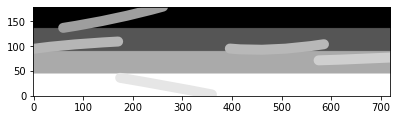

0.005988419460597167
Processing: WE=3.5, WG=3.5, WI=1.0, Species=0
Processing: WE=3.5, WG=3.5, WI=1.0, Species=1
Processing: WE=3.5, WG=3.5, WI=1.0, Species=2
Processing: WE=3.5, WG=3.5, WI=1.0, Species=3
Processing: WE=3.5, WG=3.5, WI=1.0, Species=4


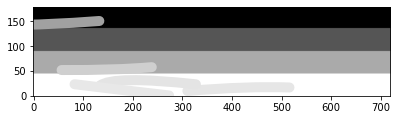

0.0048897484293642084
Processing: WE=3.5, WG=3.5, WI=1.5, Species=0
Processing: WE=3.5, WG=3.5, WI=1.5, Species=1
Processing: WE=3.5, WG=3.5, WI=1.5, Species=2
Processing: WE=3.5, WG=3.5, WI=1.5, Species=3
Processing: WE=3.5, WG=3.5, WI=1.5, Species=4


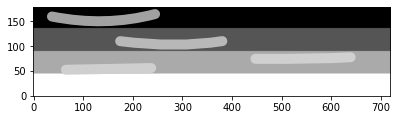

0.004331841735050767
Processing: WE=3.5, WG=3.5, WI=2.0, Species=0
Processing: WE=3.5, WG=3.5, WI=2.0, Species=1
Processing: WE=3.5, WG=3.5, WI=2.0, Species=2
Processing: WE=3.5, WG=3.5, WI=2.0, Species=3
Processing: WE=3.5, WG=3.5, WI=2.0, Species=4


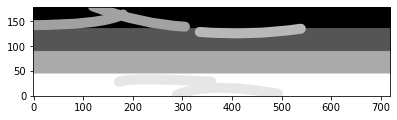

0.005347281727472857
Processing: WE=3.5, WG=3.5, WI=2.5, Species=0
Processing: WE=3.5, WG=3.5, WI=2.5, Species=1
Processing: WE=3.5, WG=3.5, WI=2.5, Species=2
Processing: WE=3.5, WG=3.5, WI=2.5, Species=3
Processing: WE=3.5, WG=3.5, WI=2.5, Species=4


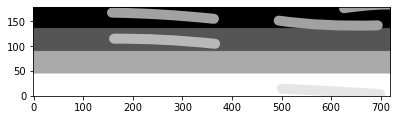

0.0048175935434653
Processing: WE=3.5, WG=3.5, WI=3.0, Species=0
Processing: WE=3.5, WG=3.5, WI=3.0, Species=1
Processing: WE=3.5, WG=3.5, WI=3.0, Species=2
Processing: WE=3.5, WG=3.5, WI=3.0, Species=3
Processing: WE=3.5, WG=3.5, WI=3.0, Species=4


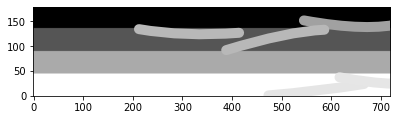

0.004918151057697503
Processing: WE=3.5, WG=3.5, WI=3.5, Species=0
Processing: WE=3.5, WG=3.5, WI=3.5, Species=1
Processing: WE=3.5, WG=3.5, WI=3.5, Species=2
Processing: WE=3.5, WG=3.5, WI=3.5, Species=3
Processing: WE=3.5, WG=3.5, WI=3.5, Species=4


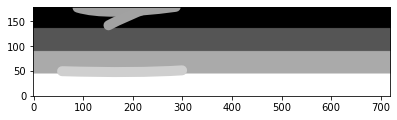

0.0020505127808193593
Processing: WE=3.5, WG=3.5, WI=4.0, Species=0
Processing: WE=3.5, WG=3.5, WI=4.0, Species=1
Processing: WE=3.5, WG=3.5, WI=4.0, Species=2
Processing: WE=3.5, WG=3.5, WI=4.0, Species=3
Processing: WE=3.5, WG=3.5, WI=4.0, Species=4


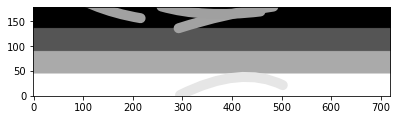

0.0023461191190340008
Processing: WE=3.5, WG=4.0, WI=0.0, Species=0
Processing: WE=3.5, WG=4.0, WI=0.0, Species=1
Processing: WE=3.5, WG=4.0, WI=0.0, Species=2
Processing: WE=3.5, WG=4.0, WI=0.0, Species=3
Processing: WE=3.5, WG=4.0, WI=0.0, Species=4


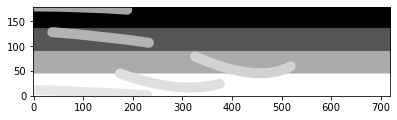

0.00448253749527289
Processing: WE=3.5, WG=4.0, WI=0.5, Species=0
Processing: WE=3.5, WG=4.0, WI=0.5, Species=1
Processing: WE=3.5, WG=4.0, WI=0.5, Species=2
Processing: WE=3.5, WG=4.0, WI=0.5, Species=3
Processing: WE=3.5, WG=4.0, WI=0.5, Species=4


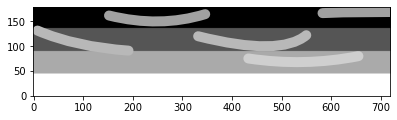

0.00450846906586992
Processing: WE=3.5, WG=4.0, WI=1.0, Species=0
Processing: WE=3.5, WG=4.0, WI=1.0, Species=1
Processing: WE=3.5, WG=4.0, WI=1.0, Species=2
Processing: WE=3.5, WG=4.0, WI=1.0, Species=3
Processing: WE=3.5, WG=4.0, WI=1.0, Species=4


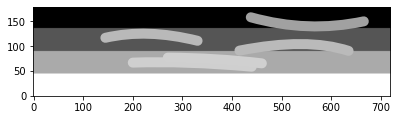

0.006035950982935892
Processing: WE=3.5, WG=4.0, WI=1.5, Species=0
Processing: WE=3.5, WG=4.0, WI=1.5, Species=1
Processing: WE=3.5, WG=4.0, WI=1.5, Species=2
Processing: WE=3.5, WG=4.0, WI=1.5, Species=3
Processing: WE=3.5, WG=4.0, WI=1.5, Species=4


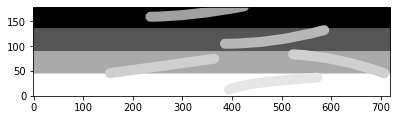

0.00542446594264675
Processing: WE=3.5, WG=4.0, WI=2.0, Species=0
Processing: WE=3.5, WG=4.0, WI=2.0, Species=1
Processing: WE=3.5, WG=4.0, WI=2.0, Species=2
Processing: WE=3.5, WG=4.0, WI=2.0, Species=3
Processing: WE=3.5, WG=4.0, WI=2.0, Species=4


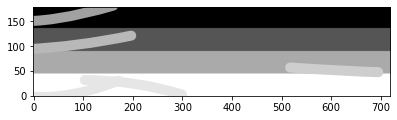

0.0036614292355685992
Processing: WE=3.5, WG=4.0, WI=2.5, Species=0
Processing: WE=3.5, WG=4.0, WI=2.5, Species=1
Processing: WE=3.5, WG=4.0, WI=2.5, Species=2
Processing: WE=3.5, WG=4.0, WI=2.5, Species=3
Processing: WE=3.5, WG=4.0, WI=2.5, Species=4


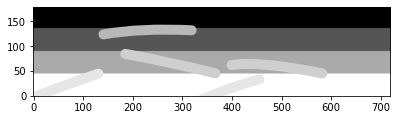

0.004236584881923413
Processing: WE=3.5, WG=4.0, WI=3.0, Species=0
Processing: WE=3.5, WG=4.0, WI=3.0, Species=1
Processing: WE=3.5, WG=4.0, WI=3.0, Species=2
Processing: WE=3.5, WG=4.0, WI=3.0, Species=3
Processing: WE=3.5, WG=4.0, WI=3.0, Species=4


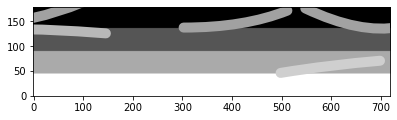

0.004281926368778234
Processing: WE=3.5, WG=4.0, WI=3.5, Species=0
Processing: WE=3.5, WG=4.0, WI=3.5, Species=1
Processing: WE=3.5, WG=4.0, WI=3.5, Species=2
Processing: WE=3.5, WG=4.0, WI=3.5, Species=3
Processing: WE=3.5, WG=4.0, WI=3.5, Species=4


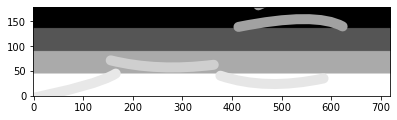

0.003686004147016307
Processing: WE=3.5, WG=4.0, WI=4.0, Species=0
Processing: WE=3.5, WG=4.0, WI=4.0, Species=1
Processing: WE=3.5, WG=4.0, WI=4.0, Species=2
Processing: WE=3.5, WG=4.0, WI=4.0, Species=3
Processing: WE=3.5, WG=4.0, WI=4.0, Species=4


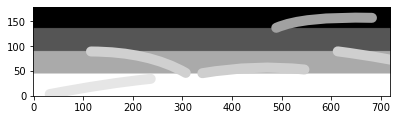

0.004658496186939878
Processing: WE=4.0, WG=0.0, WI=0.0, Species=0
Processing: WE=4.0, WG=0.0, WI=0.0, Species=1
Processing: WE=4.0, WG=0.0, WI=0.0, Species=2
Processing: WE=4.0, WG=0.0, WI=0.0, Species=3
Processing: WE=4.0, WG=0.0, WI=0.0, Species=4


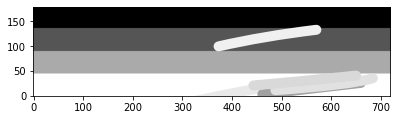

0.005930499805343639
Processing: WE=4.0, WG=0.0, WI=0.5, Species=0
Processing: WE=4.0, WG=0.0, WI=0.5, Species=1
Processing: WE=4.0, WG=0.0, WI=0.5, Species=2
Processing: WE=4.0, WG=0.0, WI=0.5, Species=3
Processing: WE=4.0, WG=0.0, WI=0.5, Species=4


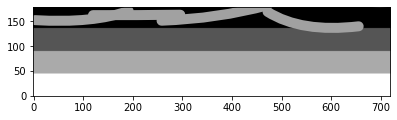

0.003021822589198522
Processing: WE=4.0, WG=0.0, WI=1.0, Species=0
Processing: WE=4.0, WG=0.0, WI=1.0, Species=1
Processing: WE=4.0, WG=0.0, WI=1.0, Species=2
Processing: WE=4.0, WG=0.0, WI=1.0, Species=3
Processing: WE=4.0, WG=0.0, WI=1.0, Species=4


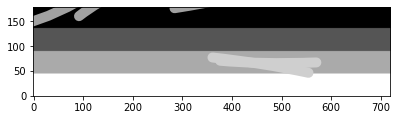

0.0019110966723815933
Processing: WE=4.0, WG=0.0, WI=1.5, Species=0
Processing: WE=4.0, WG=0.0, WI=1.5, Species=1
Processing: WE=4.0, WG=0.0, WI=1.5, Species=2
Processing: WE=4.0, WG=0.0, WI=1.5, Species=3
Processing: WE=4.0, WG=0.0, WI=1.5, Species=4


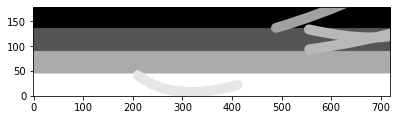

0.0031371870690033183
Processing: WE=4.0, WG=0.0, WI=2.0, Species=0
Processing: WE=4.0, WG=0.0, WI=2.0, Species=1
Processing: WE=4.0, WG=0.0, WI=2.0, Species=2
Processing: WE=4.0, WG=0.0, WI=2.0, Species=3
Processing: WE=4.0, WG=0.0, WI=2.0, Species=4


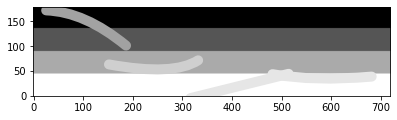

0.0039746236906119435
Processing: WE=4.0, WG=0.0, WI=2.5, Species=0
Processing: WE=4.0, WG=0.0, WI=2.5, Species=1
Processing: WE=4.0, WG=0.0, WI=2.5, Species=2
Processing: WE=4.0, WG=0.0, WI=2.5, Species=3
Processing: WE=4.0, WG=0.0, WI=2.5, Species=4


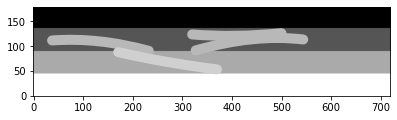

0.004100754229808854
Processing: WE=4.0, WG=0.0, WI=3.0, Species=0
Processing: WE=4.0, WG=0.0, WI=3.0, Species=1
Processing: WE=4.0, WG=0.0, WI=3.0, Species=2
Processing: WE=4.0, WG=0.0, WI=3.0, Species=3
Processing: WE=4.0, WG=0.0, WI=3.0, Species=4


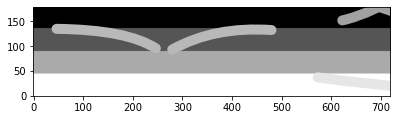

0.003504134297627276
Processing: WE=4.0, WG=0.0, WI=3.5, Species=0
Processing: WE=4.0, WG=0.0, WI=3.5, Species=1
Processing: WE=4.0, WG=0.0, WI=3.5, Species=2
Processing: WE=4.0, WG=0.0, WI=3.5, Species=3
Processing: WE=4.0, WG=0.0, WI=3.5, Species=4


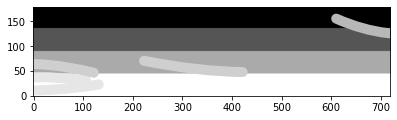

0.00345276536798047
Processing: WE=4.0, WG=0.0, WI=4.0, Species=0
Processing: WE=4.0, WG=0.0, WI=4.0, Species=1
Processing: WE=4.0, WG=0.0, WI=4.0, Species=2
Processing: WE=4.0, WG=0.0, WI=4.0, Species=3
Processing: WE=4.0, WG=0.0, WI=4.0, Species=4


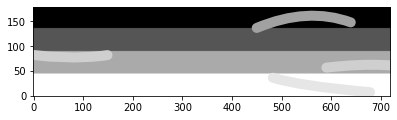

0.0035450763326692974
Processing: WE=4.0, WG=0.5, WI=0.0, Species=0
Processing: WE=4.0, WG=0.5, WI=0.0, Species=1
Processing: WE=4.0, WG=0.5, WI=0.0, Species=2
Processing: WE=4.0, WG=0.5, WI=0.0, Species=3
Processing: WE=4.0, WG=0.5, WI=0.0, Species=4


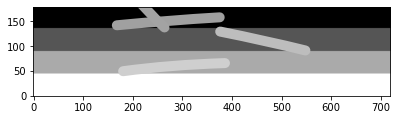

0.0026855261669267334
Processing: WE=4.0, WG=0.5, WI=0.5, Species=0
Processing: WE=4.0, WG=0.5, WI=0.5, Species=1
Processing: WE=4.0, WG=0.5, WI=0.5, Species=2
Processing: WE=4.0, WG=0.5, WI=0.5, Species=3
Processing: WE=4.0, WG=0.5, WI=0.5, Species=4


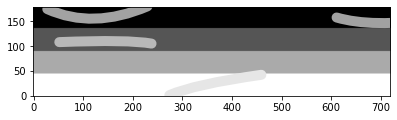

0.0038298875402243376
Processing: WE=4.0, WG=0.5, WI=1.0, Species=0
Processing: WE=4.0, WG=0.5, WI=1.0, Species=1
Processing: WE=4.0, WG=0.5, WI=1.0, Species=2
Processing: WE=4.0, WG=0.5, WI=1.0, Species=3
Processing: WE=4.0, WG=0.5, WI=1.0, Species=4


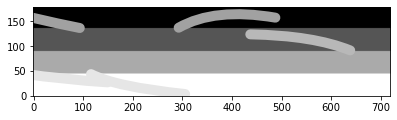

0.0042055949107839136
Processing: WE=4.0, WG=0.5, WI=1.5, Species=0
Processing: WE=4.0, WG=0.5, WI=1.5, Species=1
Processing: WE=4.0, WG=0.5, WI=1.5, Species=2
Processing: WE=4.0, WG=0.5, WI=1.5, Species=3
Processing: WE=4.0, WG=0.5, WI=1.5, Species=4


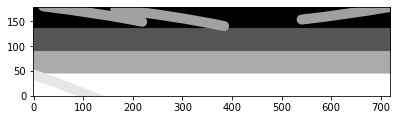

0.0024497581876196614
Processing: WE=4.0, WG=0.5, WI=2.0, Species=0
Processing: WE=4.0, WG=0.5, WI=2.0, Species=1
Processing: WE=4.0, WG=0.5, WI=2.0, Species=2
Processing: WE=4.0, WG=0.5, WI=2.0, Species=3
Processing: WE=4.0, WG=0.5, WI=2.0, Species=4


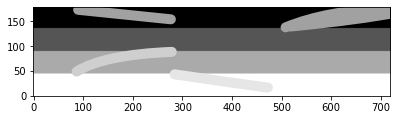

0.004222940767050237
Processing: WE=4.0, WG=0.5, WI=2.5, Species=0
Processing: WE=4.0, WG=0.5, WI=2.5, Species=1
Processing: WE=4.0, WG=0.5, WI=2.5, Species=2
Processing: WE=4.0, WG=0.5, WI=2.5, Species=3
Processing: WE=4.0, WG=0.5, WI=2.5, Species=4


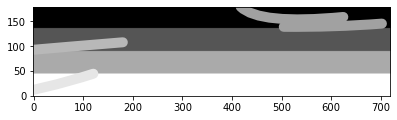

0.0034904029689516447
Processing: WE=4.0, WG=0.5, WI=3.0, Species=0
Processing: WE=4.0, WG=0.5, WI=3.0, Species=1
Processing: WE=4.0, WG=0.5, WI=3.0, Species=2
Processing: WE=4.0, WG=0.5, WI=3.0, Species=3
Processing: WE=4.0, WG=0.5, WI=3.0, Species=4


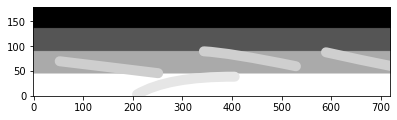

0.003266718946496028
Processing: WE=4.0, WG=0.5, WI=3.5, Species=0
Processing: WE=4.0, WG=0.5, WI=3.5, Species=1
Processing: WE=4.0, WG=0.5, WI=3.5, Species=2
Processing: WE=4.0, WG=0.5, WI=3.5, Species=3
Processing: WE=4.0, WG=0.5, WI=3.5, Species=4


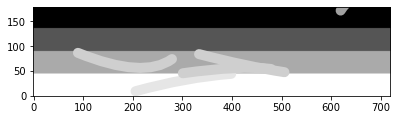

0.0033828005175654654
Processing: WE=4.0, WG=0.5, WI=4.0, Species=0
Processing: WE=4.0, WG=0.5, WI=4.0, Species=1
Processing: WE=4.0, WG=0.5, WI=4.0, Species=2
Processing: WE=4.0, WG=0.5, WI=4.0, Species=3
Processing: WE=4.0, WG=0.5, WI=4.0, Species=4


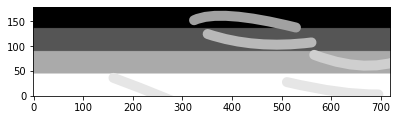

0.004369866952921748
Processing: WE=4.0, WG=1.0, WI=0.0, Species=0
Processing: WE=4.0, WG=1.0, WI=0.0, Species=1
Processing: WE=4.0, WG=1.0, WI=0.0, Species=2
Processing: WE=4.0, WG=1.0, WI=0.0, Species=3
Processing: WE=4.0, WG=1.0, WI=0.0, Species=4


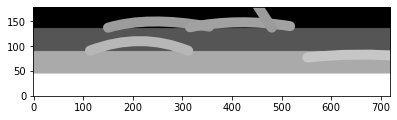

0.0038774578242530442
Processing: WE=4.0, WG=1.0, WI=0.5, Species=0
Processing: WE=4.0, WG=1.0, WI=0.5, Species=1
Processing: WE=4.0, WG=1.0, WI=0.5, Species=2
Processing: WE=4.0, WG=1.0, WI=0.5, Species=3
Processing: WE=4.0, WG=1.0, WI=0.5, Species=4


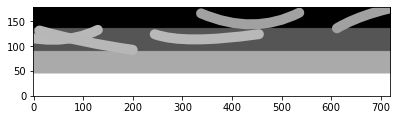

0.004162152746738143
Processing: WE=4.0, WG=1.0, WI=1.0, Species=0
Processing: WE=4.0, WG=1.0, WI=1.0, Species=1
Processing: WE=4.0, WG=1.0, WI=1.0, Species=2
Processing: WE=4.0, WG=1.0, WI=1.0, Species=3
Processing: WE=4.0, WG=1.0, WI=1.0, Species=4


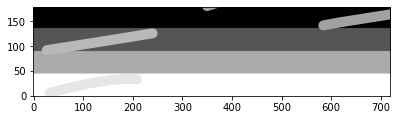

0.0027909482732515027
Processing: WE=4.0, WG=1.0, WI=1.5, Species=0
Processing: WE=4.0, WG=1.0, WI=1.5, Species=1
Processing: WE=4.0, WG=1.0, WI=1.5, Species=2
Processing: WE=4.0, WG=1.0, WI=1.5, Species=3
Processing: WE=4.0, WG=1.0, WI=1.5, Species=4


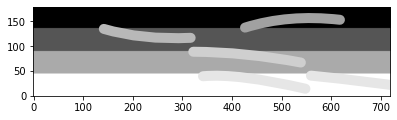

0.005104052122844517
Processing: WE=4.0, WG=1.0, WI=2.0, Species=0
Processing: WE=4.0, WG=1.0, WI=2.0, Species=1
Processing: WE=4.0, WG=1.0, WI=2.0, Species=2
Processing: WE=4.0, WG=1.0, WI=2.0, Species=3
Processing: WE=4.0, WG=1.0, WI=2.0, Species=4


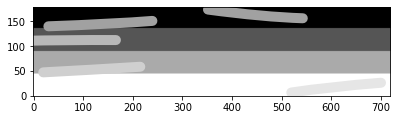

0.004600421484926427
Processing: WE=4.0, WG=1.0, WI=2.5, Species=0
Processing: WE=4.0, WG=1.0, WI=2.5, Species=1
Processing: WE=4.0, WG=1.0, WI=2.5, Species=2
Processing: WE=4.0, WG=1.0, WI=2.5, Species=3
Processing: WE=4.0, WG=1.0, WI=2.5, Species=4


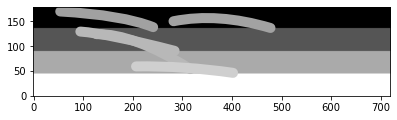

0.004598560923807357
Processing: WE=4.0, WG=1.0, WI=3.0, Species=0
Processing: WE=4.0, WG=1.0, WI=3.0, Species=1
Processing: WE=4.0, WG=1.0, WI=3.0, Species=2
Processing: WE=4.0, WG=1.0, WI=3.0, Species=3
Processing: WE=4.0, WG=1.0, WI=3.0, Species=4


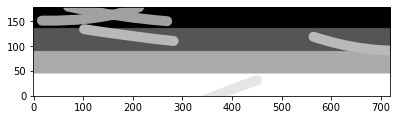

0.003272368462810702
Processing: WE=4.0, WG=1.0, WI=3.5, Species=0
Processing: WE=4.0, WG=1.0, WI=3.5, Species=1
Processing: WE=4.0, WG=1.0, WI=3.5, Species=2
Processing: WE=4.0, WG=1.0, WI=3.5, Species=3
Processing: WE=4.0, WG=1.0, WI=3.5, Species=4


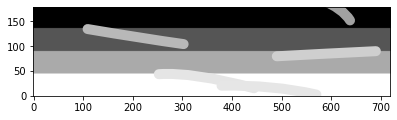

0.004493293864242511
Processing: WE=4.0, WG=1.0, WI=4.0, Species=0
Processing: WE=4.0, WG=1.0, WI=4.0, Species=1
Processing: WE=4.0, WG=1.0, WI=4.0, Species=2
Processing: WE=4.0, WG=1.0, WI=4.0, Species=3
Processing: WE=4.0, WG=1.0, WI=4.0, Species=4


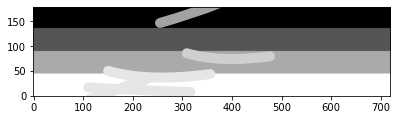

0.004189344072259543
Processing: WE=4.0, WG=1.5, WI=0.0, Species=0
Processing: WE=4.0, WG=1.5, WI=0.0, Species=1
Processing: WE=4.0, WG=1.5, WI=0.0, Species=2
Processing: WE=4.0, WG=1.5, WI=0.0, Species=3
Processing: WE=4.0, WG=1.5, WI=0.0, Species=4


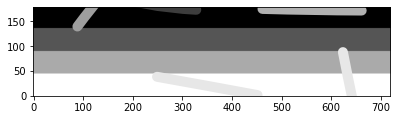

0.0032378124161929864
Processing: WE=4.0, WG=1.5, WI=0.5, Species=0
Processing: WE=4.0, WG=1.5, WI=0.5, Species=1
Processing: WE=4.0, WG=1.5, WI=0.5, Species=2
Processing: WE=4.0, WG=1.5, WI=0.5, Species=3
Processing: WE=4.0, WG=1.5, WI=0.5, Species=4


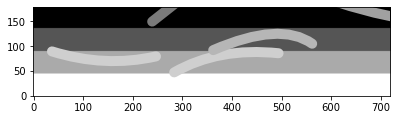

0.004663225113117513
Processing: WE=4.0, WG=1.5, WI=1.0, Species=0
Processing: WE=4.0, WG=1.5, WI=1.0, Species=1
Processing: WE=4.0, WG=1.5, WI=1.0, Species=2
Processing: WE=4.0, WG=1.5, WI=1.0, Species=3
Processing: WE=4.0, WG=1.5, WI=1.0, Species=4


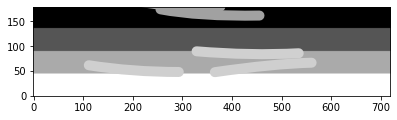

0.004264047539274677
Processing: WE=4.0, WG=1.5, WI=1.5, Species=0
Processing: WE=4.0, WG=1.5, WI=1.5, Species=1
Processing: WE=4.0, WG=1.5, WI=1.5, Species=2
Processing: WE=4.0, WG=1.5, WI=1.5, Species=3
Processing: WE=4.0, WG=1.5, WI=1.5, Species=4


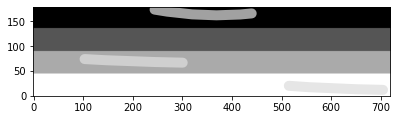

0.003000658706469108
Processing: WE=4.0, WG=1.5, WI=2.0, Species=0
Processing: WE=4.0, WG=1.5, WI=2.0, Species=1
Processing: WE=4.0, WG=1.5, WI=2.0, Species=2
Processing: WE=4.0, WG=1.5, WI=2.0, Species=3
Processing: WE=4.0, WG=1.5, WI=2.0, Species=4


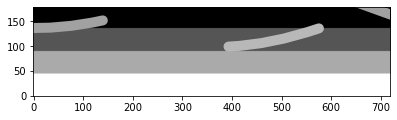

0.0019291790007575486
Processing: WE=4.0, WG=1.5, WI=2.5, Species=0
Processing: WE=4.0, WG=1.5, WI=2.5, Species=1
Processing: WE=4.0, WG=1.5, WI=2.5, Species=2
Processing: WE=4.0, WG=1.5, WI=2.5, Species=3
Processing: WE=4.0, WG=1.5, WI=2.5, Species=4


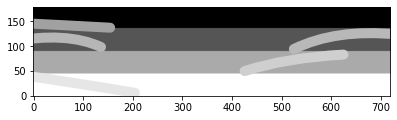

0.005453333711259811
Processing: WE=4.0, WG=1.5, WI=3.0, Species=0
Processing: WE=4.0, WG=1.5, WI=3.0, Species=1
Processing: WE=4.0, WG=1.5, WI=3.0, Species=2
Processing: WE=4.0, WG=1.5, WI=3.0, Species=3
Processing: WE=4.0, WG=1.5, WI=3.0, Species=4


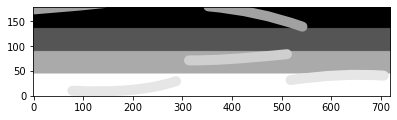

0.004312480270905451
Processing: WE=4.0, WG=1.5, WI=3.5, Species=0
Processing: WE=4.0, WG=1.5, WI=3.5, Species=1
Processing: WE=4.0, WG=1.5, WI=3.5, Species=2
Processing: WE=4.0, WG=1.5, WI=3.5, Species=3
Processing: WE=4.0, WG=1.5, WI=3.5, Species=4


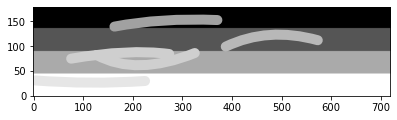

0.005056074841071015
Processing: WE=4.0, WG=1.5, WI=4.0, Species=0
Processing: WE=4.0, WG=1.5, WI=4.0, Species=1
Processing: WE=4.0, WG=1.5, WI=4.0, Species=2
Processing: WE=4.0, WG=1.5, WI=4.0, Species=3
Processing: WE=4.0, WG=1.5, WI=4.0, Species=4


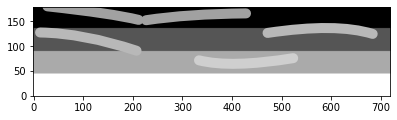

0.0046649306274766595
Processing: WE=4.0, WG=2.0, WI=0.0, Species=0
Processing: WE=4.0, WG=2.0, WI=0.0, Species=1
Processing: WE=4.0, WG=2.0, WI=0.0, Species=2
Processing: WE=4.0, WG=2.0, WI=0.0, Species=3
Processing: WE=4.0, WG=2.0, WI=0.0, Species=4


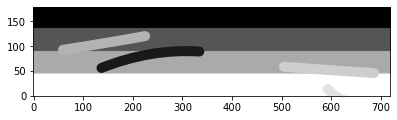

0.0021534638294078644
Processing: WE=4.0, WG=2.0, WI=0.5, Species=0
Processing: WE=4.0, WG=2.0, WI=0.5, Species=1
Processing: WE=4.0, WG=2.0, WI=0.5, Species=2
Processing: WE=4.0, WG=2.0, WI=0.5, Species=3
Processing: WE=4.0, WG=2.0, WI=0.5, Species=4


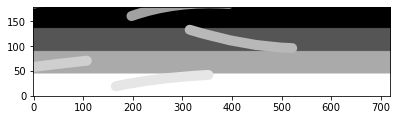

0.003124637971872096
Processing: WE=4.0, WG=2.0, WI=1.0, Species=0
Processing: WE=4.0, WG=2.0, WI=1.0, Species=1
Processing: WE=4.0, WG=2.0, WI=1.0, Species=2
Processing: WE=4.0, WG=2.0, WI=1.0, Species=3
Processing: WE=4.0, WG=2.0, WI=1.0, Species=4


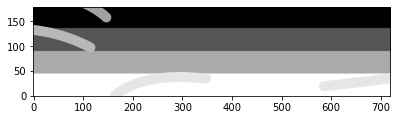

0.0027274856963307456
Processing: WE=4.0, WG=2.0, WI=1.5, Species=0
Processing: WE=4.0, WG=2.0, WI=1.5, Species=1
Processing: WE=4.0, WG=2.0, WI=1.5, Species=2
Processing: WE=4.0, WG=2.0, WI=1.5, Species=3
Processing: WE=4.0, WG=2.0, WI=1.5, Species=4


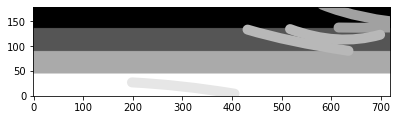

0.004258029786905187
Processing: WE=4.0, WG=2.0, WI=2.0, Species=0
Processing: WE=4.0, WG=2.0, WI=2.0, Species=1
Processing: WE=4.0, WG=2.0, WI=2.0, Species=2
Processing: WE=4.0, WG=2.0, WI=2.0, Species=3
Processing: WE=4.0, WG=2.0, WI=2.0, Species=4


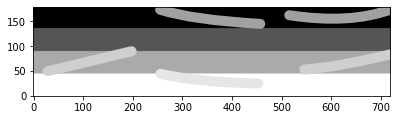

0.003997047328265726
Processing: WE=4.0, WG=2.0, WI=2.5, Species=0
Processing: WE=4.0, WG=2.0, WI=2.5, Species=1
Processing: WE=4.0, WG=2.0, WI=2.5, Species=2
Processing: WE=4.0, WG=2.0, WI=2.5, Species=3
Processing: WE=4.0, WG=2.0, WI=2.5, Species=4


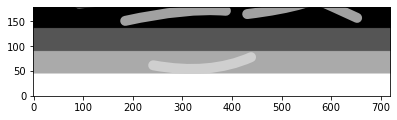

0.002440329406531878
Processing: WE=4.0, WG=2.0, WI=3.0, Species=0
Processing: WE=4.0, WG=2.0, WI=3.0, Species=1
Processing: WE=4.0, WG=2.0, WI=3.0, Species=2
Processing: WE=4.0, WG=2.0, WI=3.0, Species=3
Processing: WE=4.0, WG=2.0, WI=3.0, Species=4


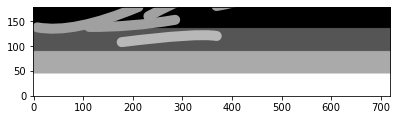

0.0022809800990215823
Processing: WE=4.0, WG=2.0, WI=3.5, Species=0
Processing: WE=4.0, WG=2.0, WI=3.5, Species=1
Processing: WE=4.0, WG=2.0, WI=3.5, Species=2
Processing: WE=4.0, WG=2.0, WI=3.5, Species=3
Processing: WE=4.0, WG=2.0, WI=3.5, Species=4


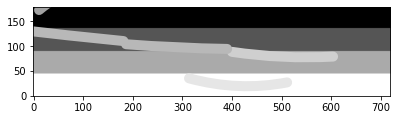

0.0042625842854779085
Processing: WE=4.0, WG=2.0, WI=4.0, Species=0
Processing: WE=4.0, WG=2.0, WI=4.0, Species=1
Processing: WE=4.0, WG=2.0, WI=4.0, Species=2
Processing: WE=4.0, WG=2.0, WI=4.0, Species=3
Processing: WE=4.0, WG=2.0, WI=4.0, Species=4


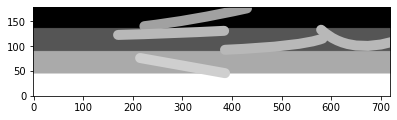

0.00446628665674852
Processing: WE=4.0, WG=2.5, WI=0.0, Species=0
Processing: WE=4.0, WG=2.5, WI=0.0, Species=1
Processing: WE=4.0, WG=2.5, WI=0.0, Species=2
Processing: WE=4.0, WG=2.5, WI=0.0, Species=3
Processing: WE=4.0, WG=2.5, WI=0.0, Species=4


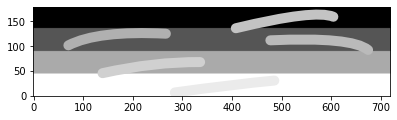

0.00788194739699505
Processing: WE=4.0, WG=2.5, WI=0.5, Species=0
Processing: WE=4.0, WG=2.5, WI=0.5, Species=1
Processing: WE=4.0, WG=2.5, WI=0.5, Species=2
Processing: WE=4.0, WG=2.5, WI=0.5, Species=3
Processing: WE=4.0, WG=2.5, WI=0.5, Species=4


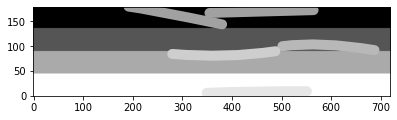

0.004150156003689144
Processing: WE=4.0, WG=2.5, WI=1.0, Species=0
Processing: WE=4.0, WG=2.5, WI=1.0, Species=1
Processing: WE=4.0, WG=2.5, WI=1.0, Species=2
Processing: WE=4.0, WG=2.5, WI=1.0, Species=3
Processing: WE=4.0, WG=2.5, WI=1.0, Species=4


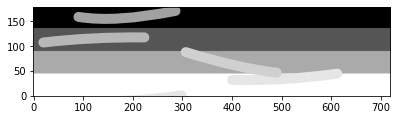

0.0052584496244597895
Processing: WE=4.0, WG=2.5, WI=1.5, Species=0
Processing: WE=4.0, WG=2.5, WI=1.5, Species=1
Processing: WE=4.0, WG=2.5, WI=1.5, Species=2
Processing: WE=4.0, WG=2.5, WI=1.5, Species=3
Processing: WE=4.0, WG=2.5, WI=1.5, Species=4


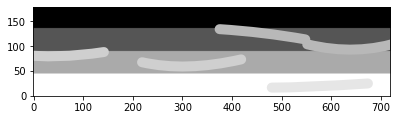

0.004817390044592902
Processing: WE=4.0, WG=2.5, WI=2.0, Species=0
Processing: WE=4.0, WG=2.5, WI=2.0, Species=1
Processing: WE=4.0, WG=2.5, WI=2.0, Species=2
Processing: WE=4.0, WG=2.5, WI=2.0, Species=3
Processing: WE=4.0, WG=2.5, WI=2.0, Species=4


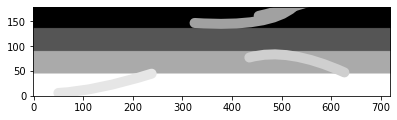

0.003143573057427624
Processing: WE=4.0, WG=2.5, WI=2.5, Species=0
Processing: WE=4.0, WG=2.5, WI=2.5, Species=1
Processing: WE=4.0, WG=2.5, WI=2.5, Species=2
Processing: WE=4.0, WG=2.5, WI=2.5, Species=3
Processing: WE=4.0, WG=2.5, WI=2.5, Species=4


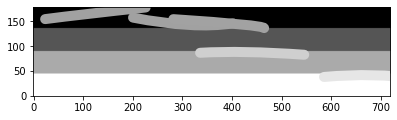

0.0044089484268446996
Processing: WE=4.0, WG=2.5, WI=3.0, Species=0
Processing: WE=4.0, WG=2.5, WI=3.0, Species=1
Processing: WE=4.0, WG=2.5, WI=3.0, Species=2
Processing: WE=4.0, WG=2.5, WI=3.0, Species=3
Processing: WE=4.0, WG=2.5, WI=3.0, Species=4


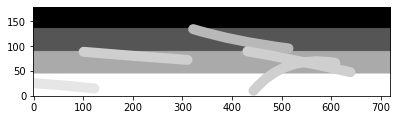

0.004240906810356251
Processing: WE=4.0, WG=2.5, WI=3.5, Species=0
Processing: WE=4.0, WG=2.5, WI=3.5, Species=1
Processing: WE=4.0, WG=2.5, WI=3.5, Species=2
Processing: WE=4.0, WG=2.5, WI=3.5, Species=3
Processing: WE=4.0, WG=2.5, WI=3.5, Species=4


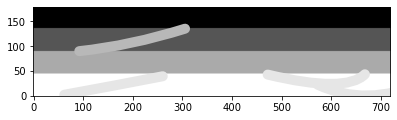

0.00409668425236089
Processing: WE=4.0, WG=2.5, WI=4.0, Species=0
Processing: WE=4.0, WG=2.5, WI=4.0, Species=1
Processing: WE=4.0, WG=2.5, WI=4.0, Species=2
Processing: WE=4.0, WG=2.5, WI=4.0, Species=3
Processing: WE=4.0, WG=2.5, WI=4.0, Species=4


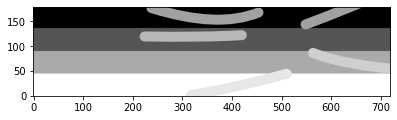

0.00379293795925032
Processing: WE=4.0, WG=3.0, WI=0.0, Species=0
Processing: WE=4.0, WG=3.0, WI=0.0, Species=1
Processing: WE=4.0, WG=3.0, WI=0.0, Species=2
Processing: WE=4.0, WG=3.0, WI=0.0, Species=3
Processing: WE=4.0, WG=3.0, WI=0.0, Species=4


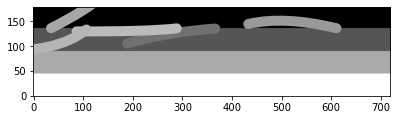

0.004430984447598677
Processing: WE=4.0, WG=3.0, WI=0.5, Species=0
Processing: WE=4.0, WG=3.0, WI=0.5, Species=1
Processing: WE=4.0, WG=3.0, WI=0.5, Species=2
Processing: WE=4.0, WG=3.0, WI=0.5, Species=3
Processing: WE=4.0, WG=3.0, WI=0.5, Species=4


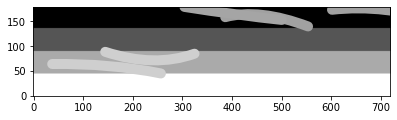

0.0036254196255766104
Processing: WE=4.0, WG=3.0, WI=1.0, Species=0
Processing: WE=4.0, WG=3.0, WI=1.0, Species=1
Processing: WE=4.0, WG=3.0, WI=1.0, Species=2
Processing: WE=4.0, WG=3.0, WI=1.0, Species=3
Processing: WE=4.0, WG=3.0, WI=1.0, Species=4


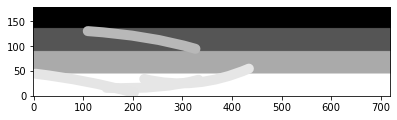

0.0042914714349359595
Processing: WE=4.0, WG=3.0, WI=1.5, Species=0
Processing: WE=4.0, WG=3.0, WI=1.5, Species=1
Processing: WE=4.0, WG=3.0, WI=1.5, Species=2
Processing: WE=4.0, WG=3.0, WI=1.5, Species=3
Processing: WE=4.0, WG=3.0, WI=1.5, Species=4


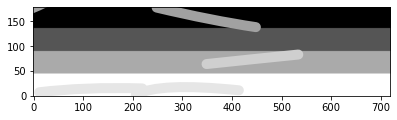

0.004294940606189224
Processing: WE=4.0, WG=3.0, WI=2.0, Species=0
Processing: WE=4.0, WG=3.0, WI=2.0, Species=1
Processing: WE=4.0, WG=3.0, WI=2.0, Species=2
Processing: WE=4.0, WG=3.0, WI=2.0, Species=3
Processing: WE=4.0, WG=3.0, WI=2.0, Species=4


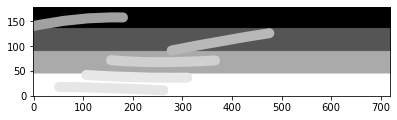

0.0058061329230408455
Processing: WE=4.0, WG=3.0, WI=2.5, Species=0
Processing: WE=4.0, WG=3.0, WI=2.5, Species=1
Processing: WE=4.0, WG=3.0, WI=2.5, Species=2
Processing: WE=4.0, WG=3.0, WI=2.5, Species=3
Processing: WE=4.0, WG=3.0, WI=2.5, Species=4


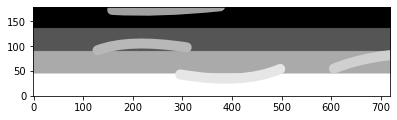

0.0036147892320994275
Processing: WE=4.0, WG=3.0, WI=3.0, Species=0
Processing: WE=4.0, WG=3.0, WI=3.0, Species=1
Processing: WE=4.0, WG=3.0, WI=3.0, Species=2
Processing: WE=4.0, WG=3.0, WI=3.0, Species=3
Processing: WE=4.0, WG=3.0, WI=3.0, Species=4


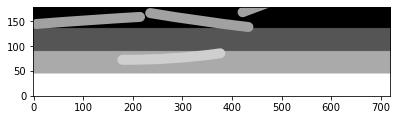

0.0029819271197859772
Processing: WE=4.0, WG=3.0, WI=3.5, Species=0
Processing: WE=4.0, WG=3.0, WI=3.5, Species=1
Processing: WE=4.0, WG=3.0, WI=3.5, Species=2
Processing: WE=4.0, WG=3.0, WI=3.5, Species=3
Processing: WE=4.0, WG=3.0, WI=3.5, Species=4


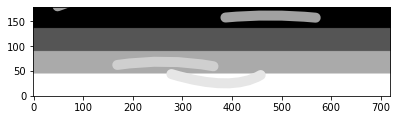

0.002912844097818032
Processing: WE=4.0, WG=3.0, WI=4.0, Species=0
Processing: WE=4.0, WG=3.0, WI=4.0, Species=1
Processing: WE=4.0, WG=3.0, WI=4.0, Species=2
Processing: WE=4.0, WG=3.0, WI=4.0, Species=3
Processing: WE=4.0, WG=3.0, WI=4.0, Species=4


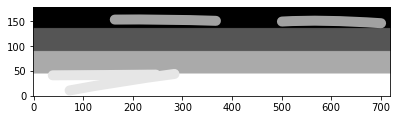

0.0036341022441322675
Processing: WE=4.0, WG=3.5, WI=0.0, Species=0
Processing: WE=4.0, WG=3.5, WI=0.0, Species=1
Processing: WE=4.0, WG=3.5, WI=0.0, Species=2
Processing: WE=4.0, WG=3.5, WI=0.0, Species=3
Processing: WE=4.0, WG=3.5, WI=0.0, Species=4


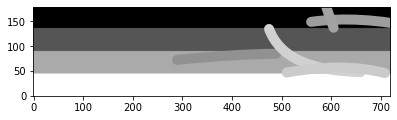

0.0039740907173747095
Processing: WE=4.0, WG=3.5, WI=0.5, Species=0
Processing: WE=4.0, WG=3.5, WI=0.5, Species=1
Processing: WE=4.0, WG=3.5, WI=0.5, Species=2
Processing: WE=4.0, WG=3.5, WI=0.5, Species=3
Processing: WE=4.0, WG=3.5, WI=0.5, Species=4


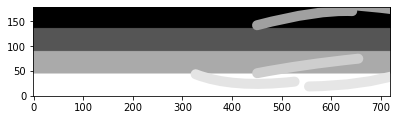

0.0039138841224123245
Processing: WE=4.0, WG=3.5, WI=1.0, Species=0
Processing: WE=4.0, WG=3.5, WI=1.0, Species=1
Processing: WE=4.0, WG=3.5, WI=1.0, Species=2
Processing: WE=4.0, WG=3.5, WI=1.0, Species=3
Processing: WE=4.0, WG=3.5, WI=1.0, Species=4


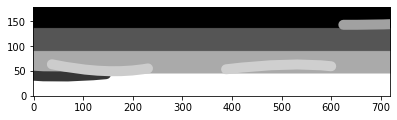

0.003986562291125971
Processing: WE=4.0, WG=3.5, WI=1.5, Species=0
Processing: WE=4.0, WG=3.5, WI=1.5, Species=1
Processing: WE=4.0, WG=3.5, WI=1.5, Species=2
Processing: WE=4.0, WG=3.5, WI=1.5, Species=3
Processing: WE=4.0, WG=3.5, WI=1.5, Species=4


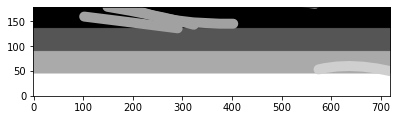

0.002668577617982711
Processing: WE=4.0, WG=3.5, WI=2.0, Species=0
Processing: WE=4.0, WG=3.5, WI=2.0, Species=1
Processing: WE=4.0, WG=3.5, WI=2.0, Species=2
Processing: WE=4.0, WG=3.5, WI=2.0, Species=3
Processing: WE=4.0, WG=3.5, WI=2.0, Species=4


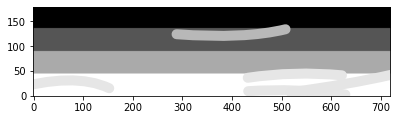

0.005306058670178476
Processing: WE=4.0, WG=3.5, WI=2.5, Species=0
Processing: WE=4.0, WG=3.5, WI=2.5, Species=1
Processing: WE=4.0, WG=3.5, WI=2.5, Species=2
Processing: WE=4.0, WG=3.5, WI=2.5, Species=3
Processing: WE=4.0, WG=3.5, WI=2.5, Species=4


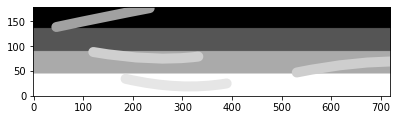

0.003578072221265293
Processing: WE=4.0, WG=3.5, WI=3.0, Species=0
Processing: WE=4.0, WG=3.5, WI=3.0, Species=1
Processing: WE=4.0, WG=3.5, WI=3.0, Species=2
Processing: WE=4.0, WG=3.5, WI=3.0, Species=3
Processing: WE=4.0, WG=3.5, WI=3.0, Species=4


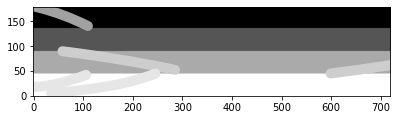

0.004790780144421212
Processing: WE=4.0, WG=3.5, WI=3.5, Species=0
Processing: WE=4.0, WG=3.5, WI=3.5, Species=1
Processing: WE=4.0, WG=3.5, WI=3.5, Species=2
Processing: WE=4.0, WG=3.5, WI=3.5, Species=3
Processing: WE=4.0, WG=3.5, WI=3.5, Species=4


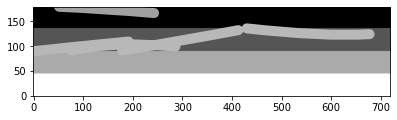

0.0043228780942427495
Processing: WE=4.0, WG=3.5, WI=4.0, Species=0
Processing: WE=4.0, WG=3.5, WI=4.0, Species=1
Processing: WE=4.0, WG=3.5, WI=4.0, Species=2
Processing: WE=4.0, WG=3.5, WI=4.0, Species=3
Processing: WE=4.0, WG=3.5, WI=4.0, Species=4


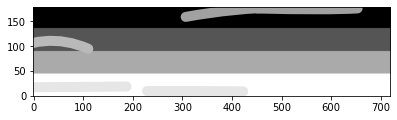

0.003590621318396516
Processing: WE=4.0, WG=4.0, WI=0.0, Species=0
Processing: WE=4.0, WG=4.0, WI=0.0, Species=1
Processing: WE=4.0, WG=4.0, WI=0.0, Species=2
Processing: WE=4.0, WG=4.0, WI=0.0, Species=3
Processing: WE=4.0, WG=4.0, WI=0.0, Species=4


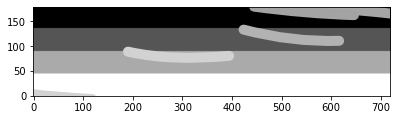

0.00588307487765236
Processing: WE=4.0, WG=4.0, WI=0.5, Species=0
Processing: WE=4.0, WG=4.0, WI=0.5, Species=1
Processing: WE=4.0, WG=4.0, WI=0.5, Species=2
Processing: WE=4.0, WG=4.0, WI=0.5, Species=3
Processing: WE=4.0, WG=4.0, WI=0.5, Species=4


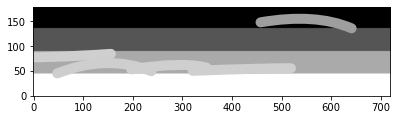

0.003954021852387248
Processing: WE=4.0, WG=4.0, WI=1.0, Species=0
Processing: WE=4.0, WG=4.0, WI=1.0, Species=1
Processing: WE=4.0, WG=4.0, WI=1.0, Species=2
Processing: WE=4.0, WG=4.0, WI=1.0, Species=3
Processing: WE=4.0, WG=4.0, WI=1.0, Species=4


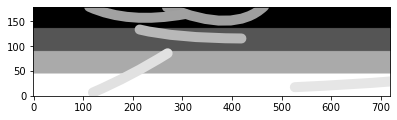

0.0056303002068662945
Processing: WE=4.0, WG=4.0, WI=1.5, Species=0
Processing: WE=4.0, WG=4.0, WI=1.5, Species=1
Processing: WE=4.0, WG=4.0, WI=1.5, Species=2
Processing: WE=4.0, WG=4.0, WI=1.5, Species=3
Processing: WE=4.0, WG=4.0, WI=1.5, Species=4


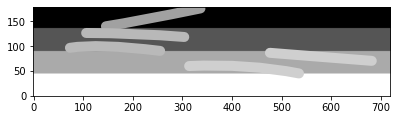

0.004510911052338699
Processing: WE=4.0, WG=4.0, WI=2.0, Species=0
Processing: WE=4.0, WG=4.0, WI=2.0, Species=1
Processing: WE=4.0, WG=4.0, WI=2.0, Species=2
Processing: WE=4.0, WG=4.0, WI=2.0, Species=3
Processing: WE=4.0, WG=4.0, WI=2.0, Species=4


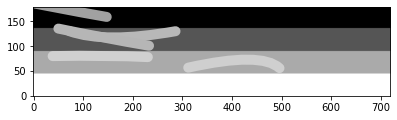

0.00545805294701495
Processing: WE=4.0, WG=4.0, WI=2.5, Species=0
Processing: WE=4.0, WG=4.0, WI=2.5, Species=1
Processing: WE=4.0, WG=4.0, WI=2.5, Species=2
Processing: WE=4.0, WG=4.0, WI=2.5, Species=3
Processing: WE=4.0, WG=4.0, WI=2.5, Species=4


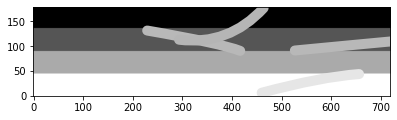

0.0038055839606064945
Processing: WE=4.0, WG=4.0, WI=3.0, Species=0
Processing: WE=4.0, WG=4.0, WI=3.0, Species=1
Processing: WE=4.0, WG=4.0, WI=3.0, Species=2
Processing: WE=4.0, WG=4.0, WI=3.0, Species=3
Processing: WE=4.0, WG=4.0, WI=3.0, Species=4


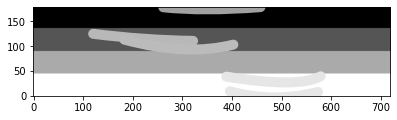

0.004388666372562344
Processing: WE=4.0, WG=4.0, WI=3.5, Species=0
Processing: WE=4.0, WG=4.0, WI=3.5, Species=1
Processing: WE=4.0, WG=4.0, WI=3.5, Species=2
Processing: WE=4.0, WG=4.0, WI=3.5, Species=3
Processing: WE=4.0, WG=4.0, WI=3.5, Species=4


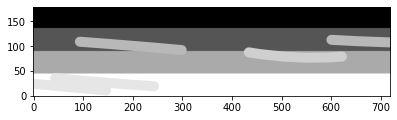

0.004548519582042387
Processing: WE=4.0, WG=4.0, WI=4.0, Species=0
Processing: WE=4.0, WG=4.0, WI=4.0, Species=1
Processing: WE=4.0, WG=4.0, WI=4.0, Species=2
Processing: WE=4.0, WG=4.0, WI=4.0, Species=3
Processing: WE=4.0, WG=4.0, WI=4.0, Species=4


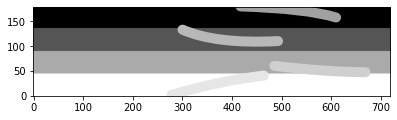

0.003479268673504713


In [196]:
variance_dict2 = generate_images(test_optimise)

In [37]:
from PIL import Image

# Define image dimensions
width = 720
height = 240

# Create a new grayscale image
image = Image.new("L", (width, height))

# Define the number of gray levels
num_levels = 12

# Calculate the step size for each gray level
step_size = 255 // (num_levels - 1)

# Generate the gray values
gray_values = [i * step_size for i in range(num_levels)]

# Draw the gray scale image
for y in range(height):
    for x in range(width):
        # Determine the gray level based on the y-coordinate
        gray_level = y // (height // (num_levels - 1))
        # Set the pixel color
        image.putpixel((x, y), gray_values[gray_level])


# Save the image
image.save("grayscale_image_240x720.png")

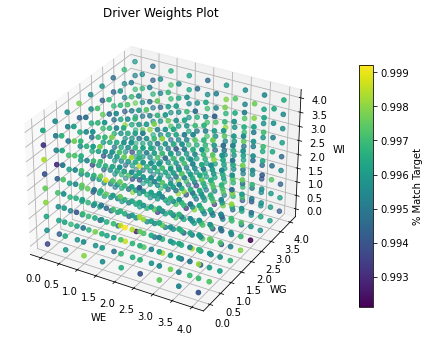

In [223]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_variances(variances):
    # Extract the we, wg, wi values and variances from the dictionary
    we_list = []
    wg_list = []
    wi_list = []
    variance_list = []

    for key, value in variances.items():
        we, wg, wi = key
        variance = value

        we_list.append(we)
        wg_list.append(wg)
        wi_list.append(wi)
        variance_list.append((1-variance))

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the points
    ax.scatter(we_list, wg_list, wi_list, c=variance_list, cmap='viridis')

    # Set labels and title
    ax.set_xlabel('WE')
    ax.set_ylabel('WG')
    ax.set_zlabel('WI')
    ax.set_title('Driver Weights Plot')
    plt.tight_layout()

    # Add a color bar
    cbar_ax = fig.add_axes([0.93, 0.1, 0.03, 0.7])
    cbar = fig.colorbar(ax.scatter(we_list, wg_list, wi_list, c=variance_list, cmap='viridis'),cax=cbar_ax)
    cbar.set_label('% Match Target')

    # Display the plot
    plt.show()

# Example usage
plot_variances(variance_dict2)

In [197]:
def find_min_variance(variance_dict):
    min_variance = min(variance_dict.items(), key=lambda x: x[1])
    return min_variance

# Example usage
min_variance = find_min_variance(variance_dict2)
print("Minimum variance:", min_variance[1])
print("Corresponding weights (WE, WG, WI):", min_variance[0])

Minimum variance: 0.0007737608553929746
Corresponding weights (WE, WG, WI): (1.5, 1.0, 0.5)
